## Import Libraries

In [262]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, SimpleRNN, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Define Performance Metric Computation Function

In [278]:
def compute_metrics(x_test, y_test, model):
    
    y_pred = np.round(model.predict_classes(x_test))
    
    # calculate true positives, false positives, true negatives, false negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    
    for counter in range(len(y_test)):
        if y_test[counter] == 1:
            if y_pred[counter] == 1:
                true_pos += 1
            else:
                false_neg += 1
        else:
            if y_pred[counter] == 0:
                true_neg += 1
            else:
                false_pos += 1
    
    accuracy = (true_pos + true_neg) / len(y_test)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    try:
        f1_score = (2 * precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1_score = 1
    
    print('Accuracy:', '%.5f' % accuracy)
    print('Precision:', '%.5f' % precision)
    print('Recall:', '%.5f' % recall)
    print('F1 Score:', '%.5f' % f1_score)
    
    return ', '.join([str(accuracy), str(precision), str(recall), str(f1_score)])

## Testing on Dataset 1

Dataset 1 consists of the first 100 non-repeated consecutive API calls made when running a Windows executable. The data labels are binary, with a label of '1' suggesting that the executable is malicious, and a label of '0' suggesting that the executable is non-malicious in nature. This dataset was sourced from https://www.kaggle.com/ang3loliveira/malware-analysis-datasets-api-call-sequences, and more details can be found in the paper at https://www.techrxiv.org/articles/Behavioral_Malware_Detection_Using_Deep_Graph_Convolutional_Neural_Networks/10043099/1.

In [8]:
path_to_dataset_1 = '../Dataset1/dynamic_api_call_sequence_per_malware_100_0_306.csv'
dataset1 = pd.read_csv(path_to_dataset_1)
dataset1.head()

hash  t_0  t_1  t_2  t_3  t_4  t_5  t_6  t_7  \
0  071e8c3f8922e186e57548cd4c703a5d  112  274  158  215  274  158  215  298   
1  33f8e6d08a6aae939f25a8e0d63dd523   82  208  187  208  172  117  172  117   
2  b68abd064e975e1c6d5f25e748663076   16  110  240  117  240  117  240  117   
3  72049be7bd30ea61297ea624ae198067   82  208  187  208  172  117  172  117   
4  c9b3700a77facf29172f32df6bc77f48   82  240  117  240  117  240  117  240   

   t_8  ...  t_91  t_92  t_93  t_94  t_95  t_96  t_97  t_98  t_99  malware  
0   76  ...    71   297   135   171   215    35   208    56    71        1  
1  172  ...    81   240   117    71   297   135   171   215    35        1  
2  240  ...    65   112   123    65   112   123    65   113   112        1  
3  172  ...   208   302   208   302   187   208   302   228   302        1  
4  117  ...   209   260    40   209   260   141   260   141   260        1  

[5 rows x 102 columns]

In [60]:
# use .values to convert to numpy array and drop index
X_dataset1 = dataset1.drop(columns=['hash', 'malware']).values
Y_dataset1 = dataset1['malware'].values

In [79]:
# convert numbers for use with embedding
vocab_size_dataset1 = 0
vocab_conversion_dict = {}
for example in X_dataset1:
    for api_call in example:
        if not(api_call in vocab_conversion_dict):
            vocab_conversion_dict[api_call] = vocab_size_dataset1
            vocab_size_dataset1 += 1
print('Total Number of Unique API Calls:', vocab_size_dataset1)

# convert array based on values in dictionary
# https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key
X_dataset1 = np.vectorize(vocab_conversion_dict.get)(X_dataset1)

Total Number of Unique API Calls: 264


In [101]:
# split into train and test sets
X_train_dataset1, X_test_dataset1, Y_train_dataset1, Y_test_dataset1 = train_test_split(X_dataset1, Y_dataset1,
                                                                                        test_size=0.2)
print('Train Data Shape:\n', X_train_dataset1.shape, '\n', Y_train_dataset1.shape)
print('Test Data Shape:\n', X_test_dataset1.shape, '\n', Y_test_dataset1.shape)

Train Data Shape:
 (35100, 100) 
 (35100,)
Test Data Shape:
 (8776, 100) 
 (8776,)


In [144]:
# batch normalization and optimizer clipping were added to avoid exploding gradients
def generate_model_dataset1(num_layers, bidirectional, rnn_type, dropout_rate,
                            vocab_size, input_dim, hidden_dim):
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hidden_dim, input_length=input_dim))
    
    if rnn_type == 'SimpleRNN':
        layer = SimpleRNN(units=hidden_dim, activation='tanh')
    elif rnn_type == 'LSTM':
        layer = LSTM(units=hidden_dim, activation='tanh')
    if bidirectional == True:
        layer = Bidirectional(layer)
    model.add(layer)
    model.add(BatchNormalization())
    if dropout_rate != 0:
        model.add(Dropout(dropout_rate))
        
    for _ in range(num_layers):
        model.add(Dense(units=hidden_dim, activation='tanh'))
    
    model.add(Dense(units=1, activation='sigmoid'))
    optimizer = Adam(amsgrad=True)
    optimizer.clipnorm=1
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [181]:
# generate model and fit data
dataset1_baseline = generate_model_dataset1(num_layers=0, bidirectional=False, rnn_type='LSTM', dropout_rate=0.5,
                                            vocab_size=vocab_size_dataset1, input_dim=100, hidden_dim=70)
dataset1_baseline.fit(X_train_dataset1, Y_train_dataset1, batch_size=128, epochs=30,
                      verbose=1, callbacks = [EarlyStopping(monitor='loss', patience=3)],
                      class_weight={0: int(42797/1079), 1: 1})  # account for class imbalance

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 32s 908us/step - loss: 0.9147 - accuracy: 0.7976
Epoch 2/30
35100/35100 [==============================] - 31s 877us/step - loss: 0.7029 - accuracy: 0.9149
Epoch 3/30
35100/35100 [==============================] - 30s 854us/step - loss: 0.6868 - accuracy: 0.9411
Epoch 4/30
35100/35100 [==============================] - 30s 848us/step - loss: 0.5559 - accuracy: 0.9482
Epoch 5/30
35100/35100 [==============================] - 30s 842us/step - loss: 0.5767 - accuracy: 0.9610
Epoch 6/30
35100/35100 [==============================] - 28s 806us/step - loss: 0.5481 - accuracy: 0.9668
Epoch 7/30
35100/35100 [==============================] - 28s 799us/step - loss: 0.5053 - accuracy: 0.9675
Epoch 8/30
35100/35100 [==============================] - 28s 800us/step - loss: 0.4855 - accuracy: 0.9728
Epoch 9/30
35100/35100 [==============================] - 28s 805us/step - loss: 0.5117 - accuracy: 0.9740
Epoch 10/30
35100/35100 [============

In [280]:
# test performance of baseline model on test data
print('Baseline Results:')
dataset1_baseline_results = compute_metrics(X_test_dataset1, Y_test_dataset1, dataset1_baseline)

Baseline Results:
Accuracy: 0.93437
Precision: 0.99490
Recall: 0.93728
F1 Score: 0.96523


## Hyperparameter Tuning

In [183]:
param_grid = {'num_layers': [0, 1],
              'bidirectional': [True, False],
              'rnn_type': ['SimpleRNN', 'LSTM'],
              'dropout_rate': [0.2, 0.3, 0.5, 0.7],
              'vocab_size': [vocab_size_dataset1, ],
              'input_dim': [100, ],
              'hidden_dim': [30, 70, 100],
              'epochs': [30, ]}

keras_classifier_dataset1 = KerasClassifier(generate_model_dataset1, batch_size=128)
validator_dataset1 = GridSearchCV(keras_classifier_dataset1,
                         param_grid=param_grid, scoring='neg_log_loss', n_jobs=1)
validator_dataset1.fit(X_train_dataset1, Y_train_dataset1,
                       callbacks = [EarlyStopping(monitor='loss', patience=3)])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.3695 - accuracy: 0.8594
Epoch 2/30
23400/23400 [==============================] - 5s 221us/step - loss: 0.0732 - accuracy: 0.9857
Epoch 3/30
23400/23400 [==============================] - 5s 220us/step - loss: 0.0488 - accuracy: 0.9876
Epoch 4/30
23400/23400 [==============================] - 5s 220us/step - loss: 0.0411 - accuracy: 0.9893
Epoch 5/30
23400/23400 [==============================] - 5s 221us/step - loss: 0.0352 - accuracy: 0.9899
Epoch 6/30
23400/23400 [==============================] - 5s 220us/step - loss: 0.0317 - accuracy: 0.9909
Epoch 7/30
23400/23400 [==============================] - 5s 220us/step - loss: 0.0280 - accuracy: 0.9920
Epoch 8/30
23400/23400 [==============================] - 5s 232us/step - loss: 0.0265 - accuracy: 0.9924
Epoch 9/30
23400/23400 [==============================] - 5s 225us/step - loss: 0.0255 - accuracy: 0.9923
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 264us/step - loss: 0.3524 - accuracy: 0.8751
Epoch 2/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0672 - accuracy: 0.9865
Epoch 3/30
23400/23400 [==============================] - 5s 230us/step - loss: 0.0444 - accuracy: 0.9887
Epoch 4/30
23400/23400 [==============================] - 5s 228us/step - loss: 0.0360 - accuracy: 0.9902
Epoch 5/30
23400/23400 [==============================] - 5s 228us/step - loss: 0.0307 - accuracy: 0.9912
Epoch 6/30
23400/23400 [==============================] - 5s 226us/step - loss: 0.0262 - accuracy: 0.9921
Epoch 7/30
23400/23400 [==============================] - 5s 228us/step - loss: 0.0237 - accuracy: 0.9934
Epoch 8/30
23400/23400 [==============================] - 5s 229us/step - loss: 0.0227 - accuracy: 0.9932
Epoch 9/30
23400/23400 [==============================] - 5s 227us/step - loss: 0.0196 - accuracy: 0.9947
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 264us/step - loss: 0.3524 - accuracy: 0.8742
Epoch 2/30
23400/23400 [==============================] - 5s 228us/step - loss: 0.0687 - accuracy: 0.9869
Epoch 3/30
23400/23400 [==============================] - 5s 228us/step - loss: 0.0461 - accuracy: 0.9888
Epoch 4/30
23400/23400 [==============================] - 5s 228us/step - loss: 0.0389 - accuracy: 0.9896
Epoch 5/30
23400/23400 [==============================] - 5s 229us/step - loss: 0.0333 - accuracy: 0.9912
Epoch 6/30
23400/23400 [==============================] - 5s 228us/step - loss: 0.0290 - accuracy: 0.9915
Epoch 7/30
23400/23400 [==============================] - 5s 229us/step - loss: 0.0265 - accuracy: 0.9926
Epoch 8/30
23400/23400 [==============================] - 5s 228us/step - loss: 0.0225 - accuracy: 0.9932
Epoch 9/30
23400/23400 [==============================] - 5s 229us/step - loss: 0.0227 - accuracy: 0.9933
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 535us/step - loss: 0.3280 - accuracy: 0.9325
Epoch 2/30
23400/23400 [==============================] - 11s 483us/step - loss: 0.0740 - accuracy: 0.9833
Epoch 3/30
23400/23400 [==============================] - 11s 477us/step - loss: 0.0550 - accuracy: 0.9851
Epoch 4/30
23400/23400 [==============================] - 12s 522us/step - loss: 0.0456 - accuracy: 0.9869
Epoch 5/30
23400/23400 [==============================] - 12s 508us/step - loss: 0.0400 - accuracy: 0.9884
Epoch 6/30
23400/23400 [==============================] - 12s 501us/step - loss: 0.0363 - accuracy: 0.9892
Epoch 7/30
23400/23400 [==============================] - 12s 510us/step - loss: 0.0327 - accuracy: 0.9904
Epoch 8/30
23400/23400 [==============================] - 12s 499us/step - loss: 0.0300 - accuracy: 0.9913
Epoch 9/30
23400/23400 [==============================] - 12s 512us/step - loss: 0.0281 - accuracy: 0.9917
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 521us/step - loss: 0.3142 - accuracy: 0.9400
Epoch 2/30
23400/23400 [==============================] - 12s 530us/step - loss: 0.0724 - accuracy: 0.9844
Epoch 3/30
23400/23400 [==============================] - 13s 544us/step - loss: 0.0534 - accuracy: 0.9859
Epoch 4/30
23400/23400 [==============================] - 12s 508us/step - loss: 0.0458 - accuracy: 0.9865
Epoch 5/30
23400/23400 [==============================] - 13s 535us/step - loss: 0.0401 - accuracy: 0.9886
Epoch 6/30
23400/23400 [==============================] - 12s 515us/step - loss: 0.0355 - accuracy: 0.9897
Epoch 7/30
23400/23400 [==============================] - 13s 535us/step - loss: 0.0334 - accuracy: 0.9903
Epoch 8/30
23400/23400 [==============================] - 12s 511us/step - loss: 0.0299 - accuracy: 0.9915
Epoch 9/30
23400/23400 [==============================] - 13s 536us/step - loss: 0.0284 - accuracy: 0.9915
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 521us/step - loss: 0.3175 - accuracy: 0.9306
Epoch 2/30
23400/23400 [==============================] - 12s 533us/step - loss: 0.0733 - accuracy: 0.9833
Epoch 3/30
23400/23400 [==============================] - 13s 561us/step - loss: 0.0532 - accuracy: 0.9860
Epoch 4/30
23400/23400 [==============================] - 12s 522us/step - loss: 0.0467 - accuracy: 0.9865
Epoch 5/30
23400/23400 [==============================] - 13s 545us/step - loss: 0.0417 - accuracy: 0.9877
Epoch 6/30
23400/23400 [==============================] - 12s 529us/step - loss: 0.0364 - accuracy: 0.9891
Epoch 7/30
23400/23400 [==============================] - 13s 534us/step - loss: 0.0323 - accuracy: 0.9904
Epoch 8/30
23400/23400 [==============================] - 13s 543us/step - loss: 0.0318 - accuracy: 0.9908
Epoch 9/30
23400/23400 [==============================] - 12s 528us/step - loss: 0.0272 - accuracy: 0.9918
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 262us/step - loss: 0.1843 - accuracy: 0.9491
Epoch 2/30
23400/23400 [==============================] - 5s 228us/step - loss: 0.0543 - accuracy: 0.9868
Epoch 3/30
23400/23400 [==============================] - 5s 227us/step - loss: 0.0440 - accuracy: 0.9878
Epoch 4/30
23400/23400 [==============================] - 5s 231us/step - loss: 0.0388 - accuracy: 0.9888
Epoch 5/30
23400/23400 [==============================] - 6s 264us/step - loss: 0.0357 - accuracy: 0.9893
Epoch 6/30
23400/23400 [==============================] - 7s 299us/step - loss: 0.0315 - accuracy: 0.9907
Epoch 7/30
23400/23400 [==============================] - 6s 269us/step - loss: 0.0284 - accuracy: 0.9918
Epoch 8/30
23400/23400 [==============================] - 6s 244us/step - loss: 0.0282 - accuracy: 0.9914
Epoch 9/30
23400/23400 [==============================] - 5s 234us/step - loss: 0.0234 - accuracy: 0.9928
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 262us/step - loss: 0.1869 - accuracy: 0.9518
Epoch 2/30
23400/23400 [==============================] - 5s 229us/step - loss: 0.0541 - accuracy: 0.9878
Epoch 3/30
23400/23400 [==============================] - 5s 226us/step - loss: 0.0427 - accuracy: 0.9895
Epoch 4/30
23400/23400 [==============================] - 6s 243us/step - loss: 0.0379 - accuracy: 0.9906
Epoch 5/30
23400/23400 [==============================] - 6s 269us/step - loss: 0.0305 - accuracy: 0.9916
Epoch 6/30
23400/23400 [==============================] - 6s 270us/step - loss: 0.0287 - accuracy: 0.9920
Epoch 7/30
23400/23400 [==============================] - 6s 248us/step - loss: 0.0235 - accuracy: 0.9930
Epoch 8/30
23400/23400 [==============================] - 6s 239us/step - loss: 0.0197 - accuracy: 0.9937
Epoch 9/30
23400/23400 [==============================] - 6s 239us/step - loss: 0.0174 - accuracy: 0.9950
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 264us/step - loss: 0.2056 - accuracy: 0.9433
Epoch 2/30
23400/23400 [==============================] - 5s 231us/step - loss: 0.0516 - accuracy: 0.9876
Epoch 3/30
23400/23400 [==============================] - 5s 230us/step - loss: 0.0409 - accuracy: 0.9895
Epoch 4/30
23400/23400 [==============================] - 6s 256us/step - loss: 0.0352 - accuracy: 0.9898
Epoch 5/30
23400/23400 [==============================] - 6s 277us/step - loss: 0.0296 - accuracy: 0.9912
Epoch 6/30
23400/23400 [==============================] - 6s 265us/step - loss: 0.0271 - accuracy: 0.9917
Epoch 7/30
23400/23400 [==============================] - 6s 245us/step - loss: 0.0247 - accuracy: 0.9925
Epoch 8/30
23400/23400 [==============================] - 6s 241us/step - loss: 0.0225 - accuracy: 0.9929
Epoch 9/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0216 - accuracy: 0.9931
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 540us/step - loss: 0.2115 - accuracy: 0.9492
Epoch 2/30
23400/23400 [==============================] - 15s 645us/step - loss: 0.0642 - accuracy: 0.9824
Epoch 3/30
23400/23400 [==============================] - 13s 554us/step - loss: 0.0515 - accuracy: 0.9842
Epoch 4/30
23400/23400 [==============================] - 13s 570us/step - loss: 0.0437 - accuracy: 0.9871
Epoch 5/30
23400/23400 [==============================] - 13s 572us/step - loss: 0.0374 - accuracy: 0.9891
Epoch 6/30
23400/23400 [==============================] - 13s 557us/step - loss: 0.0332 - accuracy: 0.9900
Epoch 7/30
23400/23400 [==============================] - 13s 573us/step - loss: 0.0323 - accuracy: 0.9900
Epoch 8/30
23400/23400 [==============================] - 13s 558us/step - loss: 0.0297 - accuracy: 0.9912
Epoch 9/30
23400/23400 [==============================] - 13s 576us/step - loss: 0.0269 - accuracy: 0.9914
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 546us/step - loss: 0.1941 - accuracy: 0.9500
Epoch 2/30
23400/23400 [==============================] - 16s 673us/step - loss: 0.0601 - accuracy: 0.9838
Epoch 3/30
23400/23400 [==============================] - 13s 552us/step - loss: 0.0485 - accuracy: 0.9865
Epoch 4/30
23400/23400 [==============================] - 14s 591us/step - loss: 0.0425 - accuracy: 0.9877
Epoch 5/30
23400/23400 [==============================] - 13s 563us/step - loss: 0.0380 - accuracy: 0.9888
Epoch 6/30
23400/23400 [==============================] - 14s 579us/step - loss: 0.0329 - accuracy: 0.9906
Epoch 7/30
23400/23400 [==============================] - 13s 575us/step - loss: 0.0289 - accuracy: 0.9918
Epoch 8/30
23400/23400 [==============================] - 14s 591us/step - loss: 0.0265 - accuracy: 0.9924
Epoch 9/30
23400/23400 [==============================] - 14s 608us/step - loss: 0.0252 - accuracy: 0.9935
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 538us/step - loss: 0.1963 - accuracy: 0.9479
Epoch 2/30
23400/23400 [==============================] - 16s 686us/step - loss: 0.0611 - accuracy: 0.9831
Epoch 3/30
23400/23400 [==============================] - 13s 561us/step - loss: 0.0515 - accuracy: 0.9845
Epoch 4/30
23400/23400 [==============================] - 14s 588us/step - loss: 0.0472 - accuracy: 0.9866
Epoch 5/30
23400/23400 [==============================] - 14s 579us/step - loss: 0.0420 - accuracy: 0.9873
Epoch 6/30
23400/23400 [==============================] - 13s 568us/step - loss: 0.0389 - accuracy: 0.9882
Epoch 7/30
23400/23400 [==============================] - 14s 589us/step - loss: 0.0353 - accuracy: 0.9895
Epoch 8/30
23400/23400 [==============================] - 14s 586us/step - loss: 0.0323 - accuracy: 0.9905
Epoch 9/30
23400/23400 [==============================] - 13s 570us/step - loss: 0.0305 - accuracy: 0.9913
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 427us/step - loss: 0.3184 - accuracy: 0.8910
Epoch 2/30
23400/23400 [==============================] - 12s 533us/step - loss: 0.0701 - accuracy: 0.9848
Epoch 3/30
23400/23400 [==============================] - 12s 499us/step - loss: 0.0504 - accuracy: 0.9878
Epoch 4/30
23400/23400 [==============================] - 10s 421us/step - loss: 0.0436 - accuracy: 0.9885
Epoch 5/30
23400/23400 [==============================] - 11s 473us/step - loss: 0.0388 - accuracy: 0.9894
Epoch 6/30
23400/23400 [==============================] - 11s 458us/step - loss: 0.0335 - accuracy: 0.9910
Epoch 7/30
23400/23400 [==============================] - 10s 439us/step - loss: 0.0286 - accuracy: 0.9912
Epoch 8/30
23400/23400 [==============================] - 10s 444us/step - loss: 0.0267 - accuracy: 0.9923
Epoch 9/30
23400/23400 [==============================] - 11s 454us/step - loss: 0.0252 - accuracy: 0.9931
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 410us/step - loss: 0.3198 - accuracy: 0.8832
Epoch 2/30
23400/23400 [==============================] - 11s 489us/step - loss: 0.0663 - accuracy: 0.9852
Epoch 3/30
23400/23400 [==============================] - 12s 502us/step - loss: 0.0476 - accuracy: 0.9876
Epoch 4/30
23400/23400 [==============================] - 10s 417us/step - loss: 0.0400 - accuracy: 0.9898
Epoch 5/30
23400/23400 [==============================] - 11s 454us/step - loss: 0.0371 - accuracy: 0.9895
Epoch 6/30
23400/23400 [==============================] - 11s 455us/step - loss: 0.0341 - accuracy: 0.9912
Epoch 7/30
23400/23400 [==============================] - 10s 422us/step - loss: 0.0313 - accuracy: 0.9915
Epoch 8/30
23400/23400 [==============================] - 11s 449us/step - loss: 0.0267 - accuracy: 0.9923
Epoch 9/30
23400/23400 [==============================] - 11s 456us/step - loss: 0.0275 - accuracy: 0.9916
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 411us/step - loss: 0.3064 - accuracy: 0.8888
Epoch 2/30
23400/23400 [==============================] - 12s 513us/step - loss: 0.0648 - accuracy: 0.9841
Epoch 3/30
23400/23400 [==============================] - 12s 501us/step - loss: 0.0492 - accuracy: 0.9879
Epoch 4/30
23400/23400 [==============================] - 10s 416us/step - loss: 0.0412 - accuracy: 0.9891
Epoch 5/30
23400/23400 [==============================] - 11s 456us/step - loss: 0.0397 - accuracy: 0.9895
Epoch 6/30
23400/23400 [==============================] - 11s 459us/step - loss: 0.0329 - accuracy: 0.9904
Epoch 7/30
23400/23400 [==============================] - 10s 438us/step - loss: 0.0305 - accuracy: 0.9911
Epoch 8/30
23400/23400 [==============================] - 10s 441us/step - loss: 0.0298 - accuracy: 0.9912
Epoch 9/30
23400/23400 [==============================] - 11s 470us/step - loss: 0.0269 - accuracy: 0.9926
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.2493 - accuracy: 0.9440
Epoch 2/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0611 - accuracy: 0.9842
Epoch 3/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0502 - accuracy: 0.9859
Epoch 4/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0423 - accuracy: 0.9880
Epoch 5/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0382 - accuracy: 0.9888
Epoch 6/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0333 - accuracy: 0.9902
Epoch 7/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0298 - accuracy: 0.9916
Epoch 8/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0280 - accuracy: 0.9906
Epoch 9/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0272 - accuracy: 0.9918
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.2488 - accuracy: 0.9478
Epoch 2/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0592 - accuracy: 0.9852
Epoch 3/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0456 - accuracy: 0.9877
Epoch 4/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0378 - accuracy: 0.9894
Epoch 5/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0341 - accuracy: 0.9900
Epoch 6/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0297 - accuracy: 0.9915
Epoch 7/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0279 - accuracy: 0.9918
Epoch 8/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0247 - accuracy: 0.9929
Epoch 9/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0232 - accuracy: 0.9933
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 42s 2ms/step - loss: 0.2499 - accuracy: 0.9449
Epoch 2/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0609 - accuracy: 0.9839
Epoch 3/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0465 - accuracy: 0.9866
Epoch 4/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0406 - accuracy: 0.9885
Epoch 5/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0347 - accuracy: 0.9900
Epoch 6/30
23400/23400 [==============================] - 42s 2ms/step - loss: 0.0313 - accuracy: 0.9908
Epoch 7/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0286 - accuracy: 0.9915
Epoch 8/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0263 - accuracy: 0.9916
Epoch 9/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0246 - accuracy: 0.9925
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 441us/step - loss: 0.1238 - accuracy: 0.9669
Epoch 2/30
23400/23400 [==============================] - 15s 623us/step - loss: 0.0456 - accuracy: 0.9877
Epoch 3/30
23400/23400 [==============================] - 12s 493us/step - loss: 0.0362 - accuracy: 0.9898
Epoch 4/30
23400/23400 [==============================] - 11s 457us/step - loss: 0.0299 - accuracy: 0.9913
Epoch 5/30
23400/23400 [==============================] - 12s 521us/step - loss: 0.0281 - accuracy: 0.9913
Epoch 6/30
23400/23400 [==============================] - 11s 487us/step - loss: 0.0232 - accuracy: 0.9932
Epoch 7/30
23400/23400 [==============================] - 11s 472us/step - loss: 0.0218 - accuracy: 0.9929
Epoch 8/30
23400/23400 [==============================] - 12s 504us/step - loss: 0.0211 - accuracy: 0.9931
Epoch 9/30
23400/23400 [==============================] - 11s 480us/step - loss: 0.0178 - accuracy: 0.9940
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 440us/step - loss: 0.1286 - accuracy: 0.9639
Epoch 2/30
23400/23400 [==============================] - 15s 651us/step - loss: 0.0413 - accuracy: 0.9895
Epoch 3/30
23400/23400 [==============================] - 12s 508us/step - loss: 0.0361 - accuracy: 0.9902
Epoch 4/30
23400/23400 [==============================] - 10s 433us/step - loss: 0.0273 - accuracy: 0.9923
Epoch 5/30
23400/23400 [==============================] - 12s 513us/step - loss: 0.0222 - accuracy: 0.9933
Epoch 6/30
23400/23400 [==============================] - 12s 509us/step - loss: 0.0218 - accuracy: 0.9933
Epoch 7/30
23400/23400 [==============================] - 11s 459us/step - loss: 0.0185 - accuracy: 0.9943
Epoch 8/30
23400/23400 [==============================] - 12s 493us/step - loss: 0.0142 - accuracy: 0.9956
Epoch 9/30
23400/23400 [==============================] - 11s 490us/step - loss: 0.0149 - accuracy: 0.9955
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 433us/step - loss: 0.1163 - accuracy: 0.9649
Epoch 2/30
23400/23400 [==============================] - 14s 600us/step - loss: 0.0457 - accuracy: 0.9885
Epoch 3/30
23400/23400 [==============================] - 12s 510us/step - loss: 0.0372 - accuracy: 0.9896
Epoch 4/30
23400/23400 [==============================] - 10s 440us/step - loss: 0.0306 - accuracy: 0.9911
Epoch 5/30
23400/23400 [==============================] - 12s 516us/step - loss: 0.0251 - accuracy: 0.9926
Epoch 6/30
23400/23400 [==============================] - 12s 492us/step - loss: 0.0231 - accuracy: 0.9929
Epoch 7/30
23400/23400 [==============================] - 10s 447us/step - loss: 0.0204 - accuracy: 0.9933
Epoch 8/30
23400/23400 [==============================] - 11s 479us/step - loss: 0.0184 - accuracy: 0.9941
Epoch 9/30
23400/23400 [==============================] - 12s 521us/step - loss: 0.0153 - accuracy: 0.9949
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 45s 2ms/step - loss: 0.1421 - accuracy: 0.9582
Epoch 2/30
23400/23400 [==============================] - 45s 2ms/step - loss: 0.0584 - accuracy: 0.9829
Epoch 3/30
23400/23400 [==============================] - 46s 2ms/step - loss: 0.0483 - accuracy: 0.9855
Epoch 4/30
23400/23400 [==============================] - 45s 2ms/step - loss: 0.0402 - accuracy: 0.9881
Epoch 5/30
23400/23400 [==============================] - 44s 2ms/step - loss: 0.0347 - accuracy: 0.9895
Epoch 6/30
23400/23400 [==============================] - 44s 2ms/step - loss: 0.0310 - accuracy: 0.9904
Epoch 7/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0278 - accuracy: 0.9912
Epoch 8/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0258 - accuracy: 0.9915
Epoch 9/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0224 - accuracy: 0.9928
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 42s 2ms/step - loss: 0.1421 - accuracy: 0.9617
Epoch 2/30
23400/23400 [==============================] - 42s 2ms/step - loss: 0.0557 - accuracy: 0.9840
Epoch 3/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0438 - accuracy: 0.9874
Epoch 4/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0366 - accuracy: 0.9898
Epoch 5/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0301 - accuracy: 0.9918
Epoch 6/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0281 - accuracy: 0.9921
Epoch 7/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0255 - accuracy: 0.9926
Epoch 8/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0229 - accuracy: 0.9932
Epoch 9/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0208 - accuracy: 0.9935
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 42s 2ms/step - loss: 0.1429 - accuracy: 0.9583
Epoch 2/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0558 - accuracy: 0.9839
Epoch 3/30
23400/23400 [==============================] - 42s 2ms/step - loss: 0.0483 - accuracy: 0.9859
Epoch 4/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0424 - accuracy: 0.9868
Epoch 5/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0353 - accuracy: 0.9903
Epoch 6/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0308 - accuracy: 0.9912
Epoch 7/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0284 - accuracy: 0.9919
Epoch 8/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0251 - accuracy: 0.9929
Epoch 9/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0249 - accuracy: 0.9922
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 14s 605us/step - loss: 0.2699 - accuracy: 0.9126
Epoch 2/30
23400/23400 [==============================] - 20s 853us/step - loss: 0.0551 - accuracy: 0.9868
Epoch 3/30
23400/23400 [==============================] - 15s 636us/step - loss: 0.0453 - accuracy: 0.9874
Epoch 4/30
23400/23400 [==============================] - 17s 721us/step - loss: 0.0404 - accuracy: 0.9893
Epoch 5/30
23400/23400 [==============================] - 16s 677us/step - loss: 0.0396 - accuracy: 0.9897
Epoch 6/30
23400/23400 [==============================] - 16s 683us/step - loss: 0.0379 - accuracy: 0.9894
Epoch 7/30
23400/23400 [==============================] - 17s 730us/step - loss: 0.0348 - accuracy: 0.9907
Epoch 8/30
23400/23400 [==============================] - 16s 681us/step - loss: 0.0320 - accuracy: 0.9909
Epoch 9/30
23400/23400 [==============================] - 17s 706us/step - loss: 0.0297 - accuracy: 0.9917
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 15s 642us/step - loss: 0.2598 - accuracy: 0.9132
Epoch 2/30
23400/23400 [==============================] - 20s 872us/step - loss: 0.0584 - accuracy: 0.9864
Epoch 3/30
23400/23400 [==============================] - 16s 692us/step - loss: 0.0469 - accuracy: 0.9880
Epoch 4/30
23400/23400 [==============================] - 19s 808us/step - loss: 0.0381 - accuracy: 0.9903
Epoch 5/30
23400/23400 [==============================] - 16s 693us/step - loss: 0.0409 - accuracy: 0.9896
Epoch 6/30
23400/23400 [==============================] - 18s 751us/step - loss: 0.0335 - accuracy: 0.9912
Epoch 7/30
23400/23400 [==============================] - 17s 742us/step - loss: 0.0317 - accuracy: 0.9912
Epoch 8/30
23400/23400 [==============================] - 16s 686us/step - loss: 0.0315 - accuracy: 0.9919
Epoch 9/30
23400/23400 [==============================] - 18s 768us/step - loss: 0.0271 - accuracy: 0.9927
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 15s 624us/step - loss: 0.2891 - accuracy: 0.9002
Epoch 2/30
23400/23400 [==============================] - 23s 999us/step - loss: 0.0678 - accuracy: 0.9837
Epoch 3/30
23400/23400 [==============================] - 14s 606us/step - loss: 0.0527 - accuracy: 0.9863
Epoch 4/30
23400/23400 [==============================] - 17s 706us/step - loss: 0.0496 - accuracy: 0.9857
Epoch 5/30
23400/23400 [==============================] - 17s 724us/step - loss: 0.0454 - accuracy: 0.9876
Epoch 6/30
23400/23400 [==============================] - 17s 705us/step - loss: 0.0427 - accuracy: 0.9880
Epoch 7/30
23400/23400 [==============================] - 21s 899us/step - loss: 0.0375 - accuracy: 0.9902
Epoch 8/30
23400/23400 [==============================] - 14s 607us/step - loss: 0.0346 - accuracy: 0.9907
Epoch 9/30
23400/23400 [==============================] - 17s 724us/step - loss: 0.0327 - accuracy: 0.9899
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 62s 3ms/step - loss: 0.2260 - accuracy: 0.9455
Epoch 2/30
23400/23400 [==============================] - 61s 3ms/step - loss: 0.0575 - accuracy: 0.9849
Epoch 3/30
23400/23400 [==============================] - 60s 3ms/step - loss: 0.0487 - accuracy: 0.9862
Epoch 4/30
23400/23400 [==============================] - 62s 3ms/step - loss: 0.0404 - accuracy: 0.9887
Epoch 5/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0360 - accuracy: 0.9896
Epoch 6/30
23400/23400 [==============================] - 59s 3ms/step - loss: 0.0330 - accuracy: 0.9905
Epoch 7/30
23400/23400 [==============================] - 60s 3ms/step - loss: 0.0297 - accuracy: 0.9909
Epoch 8/30
23400/23400 [==============================] - 62s 3ms/step - loss: 0.0291 - accuracy: 0.9905
Epoch 9/30
23400/23400 [==============================] - 64s 3ms/step - loss: 0.0263 - accuracy: 0.9924
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 61s 3ms/step - loss: 0.2235 - accuracy: 0.9474
Epoch 2/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0594 - accuracy: 0.9846
Epoch 3/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0488 - accuracy: 0.9867
Epoch 4/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0425 - accuracy: 0.9882
Epoch 5/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0390 - accuracy: 0.9892
Epoch 6/30
23400/23400 [==============================] - 55s 2ms/step - loss: 0.0338 - accuracy: 0.9900
Epoch 7/30
23400/23400 [==============================] - 55s 2ms/step - loss: 0.0294 - accuracy: 0.9914
Epoch 8/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0272 - accuracy: 0.9925
Epoch 9/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0257 - accuracy: 0.9924
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 60s 3ms/step - loss: 0.2229 - accuracy: 0.9485
Epoch 2/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0583 - accuracy: 0.9843
Epoch 3/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0478 - accuracy: 0.9865
Epoch 4/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0412 - accuracy: 0.9883
Epoch 5/30
23400/23400 [==============================] - 59s 3ms/step - loss: 0.0365 - accuracy: 0.9892
Epoch 6/30
23400/23400 [==============================] - 59s 3ms/step - loss: 0.0340 - accuracy: 0.9901
Epoch 7/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0306 - accuracy: 0.9910
Epoch 8/30
23400/23400 [==============================] - 59s 3ms/step - loss: 0.0291 - accuracy: 0.9915
Epoch 9/30
23400/23400 [==============================] - 59s 3ms/step - loss: 0.0258 - accuracy: 0.9918
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 15s 653us/step - loss: 0.1048 - accuracy: 0.9685
Epoch 2/30
23400/23400 [==============================] - 19s 818us/step - loss: 0.0442 - accuracy: 0.9876
Epoch 3/30
23400/23400 [==============================] - 15s 621us/step - loss: 0.0338 - accuracy: 0.9901
Epoch 4/30
23400/23400 [==============================] - 17s 713us/step - loss: 0.0290 - accuracy: 0.9910
Epoch 5/30
23400/23400 [==============================] - 16s 673us/step - loss: 0.0249 - accuracy: 0.9926
Epoch 6/30
23400/23400 [==============================] - 16s 677us/step - loss: 0.0227 - accuracy: 0.9931
Epoch 7/30
23400/23400 [==============================] - 17s 706us/step - loss: 0.0218 - accuracy: 0.9929
Epoch 8/30
23400/23400 [==============================] - 15s 655us/step - loss: 0.0216 - accuracy: 0.9938
Epoch 9/30
23400/23400 [==============================] - 17s 720us/step - loss: 0.0190 - accuracy: 0.9937
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 15s 634us/step - loss: 0.1039 - accuracy: 0.9697
Epoch 2/30
23400/23400 [==============================] - 20s 844us/step - loss: 0.0424 - accuracy: 0.9888
Epoch 3/30
23400/23400 [==============================] - 15s 635us/step - loss: 0.0316 - accuracy: 0.9915
Epoch 4/30
23400/23400 [==============================] - 18s 757us/step - loss: 0.0297 - accuracy: 0.9913
Epoch 5/30
23400/23400 [==============================] - 15s 662us/step - loss: 0.0245 - accuracy: 0.9925
Epoch 6/30
23400/23400 [==============================] - 17s 708us/step - loss: 0.0230 - accuracy: 0.9932
Epoch 7/30
23400/23400 [==============================] - 16s 697us/step - loss: 0.0212 - accuracy: 0.9939
Epoch 8/30
23400/23400 [==============================] - 16s 683us/step - loss: 0.0174 - accuracy: 0.9949
Epoch 9/30
23400/23400 [==============================] - 17s 709us/step - loss: 0.0162 - accuracy: 0.9951
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 16s 696us/step - loss: 0.1077 - accuracy: 0.9699
Epoch 2/30
23400/23400 [==============================] - 19s 816us/step - loss: 0.0423 - accuracy: 0.9889
Epoch 3/30
23400/23400 [==============================] - 15s 654us/step - loss: 0.0341 - accuracy: 0.9906
Epoch 4/30
23400/23400 [==============================] - 18s 752us/step - loss: 0.0293 - accuracy: 0.9914
Epoch 5/30
23400/23400 [==============================] - 15s 652us/step - loss: 0.0264 - accuracy: 0.9918
Epoch 6/30
23400/23400 [==============================] - 17s 738us/step - loss: 0.0214 - accuracy: 0.9932
Epoch 7/30
23400/23400 [==============================] - 16s 679us/step - loss: 0.0211 - accuracy: 0.9930
Epoch 8/30
23400/23400 [==============================] - 16s 692us/step - loss: 0.0182 - accuracy: 0.9941
Epoch 9/30
23400/23400 [==============================] - 16s 701us/step - loss: 0.0168 - accuracy: 0.9945
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 63s 3ms/step - loss: 0.1325 - accuracy: 0.9621
Epoch 2/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0603 - accuracy: 0.9822
Epoch 3/30
23400/23400 [==============================] - 60s 3ms/step - loss: 0.0482 - accuracy: 0.9855
Epoch 4/30
23400/23400 [==============================] - 60s 3ms/step - loss: 0.0383 - accuracy: 0.9882
Epoch 5/30
23400/23400 [==============================] - 60s 3ms/step - loss: 0.0332 - accuracy: 0.9902
Epoch 6/30
23400/23400 [==============================] - 63s 3ms/step - loss: 0.0303 - accuracy: 0.9909
Epoch 7/30
23400/23400 [==============================] - 61s 3ms/step - loss: 0.0291 - accuracy: 0.9906
Epoch 8/30
23400/23400 [==============================] - 59s 3ms/step - loss: 0.0252 - accuracy: 0.9922
Epoch 9/30
23400/23400 [==============================] - 61s 3ms/step - loss: 0.0235 - accuracy: 0.9926
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.1302 - accuracy: 0.9624
Epoch 2/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0543 - accuracy: 0.9839
Epoch 3/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0442 - accuracy: 0.9878
Epoch 4/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0406 - accuracy: 0.9879
Epoch 5/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0332 - accuracy: 0.9909
Epoch 6/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0285 - accuracy: 0.9912
Epoch 7/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0250 - accuracy: 0.9921
Epoch 8/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0230 - accuracy: 0.9929
Epoch 9/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0211 - accuracy: 0.9937
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 59s 3ms/step - loss: 0.1256 - accuracy: 0.9637
Epoch 2/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0552 - accuracy: 0.9835
Epoch 3/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0469 - accuracy: 0.9859
Epoch 4/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0381 - accuracy: 0.9887
Epoch 5/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0313 - accuracy: 0.9911
Epoch 6/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0293 - accuracy: 0.9909
Epoch 7/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0269 - accuracy: 0.9920
Epoch 8/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0236 - accuracy: 0.9927
Epoch 9/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0229 - accuracy: 0.9930
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.4401 - accuracy: 0.8068
Epoch 2/30
23400/23400 [==============================] - 5s 224us/step - loss: 0.0936 - accuracy: 0.9818
Epoch 3/30
23400/23400 [==============================] - 5s 231us/step - loss: 0.0568 - accuracy: 0.9860
Epoch 4/30
23400/23400 [==============================] - 6s 275us/step - loss: 0.0464 - accuracy: 0.9880
Epoch 5/30
23400/23400 [==============================] - 7s 288us/step - loss: 0.0395 - accuracy: 0.9892
Epoch 6/30
23400/23400 [==============================] - 6s 260us/step - loss: 0.0362 - accuracy: 0.9897
Epoch 7/30
23400/23400 [==============================] - 6s 241us/step - loss: 0.0304 - accuracy: 0.9921
Epoch 8/30
23400/23400 [==============================] - 6s 238us/step - loss: 0.0291 - accuracy: 0.9913
Epoch 9/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0273 - accuracy: 0.9919
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.4039 - accuracy: 0.8390
Epoch 2/30
23400/23400 [==============================] - 5s 221us/step - loss: 0.0940 - accuracy: 0.9826
Epoch 3/30
23400/23400 [==============================] - 5s 228us/step - loss: 0.0572 - accuracy: 0.9865
Epoch 4/30
23400/23400 [==============================] - 6s 278us/step - loss: 0.0461 - accuracy: 0.9887
Epoch 5/30
23400/23400 [==============================] - 7s 303us/step - loss: 0.0389 - accuracy: 0.9900
Epoch 6/30
23400/23400 [==============================] - 6s 273us/step - loss: 0.0365 - accuracy: 0.9907
Epoch 7/30
23400/23400 [==============================] - 6s 248us/step - loss: 0.0330 - accuracy: 0.9911
Epoch 8/30
23400/23400 [==============================] - 6s 241us/step - loss: 0.0306 - accuracy: 0.9924
Epoch 9/30
23400/23400 [==============================] - 6s 258us/step - loss: 0.0280 - accuracy: 0.9925
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.3579 - accuracy: 0.8751
Epoch 2/30
23400/23400 [==============================] - 5s 227us/step - loss: 0.0758 - accuracy: 0.9841
Epoch 3/30
23400/23400 [==============================] - 6s 271us/step - loss: 0.0555 - accuracy: 0.9867
Epoch 4/30
23400/23400 [==============================] - 8s 330us/step - loss: 0.0451 - accuracy: 0.9887
Epoch 5/30
23400/23400 [==============================] - 7s 304us/step - loss: 0.0402 - accuracy: 0.9891
Epoch 6/30
23400/23400 [==============================] - 6s 247us/step - loss: 0.0366 - accuracy: 0.9895
Epoch 7/30
23400/23400 [==============================] - 5s 232us/step - loss: 0.0324 - accuracy: 0.9912
Epoch 8/30
23400/23400 [==============================] - 6s 247us/step - loss: 0.0314 - accuracy: 0.9911
Epoch 9/30
23400/23400 [==============================] - 6s 269us/step - loss: 0.0310 - accuracy: 0.9915
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 541us/step - loss: 0.3248 - accuracy: 0.9242
Epoch 2/30
23400/23400 [==============================] - 18s 757us/step - loss: 0.0766 - accuracy: 0.9827
Epoch 3/30
23400/23400 [==============================] - 13s 557us/step - loss: 0.0553 - accuracy: 0.9849
Epoch 4/30
23400/23400 [==============================] - 15s 634us/step - loss: 0.0470 - accuracy: 0.9865
Epoch 5/30
23400/23400 [==============================] - 15s 622us/step - loss: 0.0413 - accuracy: 0.9875
Epoch 6/30
23400/23400 [==============================] - 14s 588us/step - loss: 0.0378 - accuracy: 0.9895
Epoch 7/30
23400/23400 [==============================] - 16s 671us/step - loss: 0.0339 - accuracy: 0.9897
Epoch 8/30
23400/23400 [==============================] - 15s 624us/step - loss: 0.0329 - accuracy: 0.9906
Epoch 9/30
23400/23400 [==============================] - 14s 583us/step - loss: 0.0300 - accuracy: 0.9910
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 526us/step - loss: 0.3179 - accuracy: 0.9303
Epoch 2/30
23400/23400 [==============================] - 19s 794us/step - loss: 0.0749 - accuracy: 0.9837
Epoch 3/30
23400/23400 [==============================] - 13s 569us/step - loss: 0.0549 - accuracy: 0.9859
Epoch 4/30
23400/23400 [==============================] - 15s 622us/step - loss: 0.0463 - accuracy: 0.9874
Epoch 5/30
23400/23400 [==============================] - 15s 647us/step - loss: 0.0429 - accuracy: 0.9878
Epoch 6/30
23400/23400 [==============================] - 13s 564us/step - loss: 0.0383 - accuracy: 0.9894
Epoch 7/30
23400/23400 [==============================] - 15s 627us/step - loss: 0.0358 - accuracy: 0.9895
Epoch 8/30
23400/23400 [==============================] - 14s 589us/step - loss: 0.0341 - accuracy: 0.9900
Epoch 9/30
23400/23400 [==============================] - 14s 599us/step - loss: 0.0304 - accuracy: 0.9911
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 531us/step - loss: 0.3218 - accuracy: 0.9291
Epoch 2/30
23400/23400 [==============================] - 18s 774us/step - loss: 0.0748 - accuracy: 0.9830
Epoch 3/30
23400/23400 [==============================] - 13s 557us/step - loss: 0.0545 - accuracy: 0.9848
Epoch 4/30
23400/23400 [==============================] - 15s 641us/step - loss: 0.0474 - accuracy: 0.9864
Epoch 5/30
23400/23400 [==============================] - 15s 634us/step - loss: 0.0412 - accuracy: 0.9877
Epoch 6/30
23400/23400 [==============================] - 14s 583us/step - loss: 0.0357 - accuracy: 0.9894
Epoch 7/30
23400/23400 [==============================] - 15s 620us/step - loss: 0.0342 - accuracy: 0.9897
Epoch 8/30
23400/23400 [==============================] - 14s 618us/step - loss: 0.0308 - accuracy: 0.9910
Epoch 9/30
23400/23400 [==============================] - 14s 587us/step - loss: 0.0300 - accuracy: 0.9908
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 258us/step - loss: 0.2166 - accuracy: 0.9384
Epoch 2/30
23400/23400 [==============================] - 6s 240us/step - loss: 0.0612 - accuracy: 0.9852
Epoch 3/30
23400/23400 [==============================] - 6s 264us/step - loss: 0.0482 - accuracy: 0.9874
Epoch 4/30
23400/23400 [==============================] - 6s 276us/step - loss: 0.0405 - accuracy: 0.9892
Epoch 5/30
23400/23400 [==============================] - 6s 269us/step - loss: 0.0355 - accuracy: 0.9897
Epoch 6/30
23400/23400 [==============================] - 6s 247us/step - loss: 0.0322 - accuracy: 0.9905
Epoch 7/30
23400/23400 [==============================] - 6s 240us/step - loss: 0.0294 - accuracy: 0.9919
Epoch 8/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0289 - accuracy: 0.9909
Epoch 9/30
23400/23400 [==============================] - 6s 259us/step - loss: 0.0281 - accuracy: 0.9913
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 256us/step - loss: 0.2390 - accuracy: 0.9239
Epoch 2/30
23400/23400 [==============================] - 5s 224us/step - loss: 0.0605 - accuracy: 0.9856
Epoch 3/30
23400/23400 [==============================] - 5s 230us/step - loss: 0.0476 - accuracy: 0.9882
Epoch 4/30
23400/23400 [==============================] - 6s 277us/step - loss: 0.0405 - accuracy: 0.9896
Epoch 5/30
23400/23400 [==============================] - 7s 295us/step - loss: 0.0346 - accuracy: 0.9906
Epoch 6/30
23400/23400 [==============================] - 6s 274us/step - loss: 0.0314 - accuracy: 0.9910
Epoch 7/30
23400/23400 [==============================] - 6s 267us/step - loss: 0.0266 - accuracy: 0.9920
Epoch 8/30
23400/23400 [==============================] - 7s 283us/step - loss: 0.0238 - accuracy: 0.9932
Epoch 9/30
23400/23400 [==============================] - 7s 308us/step - loss: 0.0205 - accuracy: 0.9938
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 258us/step - loss: 0.2395 - accuracy: 0.9232
Epoch 2/30
23400/23400 [==============================] - 5s 226us/step - loss: 0.0668 - accuracy: 0.9843
Epoch 3/30
23400/23400 [==============================] - 5s 225us/step - loss: 0.0535 - accuracy: 0.9857
Epoch 4/30
23400/23400 [==============================] - 6s 242us/step - loss: 0.0472 - accuracy: 0.9874
Epoch 5/30
23400/23400 [==============================] - 6s 275us/step - loss: 0.0437 - accuracy: 0.9879
Epoch 6/30
23400/23400 [==============================] - 6s 275us/step - loss: 0.0364 - accuracy: 0.9900
Epoch 7/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0397 - accuracy: 0.9886
Epoch 8/30
23400/23400 [==============================] - 6s 239us/step - loss: 0.0355 - accuracy: 0.9899
Epoch 9/30
23400/23400 [==============================] - 6s 243us/step - loss: 0.0313 - accuracy: 0.9909
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 548us/step - loss: 0.2039 - accuracy: 0.9432
Epoch 2/30
23400/23400 [==============================] - 17s 710us/step - loss: 0.0615 - accuracy: 0.9823
Epoch 3/30
23400/23400 [==============================] - 13s 547us/step - loss: 0.0533 - accuracy: 0.9841
Epoch 4/30
23400/23400 [==============================] - 13s 560us/step - loss: 0.0474 - accuracy: 0.9862
Epoch 5/30
23400/23400 [==============================] - 13s 570us/step - loss: 0.0417 - accuracy: 0.9880
Epoch 6/30
23400/23400 [==============================] - 12s 533us/step - loss: 0.0370 - accuracy: 0.9892
Epoch 7/30
23400/23400 [==============================] - 13s 570us/step - loss: 0.0361 - accuracy: 0.9891
Epoch 8/30
23400/23400 [==============================] - 13s 552us/step - loss: 0.0315 - accuracy: 0.9906
Epoch 9/30
23400/23400 [==============================] - 13s 556us/step - loss: 0.0298 - accuracy: 0.9903
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 506us/step - loss: 0.2212 - accuracy: 0.9427
Epoch 2/30
23400/23400 [==============================] - 14s 609us/step - loss: 0.0628 - accuracy: 0.9836
Epoch 3/30
23400/23400 [==============================] - 14s 592us/step - loss: 0.0539 - accuracy: 0.9855
Epoch 4/30
23400/23400 [==============================] - 13s 542us/step - loss: 0.0478 - accuracy: 0.9864
Epoch 5/30
23400/23400 [==============================] - 13s 575us/step - loss: 0.0428 - accuracy: 0.9885
Epoch 6/30
23400/23400 [==============================] - 13s 543us/step - loss: 0.0409 - accuracy: 0.9882
Epoch 7/30
23400/23400 [==============================] - 13s 572us/step - loss: 0.0363 - accuracy: 0.9894
Epoch 8/30
23400/23400 [==============================] - 13s 542us/step - loss: 0.0342 - accuracy: 0.9900
Epoch 9/30
23400/23400 [==============================] - 13s 571us/step - loss: 0.0325 - accuracy: 0.9906
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 506us/step - loss: 0.1958 - accuracy: 0.9432
Epoch 2/30
23400/23400 [==============================] - 15s 628us/step - loss: 0.0598 - accuracy: 0.9837
Epoch 3/30
23400/23400 [==============================] - 13s 565us/step - loss: 0.0520 - accuracy: 0.9843
Epoch 4/30
23400/23400 [==============================] - 13s 549us/step - loss: 0.0483 - accuracy: 0.9857
Epoch 5/30
23400/23400 [==============================] - 14s 578us/step - loss: 0.0440 - accuracy: 0.9865
Epoch 6/30
23400/23400 [==============================] - 13s 545us/step - loss: 0.0391 - accuracy: 0.9888
Epoch 7/30
23400/23400 [==============================] - 14s 598us/step - loss: 0.0378 - accuracy: 0.9888
Epoch 8/30
23400/23400 [==============================] - 13s 558us/step - loss: 0.0347 - accuracy: 0.9898
Epoch 9/30
23400/23400 [==============================] - 13s 554us/step - loss: 0.0328 - accuracy: 0.9897
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 397us/step - loss: 0.3480 - accuracy: 0.8589
Epoch 2/30
23400/23400 [==============================] - 9s 384us/step - loss: 0.0730 - accuracy: 0.9830
Epoch 3/30
23400/23400 [==============================] - 11s 485us/step - loss: 0.0522 - accuracy: 0.9866
Epoch 4/30
23400/23400 [==============================] - 10s 413us/step - loss: 0.0490 - accuracy: 0.9865
Epoch 5/30
23400/23400 [==============================] - 9s 403us/step - loss: 0.0416 - accuracy: 0.9885
Epoch 6/30
23400/23400 [==============================] - 10s 448us/step - loss: 0.0375 - accuracy: 0.9896
Epoch 7/30
23400/23400 [==============================] - 10s 428us/step - loss: 0.0331 - accuracy: 0.9907
Epoch 8/30
23400/23400 [==============================] - 10s 423us/step - loss: 0.0305 - accuracy: 0.9910
Epoch 9/30
23400/23400 [==============================] - 11s 457us/step - loss: 0.0290 - accuracy: 0.9913
Epoch 10/30
23400/23400 [===============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 405us/step - loss: 0.3246 - accuracy: 0.8803
Epoch 2/30
23400/23400 [==============================] - 9s 383us/step - loss: 0.0578 - accuracy: 0.9873
Epoch 3/30
23400/23400 [==============================] - 12s 495us/step - loss: 0.0410 - accuracy: 0.9896
Epoch 4/30
23400/23400 [==============================] - 10s 428us/step - loss: 0.0335 - accuracy: 0.9910
Epoch 5/30
23400/23400 [==============================] - 10s 407us/step - loss: 0.0293 - accuracy: 0.9920
Epoch 6/30
23400/23400 [==============================] - 10s 432us/step - loss: 0.0258 - accuracy: 0.9928
Epoch 7/30
23400/23400 [==============================] - 10s 422us/step - loss: 0.0268 - accuracy: 0.9924
Epoch 8/30
23400/23400 [==============================] - 10s 410us/step - loss: 0.0247 - accuracy: 0.9925
Epoch 9/30
23400/23400 [==============================] - 10s 426us/step - loss: 0.0209 - accuracy: 0.9935
Epoch 10/30
23400/23400 [==============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 400us/step - loss: 0.3083 - accuracy: 0.8849
Epoch 2/30
23400/23400 [==============================] - 9s 388us/step - loss: 0.0702 - accuracy: 0.9838
Epoch 3/30
23400/23400 [==============================] - 12s 496us/step - loss: 0.0525 - accuracy: 0.9868
Epoch 4/30
23400/23400 [==============================] - 10s 439us/step - loss: 0.0443 - accuracy: 0.9876
Epoch 5/30
23400/23400 [==============================] - 10s 420us/step - loss: 0.0416 - accuracy: 0.9885
Epoch 6/30
23400/23400 [==============================] - 11s 452us/step - loss: 0.0385 - accuracy: 0.9890
Epoch 7/30
23400/23400 [==============================] - 11s 471us/step - loss: 0.0328 - accuracy: 0.9908
Epoch 8/30
23400/23400 [==============================] - 10s 443us/step - loss: 0.0283 - accuracy: 0.9918
Epoch 9/30
23400/23400 [==============================] - 11s 462us/step - loss: 0.0301 - accuracy: 0.9913
Epoch 10/30
23400/23400 [==============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.2511 - accuracy: 0.9414
Epoch 2/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0645 - accuracy: 0.9830
Epoch 3/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0510 - accuracy: 0.9855
Epoch 4/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0458 - accuracy: 0.9867
Epoch 5/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0401 - accuracy: 0.9882
Epoch 6/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0366 - accuracy: 0.9894
Epoch 7/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0325 - accuracy: 0.9909
Epoch 8/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0305 - accuracy: 0.9913
Epoch 9/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0289 - accuracy: 0.9914
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.2454 - accuracy: 0.9461
Epoch 2/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0627 - accuracy: 0.9846
Epoch 3/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0516 - accuracy: 0.9858
Epoch 4/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0434 - accuracy: 0.9880
Epoch 5/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0415 - accuracy: 0.9875
Epoch 6/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0388 - accuracy: 0.9883
Epoch 7/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0372 - accuracy: 0.9890
Epoch 8/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0319 - accuracy: 0.9901
Epoch 9/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0292 - accuracy: 0.9911
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 42s 2ms/step - loss: 0.2484 - accuracy: 0.9424
Epoch 2/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0624 - accuracy: 0.9835
Epoch 3/30
23400/23400 [==============================] - 42s 2ms/step - loss: 0.0510 - accuracy: 0.9856
Epoch 4/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0446 - accuracy: 0.9869
Epoch 5/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0399 - accuracy: 0.9878
Epoch 6/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0355 - accuracy: 0.9900
Epoch 7/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0319 - accuracy: 0.9899
Epoch 8/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0301 - accuracy: 0.9918
Epoch 9/30
23400/23400 [==============================] - 35s 2ms/step - loss: 0.0263 - accuracy: 0.9923
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 413us/step - loss: 0.1473 - accuracy: 0.9563
Epoch 2/30
23400/23400 [==============================] - 9s 373us/step - loss: 0.0475 - accuracy: 0.9876
Epoch 3/30
23400/23400 [==============================] - 11s 454us/step - loss: 0.0397 - accuracy: 0.9891
Epoch 4/30
23400/23400 [==============================] - 10s 447us/step - loss: 0.0362 - accuracy: 0.9897
Epoch 5/30
23400/23400 [==============================] - 9s 404us/step - loss: 0.0299 - accuracy: 0.9913
Epoch 6/30
23400/23400 [==============================] - 10s 417us/step - loss: 0.0303 - accuracy: 0.9909
Epoch 7/30
23400/23400 [==============================] - 10s 430us/step - loss: 0.0248 - accuracy: 0.9923
Epoch 8/30
23400/23400 [==============================] - 10s 423us/step - loss: 0.0217 - accuracy: 0.9935
Epoch 9/30
23400/23400 [==============================] - 10s 407us/step - loss: 0.0192 - accuracy: 0.9942
Epoch 10/30
23400/23400 [==============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 414us/step - loss: 0.1403 - accuracy: 0.9602
Epoch 2/30
23400/23400 [==============================] - 9s 404us/step - loss: 0.0462 - accuracy: 0.9879
Epoch 3/30
23400/23400 [==============================] - 11s 477us/step - loss: 0.0353 - accuracy: 0.9895
Epoch 4/30
23400/23400 [==============================] - 10s 410us/step - loss: 0.0312 - accuracy: 0.9915
Epoch 5/30
23400/23400 [==============================] - 9s 405us/step - loss: 0.0257 - accuracy: 0.9928
Epoch 6/30
23400/23400 [==============================] - 10s 428us/step - loss: 0.0250 - accuracy: 0.9926
Epoch 7/30
23400/23400 [==============================] - 10s 427us/step - loss: 0.0205 - accuracy: 0.9936
Epoch 8/30
23400/23400 [==============================] - 10s 406us/step - loss: 0.0184 - accuracy: 0.9942
Epoch 9/30
23400/23400 [==============================] - 10s 435us/step - loss: 0.0201 - accuracy: 0.9936
Epoch 10/30
23400/23400 [==============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 435us/step - loss: 0.1412 - accuracy: 0.9581
Epoch 2/30
23400/23400 [==============================] - 10s 419us/step - loss: 0.0480 - accuracy: 0.9879
Epoch 3/30
23400/23400 [==============================] - 12s 492us/step - loss: 0.0383 - accuracy: 0.9895
Epoch 4/30
23400/23400 [==============================] - 10s 411us/step - loss: 0.0338 - accuracy: 0.9907
Epoch 5/30
23400/23400 [==============================] - 10s 422us/step - loss: 0.0312 - accuracy: 0.9910
Epoch 6/30
23400/23400 [==============================] - 10s 449us/step - loss: 0.0277 - accuracy: 0.9919
Epoch 7/30
23400/23400 [==============================] - 10s 423us/step - loss: 0.0238 - accuracy: 0.9928
Epoch 8/30
23400/23400 [==============================] - 10s 432us/step - loss: 0.0235 - accuracy: 0.9931
Epoch 9/30
23400/23400 [==============================] - 10s 439us/step - loss: 0.0210 - accuracy: 0.9935
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.1649 - accuracy: 0.9531
Epoch 2/30
23400/23400 [==============================] - 35s 1ms/step - loss: 0.0586 - accuracy: 0.9828
Epoch 3/30
23400/23400 [==============================] - 35s 1ms/step - loss: 0.0503 - accuracy: 0.9856
Epoch 4/30
23400/23400 [==============================] - 35s 1ms/step - loss: 0.0424 - accuracy: 0.9876
Epoch 5/30
23400/23400 [==============================] - 35s 1ms/step - loss: 0.0375 - accuracy: 0.9893
Epoch 6/30
23400/23400 [==============================] - 35s 1ms/step - loss: 0.0340 - accuracy: 0.9897
Epoch 7/30
23400/23400 [==============================] - 35s 1ms/step - loss: 0.0309 - accuracy: 0.9909
Epoch 8/30
23400/23400 [==============================] - 35s 1ms/step - loss: 0.0294 - accuracy: 0.9903
Epoch 9/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0270 - accuracy: 0.9916
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.1452 - accuracy: 0.9590
Epoch 2/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0593 - accuracy: 0.9838
Epoch 3/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0482 - accuracy: 0.9853
Epoch 4/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0416 - accuracy: 0.9874
Epoch 5/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0351 - accuracy: 0.9896
Epoch 6/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0303 - accuracy: 0.9905
Epoch 7/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0263 - accuracy: 0.9929
Epoch 8/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0260 - accuracy: 0.9923
Epoch 9/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0228 - accuracy: 0.9925
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.1607 - accuracy: 0.9540
Epoch 2/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0577 - accuracy: 0.9838
Epoch 3/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0507 - accuracy: 0.9851
Epoch 4/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0450 - accuracy: 0.9871
Epoch 5/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0417 - accuracy: 0.9874
Epoch 6/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0368 - accuracy: 0.9888
Epoch 7/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0327 - accuracy: 0.9902
Epoch 8/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0290 - accuracy: 0.9915
Epoch 9/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0279 - accuracy: 0.9911
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 573us/step - loss: 0.3169 - accuracy: 0.8735
Epoch 2/30
23400/23400 [==============================] - 15s 651us/step - loss: 0.0701 - accuracy: 0.9833
Epoch 3/30
23400/23400 [==============================] - 15s 625us/step - loss: 0.0527 - accuracy: 0.9857
Epoch 4/30
23400/23400 [==============================] - 14s 591us/step - loss: 0.0498 - accuracy: 0.9865
Epoch 5/30
23400/23400 [==============================] - 15s 623us/step - loss: 0.0443 - accuracy: 0.9880
Epoch 6/30
23400/23400 [==============================] - 14s 586us/step - loss: 0.0410 - accuracy: 0.9886
Epoch 7/30
23400/23400 [==============================] - 14s 608us/step - loss: 0.0354 - accuracy: 0.9900
Epoch 8/30
23400/23400 [==============================] - 14s 604us/step - loss: 0.0382 - accuracy: 0.9890
Epoch 9/30
23400/23400 [==============================] - 14s 598us/step - loss: 0.0362 - accuracy: 0.9902
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 570us/step - loss: 0.2848 - accuracy: 0.8926
Epoch 2/30
23400/23400 [==============================] - 16s 669us/step - loss: 0.0668 - accuracy: 0.9842
Epoch 3/30
23400/23400 [==============================] - 14s 605us/step - loss: 0.0569 - accuracy: 0.9847
Epoch 4/30
23400/23400 [==============================] - 14s 604us/step - loss: 0.0521 - accuracy: 0.9867
Epoch 5/30
23400/23400 [==============================] - 14s 610us/step - loss: 0.0452 - accuracy: 0.9884
Epoch 6/30
23400/23400 [==============================] - 14s 599us/step - loss: 0.0418 - accuracy: 0.9888
Epoch 7/30
23400/23400 [==============================] - 14s 618us/step - loss: 0.0410 - accuracy: 0.9889
Epoch 8/30
23400/23400 [==============================] - 14s 592us/step - loss: 0.0378 - accuracy: 0.9899
Epoch 9/30
23400/23400 [==============================] - 15s 622us/step - loss: 0.0352 - accuracy: 0.9902
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 569us/step - loss: 0.2915 - accuracy: 0.9034
Epoch 2/30
23400/23400 [==============================] - 16s 681us/step - loss: 0.0707 - accuracy: 0.9853
Epoch 3/30
23400/23400 [==============================] - 14s 605us/step - loss: 0.0608 - accuracy: 0.9842
Epoch 4/30
23400/23400 [==============================] - 14s 615us/step - loss: 0.0527 - accuracy: 0.9870
Epoch 5/30
23400/23400 [==============================] - 14s 619us/step - loss: 0.0474 - accuracy: 0.9876
Epoch 6/30
23400/23400 [==============================] - 14s 606us/step - loss: 0.0453 - accuracy: 0.9880
Epoch 7/30
23400/23400 [==============================] - 15s 635us/step - loss: 0.0413 - accuracy: 0.9890
Epoch 8/30
23400/23400 [==============================] - 14s 600us/step - loss: 0.0351 - accuracy: 0.9902
Epoch 9/30
23400/23400 [==============================] - 15s 640us/step - loss: 0.0322 - accuracy: 0.9910
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 51s 2ms/step - loss: 0.2308 - accuracy: 0.9440
Epoch 2/30
23400/23400 [==============================] - 50s 2ms/step - loss: 0.0615 - accuracy: 0.9834
Epoch 3/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0498 - accuracy: 0.9858
Epoch 4/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0466 - accuracy: 0.9861
Epoch 5/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0409 - accuracy: 0.9883
Epoch 6/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0352 - accuracy: 0.9899
Epoch 7/30
23400/23400 [==============================] - 50s 2ms/step - loss: 0.0325 - accuracy: 0.9907
Epoch 8/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0305 - accuracy: 0.9910
Epoch 9/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0294 - accuracy: 0.9911
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 51s 2ms/step - loss: 0.2289 - accuracy: 0.9454
Epoch 2/30
23400/23400 [==============================] - 50s 2ms/step - loss: 0.0588 - accuracy: 0.9851
Epoch 3/30
23400/23400 [==============================] - 50s 2ms/step - loss: 0.0484 - accuracy: 0.9870
Epoch 4/30
23400/23400 [==============================] - 50s 2ms/step - loss: 0.0444 - accuracy: 0.9873
Epoch 5/30
23400/23400 [==============================] - 50s 2ms/step - loss: 0.0417 - accuracy: 0.9874
Epoch 6/30
23400/23400 [==============================] - 52s 2ms/step - loss: 0.0357 - accuracy: 0.9890
Epoch 7/30
23400/23400 [==============================] - 51s 2ms/step - loss: 0.0346 - accuracy: 0.9897
Epoch 8/30
23400/23400 [==============================] - 50s 2ms/step - loss: 0.0289 - accuracy: 0.9918
Epoch 9/30
23400/23400 [==============================] - 50s 2ms/step - loss: 0.0280 - accuracy: 0.9915
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 51s 2ms/step - loss: 0.2276 - accuracy: 0.9462
Epoch 2/30
23400/23400 [==============================] - 51s 2ms/step - loss: 0.0586 - accuracy: 0.9841
Epoch 3/30
23400/23400 [==============================] - 51s 2ms/step - loss: 0.0484 - accuracy: 0.9865
Epoch 4/30
23400/23400 [==============================] - 52s 2ms/step - loss: 0.0428 - accuracy: 0.9874
Epoch 5/30
23400/23400 [==============================] - 51s 2ms/step - loss: 0.0392 - accuracy: 0.9890
Epoch 6/30
23400/23400 [==============================] - 50s 2ms/step - loss: 0.0326 - accuracy: 0.9903
Epoch 7/30
23400/23400 [==============================] - 51s 2ms/step - loss: 0.0318 - accuracy: 0.9909
Epoch 8/30
23400/23400 [==============================] - 51s 2ms/step - loss: 0.0286 - accuracy: 0.9911
Epoch 9/30
23400/23400 [==============================] - 51s 2ms/step - loss: 0.0256 - accuracy: 0.9925
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 549us/step - loss: 0.1166 - accuracy: 0.9652
Epoch 2/30
23400/23400 [==============================] - 14s 586us/step - loss: 0.0482 - accuracy: 0.9869
Epoch 3/30
23400/23400 [==============================] - 15s 657us/step - loss: 0.0393 - accuracy: 0.9888
Epoch 4/30
23400/23400 [==============================] - 13s 566us/step - loss: 0.0353 - accuracy: 0.9901
Epoch 5/30
23400/23400 [==============================] - 14s 610us/step - loss: 0.0288 - accuracy: 0.9911
Epoch 6/30
23400/23400 [==============================] - 14s 582us/step - loss: 0.0265 - accuracy: 0.9921
Epoch 7/30
23400/23400 [==============================] - 14s 592us/step - loss: 0.0243 - accuracy: 0.9927
Epoch 8/30
23400/23400 [==============================] - 14s 609us/step - loss: 0.0240 - accuracy: 0.9926
Epoch 9/30
23400/23400 [==============================] - 14s 599us/step - loss: 0.0213 - accuracy: 0.9933
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 557us/step - loss: 0.1232 - accuracy: 0.9609
Epoch 2/30
23400/23400 [==============================] - 15s 651us/step - loss: 0.0442 - accuracy: 0.9887
Epoch 3/30
23400/23400 [==============================] - 14s 608us/step - loss: 0.0400 - accuracy: 0.9889
Epoch 4/30
23400/23400 [==============================] - 14s 602us/step - loss: 0.0318 - accuracy: 0.9911
Epoch 5/30
23400/23400 [==============================] - 14s 606us/step - loss: 0.0297 - accuracy: 0.9918
Epoch 6/30
23400/23400 [==============================] - 14s 597us/step - loss: 0.0253 - accuracy: 0.9928
Epoch 7/30
23400/23400 [==============================] - 14s 610us/step - loss: 0.0236 - accuracy: 0.9924
Epoch 8/30
23400/23400 [==============================] - 14s 617us/step - loss: 0.0204 - accuracy: 0.9938
Epoch 9/30
23400/23400 [==============================] - 14s 619us/step - loss: 0.0197 - accuracy: 0.9940
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 567us/step - loss: 0.1361 - accuracy: 0.9602
Epoch 2/30
23400/23400 [==============================] - 15s 651us/step - loss: 0.0469 - accuracy: 0.9873
Epoch 3/30
23400/23400 [==============================] - 14s 612us/step - loss: 0.0472 - accuracy: 0.9874
Epoch 4/30
23400/23400 [==============================] - 14s 601us/step - loss: 0.0337 - accuracy: 0.9905
Epoch 5/30
23400/23400 [==============================] - 14s 615us/step - loss: 0.0309 - accuracy: 0.9911
Epoch 6/30
23400/23400 [==============================] - 14s 610us/step - loss: 0.0272 - accuracy: 0.9917
Epoch 7/30
23400/23400 [==============================] - 15s 643us/step - loss: 0.0237 - accuracy: 0.9928
Epoch 8/30
23400/23400 [==============================] - 14s 590us/step - loss: 0.0223 - accuracy: 0.9938
Epoch 9/30
23400/23400 [==============================] - 14s 615us/step - loss: 0.0216 - accuracy: 0.9938
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 52s 2ms/step - loss: 0.1427 - accuracy: 0.9582
Epoch 2/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0570 - accuracy: 0.9838
Epoch 3/30
23400/23400 [==============================] - 52s 2ms/step - loss: 0.0486 - accuracy: 0.9857
Epoch 4/30
23400/23400 [==============================] - 52s 2ms/step - loss: 0.0410 - accuracy: 0.9878
Epoch 5/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0350 - accuracy: 0.9904
Epoch 6/30
23400/23400 [==============================] - 52s 2ms/step - loss: 0.0308 - accuracy: 0.9909
Epoch 7/30
23400/23400 [==============================] - 52s 2ms/step - loss: 0.0280 - accuracy: 0.9909
Epoch 8/30
23400/23400 [==============================] - 52s 2ms/step - loss: 0.0279 - accuracy: 0.9911
Epoch 9/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0238 - accuracy: 0.9921
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.1387 - accuracy: 0.9609
Epoch 2/30
23400/23400 [==============================] - 54s 2ms/step - loss: 0.0560 - accuracy: 0.9848
Epoch 3/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0476 - accuracy: 0.9860
Epoch 4/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0383 - accuracy: 0.9898
Epoch 5/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0316 - accuracy: 0.9912
Epoch 6/30
23400/23400 [==============================] - 54s 2ms/step - loss: 0.0276 - accuracy: 0.9922
Epoch 7/30
23400/23400 [==============================] - 55s 2ms/step - loss: 0.0254 - accuracy: 0.9923
Epoch 8/30
23400/23400 [==============================] - 55s 2ms/step - loss: 0.0248 - accuracy: 0.9923
Epoch 9/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0215 - accuracy: 0.9932
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.1390 - accuracy: 0.9624
Epoch 2/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0561 - accuracy: 0.9833
Epoch 3/30
23400/23400 [==============================] - 55s 2ms/step - loss: 0.0458 - accuracy: 0.9866
Epoch 4/30
23400/23400 [==============================] - 55s 2ms/step - loss: 0.0388 - accuracy: 0.9890
Epoch 5/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0345 - accuracy: 0.9905
Epoch 6/30
23400/23400 [==============================] - 55s 2ms/step - loss: 0.0301 - accuracy: 0.9912
Epoch 7/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0286 - accuracy: 0.9909
Epoch 8/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0260 - accuracy: 0.9919
Epoch 9/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0248 - accuracy: 0.9920
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 256us/step - loss: 0.4341 - accuracy: 0.8154
Epoch 2/30
23400/23400 [==============================] - 5s 224us/step - loss: 0.0874 - accuracy: 0.9819
Epoch 3/30
23400/23400 [==============================] - 5s 226us/step - loss: 0.0625 - accuracy: 0.9845
Epoch 4/30
23400/23400 [==============================] - 5s 225us/step - loss: 0.0537 - accuracy: 0.9862
Epoch 5/30
23400/23400 [==============================] - 5s 226us/step - loss: 0.0474 - accuracy: 0.9879
Epoch 6/30
23400/23400 [==============================] - 6s 239us/step - loss: 0.0436 - accuracy: 0.9889
Epoch 7/30
23400/23400 [==============================] - 6s 268us/step - loss: 0.0415 - accuracy: 0.9886
Epoch 8/30
23400/23400 [==============================] - 7s 284us/step - loss: 0.0396 - accuracy: 0.9890
Epoch 9/30
23400/23400 [==============================] - 6s 262us/step - loss: 0.0380 - accuracy: 0.9900
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 257us/step - loss: 0.4993 - accuracy: 0.7853
Epoch 2/30
23400/23400 [==============================] - 5s 227us/step - loss: 0.1058 - accuracy: 0.9795
Epoch 3/30
23400/23400 [==============================] - 5s 226us/step - loss: 0.0572 - accuracy: 0.9866
Epoch 4/30
23400/23400 [==============================] - 5s 227us/step - loss: 0.0456 - accuracy: 0.9885
Epoch 5/30
23400/23400 [==============================] - 6s 236us/step - loss: 0.0386 - accuracy: 0.9896
Epoch 6/30
23400/23400 [==============================] - 6s 264us/step - loss: 0.0373 - accuracy: 0.9888
Epoch 7/30
23400/23400 [==============================] - 6s 265us/step - loss: 0.0315 - accuracy: 0.9914
Epoch 8/30
23400/23400 [==============================] - 6s 245us/step - loss: 0.0308 - accuracy: 0.9913
Epoch 9/30
23400/23400 [==============================] - 6s 235us/step - loss: 0.0276 - accuracy: 0.9918
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 273us/step - loss: 0.4939 - accuracy: 0.7814
Epoch 2/30
23400/23400 [==============================] - 5s 228us/step - loss: 0.0959 - accuracy: 0.9812
Epoch 3/30
23400/23400 [==============================] - 5s 225us/step - loss: 0.0611 - accuracy: 0.9851
Epoch 4/30
23400/23400 [==============================] - 6s 242us/step - loss: 0.0532 - accuracy: 0.9867
Epoch 5/30
23400/23400 [==============================] - 6s 271us/step - loss: 0.0468 - accuracy: 0.9870
Epoch 6/30
23400/23400 [==============================] - 6s 267us/step - loss: 0.0441 - accuracy: 0.9876
Epoch 7/30
23400/23400 [==============================] - 6s 241us/step - loss: 0.0403 - accuracy: 0.9894
Epoch 8/30
23400/23400 [==============================] - 5s 232us/step - loss: 0.0355 - accuracy: 0.9897
Epoch 9/30
23400/23400 [==============================] - 6s 247us/step - loss: 0.0349 - accuracy: 0.9896
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 508us/step - loss: 0.3328 - accuracy: 0.9179
Epoch 2/30
23400/23400 [==============================] - 14s 612us/step - loss: 0.0844 - accuracy: 0.9811
Epoch 3/30
23400/23400 [==============================] - 14s 598us/step - loss: 0.0607 - accuracy: 0.9838
Epoch 4/30
23400/23400 [==============================] - 13s 544us/step - loss: 0.0550 - accuracy: 0.9844
Epoch 5/30
23400/23400 [==============================] - 14s 590us/step - loss: 0.0489 - accuracy: 0.9862
Epoch 6/30
23400/23400 [==============================] - 13s 550us/step - loss: 0.0452 - accuracy: 0.9871
Epoch 7/30
23400/23400 [==============================] - 14s 588us/step - loss: 0.0440 - accuracy: 0.9867
Epoch 8/30
23400/23400 [==============================] - 14s 595us/step - loss: 0.0411 - accuracy: 0.9877
Epoch 9/30
23400/23400 [==============================] - 13s 555us/step - loss: 0.0394 - accuracy: 0.9887
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 515us/step - loss: 0.3411 - accuracy: 0.9165
Epoch 2/30
23400/23400 [==============================] - 15s 661us/step - loss: 0.0829 - accuracy: 0.9822
Epoch 3/30
23400/23400 [==============================] - 13s 539us/step - loss: 0.0599 - accuracy: 0.9851
Epoch 4/30
23400/23400 [==============================] - 13s 557us/step - loss: 0.0515 - accuracy: 0.9863
Epoch 5/30
23400/23400 [==============================] - 13s 571us/step - loss: 0.0448 - accuracy: 0.9871
Epoch 6/30
23400/23400 [==============================] - 13s 540us/step - loss: 0.0395 - accuracy: 0.9891
Epoch 7/30
23400/23400 [==============================] - 13s 573us/step - loss: 0.0374 - accuracy: 0.9892
Epoch 8/30
23400/23400 [==============================] - 13s 555us/step - loss: 0.0341 - accuracy: 0.9909
Epoch 9/30
23400/23400 [==============================] - 13s 559us/step - loss: 0.0330 - accuracy: 0.9909
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 500us/step - loss: 0.3282 - accuracy: 0.9209
Epoch 2/30
23400/23400 [==============================] - 15s 648us/step - loss: 0.0824 - accuracy: 0.9814
Epoch 3/30
23400/23400 [==============================] - 14s 577us/step - loss: 0.0605 - accuracy: 0.9837
Epoch 4/30
23400/23400 [==============================] - 13s 555us/step - loss: 0.0534 - accuracy: 0.9856
Epoch 5/30
23400/23400 [==============================] - 14s 580us/step - loss: 0.0474 - accuracy: 0.9868
Epoch 6/30
23400/23400 [==============================] - 13s 542us/step - loss: 0.0446 - accuracy: 0.9870
Epoch 7/30
23400/23400 [==============================] - 14s 577us/step - loss: 0.0414 - accuracy: 0.9869
Epoch 8/30
23400/23400 [==============================] - 13s 557us/step - loss: 0.0385 - accuracy: 0.9882
Epoch 9/30
23400/23400 [==============================] - 13s 570us/step - loss: 0.0379 - accuracy: 0.9881
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 258us/step - loss: 0.3223 - accuracy: 0.8770
Epoch 2/30
23400/23400 [==============================] - 5s 223us/step - loss: 0.0767 - accuracy: 0.9813
Epoch 3/30
23400/23400 [==============================] - 5s 224us/step - loss: 0.0570 - accuracy: 0.9853
Epoch 4/30
23400/23400 [==============================] - 5s 224us/step - loss: 0.0497 - accuracy: 0.9872
Epoch 5/30
23400/23400 [==============================] - 5s 224us/step - loss: 0.0438 - accuracy: 0.9874
Epoch 6/30
23400/23400 [==============================] - 6s 243us/step - loss: 0.0408 - accuracy: 0.9883
Epoch 7/30
23400/23400 [==============================] - 6s 269us/step - loss: 0.0382 - accuracy: 0.9894
Epoch 8/30
23400/23400 [==============================] - 6s 263us/step - loss: 0.0345 - accuracy: 0.9887
Epoch 9/30
23400/23400 [==============================] - 6s 239us/step - loss: 0.0332 - accuracy: 0.9900
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 255us/step - loss: 0.3274 - accuracy: 0.8756
Epoch 2/30
23400/23400 [==============================] - 5s 223us/step - loss: 0.0743 - accuracy: 0.9842
Epoch 3/30
23400/23400 [==============================] - 5s 223us/step - loss: 0.0542 - accuracy: 0.9865
Epoch 4/30
23400/23400 [==============================] - 5s 223us/step - loss: 0.0468 - accuracy: 0.9886
Epoch 5/30
23400/23400 [==============================] - 6s 243us/step - loss: 0.0408 - accuracy: 0.9894
Epoch 6/30
23400/23400 [==============================] - 6s 270us/step - loss: 0.0377 - accuracy: 0.9902
Epoch 7/30
23400/23400 [==============================] - 6s 260us/step - loss: 0.0329 - accuracy: 0.9911
Epoch 8/30
23400/23400 [==============================] - 6s 237us/step - loss: 0.0304 - accuracy: 0.9918
Epoch 9/30
23400/23400 [==============================] - 5s 235us/step - loss: 0.0301 - accuracy: 0.9918
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 260us/step - loss: 0.3026 - accuracy: 0.8821
Epoch 2/30
23400/23400 [==============================] - 5s 228us/step - loss: 0.0724 - accuracy: 0.9832
Epoch 3/30
23400/23400 [==============================] - 5s 227us/step - loss: 0.0574 - accuracy: 0.9853
Epoch 4/30
23400/23400 [==============================] - 5s 227us/step - loss: 0.0512 - accuracy: 0.9869
Epoch 5/30
23400/23400 [==============================] - 5s 227us/step - loss: 0.0465 - accuracy: 0.9882
Epoch 6/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0400 - accuracy: 0.9895
Epoch 7/30
23400/23400 [==============================] - 6s 275us/step - loss: 0.0385 - accuracy: 0.9900
Epoch 8/30
23400/23400 [==============================] - 6s 264us/step - loss: 0.0348 - accuracy: 0.9909
Epoch 9/30
23400/23400 [==============================] - 6s 240us/step - loss: 0.0324 - accuracy: 0.9908
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 509us/step - loss: 0.2186 - accuracy: 0.9360
Epoch 2/30
23400/23400 [==============================] - 15s 629us/step - loss: 0.0665 - accuracy: 0.9815
Epoch 3/30
23400/23400 [==============================] - 14s 588us/step - loss: 0.0598 - accuracy: 0.9838
Epoch 4/30
23400/23400 [==============================] - 13s 546us/step - loss: 0.0546 - accuracy: 0.9844
Epoch 5/30
23400/23400 [==============================] - 14s 580us/step - loss: 0.0485 - accuracy: 0.9850
Epoch 6/30
23400/23400 [==============================] - 13s 555us/step - loss: 0.0477 - accuracy: 0.9857
Epoch 7/30
23400/23400 [==============================] - 14s 580us/step - loss: 0.0432 - accuracy: 0.9868
Epoch 8/30
23400/23400 [==============================] - 13s 555us/step - loss: 0.0417 - accuracy: 0.9873
Epoch 9/30
23400/23400 [==============================] - 13s 569us/step - loss: 0.0409 - accuracy: 0.9874
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 507us/step - loss: 0.2230 - accuracy: 0.9309
Epoch 2/30
23400/23400 [==============================] - 15s 657us/step - loss: 0.0659 - accuracy: 0.9824
Epoch 3/30
23400/23400 [==============================] - 14s 590us/step - loss: 0.0554 - accuracy: 0.9846
Epoch 4/30
23400/23400 [==============================] - 13s 555us/step - loss: 0.0506 - accuracy: 0.9856
Epoch 5/30
23400/23400 [==============================] - 14s 582us/step - loss: 0.0454 - accuracy: 0.9867
Epoch 6/30
23400/23400 [==============================] - 13s 549us/step - loss: 0.0418 - accuracy: 0.9885
Epoch 7/30
23400/23400 [==============================] - 14s 583us/step - loss: 0.0390 - accuracy: 0.9891
Epoch 8/30
23400/23400 [==============================] - 13s 554us/step - loss: 0.0382 - accuracy: 0.9892
Epoch 9/30
23400/23400 [==============================] - 14s 584us/step - loss: 0.0336 - accuracy: 0.9898
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 508us/step - loss: 0.2217 - accuracy: 0.9355
Epoch 2/30
23400/23400 [==============================] - 14s 599us/step - loss: 0.0672 - accuracy: 0.9819
Epoch 3/30
23400/23400 [==============================] - 15s 623us/step - loss: 0.0567 - accuracy: 0.9843
Epoch 4/30
23400/23400 [==============================] - 13s 574us/step - loss: 0.0494 - accuracy: 0.9854
Epoch 5/30
23400/23400 [==============================] - 14s 598us/step - loss: 0.0496 - accuracy: 0.9857
Epoch 6/30
23400/23400 [==============================] - 13s 549us/step - loss: 0.0459 - accuracy: 0.9867
Epoch 7/30
23400/23400 [==============================] - 14s 584us/step - loss: 0.0408 - accuracy: 0.9877
Epoch 8/30
23400/23400 [==============================] - 13s 556us/step - loss: 0.0375 - accuracy: 0.9894
Epoch 9/30
23400/23400 [==============================] - 14s 578us/step - loss: 0.0354 - accuracy: 0.9900
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 409us/step - loss: 0.4227 - accuracy: 0.8099
Epoch 2/30
23400/23400 [==============================] - 9s 396us/step - loss: 0.0961 - accuracy: 0.9780
Epoch 3/30
23400/23400 [==============================] - 12s 516us/step - loss: 0.0646 - accuracy: 0.9833
Epoch 4/30
23400/23400 [==============================] - 10s 435us/step - loss: 0.0545 - accuracy: 0.9856
Epoch 5/30
23400/23400 [==============================] - 10s 419us/step - loss: 0.0490 - accuracy: 0.9866
Epoch 6/30
23400/23400 [==============================] - 11s 455us/step - loss: 0.0452 - accuracy: 0.9874
Epoch 7/30
23400/23400 [==============================] - 10s 425us/step - loss: 0.0418 - accuracy: 0.9879
Epoch 8/30
23400/23400 [==============================] - 10s 424us/step - loss: 0.0382 - accuracy: 0.9891
Epoch 9/30
23400/23400 [==============================] - 11s 454us/step - loss: 0.0338 - accuracy: 0.9904
Epoch 10/30
23400/23400 [=============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 407us/step - loss: 0.3252 - accuracy: 0.8973
Epoch 2/30
23400/23400 [==============================] - 9s 398us/step - loss: 0.0618 - accuracy: 0.9861
Epoch 3/30
23400/23400 [==============================] - 12s 521us/step - loss: 0.0480 - accuracy: 0.9881
Epoch 4/30
23400/23400 [==============================] - 10s 432us/step - loss: 0.0428 - accuracy: 0.9885
Epoch 5/30
23400/23400 [==============================] - 10s 411us/step - loss: 0.0381 - accuracy: 0.9904
Epoch 6/30
23400/23400 [==============================] - 10s 448us/step - loss: 0.0367 - accuracy: 0.9907
Epoch 7/30
23400/23400 [==============================] - 10s 429us/step - loss: 0.0329 - accuracy: 0.9910
Epoch 8/30
23400/23400 [==============================] - 10s 418us/step - loss: 0.0338 - accuracy: 0.9912
Epoch 9/30
23400/23400 [==============================] - 10s 440us/step - loss: 0.0330 - accuracy: 0.9908
Epoch 10/30
23400/23400 [=============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 409us/step - loss: 0.3223 - accuracy: 0.8717
Epoch 2/30
23400/23400 [==============================] - 9s 378us/step - loss: 0.0669 - accuracy: 0.9832
Epoch 3/30
23400/23400 [==============================] - 12s 509us/step - loss: 0.0536 - accuracy: 0.9853
Epoch 4/30
23400/23400 [==============================] - 11s 453us/step - loss: 0.0470 - accuracy: 0.9868
Epoch 5/30
23400/23400 [==============================] - 9s 406us/step - loss: 0.0438 - accuracy: 0.9883
Epoch 6/30
23400/23400 [==============================] - 10s 447us/step - loss: 0.0413 - accuracy: 0.9888
Epoch 7/30
23400/23400 [==============================] - 10s 431us/step - loss: 0.0388 - accuracy: 0.9886
Epoch 8/30
23400/23400 [==============================] - 10s 425us/step - loss: 0.0377 - accuracy: 0.9895
Epoch 9/30
23400/23400 [==============================] - 10s 424us/step - loss: 0.0328 - accuracy: 0.9906
Epoch 10/30
23400/23400 [==============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.2671 - accuracy: 0.9275
Epoch 2/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0680 - accuracy: 0.9816
Epoch 3/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0557 - accuracy: 0.9844
Epoch 4/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0485 - accuracy: 0.9857
Epoch 5/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0436 - accuracy: 0.9867
Epoch 6/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0440 - accuracy: 0.9870
Epoch 7/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0383 - accuracy: 0.9887
Epoch 8/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0356 - accuracy: 0.9893
Epoch 9/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0326 - accuracy: 0.9904
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.2644 - accuracy: 0.9301
Epoch 2/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0655 - accuracy: 0.9841
Epoch 3/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0535 - accuracy: 0.9856
Epoch 4/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0479 - accuracy: 0.9868
Epoch 5/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0436 - accuracy: 0.9882
Epoch 6/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0396 - accuracy: 0.9886
Epoch 7/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0376 - accuracy: 0.9888
Epoch 8/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0360 - accuracy: 0.9892
Epoch 9/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0319 - accuracy: 0.9908
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.2651 - accuracy: 0.9294
Epoch 2/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0663 - accuracy: 0.9826
Epoch 3/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0541 - accuracy: 0.9850
Epoch 4/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0474 - accuracy: 0.9864
Epoch 5/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0436 - accuracy: 0.9878
Epoch 6/30
23400/23400 [==============================] - 42s 2ms/step - loss: 0.0406 - accuracy: 0.9887
Epoch 7/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0373 - accuracy: 0.9891
Epoch 8/30
23400/23400 [==============================] - 42s 2ms/step - loss: 0.0353 - accuracy: 0.9899
Epoch 9/30
23400/23400 [==============================] - 41s 2ms/step - loss: 0.0330 - accuracy: 0.9898
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 431us/step - loss: 0.1994 - accuracy: 0.9350
Epoch 2/30
23400/23400 [==============================] - 10s 427us/step - loss: 0.0575 - accuracy: 0.9850
Epoch 3/30
23400/23400 [==============================] - 13s 576us/step - loss: 0.0452 - accuracy: 0.9875
Epoch 4/30
23400/23400 [==============================] - 11s 453us/step - loss: 0.0416 - accuracy: 0.9890
Epoch 5/30
23400/23400 [==============================] - 10s 431us/step - loss: 0.0360 - accuracy: 0.9900
Epoch 6/30
23400/23400 [==============================] - 11s 473us/step - loss: 0.0346 - accuracy: 0.9899
Epoch 7/30
23400/23400 [==============================] - 11s 451us/step - loss: 0.0314 - accuracy: 0.9910
Epoch 8/30
23400/23400 [==============================] - 10s 443us/step - loss: 0.0306 - accuracy: 0.9911
Epoch 9/30
23400/23400 [==============================] - 11s 451us/step - loss: 0.0296 - accuracy: 0.9916
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 423us/step - loss: 0.1841 - accuracy: 0.9402
Epoch 2/30
23400/23400 [==============================] - 10s 423us/step - loss: 0.0536 - accuracy: 0.9874
Epoch 3/30
23400/23400 [==============================] - 13s 542us/step - loss: 0.0456 - accuracy: 0.9886
Epoch 4/30
23400/23400 [==============================] - 10s 437us/step - loss: 0.0392 - accuracy: 0.9895
Epoch 5/30
23400/23400 [==============================] - 10s 438us/step - loss: 0.0363 - accuracy: 0.9901
Epoch 6/30
23400/23400 [==============================] - 11s 469us/step - loss: 0.0313 - accuracy: 0.9913
Epoch 7/30
23400/23400 [==============================] - 10s 437us/step - loss: 0.0289 - accuracy: 0.9920
Epoch 8/30
23400/23400 [==============================] - 10s 443us/step - loss: 0.0273 - accuracy: 0.9922
Epoch 9/30
23400/23400 [==============================] - 11s 468us/step - loss: 0.0254 - accuracy: 0.9919
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 431us/step - loss: 0.2295 - accuracy: 0.9141
Epoch 2/30
23400/23400 [==============================] - 9s 405us/step - loss: 0.0949 - accuracy: 0.9759
Epoch 3/30
23400/23400 [==============================] - 13s 539us/step - loss: 0.0607 - accuracy: 0.9845
Epoch 4/30
23400/23400 [==============================] - 11s 456us/step - loss: 0.0490 - accuracy: 0.9866
Epoch 5/30
23400/23400 [==============================] - 10s 429us/step - loss: 0.0424 - accuracy: 0.9885
Epoch 6/30
23400/23400 [==============================] - 11s 471us/step - loss: 0.0408 - accuracy: 0.9887
Epoch 7/30
23400/23400 [==============================] - 11s 452us/step - loss: 0.0356 - accuracy: 0.9900
Epoch 8/30
23400/23400 [==============================] - 10s 436us/step - loss: 0.0325 - accuracy: 0.9908
Epoch 9/30
23400/23400 [==============================] - 11s 464us/step - loss: 0.0337 - accuracy: 0.9903
Epoch 10/30
23400/23400 [=============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.1691 - accuracy: 0.9483
Epoch 2/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0647 - accuracy: 0.9817
Epoch 3/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0563 - accuracy: 0.9836
Epoch 4/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0504 - accuracy: 0.9854
Epoch 5/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.0472 - accuracy: 0.9861
Epoch 6/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0439 - accuracy: 0.9870
Epoch 7/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0395 - accuracy: 0.9885
Epoch 8/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0363 - accuracy: 0.9890
Epoch 9/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0352 - accuracy: 0.9899
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.1711 - accuracy: 0.9497
Epoch 2/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0611 - accuracy: 0.9844
Epoch 3/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0516 - accuracy: 0.9855
Epoch 4/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0489 - accuracy: 0.9863
Epoch 5/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0424 - accuracy: 0.9879
Epoch 6/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0355 - accuracy: 0.9898
Epoch 7/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0323 - accuracy: 0.9907
Epoch 8/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0324 - accuracy: 0.9909
Epoch 9/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0295 - accuracy: 0.9915
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.1780 - accuracy: 0.9441
Epoch 2/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0620 - accuracy: 0.9824
Epoch 3/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0543 - accuracy: 0.9847
Epoch 4/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0489 - accuracy: 0.9855
Epoch 5/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0439 - accuracy: 0.9866
Epoch 6/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0399 - accuracy: 0.9880
Epoch 7/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0358 - accuracy: 0.9894
Epoch 8/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0330 - accuracy: 0.9904
Epoch 9/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0322 - accuracy: 0.9895
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 558us/step - loss: 0.3301 - accuracy: 0.8626
Epoch 2/30
23400/23400 [==============================] - 15s 642us/step - loss: 0.0781 - accuracy: 0.9816
Epoch 3/30
23400/23400 [==============================] - 14s 616us/step - loss: 0.0630 - accuracy: 0.9827
Epoch 4/30
23400/23400 [==============================] - 14s 581us/step - loss: 0.0546 - accuracy: 0.9850
Epoch 5/30
23400/23400 [==============================] - 14s 613us/step - loss: 0.0504 - accuracy: 0.9865
Epoch 6/30
23400/23400 [==============================] - 14s 584us/step - loss: 0.0464 - accuracy: 0.9869
Epoch 7/30
23400/23400 [==============================] - 14s 608us/step - loss: 0.0469 - accuracy: 0.9865
Epoch 8/30
23400/23400 [==============================] - 14s 583us/step - loss: 0.0428 - accuracy: 0.9875
Epoch 9/30
23400/23400 [==============================] - 15s 641us/step - loss: 0.0431 - accuracy: 0.9876
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 561us/step - loss: 0.3349 - accuracy: 0.8599
Epoch 2/30
23400/23400 [==============================] - 15s 648us/step - loss: 0.0753 - accuracy: 0.9814
Epoch 3/30
23400/23400 [==============================] - 14s 612us/step - loss: 0.0553 - accuracy: 0.9857
Epoch 4/30
23400/23400 [==============================] - 14s 599us/step - loss: 0.0489 - accuracy: 0.9879
Epoch 5/30
23400/23400 [==============================] - 14s 616us/step - loss: 0.0436 - accuracy: 0.9885
Epoch 6/30
23400/23400 [==============================] - 14s 583us/step - loss: 0.0385 - accuracy: 0.9898
Epoch 7/30
23400/23400 [==============================] - 14s 616us/step - loss: 0.0371 - accuracy: 0.9903
Epoch 8/30
23400/23400 [==============================] - 14s 598us/step - loss: 0.0346 - accuracy: 0.9909
Epoch 9/30
23400/23400 [==============================] - 14s 601us/step - loss: 0.0324 - accuracy: 0.9915
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 564us/step - loss: 0.3497 - accuracy: 0.8513
Epoch 2/30
23400/23400 [==============================] - 14s 618us/step - loss: 0.0792 - accuracy: 0.9807
Epoch 3/30
23400/23400 [==============================] - 15s 656us/step - loss: 0.0640 - accuracy: 0.9830
Epoch 4/30
23400/23400 [==============================] - 14s 593us/step - loss: 0.0546 - accuracy: 0.9863
Epoch 5/30
23400/23400 [==============================] - 15s 651us/step - loss: 0.0499 - accuracy: 0.9872
Epoch 6/30
23400/23400 [==============================] - 14s 601us/step - loss: 0.0439 - accuracy: 0.9884
Epoch 7/30
23400/23400 [==============================] - 14s 613us/step - loss: 0.0399 - accuracy: 0.9891
Epoch 8/30
23400/23400 [==============================] - 15s 620us/step - loss: 0.0383 - accuracy: 0.9894
Epoch 9/30
23400/23400 [==============================] - 14s 590us/step - loss: 0.0352 - accuracy: 0.9909
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.2441 - accuracy: 0.9340
Epoch 2/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0634 - accuracy: 0.9832
Epoch 3/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0529 - accuracy: 0.9852
Epoch 4/30
23400/23400 [==============================] - 52s 2ms/step - loss: 0.0483 - accuracy: 0.9868
Epoch 5/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0455 - accuracy: 0.9871
Epoch 6/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0416 - accuracy: 0.9881
Epoch 7/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0408 - accuracy: 0.9881
Epoch 8/30
23400/23400 [==============================] - 54s 2ms/step - loss: 0.0365 - accuracy: 0.9893
Epoch 9/30
23400/23400 [==============================] - 52s 2ms/step - loss: 0.0336 - accuracy: 0.9903
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 55s 2ms/step - loss: 0.2388 - accuracy: 0.9355
Epoch 2/30
23400/23400 [==============================] - 54s 2ms/step - loss: 0.0635 - accuracy: 0.9842
Epoch 3/30
23400/23400 [==============================] - 55s 2ms/step - loss: 0.0522 - accuracy: 0.9861
Epoch 4/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0483 - accuracy: 0.9861
Epoch 5/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0428 - accuracy: 0.9879
Epoch 6/30
23400/23400 [==============================] - 54s 2ms/step - loss: 0.0413 - accuracy: 0.9876
Epoch 7/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0367 - accuracy: 0.9888
Epoch 8/30
23400/23400 [==============================] - 54s 2ms/step - loss: 0.0350 - accuracy: 0.9894
Epoch 9/30
23400/23400 [==============================] - 54s 2ms/step - loss: 0.0322 - accuracy: 0.9900
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.2368 - accuracy: 0.9364
Epoch 2/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0645 - accuracy: 0.9824
Epoch 3/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0527 - accuracy: 0.9849
Epoch 4/30
23400/23400 [==============================] - 54s 2ms/step - loss: 0.0496 - accuracy: 0.9853
Epoch 5/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0435 - accuracy: 0.9874
Epoch 6/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0410 - accuracy: 0.9877
Epoch 7/30
23400/23400 [==============================] - 54s 2ms/step - loss: 0.0372 - accuracy: 0.9891
Epoch 8/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0334 - accuracy: 0.9903
Epoch 9/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0320 - accuracy: 0.9900
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 575us/step - loss: 0.1673 - accuracy: 0.9456
Epoch 2/30
23400/23400 [==============================] - 15s 645us/step - loss: 0.0549 - accuracy: 0.9860
Epoch 3/30
23400/23400 [==============================] - 16s 681us/step - loss: 0.0469 - accuracy: 0.9875
Epoch 4/30
23400/23400 [==============================] - 14s 596us/step - loss: 0.0407 - accuracy: 0.9885
Epoch 5/30
23400/23400 [==============================] - 15s 632us/step - loss: 0.0377 - accuracy: 0.9894
Epoch 6/30
23400/23400 [==============================] - 14s 604us/step - loss: 0.0353 - accuracy: 0.9902
Epoch 7/30
23400/23400 [==============================] - 15s 632us/step - loss: 0.0328 - accuracy: 0.9907
Epoch 8/30
23400/23400 [==============================] - 14s 604us/step - loss: 0.0294 - accuracy: 0.9916
Epoch 9/30
23400/23400 [==============================] - 15s 627us/step - loss: 0.0300 - accuracy: 0.9912
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 14s 579us/step - loss: 0.1819 - accuracy: 0.9401
Epoch 2/30
23400/23400 [==============================] - 15s 621us/step - loss: 0.0567 - accuracy: 0.9866
Epoch 3/30
23400/23400 [==============================] - 16s 679us/step - loss: 0.0443 - accuracy: 0.9888
Epoch 4/30
23400/23400 [==============================] - 14s 602us/step - loss: 0.0395 - accuracy: 0.9890
Epoch 5/30
23400/23400 [==============================] - 15s 637us/step - loss: 0.0349 - accuracy: 0.9906
Epoch 6/30
23400/23400 [==============================] - 14s 603us/step - loss: 0.0300 - accuracy: 0.9921
Epoch 7/30
23400/23400 [==============================] - 15s 637us/step - loss: 0.0312 - accuracy: 0.9915
Epoch 8/30
23400/23400 [==============================] - 14s 601us/step - loss: 0.0277 - accuracy: 0.9922
Epoch 9/30
23400/23400 [==============================] - 15s 630us/step - loss: 0.0247 - accuracy: 0.9929
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 14s 581us/step - loss: 0.1613 - accuracy: 0.9451
Epoch 2/30
23400/23400 [==============================] - 16s 679us/step - loss: 0.0527 - accuracy: 0.9865
Epoch 3/30
23400/23400 [==============================] - 15s 636us/step - loss: 0.0430 - accuracy: 0.9883
Epoch 4/30
23400/23400 [==============================] - 15s 637us/step - loss: 0.0431 - accuracy: 0.9883
Epoch 5/30
23400/23400 [==============================] - 15s 657us/step - loss: 0.0400 - accuracy: 0.9886
Epoch 6/30
23400/23400 [==============================] - 14s 612us/step - loss: 0.0368 - accuracy: 0.9897
Epoch 7/30
23400/23400 [==============================] - 15s 641us/step - loss: 0.0322 - accuracy: 0.9905
Epoch 8/30
23400/23400 [==============================] - 14s 611us/step - loss: 0.0294 - accuracy: 0.9915
Epoch 9/30
23400/23400 [==============================] - 15s 640us/step - loss: 0.0286 - accuracy: 0.9918
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.1633 - accuracy: 0.9492
Epoch 2/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0644 - accuracy: 0.9823
Epoch 3/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0551 - accuracy: 0.9836
Epoch 4/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0488 - accuracy: 0.9855
Epoch 5/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0443 - accuracy: 0.9861
Epoch 6/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0410 - accuracy: 0.9880
Epoch 7/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0368 - accuracy: 0.9886
Epoch 8/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0336 - accuracy: 0.9905
Epoch 9/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0334 - accuracy: 0.9900
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.1523 - accuracy: 0.9535
Epoch 2/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0600 - accuracy: 0.9835
Epoch 3/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0505 - accuracy: 0.9854
Epoch 4/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0464 - accuracy: 0.9868
Epoch 5/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0406 - accuracy: 0.9882
Epoch 6/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0345 - accuracy: 0.9902
Epoch 7/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0321 - accuracy: 0.9908
Epoch 8/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0296 - accuracy: 0.9913
Epoch 9/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0260 - accuracy: 0.9927
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.1576 - accuracy: 0.9515
Epoch 2/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0629 - accuracy: 0.9823
Epoch 3/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0528 - accuracy: 0.9838
Epoch 4/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0467 - accuracy: 0.9861
Epoch 5/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0406 - accuracy: 0.9876
Epoch 6/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0379 - accuracy: 0.9880
Epoch 7/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0332 - accuracy: 0.9903
Epoch 8/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0294 - accuracy: 0.9916
Epoch 9/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.0298 - accuracy: 0.9908
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 257us/step - loss: 0.4397 - accuracy: 0.8361
Epoch 2/30
23400/23400 [==============================] - 5s 225us/step - loss: 0.0919 - accuracy: 0.9800
Epoch 3/30
23400/23400 [==============================] - 5s 223us/step - loss: 0.0739 - accuracy: 0.9812
Epoch 4/30
23400/23400 [==============================] - 5s 223us/step - loss: 0.0653 - accuracy: 0.9830
Epoch 5/30
23400/23400 [==============================] - 6s 238us/step - loss: 0.0617 - accuracy: 0.9830
Epoch 6/30
23400/23400 [==============================] - 6s 270us/step - loss: 0.0592 - accuracy: 0.9838
Epoch 7/30
23400/23400 [==============================] - 6s 268us/step - loss: 0.0535 - accuracy: 0.9858
Epoch 8/30
23400/23400 [==============================] - 6s 241us/step - loss: 0.0487 - accuracy: 0.9862
Epoch 9/30
23400/23400 [==============================] - 5s 234us/step - loss: 0.0437 - accuracy: 0.9884
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 257us/step - loss: 0.6055 - accuracy: 0.7488
Epoch 2/30
23400/23400 [==============================] - 5s 225us/step - loss: 0.1373 - accuracy: 0.9737
Epoch 3/30
23400/23400 [==============================] - 5s 225us/step - loss: 0.0814 - accuracy: 0.9825
Epoch 4/30
23400/23400 [==============================] - 5s 225us/step - loss: 0.0654 - accuracy: 0.9845
Epoch 5/30
23400/23400 [==============================] - 5s 225us/step - loss: 0.0537 - accuracy: 0.9870
Epoch 6/30
23400/23400 [==============================] - 5s 233us/step - loss: 0.0494 - accuracy: 0.9876
Epoch 7/30
23400/23400 [==============================] - 6s 265us/step - loss: 0.0468 - accuracy: 0.9885
Epoch 8/30
23400/23400 [==============================] - 6s 275us/step - loss: 0.0451 - accuracy: 0.9887
Epoch 9/30
23400/23400 [==============================] - 6s 248us/step - loss: 0.0393 - accuracy: 0.9898
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 255us/step - loss: 0.5015 - accuracy: 0.7897
Epoch 2/30
23400/23400 [==============================] - 5s 224us/step - loss: 0.0928 - accuracy: 0.9806
Epoch 3/30
23400/23400 [==============================] - 5s 223us/step - loss: 0.0729 - accuracy: 0.9820
Epoch 4/30
23400/23400 [==============================] - 5s 223us/step - loss: 0.0616 - accuracy: 0.9846
Epoch 5/30
23400/23400 [==============================] - 5s 234us/step - loss: 0.0558 - accuracy: 0.9860
Epoch 6/30
23400/23400 [==============================] - 6s 262us/step - loss: 0.0506 - accuracy: 0.9868
Epoch 7/30
23400/23400 [==============================] - 6s 266us/step - loss: 0.0459 - accuracy: 0.9877
Epoch 8/30
23400/23400 [==============================] - 6s 246us/step - loss: 0.0447 - accuracy: 0.9881
Epoch 9/30
23400/23400 [==============================] - 5s 235us/step - loss: 0.0424 - accuracy: 0.9885
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 502us/step - loss: 0.3479 - accuracy: 0.9011
Epoch 2/30
23400/23400 [==============================] - 15s 630us/step - loss: 0.0908 - accuracy: 0.9804
Epoch 3/30
23400/23400 [==============================] - 14s 578us/step - loss: 0.0688 - accuracy: 0.9821
Epoch 4/30
23400/23400 [==============================] - 13s 552us/step - loss: 0.0603 - accuracy: 0.9838
Epoch 5/30
23400/23400 [==============================] - 13s 573us/step - loss: 0.0566 - accuracy: 0.9841
Epoch 6/30
23400/23400 [==============================] - 13s 563us/step - loss: 0.0508 - accuracy: 0.9855
Epoch 7/30
23400/23400 [==============================] - 14s 602us/step - loss: 0.0485 - accuracy: 0.9856
Epoch 8/30
23400/23400 [==============================] - 14s 579us/step - loss: 0.0444 - accuracy: 0.9872
Epoch 9/30
23400/23400 [==============================] - 13s 560us/step - loss: 0.0434 - accuracy: 0.9876
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 508us/step - loss: 0.3435 - accuracy: 0.9027
Epoch 2/30
23400/23400 [==============================] - 14s 594us/step - loss: 0.0910 - accuracy: 0.9807
Epoch 3/30
23400/23400 [==============================] - 16s 670us/step - loss: 0.0681 - accuracy: 0.9829
Epoch 4/30
23400/23400 [==============================] - 13s 536us/step - loss: 0.0593 - accuracy: 0.9842
Epoch 5/30
23400/23400 [==============================] - 14s 586us/step - loss: 0.0544 - accuracy: 0.9847
Epoch 6/30
23400/23400 [==============================] - 13s 548us/step - loss: 0.0494 - accuracy: 0.9861
Epoch 7/30
23400/23400 [==============================] - 14s 578us/step - loss: 0.0450 - accuracy: 0.9869
Epoch 8/30
23400/23400 [==============================] - 13s 545us/step - loss: 0.0436 - accuracy: 0.9873
Epoch 9/30
23400/23400 [==============================] - 14s 579us/step - loss: 0.0404 - accuracy: 0.9884
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 505us/step - loss: 0.3497 - accuracy: 0.9019
Epoch 2/30
23400/23400 [==============================] - 15s 627us/step - loss: 0.0923 - accuracy: 0.9804
Epoch 3/30
23400/23400 [==============================] - 14s 582us/step - loss: 0.0677 - accuracy: 0.9814
Epoch 4/30
23400/23400 [==============================] - 13s 546us/step - loss: 0.0603 - accuracy: 0.9841
Epoch 5/30
23400/23400 [==============================] - 14s 577us/step - loss: 0.0548 - accuracy: 0.9852
Epoch 6/30
23400/23400 [==============================] - 13s 557us/step - loss: 0.0500 - accuracy: 0.9855
Epoch 7/30
23400/23400 [==============================] - 13s 576us/step - loss: 0.0466 - accuracy: 0.9863
Epoch 8/30
23400/23400 [==============================] - 13s 546us/step - loss: 0.0447 - accuracy: 0.9874
Epoch 9/30
23400/23400 [==============================] - 14s 577us/step - loss: 0.0447 - accuracy: 0.9873
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 254us/step - loss: 0.3116 - accuracy: 0.8789
Epoch 2/30
23400/23400 [==============================] - 5s 222us/step - loss: 0.0757 - accuracy: 0.9795
Epoch 3/30
23400/23400 [==============================] - 5s 221us/step - loss: 0.0694 - accuracy: 0.9813
Epoch 4/30
23400/23400 [==============================] - 5s 222us/step - loss: 0.0631 - accuracy: 0.9823
Epoch 5/30
23400/23400 [==============================] - 5s 223us/step - loss: 0.0599 - accuracy: 0.9840
Epoch 6/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0544 - accuracy: 0.9851
Epoch 7/30
23400/23400 [==============================] - 6s 271us/step - loss: 0.0501 - accuracy: 0.9862
Epoch 8/30
23400/23400 [==============================] - 6s 256us/step - loss: 0.0496 - accuracy: 0.9862
Epoch 9/30
23400/23400 [==============================] - 6s 235us/step - loss: 0.0479 - accuracy: 0.9870
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 258us/step - loss: 0.4345 - accuracy: 0.8053
Epoch 2/30
23400/23400 [==============================] - 5s 227us/step - loss: 0.0838 - accuracy: 0.9794
Epoch 3/30
23400/23400 [==============================] - 5s 227us/step - loss: 0.0628 - accuracy: 0.9837
Epoch 4/30
23400/23400 [==============================] - 5s 224us/step - loss: 0.0565 - accuracy: 0.9852
Epoch 5/30
23400/23400 [==============================] - 5s 224us/step - loss: 0.0509 - accuracy: 0.9865
Epoch 6/30
23400/23400 [==============================] - 5s 226us/step - loss: 0.0481 - accuracy: 0.9869
Epoch 7/30
23400/23400 [==============================] - 6s 258us/step - loss: 0.0448 - accuracy: 0.9878
Epoch 8/30
23400/23400 [==============================] - 6s 273us/step - loss: 0.0437 - accuracy: 0.9886
Epoch 9/30
23400/23400 [==============================] - 6s 258us/step - loss: 0.0397 - accuracy: 0.9897
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 258us/step - loss: 0.4151 - accuracy: 0.8201
Epoch 2/30
23400/23400 [==============================] - 5s 225us/step - loss: 0.0841 - accuracy: 0.9801
Epoch 3/30
23400/23400 [==============================] - 5s 225us/step - loss: 0.0635 - accuracy: 0.9832
Epoch 4/30
23400/23400 [==============================] - 5s 225us/step - loss: 0.0565 - accuracy: 0.9853
Epoch 5/30
23400/23400 [==============================] - 5s 232us/step - loss: 0.0531 - accuracy: 0.9860
Epoch 6/30
23400/23400 [==============================] - 6s 263us/step - loss: 0.0482 - accuracy: 0.9873
Epoch 7/30
23400/23400 [==============================] - 6s 268us/step - loss: 0.0461 - accuracy: 0.9874
Epoch 8/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0436 - accuracy: 0.9877
Epoch 9/30
23400/23400 [==============================] - 6s 237us/step - loss: 0.0418 - accuracy: 0.9885
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 513us/step - loss: 0.2267 - accuracy: 0.9258
Epoch 2/30
23400/23400 [==============================] - 15s 652us/step - loss: 0.0722 - accuracy: 0.9806
Epoch 3/30
23400/23400 [==============================] - 13s 573us/step - loss: 0.0620 - accuracy: 0.9826
Epoch 4/30
23400/23400 [==============================] - 13s 561us/step - loss: 0.0574 - accuracy: 0.9838
Epoch 5/30
23400/23400 [==============================] - 14s 582us/step - loss: 0.0531 - accuracy: 0.9843
Epoch 6/30
23400/23400 [==============================] - 13s 564us/step - loss: 0.0504 - accuracy: 0.9852
Epoch 7/30
23400/23400 [==============================] - 14s 579us/step - loss: 0.0487 - accuracy: 0.9857
Epoch 8/30
23400/23400 [==============================] - 13s 555us/step - loss: 0.0468 - accuracy: 0.9856
Epoch 9/30
23400/23400 [==============================] - 14s 578us/step - loss: 0.0457 - accuracy: 0.9870
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 507us/step - loss: 0.2269 - accuracy: 0.9254
Epoch 2/30
23400/23400 [==============================] - 13s 567us/step - loss: 0.0715 - accuracy: 0.9808
Epoch 3/30
23400/23400 [==============================] - 15s 638us/step - loss: 0.0623 - accuracy: 0.9831
Epoch 4/30
23400/23400 [==============================] - 12s 526us/step - loss: 0.0537 - accuracy: 0.9860
Epoch 5/30
23400/23400 [==============================] - 14s 590us/step - loss: 0.0520 - accuracy: 0.9860
Epoch 6/30
23400/23400 [==============================] - 13s 546us/step - loss: 0.0492 - accuracy: 0.9868
Epoch 7/30
23400/23400 [==============================] - 14s 594us/step - loss: 0.0448 - accuracy: 0.9870
Epoch 8/30
23400/23400 [==============================] - 13s 566us/step - loss: 0.0442 - accuracy: 0.9873
Epoch 9/30
23400/23400 [==============================] - 13s 560us/step - loss: 0.0405 - accuracy: 0.9890
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 12s 507us/step - loss: 0.2284 - accuracy: 0.9220
Epoch 2/30
23400/23400 [==============================] - 14s 596us/step - loss: 0.0731 - accuracy: 0.9805
Epoch 3/30
23400/23400 [==============================] - 15s 635us/step - loss: 0.0629 - accuracy: 0.9826
Epoch 4/30
23400/23400 [==============================] - 13s 550us/step - loss: 0.0557 - accuracy: 0.9850
Epoch 5/30
23400/23400 [==============================] - 13s 566us/step - loss: 0.0520 - accuracy: 0.9852
Epoch 6/30
23400/23400 [==============================] - 13s 537us/step - loss: 0.0492 - accuracy: 0.9853
Epoch 7/30
23400/23400 [==============================] - 13s 572us/step - loss: 0.0471 - accuracy: 0.9864
Epoch 8/30
23400/23400 [==============================] - 13s 545us/step - loss: 0.0460 - accuracy: 0.9864
Epoch 9/30
23400/23400 [==============================] - 13s 562us/step - loss: 0.0410 - accuracy: 0.9871
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 408us/step - loss: 0.5625 - accuracy: 0.7531
Epoch 2/30
23400/23400 [==============================] - 9s 380us/step - loss: 0.1321 - accuracy: 0.9678
Epoch 3/30
23400/23400 [==============================] - 12s 510us/step - loss: 0.0834 - accuracy: 0.9794
Epoch 4/30
23400/23400 [==============================] - 11s 455us/step - loss: 0.0723 - accuracy: 0.9813
Epoch 5/30
23400/23400 [==============================] - 10s 413us/step - loss: 0.0634 - accuracy: 0.9834
Epoch 6/30
23400/23400 [==============================] - 10s 430us/step - loss: 0.0553 - accuracy: 0.9852
Epoch 7/30
23400/23400 [==============================] - 10s 440us/step - loss: 0.0531 - accuracy: 0.9857
Epoch 8/30
23400/23400 [==============================] - 10s 429us/step - loss: 0.0497 - accuracy: 0.9865
Epoch 9/30
23400/23400 [==============================] - 10s 420us/step - loss: 0.0506 - accuracy: 0.9864
Epoch 10/30
23400/23400 [=============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 413us/step - loss: 0.5575 - accuracy: 0.7659
Epoch 2/30
23400/23400 [==============================] - 9s 374us/step - loss: 0.1139 - accuracy: 0.9752
Epoch 3/30
23400/23400 [==============================] - 12s 498us/step - loss: 0.0656 - accuracy: 0.9839
Epoch 4/30
23400/23400 [==============================] - 11s 473us/step - loss: 0.0525 - accuracy: 0.9865
Epoch 5/30
23400/23400 [==============================] - 9s 402us/step - loss: 0.0487 - accuracy: 0.9875
Epoch 6/30
23400/23400 [==============================] - 10s 439us/step - loss: 0.0438 - accuracy: 0.9884
Epoch 7/30
23400/23400 [==============================] - 10s 443us/step - loss: 0.0389 - accuracy: 0.9894
Epoch 8/30
23400/23400 [==============================] - 10s 419us/step - loss: 0.0385 - accuracy: 0.9893
Epoch 9/30
23400/23400 [==============================] - 10s 438us/step - loss: 0.0358 - accuracy: 0.9904
Epoch 10/30
23400/23400 [==============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 412us/step - loss: 0.4958 - accuracy: 0.7900
Epoch 2/30
23400/23400 [==============================] - 9s 384us/step - loss: 0.1038 - accuracy: 0.9771
Epoch 3/30
23400/23400 [==============================] - 12s 513us/step - loss: 0.0857 - accuracy: 0.9789
Epoch 4/30
23400/23400 [==============================] - 11s 449us/step - loss: 0.0785 - accuracy: 0.9800
Epoch 5/30
23400/23400 [==============================] - 10s 413us/step - loss: 0.0725 - accuracy: 0.9805
Epoch 6/30
23400/23400 [==============================] - 11s 455us/step - loss: 0.0667 - accuracy: 0.9824
Epoch 7/30
23400/23400 [==============================] - 10s 436us/step - loss: 0.0598 - accuracy: 0.9835
Epoch 8/30
23400/23400 [==============================] - 10s 420us/step - loss: 0.0543 - accuracy: 0.9846
Epoch 9/30
23400/23400 [==============================] - 10s 440us/step - loss: 0.0497 - accuracy: 0.9854
Epoch 10/30
23400/23400 [=============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.2826 - accuracy: 0.9155
Epoch 2/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0732 - accuracy: 0.9810
Epoch 3/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0605 - accuracy: 0.9838
Epoch 4/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0528 - accuracy: 0.9858
Epoch 5/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0509 - accuracy: 0.9852
Epoch 6/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0473 - accuracy: 0.9855
Epoch 7/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0448 - accuracy: 0.9863
Epoch 8/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0436 - accuracy: 0.9871
Epoch 9/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0394 - accuracy: 0.9883
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.2723 - accuracy: 0.9186
Epoch 2/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0716 - accuracy: 0.9821
Epoch 3/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0579 - accuracy: 0.9840
Epoch 4/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0511 - accuracy: 0.9856
Epoch 5/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0470 - accuracy: 0.9871
Epoch 6/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0439 - accuracy: 0.9868
Epoch 7/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0416 - accuracy: 0.9885
Epoch 8/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0399 - accuracy: 0.9884
Epoch 9/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0378 - accuracy: 0.9886
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 40s 2ms/step - loss: 0.2795 - accuracy: 0.9171
Epoch 2/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0709 - accuracy: 0.9821
Epoch 3/30
23400/23400 [==============================] - 39s 2ms/step - loss: 0.0583 - accuracy: 0.9833
Epoch 4/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0537 - accuracy: 0.9850
Epoch 5/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0482 - accuracy: 0.9862
Epoch 6/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0462 - accuracy: 0.9862
Epoch 7/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0444 - accuracy: 0.9869
Epoch 8/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0413 - accuracy: 0.9880
Epoch 9/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0384 - accuracy: 0.9890
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 417us/step - loss: 0.2967 - accuracy: 0.8756
Epoch 2/30
23400/23400 [==============================] - 9s 390us/step - loss: 0.0786 - accuracy: 0.9789
Epoch 3/30
23400/23400 [==============================] - 12s 519us/step - loss: 0.0678 - accuracy: 0.9809
Epoch 4/30
23400/23400 [==============================] - 10s 444us/step - loss: 0.0616 - accuracy: 0.9835
Epoch 5/30
23400/23400 [==============================] - 10s 409us/step - loss: 0.0529 - accuracy: 0.9850
Epoch 6/30
23400/23400 [==============================] - 11s 455us/step - loss: 0.0502 - accuracy: 0.9857
Epoch 7/30
23400/23400 [==============================] - 10s 434us/step - loss: 0.0484 - accuracy: 0.9863
Epoch 8/30
23400/23400 [==============================] - 10s 422us/step - loss: 0.0444 - accuracy: 0.9876
Epoch 9/30
23400/23400 [==============================] - 10s 442us/step - loss: 0.0432 - accuracy: 0.9875
Epoch 10/30
23400/23400 [=============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 422us/step - loss: 0.3339 - accuracy: 0.8546
Epoch 2/30
23400/23400 [==============================] - 9s 385us/step - loss: 0.0787 - accuracy: 0.9791
Epoch 3/30
23400/23400 [==============================] - 12s 528us/step - loss: 0.0651 - accuracy: 0.9829
Epoch 4/30
23400/23400 [==============================] - 10s 441us/step - loss: 0.0611 - accuracy: 0.9847
Epoch 5/30
23400/23400 [==============================] - 10s 414us/step - loss: 0.0551 - accuracy: 0.9858
Epoch 6/30
23400/23400 [==============================] - 11s 454us/step - loss: 0.0511 - accuracy: 0.9869
Epoch 7/30
23400/23400 [==============================] - 10s 431us/step - loss: 0.0473 - accuracy: 0.9874
Epoch 8/30
23400/23400 [==============================] - 10s 421us/step - loss: 0.0455 - accuracy: 0.9881
Epoch 9/30
23400/23400 [==============================] - 10s 444us/step - loss: 0.0464 - accuracy: 0.9882
Epoch 10/30
23400/23400 [=============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 10s 422us/step - loss: 0.3464 - accuracy: 0.8559
Epoch 2/30
23400/23400 [==============================] - 9s 402us/step - loss: 0.0842 - accuracy: 0.9797
Epoch 3/30
23400/23400 [==============================] - 12s 530us/step - loss: 0.0578 - accuracy: 0.9862
Epoch 4/30
23400/23400 [==============================] - 10s 442us/step - loss: 0.0512 - accuracy: 0.9863
Epoch 5/30
23400/23400 [==============================] - 10s 428us/step - loss: 0.0492 - accuracy: 0.9867
Epoch 6/30
23400/23400 [==============================] - 11s 467us/step - loss: 0.0442 - accuracy: 0.9879
Epoch 7/30
23400/23400 [==============================] - 10s 439us/step - loss: 0.0392 - accuracy: 0.9891
Epoch 8/30
23400/23400 [==============================] - 10s 433us/step - loss: 0.0396 - accuracy: 0.9894
Epoch 9/30
23400/23400 [==============================] - 11s 475us/step - loss: 0.0357 - accuracy: 0.9896
Epoch 10/30
23400/23400 [=============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.1882 - accuracy: 0.9339
Epoch 2/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0697 - accuracy: 0.9805
Epoch 3/30
23400/23400 [==============================] - 36s 2ms/step - loss: 0.0591 - accuracy: 0.9827
Epoch 4/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0542 - accuracy: 0.9844
Epoch 5/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0489 - accuracy: 0.9850
Epoch 6/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0461 - accuracy: 0.9861
Epoch 7/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0423 - accuracy: 0.9879
Epoch 8/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0423 - accuracy: 0.9871
Epoch 9/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0374 - accuracy: 0.9895
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.1858 - accuracy: 0.9386
Epoch 2/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0658 - accuracy: 0.9828
Epoch 3/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0578 - accuracy: 0.9844
Epoch 4/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0505 - accuracy: 0.9859
Epoch 5/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0495 - accuracy: 0.9864
Epoch 6/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0459 - accuracy: 0.9871
Epoch 7/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0436 - accuracy: 0.9880
Epoch 8/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0393 - accuracy: 0.9892
Epoch 9/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0389 - accuracy: 0.9889
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.2003 - accuracy: 0.9320
Epoch 2/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0674 - accuracy: 0.9818
Epoch 3/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0574 - accuracy: 0.9838
Epoch 4/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0540 - accuracy: 0.9850
Epoch 5/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0492 - accuracy: 0.9856
Epoch 6/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0459 - accuracy: 0.9864
Epoch 7/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0428 - accuracy: 0.9875
Epoch 8/30
23400/23400 [==============================] - 37s 2ms/step - loss: 0.0422 - accuracy: 0.9872
Epoch 9/30
23400/23400 [==============================] - 38s 2ms/step - loss: 0.0410 - accuracy: 0.9883
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 564us/step - loss: 0.4235 - accuracy: 0.8214
Epoch 2/30
23400/23400 [==============================] - 14s 589us/step - loss: 0.0949 - accuracy: 0.9781
Epoch 3/30
23400/23400 [==============================] - 16s 671us/step - loss: 0.0822 - accuracy: 0.9799
Epoch 4/30
23400/23400 [==============================] - 13s 573us/step - loss: 0.0710 - accuracy: 0.9818
Epoch 5/30
23400/23400 [==============================] - 14s 618us/step - loss: 0.0649 - accuracy: 0.9818
Epoch 6/30
23400/23400 [==============================] - 14s 615us/step - loss: 0.0584 - accuracy: 0.9842
Epoch 7/30
23400/23400 [==============================] - 15s 632us/step - loss: 0.0539 - accuracy: 0.9853
Epoch 8/30
23400/23400 [==============================] - 14s 579us/step - loss: 0.0519 - accuracy: 0.9853
Epoch 9/30
23400/23400 [==============================] - 14s 606us/step - loss: 0.0503 - accuracy: 0.9852
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 566us/step - loss: 0.2919 - accuracy: 0.8954s - loss: 0.2943 - accuracy: 0.
Epoch 2/30
23400/23400 [==============================] - 13s 571us/step - loss: 0.0654 - accuracy: 0.9839
Epoch 3/30
23400/23400 [==============================] - 16s 665us/step - loss: 0.0574 - accuracy: 0.9855
Epoch 4/30
23400/23400 [==============================] - 13s 565us/step - loss: 0.0506 - accuracy: 0.9874
Epoch 5/30
23400/23400 [==============================] - 14s 603us/step - loss: 0.0480 - accuracy: 0.9873
Epoch 6/30
23400/23400 [==============================] - 14s 578us/step - loss: 0.0462 - accuracy: 0.9878
Epoch 7/30
23400/23400 [==============================] - 14s 581us/step - loss: 0.0443 - accuracy: 0.9886
Epoch 8/30
23400/23400 [==============================] - 14s 584us/step - loss: 0.0401 - accuracy: 0.9900
Epoch 9/30
23400/23400 [==============================] - 14s 579us/step - loss: 0.0387 - accuracy: 0.9895
Epoch 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 566us/step - loss: 0.4042 - accuracy: 0.8321
Epoch 2/30
23400/23400 [==============================] - 13s 577us/step - loss: 0.0948 - accuracy: 0.9789
Epoch 3/30
23400/23400 [==============================] - 14s 618us/step - loss: 0.0774 - accuracy: 0.9797
Epoch 4/30
23400/23400 [==============================] - 13s 568us/step - loss: 0.0679 - accuracy: 0.9814
Epoch 5/30
23400/23400 [==============================] - 14s 591us/step - loss: 0.0602 - accuracy: 0.9840
Epoch 6/30
23400/23400 [==============================] - 13s 562us/step - loss: 0.0587 - accuracy: 0.9844
Epoch 7/30
23400/23400 [==============================] - 14s 590us/step - loss: 0.0540 - accuracy: 0.9853
Epoch 8/30
23400/23400 [==============================] - 13s 558us/step - loss: 0.0548 - accuracy: 0.9846
Epoch 9/30
23400/23400 [==============================] - 14s 587us/step - loss: 0.0503 - accuracy: 0.9863
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.2485 - accuracy: 0.9229
Epoch 2/30
23400/23400 [==============================] - 50s 2ms/step - loss: 0.0707 - accuracy: 0.9813
Epoch 3/30
23400/23400 [==============================] - 50s 2ms/step - loss: 0.0560 - accuracy: 0.9839
Epoch 4/30
23400/23400 [==============================] - 51s 2ms/step - loss: 0.0532 - accuracy: 0.9849
Epoch 5/30
23400/23400 [==============================] - 50s 2ms/step - loss: 0.0495 - accuracy: 0.9860
Epoch 6/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0466 - accuracy: 0.9866
Epoch 7/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0431 - accuracy: 0.9872
Epoch 8/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0408 - accuracy: 0.9878
Epoch 9/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0401 - accuracy: 0.9882
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 47s 2ms/step - loss: 0.2456 - accuracy: 0.9246
Epoch 2/30
23400/23400 [==============================] - 46s 2ms/step - loss: 0.0681 - accuracy: 0.9824
Epoch 3/30
23400/23400 [==============================] - 46s 2ms/step - loss: 0.0568 - accuracy: 0.9846
Epoch 4/30
23400/23400 [==============================] - 47s 2ms/step - loss: 0.0505 - accuracy: 0.9864
Epoch 5/30
23400/23400 [==============================] - 47s 2ms/step - loss: 0.0480 - accuracy: 0.9868
Epoch 6/30
23400/23400 [==============================] - 47s 2ms/step - loss: 0.0446 - accuracy: 0.9873
Epoch 7/30
23400/23400 [==============================] - 47s 2ms/step - loss: 0.0414 - accuracy: 0.9880
Epoch 8/30
23400/23400 [==============================] - 47s 2ms/step - loss: 0.0406 - accuracy: 0.9888
Epoch 9/30
23400/23400 [==============================] - 48s 2ms/step - loss: 0.0389 - accuracy: 0.9888
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 58s 2ms/step - loss: 0.2484 - accuracy: 0.9215
Epoch 2/30
23400/23400 [==============================] - 57s 2ms/step - loss: 0.0694 - accuracy: 0.9825
Epoch 3/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0575 - accuracy: 0.9840
Epoch 4/30
23400/23400 [==============================] - 56s 2ms/step - loss: 0.0534 - accuracy: 0.9846
Epoch 5/30
23400/23400 [==============================] - 51s 2ms/step - loss: 0.0501 - accuracy: 0.9856
Epoch 6/30
23400/23400 [==============================] - 53s 2ms/step - loss: 0.0465 - accuracy: 0.9862
Epoch 7/30
23400/23400 [==============================] - 54s 2ms/step - loss: 0.0418 - accuracy: 0.9877
Epoch 8/30
23400/23400 [==============================] - 54s 2ms/step - loss: 0.0409 - accuracy: 0.9879
Epoch 9/30
23400/23400 [==============================] - 54s 2ms/step - loss: 0.0372 - accuracy: 0.9887
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 14s 587us/step - loss: 0.2777 - accuracy: 0.8981
Epoch 2/30
23400/23400 [==============================] - 13s 556us/step - loss: 0.0904 - accuracy: 0.9744
Epoch 3/30
23400/23400 [==============================] - 13s 557us/step - loss: 0.0802 - accuracy: 0.9777
Epoch 4/30
23400/23400 [==============================] - 13s 539us/step - loss: 0.0742 - accuracy: 0.9789
Epoch 5/30
23400/23400 [==============================] - 13s 537us/step - loss: 0.0710 - accuracy: 0.9801
Epoch 6/30
23400/23400 [==============================] - 13s 537us/step - loss: 0.0672 - accuracy: 0.9820
Epoch 7/30
23400/23400 [==============================] - 13s 538us/step - loss: 0.0681 - accuracy: 0.9805
Epoch 8/30
23400/23400 [==============================] - 13s 537us/step - loss: 0.0632 - accuracy: 0.9821
Epoch 9/30
23400/23400 [==============================] - 13s 536us/step - loss: 0.0601 - accuracy: 0.9832
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 14s 590us/step - loss: 0.3137 - accuracy: 0.8641
Epoch 2/30
23400/23400 [==============================] - 13s 553us/step - loss: 0.0840 - accuracy: 0.9802
Epoch 3/30
23400/23400 [==============================] - 13s 547us/step - loss: 0.0677 - accuracy: 0.9829
Epoch 4/30
23400/23400 [==============================] - 13s 538us/step - loss: 0.0566 - accuracy: 0.9840
Epoch 5/30
23400/23400 [==============================] - 13s 542us/step - loss: 0.0542 - accuracy: 0.9862
Epoch 6/30
23400/23400 [==============================] - 13s 541us/step - loss: 0.0542 - accuracy: 0.9857
Epoch 7/30
23400/23400 [==============================] - 13s 556us/step - loss: 0.0520 - accuracy: 0.9856
Epoch 8/30
23400/23400 [==============================] - 13s 554us/step - loss: 0.0492 - accuracy: 0.9872
Epoch 9/30
23400/23400 [==============================] - 13s 551us/step - loss: 0.0436 - accuracy: 0.9882
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 13s 551us/step - loss: 0.2400 - accuracy: 0.9032
Epoch 2/30
23400/23400 [==============================] - 12s 516us/step - loss: 0.0739 - accuracy: 0.9804
Epoch 3/30
23400/23400 [==============================] - 12s 502us/step - loss: 0.0649 - accuracy: 0.9826
Epoch 4/30
23400/23400 [==============================] - 12s 500us/step - loss: 0.0586 - accuracy: 0.9845
Epoch 5/30
23400/23400 [==============================] - 12s 514us/step - loss: 0.0524 - accuracy: 0.9859
Epoch 6/30
23400/23400 [==============================] - 13s 540us/step - loss: 0.0496 - accuracy: 0.9856
Epoch 7/30
23400/23400 [==============================] - 12s 514us/step - loss: 0.0445 - accuracy: 0.9874
Epoch 8/30
23400/23400 [==============================] - 12s 526us/step - loss: 0.0431 - accuracy: 0.9883
Epoch 9/30
23400/23400 [==============================] - 12s 516us/step - loss: 0.0413 - accuracy: 0.9887
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 42s 2ms/step - loss: 0.1827 - accuracy: 0.9379
Epoch 2/30
23400/23400 [==============================] - 45s 2ms/step - loss: 0.0672 - accuracy: 0.9808
Epoch 3/30
23400/23400 [==============================] - 45s 2ms/step - loss: 0.0571 - accuracy: 0.9838
Epoch 4/30
23400/23400 [==============================] - 44s 2ms/step - loss: 0.0531 - accuracy: 0.9841
Epoch 5/30
23400/23400 [==============================] - 44s 2ms/step - loss: 0.0483 - accuracy: 0.9857
Epoch 6/30
23400/23400 [==============================] - 45s 2ms/step - loss: 0.0463 - accuracy: 0.9865
Epoch 7/30
23400/23400 [==============================] - 44s 2ms/step - loss: 0.0415 - accuracy: 0.9875
Epoch 8/30
23400/23400 [==============================] - 44s 2ms/step - loss: 0.0402 - accuracy: 0.9883
Epoch 9/30
23400/23400 [==============================] - 44s 2ms/step - loss: 0.0375 - accuracy: 0.9891
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 46s 2ms/step - loss: 0.1768 - accuracy: 0.9394
Epoch 2/30
23400/23400 [==============================] - 47s 2ms/step - loss: 0.0667 - accuracy: 0.9828
Epoch 3/30
23400/23400 [==============================] - 48s 2ms/step - loss: 0.0553 - accuracy: 0.9853
Epoch 4/30
23400/23400 [==============================] - 48s 2ms/step - loss: 0.0516 - accuracy: 0.9856
Epoch 5/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0465 - accuracy: 0.9864
Epoch 6/30
23400/23400 [==============================] - 48s 2ms/step - loss: 0.0432 - accuracy: 0.9871
Epoch 7/30
23400/23400 [==============================] - 48s 2ms/step - loss: 0.0445 - accuracy: 0.9865
Epoch 8/30
23400/23400 [==============================] - 48s 2ms/step - loss: 0.0408 - accuracy: 0.9888
Epoch 9/30
23400/23400 [==============================] - 47s 2ms/step - loss: 0.0371 - accuracy: 0.9884
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.1785 - accuracy: 0.9389
Epoch 2/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0685 - accuracy: 0.9808
Epoch 3/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0570 - accuracy: 0.9838
Epoch 4/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0528 - accuracy: 0.9850
Epoch 5/30
23400/23400 [==============================] - 48s 2ms/step - loss: 0.0486 - accuracy: 0.9860
Epoch 6/30
23400/23400 [==============================] - 50s 2ms/step - loss: 0.0454 - accuracy: 0.9868
Epoch 7/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0430 - accuracy: 0.9870
Epoch 8/30
23400/23400 [==============================] - 48s 2ms/step - loss: 0.0404 - accuracy: 0.9885
Epoch 9/30
23400/23400 [==============================] - 49s 2ms/step - loss: 0.0373 - accuracy: 0.9887
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 164us/step - loss: 0.4573 - accuracy: 0.8146
Epoch 2/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.1204 - accuracy: 0.9788
Epoch 3/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0737 - accuracy: 0.9832
Epoch 4/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0613 - accuracy: 0.9837
Epoch 5/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0540 - accuracy: 0.9844
Epoch 6/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0477 - accuracy: 0.9868
Epoch 7/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0426 - accuracy: 0.9872
Epoch 8/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0397 - accuracy: 0.9882
Epoch 9/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0373 - accuracy: 0.9891
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 165us/step - loss: 0.4782 - accuracy: 0.8154
Epoch 2/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.1283 - accuracy: 0.9809
Epoch 3/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0775 - accuracy: 0.9821
Epoch 4/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0674 - accuracy: 0.9841
Epoch 5/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0619 - accuracy: 0.9844
Epoch 6/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0572 - accuracy: 0.9855
Epoch 7/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0528 - accuracy: 0.9860
Epoch 8/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0502 - accuracy: 0.9864
Epoch 9/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0473 - accuracy: 0.9868
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 165us/step - loss: 0.4192 - accuracy: 0.8574
Epoch 2/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.1106 - accuracy: 0.9806
Epoch 3/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0769 - accuracy: 0.9828
Epoch 4/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0681 - accuracy: 0.9830
Epoch 5/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0638 - accuracy: 0.9830
Epoch 6/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0589 - accuracy: 0.9841
Epoch 7/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0565 - accuracy: 0.9845
Epoch 8/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0557 - accuracy: 0.9846
Epoch 9/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0520 - accuracy: 0.9853
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 376us/step - loss: 0.3932 - accuracy: 0.9168
Epoch 2/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.1117 - accuracy: 0.9796
Epoch 3/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0775 - accuracy: 0.9806
Epoch 4/30
23400/23400 [==============================] - 8s 356us/step - loss: 0.0643 - accuracy: 0.9816
Epoch 5/30
23400/23400 [==============================] - 9s 390us/step - loss: 0.0576 - accuracy: 0.9827
Epoch 6/30
23400/23400 [==============================] - 9s 372us/step - loss: 0.0543 - accuracy: 0.9837
Epoch 7/30
23400/23400 [==============================] - 8s 357us/step - loss: 0.0497 - accuracy: 0.9852
Epoch 8/30
23400/23400 [==============================] - 9s 369us/step - loss: 0.0472 - accuracy: 0.9849
Epoch 9/30
23400/23400 [==============================] - 9s 373us/step - loss: 0.0460 - accuracy: 0.9865
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 380us/step - loss: 0.3941 - accuracy: 0.9241
Epoch 2/30
23400/23400 [==============================] - 8s 348us/step - loss: 0.1093 - accuracy: 0.9803
Epoch 3/30
23400/23400 [==============================] - 8s 348us/step - loss: 0.0752 - accuracy: 0.9812
Epoch 4/30
23400/23400 [==============================] - 9s 374us/step - loss: 0.0654 - accuracy: 0.9818
Epoch 5/30
23400/23400 [==============================] - 9s 389us/step - loss: 0.0582 - accuracy: 0.9828
Epoch 6/30
23400/23400 [==============================] - 8s 362us/step - loss: 0.0539 - accuracy: 0.9841
Epoch 7/30
23400/23400 [==============================] - 8s 359us/step - loss: 0.0504 - accuracy: 0.9849
Epoch 8/30
23400/23400 [==============================] - 9s 375us/step - loss: 0.0453 - accuracy: 0.9868
Epoch 9/30
23400/23400 [==============================] - 8s 363us/step - loss: 0.0459 - accuracy: 0.9861
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 376us/step - loss: 0.3815 - accuracy: 0.9219
Epoch 2/30
23400/23400 [==============================] - 8s 354us/step - loss: 0.1086 - accuracy: 0.9794
Epoch 3/30
23400/23400 [==============================] - 9s 378us/step - loss: 0.0764 - accuracy: 0.9802
Epoch 4/30
23400/23400 [==============================] - 8s 343us/step - loss: 0.0671 - accuracy: 0.9811
Epoch 5/30
23400/23400 [==============================] - 9s 378us/step - loss: 0.0604 - accuracy: 0.9820
Epoch 6/30
23400/23400 [==============================] - 9s 368us/step - loss: 0.0527 - accuracy: 0.9847
Epoch 7/30
23400/23400 [==============================] - 8s 348us/step - loss: 0.0495 - accuracy: 0.9849
Epoch 8/30
23400/23400 [==============================] - 8s 355us/step - loss: 0.0463 - accuracy: 0.9862
Epoch 9/30
23400/23400 [==============================] - 9s 366us/step - loss: 0.0442 - accuracy: 0.9866
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 171us/step - loss: 0.3193 - accuracy: 0.8954
Epoch 2/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0861 - accuracy: 0.9803
Epoch 3/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0680 - accuracy: 0.9829
Epoch 4/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0593 - accuracy: 0.9838
Epoch 5/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0565 - accuracy: 0.9839
Epoch 6/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0520 - accuracy: 0.9865
Epoch 7/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0486 - accuracy: 0.9864
Epoch 8/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0462 - accuracy: 0.9857
Epoch 9/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.0459 - accuracy: 0.9868
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 169us/step - loss: 0.2822 - accuracy: 0.9225
Epoch 2/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0797 - accuracy: 0.9826
Epoch 3/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0653 - accuracy: 0.9835
Epoch 4/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0626 - accuracy: 0.9832
Epoch 5/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0472 - accuracy: 0.9864
Epoch 6/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0433 - accuracy: 0.9875
Epoch 7/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0409 - accuracy: 0.9878
Epoch 8/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0370 - accuracy: 0.9889
Epoch 9/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0335 - accuracy: 0.9892
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 168us/step - loss: 0.2750 - accuracy: 0.9207
Epoch 2/30
23400/23400 [==============================] - 3s 141us/step - loss: 0.0869 - accuracy: 0.9809
Epoch 3/30
23400/23400 [==============================] - 3s 141us/step - loss: 0.0692 - accuracy: 0.9827
Epoch 4/30
23400/23400 [==============================] - 3s 141us/step - loss: 0.0593 - accuracy: 0.9835
Epoch 5/30
23400/23400 [==============================] - 3s 141us/step - loss: 0.0535 - accuracy: 0.9850
Epoch 6/30
23400/23400 [==============================] - 3s 141us/step - loss: 0.0490 - accuracy: 0.9856
Epoch 7/30
23400/23400 [==============================] - 3s 141us/step - loss: 0.0525 - accuracy: 0.9850
Epoch 8/30
23400/23400 [==============================] - 3s 141us/step - loss: 0.0481 - accuracy: 0.9853
Epoch 9/30
23400/23400 [==============================] - 3s 140us/step - loss: 0.0433 - accuracy: 0.9870
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 380us/step - loss: 0.2378 - accuracy: 0.9434
Epoch 2/30
23400/23400 [==============================] - 8s 345us/step - loss: 0.0778 - accuracy: 0.9795
Epoch 3/30
23400/23400 [==============================] - 8s 346us/step - loss: 0.0699 - accuracy: 0.9800
Epoch 4/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.0627 - accuracy: 0.9817
Epoch 5/30
23400/23400 [==============================] - 9s 386us/step - loss: 0.0587 - accuracy: 0.9817
Epoch 6/30
23400/23400 [==============================] - 9s 392us/step - loss: 0.0534 - accuracy: 0.9834
Epoch 7/30
23400/23400 [==============================] - 8s 354us/step - loss: 0.0508 - accuracy: 0.9838
Epoch 8/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.0473 - accuracy: 0.9860
Epoch 9/30
23400/23400 [==============================] - 8s 357us/step - loss: 0.0455 - accuracy: 0.9861
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 375us/step - loss: 0.2290 - accuracy: 0.9425
Epoch 2/30
23400/23400 [==============================] - 8s 348us/step - loss: 0.0810 - accuracy: 0.9799
Epoch 3/30
23400/23400 [==============================] - 8s 348us/step - loss: 0.0671 - accuracy: 0.9813
Epoch 4/30
23400/23400 [==============================] - 9s 377us/step - loss: 0.0610 - accuracy: 0.9820
Epoch 5/30
23400/23400 [==============================] - 9s 399us/step - loss: 0.0544 - accuracy: 0.9828
Epoch 6/30
23400/23400 [==============================] - 8s 362us/step - loss: 0.0486 - accuracy: 0.9850
Epoch 7/30
23400/23400 [==============================] - 9s 369us/step - loss: 0.0465 - accuracy: 0.9856
Epoch 8/30
23400/23400 [==============================] - 9s 376us/step - loss: 0.0428 - accuracy: 0.9870
Epoch 9/30
23400/23400 [==============================] - 9s 371us/step - loss: 0.0404 - accuracy: 0.9876
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 377us/step - loss: 0.2395 - accuracy: 0.9418
Epoch 2/30
23400/23400 [==============================] - 8s 347us/step - loss: 0.0771 - accuracy: 0.9795
Epoch 3/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.0705 - accuracy: 0.9805
Epoch 4/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.0652 - accuracy: 0.9811
Epoch 5/30
23400/23400 [==============================] - 8s 354us/step - loss: 0.0620 - accuracy: 0.9821
Epoch 6/30
23400/23400 [==============================] - 9s 396us/step - loss: 0.0580 - accuracy: 0.9827
Epoch 7/30
23400/23400 [==============================] - 9s 368us/step - loss: 0.0542 - accuracy: 0.9829
Epoch 8/30
23400/23400 [==============================] - 8s 361us/step - loss: 0.0516 - accuracy: 0.9841
Epoch 9/30
23400/23400 [==============================] - 9s 372us/step - loss: 0.0478 - accuracy: 0.9856
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 269us/step - loss: 0.3923 - accuracy: 0.8486
Epoch 2/30
23400/23400 [==============================] - 6s 248us/step - loss: 0.1062 - accuracy: 0.9783
Epoch 3/30
23400/23400 [==============================] - 6s 247us/step - loss: 0.0744 - accuracy: 0.9809
Epoch 4/30
23400/23400 [==============================] - 6s 248us/step - loss: 0.0647 - accuracy: 0.9824
Epoch 5/30
23400/23400 [==============================] - 6s 248us/step - loss: 0.0565 - accuracy: 0.9842
Epoch 6/30
23400/23400 [==============================] - 6s 248us/step - loss: 0.0525 - accuracy: 0.9853
Epoch 7/30
23400/23400 [==============================] - 6s 260us/step - loss: 0.0433 - accuracy: 0.9883
Epoch 8/30
23400/23400 [==============================] - 6s 272us/step - loss: 0.0415 - accuracy: 0.9875
Epoch 9/30
23400/23400 [==============================] - 6s 260us/step - loss: 0.0370 - accuracy: 0.9883
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 269us/step - loss: 0.3828 - accuracy: 0.8607
Epoch 2/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.1085 - accuracy: 0.9797
Epoch 3/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0709 - accuracy: 0.9830
Epoch 4/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0645 - accuracy: 0.9837
Epoch 5/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0572 - accuracy: 0.9847
Epoch 6/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0519 - accuracy: 0.9857
Epoch 7/30
23400/23400 [==============================] - 6s 256us/step - loss: 0.0443 - accuracy: 0.9875
Epoch 8/30
23400/23400 [==============================] - 6s 274us/step - loss: 0.0403 - accuracy: 0.9883
Epoch 9/30
23400/23400 [==============================] - 6s 264us/step - loss: 0.0366 - accuracy: 0.9896
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 270us/step - loss: 0.3861 - accuracy: 0.8672
Epoch 2/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0980 - accuracy: 0.9815
Epoch 3/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0707 - accuracy: 0.9826
Epoch 4/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0625 - accuracy: 0.9839
Epoch 5/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0565 - accuracy: 0.9844
Epoch 6/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0520 - accuracy: 0.9852
Epoch 7/30
23400/23400 [==============================] - 6s 262us/step - loss: 0.0488 - accuracy: 0.9861
Epoch 8/30
23400/23400 [==============================] - 6s 274us/step - loss: 0.0452 - accuracy: 0.9874
Epoch 9/30
23400/23400 [==============================] - 6s 260us/step - loss: 0.0449 - accuracy: 0.9865
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 19s 825us/step - loss: 0.3140 - accuracy: 0.9336
Epoch 2/30
23400/23400 [==============================] - 20s 851us/step - loss: 0.0867 - accuracy: 0.9797
Epoch 3/30
23400/23400 [==============================] - 20s 853us/step - loss: 0.0696 - accuracy: 0.9803
Epoch 4/30
23400/23400 [==============================] - 20s 846us/step - loss: 0.0615 - accuracy: 0.9818
Epoch 5/30
23400/23400 [==============================] - 20s 846us/step - loss: 0.0547 - accuracy: 0.9840
Epoch 6/30
23400/23400 [==============================] - 20s 840us/step - loss: 0.0526 - accuracy: 0.9831
Epoch 7/30
23400/23400 [==============================] - 20s 850us/step - loss: 0.0492 - accuracy: 0.9851
Epoch 8/30
23400/23400 [==============================] - 20s 843us/step - loss: 0.0450 - accuracy: 0.9856
Epoch 9/30
23400/23400 [==============================] - 20s 850us/step - loss: 0.0436 - accuracy: 0.9865
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 19s 827us/step - loss: 0.3019 - accuracy: 0.9342
Epoch 2/30
23400/23400 [==============================] - 19s 809us/step - loss: 0.0835 - accuracy: 0.9809
Epoch 3/30
23400/23400 [==============================] - 21s 884us/step - loss: 0.0688 - accuracy: 0.9819
Epoch 4/30
23400/23400 [==============================] - 20s 843us/step - loss: 0.0613 - accuracy: 0.9829
Epoch 5/30
23400/23400 [==============================] - 20s 837us/step - loss: 0.0565 - accuracy: 0.9827
Epoch 6/30
23400/23400 [==============================] - 20s 854us/step - loss: 0.0515 - accuracy: 0.9844
Epoch 7/30
23400/23400 [==============================] - 20s 855us/step - loss: 0.0514 - accuracy: 0.9845
Epoch 8/30
23400/23400 [==============================] - 20s 844us/step - loss: 0.0461 - accuracy: 0.9858
Epoch 9/30
23400/23400 [==============================] - 20s 855us/step - loss: 0.0431 - accuracy: 0.9869
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 834us/step - loss: 0.3097 - accuracy: 0.9347
Epoch 2/30
23400/23400 [==============================] - 20s 872us/step - loss: 0.0843 - accuracy: 0.9805
Epoch 3/30
23400/23400 [==============================] - 20s 844us/step - loss: 0.0706 - accuracy: 0.9810
Epoch 4/30
23400/23400 [==============================] - 20s 845us/step - loss: 0.0624 - accuracy: 0.9816
Epoch 5/30
23400/23400 [==============================] - 20s 860us/step - loss: 0.0588 - accuracy: 0.9819
Epoch 6/30
23400/23400 [==============================] - 20s 841us/step - loss: 0.0531 - accuracy: 0.9836
Epoch 7/30
23400/23400 [==============================] - 20s 836us/step - loss: 0.0503 - accuracy: 0.9840
Epoch 8/30
23400/23400 [==============================] - 20s 858us/step - loss: 0.0461 - accuracy: 0.9861
Epoch 9/30
23400/23400 [==============================] - 20s 837us/step - loss: 0.0431 - accuracy: 0.9859
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 276us/step - loss: 0.1801 - accuracy: 0.9496
Epoch 2/30
23400/23400 [==============================] - 6s 258us/step - loss: 0.0635 - accuracy: 0.9838
Epoch 3/30
23400/23400 [==============================] - 6s 258us/step - loss: 0.0562 - accuracy: 0.9850
Epoch 4/30
23400/23400 [==============================] - 6s 249us/step - loss: 0.0487 - accuracy: 0.9859
Epoch 5/30
23400/23400 [==============================] - 6s 244us/step - loss: 0.0453 - accuracy: 0.9868
Epoch 6/30
23400/23400 [==============================] - 6s 244us/step - loss: 0.0427 - accuracy: 0.9878
Epoch 7/30
23400/23400 [==============================] - 6s 244us/step - loss: 0.0384 - accuracy: 0.9889
Epoch 8/30
23400/23400 [==============================] - 6s 243us/step - loss: 0.0373 - accuracy: 0.9892
Epoch 9/30
23400/23400 [==============================] - 6s 261us/step - loss: 0.0340 - accuracy: 0.9896
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 7s 284us/step - loss: 0.1705 - accuracy: 0.9554
Epoch 2/30
23400/23400 [==============================] - 6s 267us/step - loss: 0.0680 - accuracy: 0.9832
Epoch 3/30
23400/23400 [==============================] - 6s 249us/step - loss: 0.0591 - accuracy: 0.9840
Epoch 4/30
23400/23400 [==============================] - 6s 248us/step - loss: 0.0537 - accuracy: 0.9849
Epoch 5/30
23400/23400 [==============================] - 6s 248us/step - loss: 0.0445 - accuracy: 0.9882
Epoch 6/30
23400/23400 [==============================] - 6s 247us/step - loss: 0.0391 - accuracy: 0.9887
Epoch 7/30
23400/23400 [==============================] - 6s 260us/step - loss: 0.0378 - accuracy: 0.9886
Epoch 8/30
23400/23400 [==============================] - 6s 269us/step - loss: 0.0357 - accuracy: 0.9894
Epoch 9/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0317 - accuracy: 0.9905
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 274us/step - loss: 0.1873 - accuracy: 0.9490
Epoch 2/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0647 - accuracy: 0.9836
Epoch 3/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0548 - accuracy: 0.9850
Epoch 4/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0477 - accuracy: 0.9863
Epoch 5/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0410 - accuracy: 0.9879
Epoch 6/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0404 - accuracy: 0.9880
Epoch 7/30
23400/23400 [==============================] - 6s 255us/step - loss: 0.0356 - accuracy: 0.9896
Epoch 8/30
23400/23400 [==============================] - 6s 275us/step - loss: 0.0328 - accuracy: 0.9898
Epoch 9/30
23400/23400 [==============================] - 6s 276us/step - loss: 0.0331 - accuracy: 0.9897
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 851us/step - loss: 0.1859 - accuracy: 0.9508
Epoch 2/30
23400/23400 [==============================] - 23s 969us/step - loss: 0.0786 - accuracy: 0.9789
Epoch 3/30
23400/23400 [==============================] - 21s 888us/step - loss: 0.0682 - accuracy: 0.9811
Epoch 4/30
23400/23400 [==============================] - 21s 899us/step - loss: 0.0592 - accuracy: 0.9832
Epoch 5/30
23400/23400 [==============================] - 21s 907us/step - loss: 0.0531 - accuracy: 0.9841
Epoch 6/30
23400/23400 [==============================] - 21s 895us/step - loss: 0.0463 - accuracy: 0.9867
Epoch 7/30
23400/23400 [==============================] - 21s 904us/step - loss: 0.0438 - accuracy: 0.9862
Epoch 8/30
23400/23400 [==============================] - 21s 900us/step - loss: 0.0412 - accuracy: 0.9869
Epoch 9/30
23400/23400 [==============================] - 21s 901us/step - loss: 0.0389 - accuracy: 0.9875
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 862us/step - loss: 0.1760 - accuracy: 0.9516
Epoch 2/30
23400/23400 [==============================] - 22s 940us/step - loss: 0.0759 - accuracy: 0.9800
Epoch 3/30
23400/23400 [==============================] - 21s 889us/step - loss: 0.0657 - accuracy: 0.9810
Epoch 4/30
23400/23400 [==============================] - 21s 910us/step - loss: 0.0588 - accuracy: 0.9824
Epoch 5/30
23400/23400 [==============================] - 21s 911us/step - loss: 0.0521 - accuracy: 0.9839
Epoch 6/30
23400/23400 [==============================] - 21s 879us/step - loss: 0.0484 - accuracy: 0.9843
Epoch 7/30
23400/23400 [==============================] - 21s 881us/step - loss: 0.0433 - accuracy: 0.9865
Epoch 8/30
23400/23400 [==============================] - 21s 900us/step - loss: 0.0407 - accuracy: 0.9869
Epoch 9/30
23400/23400 [==============================] - 21s 894us/step - loss: 0.0382 - accuracy: 0.9879
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 864us/step - loss: 0.1699 - accuracy: 0.9544
Epoch 2/30
23400/23400 [==============================] - 22s 929us/step - loss: 0.0787 - accuracy: 0.9791
Epoch 3/30
23400/23400 [==============================] - 21s 879us/step - loss: 0.0678 - accuracy: 0.9803
Epoch 4/30
23400/23400 [==============================] - 21s 889us/step - loss: 0.0600 - accuracy: 0.9828
Epoch 5/30
23400/23400 [==============================] - 21s 896us/step - loss: 0.0547 - accuracy: 0.9838
Epoch 6/30
23400/23400 [==============================] - 21s 898us/step - loss: 0.0509 - accuracy: 0.9850
Epoch 7/30
23400/23400 [==============================] - 21s 895us/step - loss: 0.0462 - accuracy: 0.9861
Epoch 8/30
23400/23400 [==============================] - 21s 891us/step - loss: 0.0409 - accuracy: 0.9871
Epoch 9/30
23400/23400 [==============================] - 21s 885us/step - loss: 0.0421 - accuracy: 0.9870
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 8s 362us/step - loss: 0.3249 - accuracy: 0.8830
Epoch 2/30
23400/23400 [==============================] - 8s 343us/step - loss: 0.0794 - accuracy: 0.9819
Epoch 3/30
23400/23400 [==============================] - 8s 343us/step - loss: 0.0664 - accuracy: 0.9823
Epoch 4/30
23400/23400 [==============================] - 8s 342us/step - loss: 0.0631 - accuracy: 0.9835
Epoch 5/30
23400/23400 [==============================] - 8s 342us/step - loss: 0.0582 - accuracy: 0.9839
Epoch 6/30
23400/23400 [==============================] - 9s 374us/step - loss: 0.0560 - accuracy: 0.9847
Epoch 7/30
23400/23400 [==============================] - 8s 348us/step - loss: 0.0539 - accuracy: 0.9848
Epoch 8/30
23400/23400 [==============================] - 8s 333us/step - loss: 0.0492 - accuracy: 0.9856
Epoch 9/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0496 - accuracy: 0.9855
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 365us/step - loss: 0.3048 - accuracy: 0.9082
Epoch 2/30
23400/23400 [==============================] - 8s 346us/step - loss: 0.0799 - accuracy: 0.9811
Epoch 3/30
23400/23400 [==============================] - 8s 345us/step - loss: 0.0672 - accuracy: 0.9829
Epoch 4/30
23400/23400 [==============================] - 8s 344us/step - loss: 0.0605 - accuracy: 0.9850
Epoch 5/30
23400/23400 [==============================] - 8s 343us/step - loss: 0.0578 - accuracy: 0.9846
Epoch 6/30
23400/23400 [==============================] - 9s 372us/step - loss: 0.0541 - accuracy: 0.9850
Epoch 7/30
23400/23400 [==============================] - 8s 345us/step - loss: 0.0526 - accuracy: 0.9859
Epoch 8/30
23400/23400 [==============================] - 8s 336us/step - loss: 0.0538 - accuracy: 0.9852
Epoch 9/30
23400/23400 [==============================] - 8s 348us/step - loss: 0.0488 - accuracy: 0.9865
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 365us/step - loss: 0.3105 - accuracy: 0.8956
Epoch 2/30
23400/23400 [==============================] - 8s 345us/step - loss: 0.0807 - accuracy: 0.9811
Epoch 3/30
23400/23400 [==============================] - 8s 346us/step - loss: 0.0694 - accuracy: 0.9820
Epoch 4/30
23400/23400 [==============================] - 8s 348us/step - loss: 0.0646 - accuracy: 0.9827
Epoch 5/30
23400/23400 [==============================] - 8s 346us/step - loss: 0.0601 - accuracy: 0.9839
Epoch 6/30
23400/23400 [==============================] - 8s 350us/step - loss: 0.0553 - accuracy: 0.9846
Epoch 7/30
23400/23400 [==============================] - 9s 367us/step - loss: 0.0532 - accuracy: 0.9841
Epoch 8/30
23400/23400 [==============================] - 8s 340us/step - loss: 0.0515 - accuracy: 0.9850
Epoch 9/30
23400/23400 [==============================] - 8s 338us/step - loss: 0.0500 - accuracy: 0.9856
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 26s 1ms/step - loss: 0.2798 - accuracy: 0.9359
Epoch 2/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0793 - accuracy: 0.9799
Epoch 3/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0637 - accuracy: 0.9815
Epoch 4/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0560 - accuracy: 0.9835
Epoch 5/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0520 - accuracy: 0.9843
Epoch 6/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0485 - accuracy: 0.9844
Epoch 7/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0457 - accuracy: 0.9863
Epoch 8/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0432 - accuracy: 0.9865
Epoch 9/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0404 - accuracy: 0.9876
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 26s 1ms/step - loss: 0.2747 - accuracy: 0.9386
Epoch 2/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0789 - accuracy: 0.9807
Epoch 3/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0675 - accuracy: 0.9812
Epoch 4/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0601 - accuracy: 0.9832
Epoch 5/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0529 - accuracy: 0.9845
Epoch 6/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0507 - accuracy: 0.9850
Epoch 7/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0441 - accuracy: 0.9863
Epoch 8/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0411 - accuracy: 0.9877
Epoch 9/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0391 - accuracy: 0.9880
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 26s 1ms/step - loss: 0.2809 - accuracy: 0.9368
Epoch 2/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0803 - accuracy: 0.9799
Epoch 3/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0678 - accuracy: 0.9810
Epoch 4/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0605 - accuracy: 0.9822
Epoch 5/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0552 - accuracy: 0.9831
Epoch 6/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0506 - accuracy: 0.9838
Epoch 7/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0451 - accuracy: 0.9864
Epoch 8/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0452 - accuracy: 0.9866
Epoch 9/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0411 - accuracy: 0.9868
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 376us/step - loss: 0.1487 - accuracy: 0.9606
Epoch 2/30
23400/23400 [==============================] - 8s 354us/step - loss: 0.0677 - accuracy: 0.9817
Epoch 3/30
23400/23400 [==============================] - 8s 353us/step - loss: 0.0572 - accuracy: 0.9838
Epoch 4/30
23400/23400 [==============================] - 8s 355us/step - loss: 0.0509 - accuracy: 0.9856
Epoch 5/30
23400/23400 [==============================] - 8s 353us/step - loss: 0.0475 - accuracy: 0.9858
Epoch 6/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.0433 - accuracy: 0.9870
Epoch 7/30
23400/23400 [==============================] - 9s 373us/step - loss: 0.0406 - accuracy: 0.9878
Epoch 8/30
23400/23400 [==============================] - 8s 353us/step - loss: 0.0395 - accuracy: 0.9878
Epoch 9/30
23400/23400 [==============================] - 8s 339us/step - loss: 0.0371 - accuracy: 0.9892
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 379us/step - loss: 0.1527 - accuracy: 0.9590
Epoch 2/30
23400/23400 [==============================] - 8s 357us/step - loss: 0.0653 - accuracy: 0.9835
Epoch 3/30
23400/23400 [==============================] - 8s 355us/step - loss: 0.0524 - accuracy: 0.9858
Epoch 4/30
23400/23400 [==============================] - 9s 367us/step - loss: 0.0501 - accuracy: 0.9856
Epoch 5/30
23400/23400 [==============================] - 8s 355us/step - loss: 0.0421 - accuracy: 0.9876
Epoch 6/30
23400/23400 [==============================] - 9s 371us/step - loss: 0.0419 - accuracy: 0.9876
Epoch 7/30
23400/23400 [==============================] - 9s 369us/step - loss: 0.0369 - accuracy: 0.9889
Epoch 8/30
23400/23400 [==============================] - 8s 343us/step - loss: 0.0361 - accuracy: 0.9890
Epoch 9/30
23400/23400 [==============================] - 8s 350us/step - loss: 0.0334 - accuracy: 0.9897
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 376us/step - loss: 0.1550 - accuracy: 0.9519
Epoch 2/30
23400/23400 [==============================] - 8s 355us/step - loss: 0.0628 - accuracy: 0.9830
Epoch 3/30
23400/23400 [==============================] - 8s 355us/step - loss: 0.0544 - accuracy: 0.9851
Epoch 4/30
23400/23400 [==============================] - 8s 354us/step - loss: 0.0490 - accuracy: 0.9853
Epoch 5/30
23400/23400 [==============================] - 8s 354us/step - loss: 0.0459 - accuracy: 0.9862
Epoch 6/30
23400/23400 [==============================] - 8s 356us/step - loss: 0.0436 - accuracy: 0.9865
Epoch 7/30
23400/23400 [==============================] - 8s 356us/step - loss: 0.0388 - accuracy: 0.9883
Epoch 8/30
23400/23400 [==============================] - 8s 355us/step - loss: 0.0381 - accuracy: 0.9888
Epoch 9/30
23400/23400 [==============================] - 8s 361us/step - loss: 0.0371 - accuracy: 0.9884
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.1506 - accuracy: 0.9597
Epoch 2/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0708 - accuracy: 0.9793
Epoch 3/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0641 - accuracy: 0.9810
Epoch 4/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0547 - accuracy: 0.9840
Epoch 5/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0530 - accuracy: 0.9843
Epoch 6/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0487 - accuracy: 0.9850
Epoch 7/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0421 - accuracy: 0.9869
Epoch 8/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0393 - accuracy: 0.9870
Epoch 9/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0371 - accuracy: 0.9875
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.1543 - accuracy: 0.9604
Epoch 2/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0714 - accuracy: 0.9803
Epoch 3/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0582 - accuracy: 0.9819
Epoch 4/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0512 - accuracy: 0.9835
Epoch 5/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0482 - accuracy: 0.9844
Epoch 6/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0426 - accuracy: 0.9865
Epoch 7/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0397 - accuracy: 0.9872
Epoch 8/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0415 - accuracy: 0.9874
Epoch 9/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0355 - accuracy: 0.9885
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.1604 - accuracy: 0.9546
Epoch 2/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0760 - accuracy: 0.9783
Epoch 3/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0638 - accuracy: 0.9803
Epoch 4/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0589 - accuracy: 0.9820
Epoch 5/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0528 - accuracy: 0.9835
Epoch 6/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0520 - accuracy: 0.9847
Epoch 7/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0457 - accuracy: 0.9858
Epoch 8/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0434 - accuracy: 0.9868
Epoch 9/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0409 - accuracy: 0.9878
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 164us/step - loss: 0.5096 - accuracy: 0.7617
Epoch 2/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.1514 - accuracy: 0.9695
Epoch 3/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0801 - accuracy: 0.9820
Epoch 4/30
23400/23400 [==============================] - 4s 155us/step - loss: 0.0628 - accuracy: 0.9839
Epoch 5/30
23400/23400 [==============================] - 4s 154us/step - loss: 0.0522 - accuracy: 0.9858
Epoch 6/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0457 - accuracy: 0.9873
Epoch 7/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0428 - accuracy: 0.9881
Epoch 8/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0416 - accuracy: 0.9871
Epoch 9/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0380 - accuracy: 0.9882
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 164us/step - loss: 0.4963 - accuracy: 0.7763
Epoch 2/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.1555 - accuracy: 0.9711
Epoch 3/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0876 - accuracy: 0.9812
Epoch 4/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0682 - accuracy: 0.9827
Epoch 5/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0582 - accuracy: 0.9849
Epoch 6/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0512 - accuracy: 0.9861
Epoch 7/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0451 - accuracy: 0.9872
Epoch 8/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0368 - accuracy: 0.9894
Epoch 9/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0385 - accuracy: 0.9893
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 169us/step - loss: 0.4166 - accuracy: 0.8671
Epoch 2/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.1128 - accuracy: 0.9796
Epoch 3/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.0831 - accuracy: 0.9799
Epoch 4/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0745 - accuracy: 0.9802
Epoch 5/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0701 - accuracy: 0.9817
Epoch 6/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0646 - accuracy: 0.9828
Epoch 7/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0604 - accuracy: 0.9841
Epoch 8/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0573 - accuracy: 0.9836
Epoch 9/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0556 - accuracy: 0.9845
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 378us/step - loss: 0.3964 - accuracy: 0.9122
Epoch 2/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.1117 - accuracy: 0.9790
Epoch 3/30
23400/23400 [==============================] - 8s 350us/step - loss: 0.0786 - accuracy: 0.9799
Epoch 4/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.0677 - accuracy: 0.9811
Epoch 5/30
23400/23400 [==============================] - 8s 357us/step - loss: 0.0612 - accuracy: 0.9819
Epoch 6/30
23400/23400 [==============================] - 10s 413us/step - loss: 0.0562 - accuracy: 0.9824
Epoch 7/30
23400/23400 [==============================] - 9s 381us/step - loss: 0.0519 - accuracy: 0.9841
Epoch 8/30
23400/23400 [==============================] - 8s 354us/step - loss: 0.0513 - accuracy: 0.9845
Epoch 9/30
23400/23400 [==============================] - 9s 366us/step - loss: 0.0467 - accuracy: 0.9853
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 377us/step - loss: 0.3892 - accuracy: 0.9153
Epoch 2/30
23400/23400 [==============================] - 8s 353us/step - loss: 0.1112 - accuracy: 0.9798
Epoch 3/30
23400/23400 [==============================] - 8s 350us/step - loss: 0.0807 - accuracy: 0.9807
Epoch 4/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.0703 - accuracy: 0.9819
Epoch 5/30
23400/23400 [==============================] - 8s 362us/step - loss: 0.0632 - accuracy: 0.9825
Epoch 6/30
23400/23400 [==============================] - 9s 400us/step - loss: 0.0567 - accuracy: 0.9835
Epoch 7/30
23400/23400 [==============================] - 8s 359us/step - loss: 0.0542 - accuracy: 0.9840
Epoch 8/30
23400/23400 [==============================] - 8s 350us/step - loss: 0.0514 - accuracy: 0.9845
Epoch 9/30
23400/23400 [==============================] - 8s 355us/step - loss: 0.0478 - accuracy: 0.9856
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 373us/step - loss: 0.4076 - accuracy: 0.9042
Epoch 2/30
23400/23400 [==============================] - 8s 348us/step - loss: 0.1138 - accuracy: 0.9797
Epoch 3/30
23400/23400 [==============================] - 8s 347us/step - loss: 0.0792 - accuracy: 0.9803
Epoch 4/30
23400/23400 [==============================] - 8s 348us/step - loss: 0.0681 - accuracy: 0.9817
Epoch 5/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0627 - accuracy: 0.9824
Epoch 6/30
23400/23400 [==============================] - 9s 383us/step - loss: 0.0565 - accuracy: 0.9832
Epoch 7/30
23400/23400 [==============================] - 8s 362us/step - loss: 0.0529 - accuracy: 0.9841
Epoch 8/30
23400/23400 [==============================] - 8s 340us/step - loss: 0.0499 - accuracy: 0.9850
Epoch 9/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.0476 - accuracy: 0.9862
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 164us/step - loss: 0.2909 - accuracy: 0.8943
Epoch 2/30
23400/23400 [==============================] - 3s 141us/step - loss: 0.1049 - accuracy: 0.9758
Epoch 3/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0759 - accuracy: 0.9814
Epoch 4/30
23400/23400 [==============================] - 3s 141us/step - loss: 0.0668 - accuracy: 0.9831
Epoch 5/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0625 - accuracy: 0.9827
Epoch 6/30
23400/23400 [==============================] - 3s 141us/step - loss: 0.0583 - accuracy: 0.9837
Epoch 7/30
23400/23400 [==============================] - 3s 140us/step - loss: 0.0556 - accuracy: 0.9850
Epoch 8/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0532 - accuracy: 0.9847
Epoch 9/30
23400/23400 [==============================] - 3s 141us/step - loss: 0.0516 - accuracy: 0.9853
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 168us/step - loss: 0.2670 - accuracy: 0.9184
Epoch 2/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0839 - accuracy: 0.9814
Epoch 3/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0584 - accuracy: 0.9844
Epoch 4/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0538 - accuracy: 0.9850
Epoch 5/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0585 - accuracy: 0.9827
Epoch 6/30
23400/23400 [==============================] - 3s 149us/step - loss: 0.0507 - accuracy: 0.9865
Epoch 7/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0472 - accuracy: 0.9869
Epoch 8/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0444 - accuracy: 0.9871
Epoch 9/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0389 - accuracy: 0.9885
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 170us/step - loss: 0.3322 - accuracy: 0.8923
Epoch 2/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0959 - accuracy: 0.9806
Epoch 3/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.0695 - accuracy: 0.9820
Epoch 4/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.0638 - accuracy: 0.9835
Epoch 5/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.0546 - accuracy: 0.9848
Epoch 6/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.0479 - accuracy: 0.9859
Epoch 7/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0461 - accuracy: 0.9864
Epoch 8/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.0417 - accuracy: 0.9880
Epoch 9/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0389 - accuracy: 0.9882
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 380us/step - loss: 0.2550 - accuracy: 0.9335
Epoch 2/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0838 - accuracy: 0.9782
Epoch 3/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0711 - accuracy: 0.9798
Epoch 4/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0637 - accuracy: 0.9810
Epoch 5/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.0569 - accuracy: 0.9831
Epoch 6/30
23400/23400 [==============================] - 9s 383us/step - loss: 0.0504 - accuracy: 0.9839
Epoch 7/30
23400/23400 [==============================] - 9s 371us/step - loss: 0.0501 - accuracy: 0.9846
Epoch 8/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.0470 - accuracy: 0.9858
Epoch 9/30
23400/23400 [==============================] - 9s 365us/step - loss: 0.0437 - accuracy: 0.9860
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 378us/step - loss: 0.2401 - accuracy: 0.9311
Epoch 2/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.0802 - accuracy: 0.9796
Epoch 3/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.0703 - accuracy: 0.9809
Epoch 4/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0629 - accuracy: 0.9821
Epoch 5/30
23400/23400 [==============================] - 8s 350us/step - loss: 0.0586 - accuracy: 0.9833
Epoch 6/30
23400/23400 [==============================] - 9s 383us/step - loss: 0.0543 - accuracy: 0.9837
Epoch 7/30
23400/23400 [==============================] - 9s 372us/step - loss: 0.0493 - accuracy: 0.9853
Epoch 8/30
23400/23400 [==============================] - 8s 357us/step - loss: 0.0468 - accuracy: 0.9862
Epoch 9/30
23400/23400 [==============================] - 8s 356us/step - loss: 0.0453 - accuracy: 0.9859
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 375us/step - loss: 0.2639 - accuracy: 0.9299
Epoch 2/30
23400/23400 [==============================] - 8s 346us/step - loss: 0.0817 - accuracy: 0.9791
Epoch 3/30
23400/23400 [==============================] - 8s 344us/step - loss: 0.0697 - accuracy: 0.9802
Epoch 4/30
23400/23400 [==============================] - 8s 340us/step - loss: 0.0624 - accuracy: 0.9813
Epoch 5/30
23400/23400 [==============================] - 8s 340us/step - loss: 0.0549 - accuracy: 0.9837
Epoch 6/30
23400/23400 [==============================] - 8s 359us/step - loss: 0.0515 - accuracy: 0.9846
Epoch 7/30
23400/23400 [==============================] - 9s 367us/step - loss: 0.0487 - accuracy: 0.9855
Epoch 8/30
23400/23400 [==============================] - 8s 345us/step - loss: 0.0461 - accuracy: 0.9867
Epoch 9/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0430 - accuracy: 0.9873
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 274us/step - loss: 0.4337 - accuracy: 0.8233
Epoch 2/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.1254 - accuracy: 0.9730
Epoch 3/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0807 - accuracy: 0.9814
Epoch 4/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0675 - accuracy: 0.9822
Epoch 5/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0627 - accuracy: 0.9832
Epoch 6/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0572 - accuracy: 0.9843
Epoch 7/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0550 - accuracy: 0.9851
Epoch 8/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0529 - accuracy: 0.9849
Epoch 9/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0471 - accuracy: 0.9859
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 273us/step - loss: 0.4387 - accuracy: 0.8200
Epoch 2/30
23400/23400 [==============================] - 6s 254us/step - loss: 0.1238 - accuracy: 0.9752
Epoch 3/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0844 - accuracy: 0.9812
Epoch 4/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0654 - accuracy: 0.9835
Epoch 5/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0573 - accuracy: 0.9850
Epoch 6/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0528 - accuracy: 0.9859
Epoch 7/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0504 - accuracy: 0.9866
Epoch 8/30
23400/23400 [==============================] - 7s 284us/step - loss: 0.0471 - accuracy: 0.9871
Epoch 9/30
23400/23400 [==============================] - 6s 261us/step - loss: 0.0454 - accuracy: 0.9874
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 272us/step - loss: 0.4213 - accuracy: 0.8288
Epoch 2/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.1331 - accuracy: 0.9703
Epoch 3/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0887 - accuracy: 0.9792
Epoch 4/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0723 - accuracy: 0.9815
Epoch 5/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0655 - accuracy: 0.9826
Epoch 6/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0605 - accuracy: 0.9830
Epoch 7/30
23400/23400 [==============================] - 6s 249us/step - loss: 0.0580 - accuracy: 0.9842
Epoch 8/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0540 - accuracy: 0.9851
Epoch 9/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0519 - accuracy: 0.9855
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 867us/step - loss: 0.3143 - accuracy: 0.9262
Epoch 2/30
23400/23400 [==============================] - 20s 834us/step - loss: 0.0861 - accuracy: 0.9796
Epoch 3/30
23400/23400 [==============================] - 20s 870us/step - loss: 0.0710 - accuracy: 0.9805
Epoch 4/30
23400/23400 [==============================] - 20s 857us/step - loss: 0.0638 - accuracy: 0.9814
Epoch 5/30
23400/23400 [==============================] - 20s 860us/step - loss: 0.0576 - accuracy: 0.9826
Epoch 6/30
23400/23400 [==============================] - 20s 859us/step - loss: 0.0534 - accuracy: 0.9835
Epoch 7/30
23400/23400 [==============================] - 20s 853us/step - loss: 0.0508 - accuracy: 0.9847
Epoch 8/30
23400/23400 [==============================] - 20s 852us/step - loss: 0.0481 - accuracy: 0.9860
Epoch 9/30
23400/23400 [==============================] - 20s 852us/step - loss: 0.0452 - accuracy: 0.9864
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 860us/step - loss: 0.3102 - accuracy: 0.9265
Epoch 2/30
23400/23400 [==============================] - 20s 838us/step - loss: 0.0848 - accuracy: 0.9810
Epoch 3/30
23400/23400 [==============================] - 21s 898us/step - loss: 0.0711 - accuracy: 0.9810
Epoch 4/30
23400/23400 [==============================] - 20s 875us/step - loss: 0.0655 - accuracy: 0.9824
Epoch 5/30
23400/23400 [==============================] - 20s 858us/step - loss: 0.0596 - accuracy: 0.9824
Epoch 6/30
23400/23400 [==============================] - 20s 869us/step - loss: 0.0556 - accuracy: 0.9836
Epoch 7/30
23400/23400 [==============================] - 20s 869us/step - loss: 0.0519 - accuracy: 0.9841
Epoch 8/30
23400/23400 [==============================] - 20s 874us/step - loss: 0.0484 - accuracy: 0.9845
Epoch 9/30
23400/23400 [==============================] - 20s 873us/step - loss: 0.0457 - accuracy: 0.9870
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 873us/step - loss: 0.3139 - accuracy: 0.9237
Epoch 2/30
23400/23400 [==============================] - 20s 853us/step - loss: 0.0879 - accuracy: 0.9800
Epoch 3/30
23400/23400 [==============================] - 21s 905us/step - loss: 0.0736 - accuracy: 0.9801
Epoch 4/30
23400/23400 [==============================] - 21s 887us/step - loss: 0.0669 - accuracy: 0.9807
Epoch 5/30
23400/23400 [==============================] - 20s 870us/step - loss: 0.0622 - accuracy: 0.9816
Epoch 6/30
23400/23400 [==============================] - 21s 896us/step - loss: 0.0575 - accuracy: 0.9828
Epoch 7/30
23400/23400 [==============================] - 21s 884us/step - loss: 0.0527 - accuracy: 0.9841
Epoch 8/30
23400/23400 [==============================] - 21s 883us/step - loss: 0.0480 - accuracy: 0.9854
Epoch 9/30
23400/23400 [==============================] - 21s 883us/step - loss: 0.0460 - accuracy: 0.9854
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 277us/step - loss: 0.2081 - accuracy: 0.9362
Epoch 2/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.1131 - accuracy: 0.9720
Epoch 3/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0725 - accuracy: 0.9822
Epoch 4/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0650 - accuracy: 0.9819
Epoch 5/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0550 - accuracy: 0.9848
Epoch 6/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0508 - accuracy: 0.9857
Epoch 7/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0463 - accuracy: 0.9858
Epoch 8/30
23400/23400 [==============================] - 6s 261us/step - loss: 0.0455 - accuracy: 0.9865
Epoch 9/30
23400/23400 [==============================] - 6s 259us/step - loss: 0.0449 - accuracy: 0.9869
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 272us/step - loss: 0.2332 - accuracy: 0.9309
Epoch 2/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0743 - accuracy: 0.9832
Epoch 3/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0694 - accuracy: 0.9832
Epoch 4/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0583 - accuracy: 0.9842
Epoch 5/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0522 - accuracy: 0.9847
Epoch 6/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0476 - accuracy: 0.9865
Epoch 7/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0544 - accuracy: 0.9852
Epoch 8/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0457 - accuracy: 0.9866
Epoch 9/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0463 - accuracy: 0.9870
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 271us/step - loss: 0.2186 - accuracy: 0.9380
Epoch 2/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0726 - accuracy: 0.9821
Epoch 3/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0640 - accuracy: 0.9836
Epoch 4/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0540 - accuracy: 0.9853
Epoch 5/30
23400/23400 [==============================] - 6s 247us/step - loss: 0.0476 - accuracy: 0.9859
Epoch 6/30
23400/23400 [==============================] - 6s 246us/step - loss: 0.0417 - accuracy: 0.9875
Epoch 7/30
23400/23400 [==============================] - 6s 247us/step - loss: 0.0405 - accuracy: 0.9876
Epoch 8/30
23400/23400 [==============================] - 6s 247us/step - loss: 0.0376 - accuracy: 0.9889
Epoch 9/30
23400/23400 [==============================] - 6s 247us/step - loss: 0.0346 - accuracy: 0.9896
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 866us/step - loss: 0.1846 - accuracy: 0.9510
Epoch 2/30
23400/23400 [==============================] - 19s 820us/step - loss: 0.0767 - accuracy: 0.9784
Epoch 3/30
23400/23400 [==============================] - 20s 867us/step - loss: 0.0674 - accuracy: 0.9806
Epoch 4/30
23400/23400 [==============================] - 20s 846us/step - loss: 0.0593 - accuracy: 0.9824
Epoch 5/30
23400/23400 [==============================] - 20s 842us/step - loss: 0.0545 - accuracy: 0.9826
Epoch 6/30
23400/23400 [==============================] - 20s 840us/step - loss: 0.0498 - accuracy: 0.9844
Epoch 7/30
23400/23400 [==============================] - 20s 835us/step - loss: 0.0460 - accuracy: 0.9863
Epoch 8/30
23400/23400 [==============================] - 20s 868us/step - loss: 0.0429 - accuracy: 0.9862
Epoch 9/30
23400/23400 [==============================] - 20s 845us/step - loss: 0.0403 - accuracy: 0.9879
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 21s 883us/step - loss: 0.1890 - accuracy: 0.9474
Epoch 2/30
23400/23400 [==============================] - 19s 833us/step - loss: 0.0760 - accuracy: 0.9802
Epoch 3/30
23400/23400 [==============================] - 20s 869us/step - loss: 0.0623 - accuracy: 0.9823
Epoch 4/30
23400/23400 [==============================] - 20s 858us/step - loss: 0.0578 - accuracy: 0.9830
Epoch 5/30
23400/23400 [==============================] - 20s 862us/step - loss: 0.0506 - accuracy: 0.9841
Epoch 6/30
23400/23400 [==============================] - 20s 849us/step - loss: 0.0456 - accuracy: 0.9862
Epoch 7/30
23400/23400 [==============================] - 20s 845us/step - loss: 0.0417 - accuracy: 0.9871
Epoch 8/30
23400/23400 [==============================] - 20s 855us/step - loss: 0.0412 - accuracy: 0.9870
Epoch 9/30
23400/23400 [==============================] - 20s 858us/step - loss: 0.0366 - accuracy: 0.9885
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 858us/step - loss: 0.1767 - accuracy: 0.9529
Epoch 2/30
23400/23400 [==============================] - 20s 849us/step - loss: 0.0817 - accuracy: 0.9783
Epoch 3/30
23400/23400 [==============================] - 21s 887us/step - loss: 0.0703 - accuracy: 0.9806
Epoch 4/30
23400/23400 [==============================] - 20s 854us/step - loss: 0.0620 - accuracy: 0.9825
Epoch 5/30
23400/23400 [==============================] - 20s 849us/step - loss: 0.0587 - accuracy: 0.9824
Epoch 6/30
23400/23400 [==============================] - 20s 853us/step - loss: 0.0531 - accuracy: 0.9838
Epoch 7/30
23400/23400 [==============================] - 20s 862us/step - loss: 0.0462 - accuracy: 0.9855
Epoch 8/30
23400/23400 [==============================] - 20s 860us/step - loss: 0.0448 - accuracy: 0.9856
Epoch 9/30
23400/23400 [==============================] - 20s 859us/step - loss: 0.0418 - accuracy: 0.9870
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 371us/step - loss: 0.3836 - accuracy: 0.8543
Epoch 2/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.1197 - accuracy: 0.9747
Epoch 3/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.0875 - accuracy: 0.9799
Epoch 4/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.0760 - accuracy: 0.9815
Epoch 5/30
23400/23400 [==============================] - 9s 376us/step - loss: 0.0699 - accuracy: 0.9826
Epoch 6/30
23400/23400 [==============================] - 8s 355us/step - loss: 0.0661 - accuracy: 0.9827
Epoch 7/30
23400/23400 [==============================] - 10s 414us/step - loss: 0.0627 - accuracy: 0.9834
Epoch 8/30
23400/23400 [==============================] - 8s 357us/step - loss: 0.0599 - accuracy: 0.9831
Epoch 9/30
23400/23400 [==============================] - 9s 380us/step - loss: 0.0734 - accuracy: 0.9806
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 368us/step - loss: 0.3755 - accuracy: 0.8623
Epoch 2/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.1088 - accuracy: 0.9772
Epoch 3/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.1045 - accuracy: 0.9768
Epoch 4/30
23400/23400 [==============================] - 8s 347us/step - loss: 0.0881 - accuracy: 0.9796
Epoch 5/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.0779 - accuracy: 0.9799
Epoch 6/30
23400/23400 [==============================] - 8s 348us/step - loss: 0.0697 - accuracy: 0.9805
Epoch 7/30
23400/23400 [==============================] - 8s 345us/step - loss: 0.0668 - accuracy: 0.9818
Epoch 8/30
23400/23400 [==============================] - 9s 369us/step - loss: 0.0640 - accuracy: 0.9826
Epoch 9/30
23400/23400 [==============================] - 8s 343us/step - loss: 0.0583 - accuracy: 0.9838
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 375us/step - loss: 0.3142 - accuracy: 0.8956
Epoch 2/30
23400/23400 [==============================] - 8s 357us/step - loss: 0.0840 - accuracy: 0.9802
Epoch 3/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0716 - accuracy: 0.9815
Epoch 4/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0652 - accuracy: 0.9828
Epoch 5/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0614 - accuracy: 0.9833
Epoch 6/30
23400/23400 [==============================] - 8s 347us/step - loss: 0.0584 - accuracy: 0.9836
Epoch 7/30
23400/23400 [==============================] - 9s 365us/step - loss: 0.0544 - accuracy: 0.9850
Epoch 8/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0513 - accuracy: 0.9850
Epoch 9/30
23400/23400 [==============================] - 8s 336us/step - loss: 0.0510 - accuracy: 0.9853
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.2902 - accuracy: 0.9311
Epoch 2/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0826 - accuracy: 0.9793
Epoch 3/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0687 - accuracy: 0.9803
Epoch 4/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0628 - accuracy: 0.9825
Epoch 5/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0560 - accuracy: 0.9827
Epoch 6/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0529 - accuracy: 0.9845
Epoch 7/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0573 - accuracy: 0.9828
Epoch 8/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0478 - accuracy: 0.9854
Epoch 9/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0444 - accuracy: 0.9867
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.2800 - accuracy: 0.9345
Epoch 2/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0811 - accuracy: 0.9800
Epoch 3/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0663 - accuracy: 0.9816
Epoch 4/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0608 - accuracy: 0.9825
Epoch 5/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0573 - accuracy: 0.9827
Epoch 6/30
23400/23400 [==============================] - 33s 1ms/step - loss: 0.0524 - accuracy: 0.9843
Epoch 7/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0484 - accuracy: 0.9852
Epoch 8/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0446 - accuracy: 0.9859
Epoch 9/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0429 - accuracy: 0.9865
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.2949 - accuracy: 0.9299
Epoch 2/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0812 - accuracy: 0.9797
Epoch 3/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0696 - accuracy: 0.9804
Epoch 4/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0615 - accuracy: 0.9816
Epoch 5/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0587 - accuracy: 0.9826
Epoch 6/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0544 - accuracy: 0.9836
Epoch 7/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0530 - accuracy: 0.9842
Epoch 8/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0471 - accuracy: 0.9852
Epoch 9/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0445 - accuracy: 0.9859
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 379us/step - loss: 0.1833 - accuracy: 0.9465
Epoch 2/30
23400/23400 [==============================] - 9s 370us/step - loss: 0.0790 - accuracy: 0.9808
Epoch 3/30
23400/23400 [==============================] - 8s 360us/step - loss: 0.0637 - accuracy: 0.9829
Epoch 4/30
23400/23400 [==============================] - 8s 353us/step - loss: 0.0542 - accuracy: 0.9849
Epoch 5/30
23400/23400 [==============================] - 9s 374us/step - loss: 0.0469 - accuracy: 0.9863
Epoch 6/30
23400/23400 [==============================] - 9s 382us/step - loss: 0.0455 - accuracy: 0.9866
Epoch 7/30
23400/23400 [==============================] - 8s 350us/step - loss: 0.0423 - accuracy: 0.9871
Epoch 8/30
23400/23400 [==============================] - 8s 353us/step - loss: 0.0428 - accuracy: 0.9872
Epoch 9/30
23400/23400 [==============================] - 9s 370us/step - loss: 0.0392 - accuracy: 0.9879
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 379us/step - loss: 0.1514 - accuracy: 0.9587
Epoch 2/30
23400/23400 [==============================] - 8s 358us/step - loss: 0.0754 - accuracy: 0.9806
Epoch 3/30
23400/23400 [==============================] - 8s 357us/step - loss: 0.0564 - accuracy: 0.9853
Epoch 4/30
23400/23400 [==============================] - 8s 358us/step - loss: 0.0517 - accuracy: 0.9858
Epoch 5/30
23400/23400 [==============================] - 8s 353us/step - loss: 0.0523 - accuracy: 0.9854
Epoch 6/30
23400/23400 [==============================] - 9s 381us/step - loss: 0.0441 - accuracy: 0.9873
Epoch 7/30
23400/23400 [==============================] - 9s 376us/step - loss: 0.0397 - accuracy: 0.9875
Epoch 8/30
23400/23400 [==============================] - 8s 362us/step - loss: 0.0356 - accuracy: 0.9891
Epoch 9/30
23400/23400 [==============================] - 9s 379us/step - loss: 0.0378 - accuracy: 0.9888
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 381us/step - loss: 0.1692 - accuracy: 0.9518
Epoch 2/30
23400/23400 [==============================] - 8s 360us/step - loss: 0.0687 - accuracy: 0.9815
Epoch 3/30
23400/23400 [==============================] - 8s 359us/step - loss: 0.0547 - accuracy: 0.9842
Epoch 4/30
23400/23400 [==============================] - 8s 360us/step - loss: 0.0527 - accuracy: 0.9844
Epoch 5/30
23400/23400 [==============================] - 8s 356us/step - loss: 0.0473 - accuracy: 0.9860
Epoch 6/30
23400/23400 [==============================] - 9s 375us/step - loss: 0.0432 - accuracy: 0.9865
Epoch 7/30
23400/23400 [==============================] - 9s 377us/step - loss: 0.0405 - accuracy: 0.9869
Epoch 8/30
23400/23400 [==============================] - 8s 350us/step - loss: 0.0389 - accuracy: 0.9880
Epoch 9/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.0361 - accuracy: 0.9889
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 26s 1ms/step - loss: 0.1643 - accuracy: 0.9561
Epoch 2/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0742 - accuracy: 0.9791
Epoch 3/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0649 - accuracy: 0.9812
Epoch 4/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0577 - accuracy: 0.9829
Epoch 5/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0507 - accuracy: 0.9846
Epoch 6/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0471 - accuracy: 0.9858
Epoch 7/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0437 - accuracy: 0.9869
Epoch 8/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0423 - accuracy: 0.9871
Epoch 9/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0392 - accuracy: 0.9874
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.1545 - accuracy: 0.9573
Epoch 2/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0735 - accuracy: 0.9806
Epoch 3/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0631 - accuracy: 0.9825
Epoch 4/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0528 - accuracy: 0.9839
Epoch 5/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0485 - accuracy: 0.9852
Epoch 6/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0461 - accuracy: 0.9861
Epoch 7/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0417 - accuracy: 0.9867
Epoch 8/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0395 - accuracy: 0.9877
Epoch 9/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0394 - accuracy: 0.9882
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.1709 - accuracy: 0.9527
Epoch 2/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0742 - accuracy: 0.9793
Epoch 3/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0640 - accuracy: 0.9819
Epoch 4/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0582 - accuracy: 0.9827
Epoch 5/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0528 - accuracy: 0.9845
Epoch 6/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0480 - accuracy: 0.9856
Epoch 7/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0445 - accuracy: 0.9859
Epoch 8/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0411 - accuracy: 0.9874
Epoch 9/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0409 - accuracy: 0.9869
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 168us/step - loss: 0.5965 - accuracy: 0.7048
Epoch 2/30
23400/23400 [==============================] - 3s 148us/step - loss: 0.1925 - accuracy: 0.9498
Epoch 3/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0959 - accuracy: 0.9785
Epoch 4/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0778 - accuracy: 0.9818
Epoch 5/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0660 - accuracy: 0.9834
Epoch 6/30
23400/23400 [==============================] - 3s 148us/step - loss: 0.0579 - accuracy: 0.9853
Epoch 7/30
23400/23400 [==============================] - 3s 148us/step - loss: 0.0512 - accuracy: 0.9853
Epoch 8/30
23400/23400 [==============================] - 3s 150us/step - loss: 0.0451 - accuracy: 0.9870
Epoch 9/30
23400/23400 [==============================] - 3s 148us/step - loss: 0.0447 - accuracy: 0.9875
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 165us/step - loss: 0.5259 - accuracy: 0.7636
Epoch 2/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.1208 - accuracy: 0.9799
Epoch 3/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0847 - accuracy: 0.9809
Epoch 4/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0749 - accuracy: 0.9816
Epoch 5/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0699 - accuracy: 0.9827
Epoch 6/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0655 - accuracy: 0.9836
Epoch 7/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0621 - accuracy: 0.9843
Epoch 8/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0596 - accuracy: 0.9844
Epoch 9/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0554 - accuracy: 0.9857
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 164us/step - loss: 0.5253 - accuracy: 0.7685
Epoch 2/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.1334 - accuracy: 0.9791
Epoch 3/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0892 - accuracy: 0.9802
Epoch 4/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0786 - accuracy: 0.9803
Epoch 5/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0724 - accuracy: 0.9818
Epoch 6/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0694 - accuracy: 0.9819
Epoch 7/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0641 - accuracy: 0.9832
Epoch 8/30
23400/23400 [==============================] - 3s 142us/step - loss: 0.0610 - accuracy: 0.9841
Epoch 9/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0577 - accuracy: 0.9844
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 379us/step - loss: 0.4092 - accuracy: 0.8946
Epoch 2/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.1214 - accuracy: 0.9791
Epoch 3/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.0845 - accuracy: 0.9805
Epoch 4/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0753 - accuracy: 0.9805
Epoch 5/30
23400/23400 [==============================] - 9s 374us/step - loss: 0.0676 - accuracy: 0.9812
Epoch 6/30
23400/23400 [==============================] - 9s 401us/step - loss: 0.0633 - accuracy: 0.9817
Epoch 7/30
23400/23400 [==============================] - 8s 359us/step - loss: 0.0595 - accuracy: 0.9826
Epoch 8/30
23400/23400 [==============================] - 9s 364us/step - loss: 0.0558 - accuracy: 0.9830
Epoch 9/30
23400/23400 [==============================] - 9s 373us/step - loss: 0.0527 - accuracy: 0.9847
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 378us/step - loss: 0.4028 - accuracy: 0.9000
Epoch 2/30
23400/23400 [==============================] - 8s 350us/step - loss: 0.1193 - accuracy: 0.9796
Epoch 3/30
23400/23400 [==============================] - 8s 350us/step - loss: 0.0844 - accuracy: 0.9803
Epoch 4/30
23400/23400 [==============================] - 9s 380us/step - loss: 0.0727 - accuracy: 0.9809
Epoch 5/30
23400/23400 [==============================] - 10s 411us/step - loss: 0.0671 - accuracy: 0.9822
Epoch 6/30
23400/23400 [==============================] - 9s 379us/step - loss: 0.0641 - accuracy: 0.9821
Epoch 7/30
23400/23400 [==============================] - 9s 384us/step - loss: 0.0605 - accuracy: 0.9825
Epoch 8/30
23400/23400 [==============================] - 9s 390us/step - loss: 0.0550 - accuracy: 0.9833
Epoch 9/30
23400/23400 [==============================] - 8s 363us/step - loss: 0.0545 - accuracy: 0.9839
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 374us/step - loss: 0.3856 - accuracy: 0.9000
Epoch 2/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.1155 - accuracy: 0.9790
Epoch 3/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.0839 - accuracy: 0.9799
Epoch 4/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.0731 - accuracy: 0.9812
Epoch 5/30
23400/23400 [==============================] - 8s 362us/step - loss: 0.0688 - accuracy: 0.9814
Epoch 6/30
23400/23400 [==============================] - 9s 402us/step - loss: 0.0623 - accuracy: 0.9822
Epoch 7/30
23400/23400 [==============================] - 9s 372us/step - loss: 0.0587 - accuracy: 0.9827
Epoch 8/30
23400/23400 [==============================] - 8s 357us/step - loss: 0.0554 - accuracy: 0.9835
Epoch 9/30
23400/23400 [==============================] - 9s 373us/step - loss: 0.0522 - accuracy: 0.9843
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 171us/step - loss: 0.4166 - accuracy: 0.8354
Epoch 2/30
23400/23400 [==============================] - 3s 148us/step - loss: 0.1136 - accuracy: 0.9783
Epoch 3/30
23400/23400 [==============================] - 3s 148us/step - loss: 0.0781 - accuracy: 0.9814
Epoch 4/30
23400/23400 [==============================] - 3s 149us/step - loss: 0.0717 - accuracy: 0.9819
Epoch 5/30
23400/23400 [==============================] - 3s 149us/step - loss: 0.0639 - accuracy: 0.9832
Epoch 6/30
23400/23400 [==============================] - 3s 148us/step - loss: 0.0570 - accuracy: 0.9844
Epoch 7/30
23400/23400 [==============================] - 3s 148us/step - loss: 0.0541 - accuracy: 0.9857
Epoch 8/30
23400/23400 [==============================] - 3s 148us/step - loss: 0.0499 - accuracy: 0.9853
Epoch 9/30
23400/23400 [==============================] - 3s 148us/step - loss: 0.0484 - accuracy: 0.9852
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 167us/step - loss: 0.3407 - accuracy: 0.8704
Epoch 2/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.1008 - accuracy: 0.9773
Epoch 3/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0737 - accuracy: 0.9825
Epoch 4/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0671 - accuracy: 0.9834
Epoch 5/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0642 - accuracy: 0.9830
Epoch 6/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0591 - accuracy: 0.9848
Epoch 7/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0558 - accuracy: 0.9853
Epoch 8/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0523 - accuracy: 0.9859
Epoch 9/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0508 - accuracy: 0.9859
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 168us/step - loss: 0.3829 - accuracy: 0.8504
Epoch 2/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.1190 - accuracy: 0.9695
Epoch 3/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0848 - accuracy: 0.9762
Epoch 4/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0735 - accuracy: 0.9790
Epoch 5/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0719 - accuracy: 0.9809
Epoch 6/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0664 - accuracy: 0.9817
Epoch 7/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0570 - accuracy: 0.9842
Epoch 8/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0560 - accuracy: 0.9838
Epoch 9/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.0536 - accuracy: 0.9846
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 381us/step - loss: 0.2579 - accuracy: 0.9300
Epoch 2/30
23400/23400 [==============================] - 8s 348us/step - loss: 0.0831 - accuracy: 0.9789
Epoch 3/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.0739 - accuracy: 0.9795
Epoch 4/30
23400/23400 [==============================] - 8s 353us/step - loss: 0.0684 - accuracy: 0.9807
Epoch 5/30
23400/23400 [==============================] - 9s 395us/step - loss: 0.0642 - accuracy: 0.9813
Epoch 6/30
23400/23400 [==============================] - 9s 381us/step - loss: 0.0576 - accuracy: 0.9833
Epoch 7/30
23400/23400 [==============================] - 8s 354us/step - loss: 0.0529 - accuracy: 0.9842
Epoch 8/30
23400/23400 [==============================] - 9s 370us/step - loss: 0.0514 - accuracy: 0.9851
Epoch 9/30
23400/23400 [==============================] - 8s 360us/step - loss: 0.0490 - accuracy: 0.9849
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 380us/step - loss: 0.2519 - accuracy: 0.9312
Epoch 2/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.0810 - accuracy: 0.9801
Epoch 3/30
23400/23400 [==============================] - 8s 349us/step - loss: 0.0731 - accuracy: 0.9811
Epoch 4/30
23400/23400 [==============================] - 8s 355us/step - loss: 0.0665 - accuracy: 0.9814
Epoch 5/30
23400/23400 [==============================] - 9s 400us/step - loss: 0.0632 - accuracy: 0.9821
Epoch 6/30
23400/23400 [==============================] - 9s 368us/step - loss: 0.0592 - accuracy: 0.9832
Epoch 7/30
23400/23400 [==============================] - 8s 361us/step - loss: 0.0573 - accuracy: 0.9833
Epoch 8/30
23400/23400 [==============================] - 9s 376us/step - loss: 0.0533 - accuracy: 0.9844
Epoch 9/30
23400/23400 [==============================] - 9s 375us/step - loss: 0.0500 - accuracy: 0.9846
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 377us/step - loss: 0.2490 - accuracy: 0.9317
Epoch 2/30
23400/23400 [==============================] - 8s 350us/step - loss: 0.0834 - accuracy: 0.9780
Epoch 3/30
23400/23400 [==============================] - 8s 350us/step - loss: 0.0753 - accuracy: 0.9792
Epoch 4/30
23400/23400 [==============================] - 9s 393us/step - loss: 0.0692 - accuracy: 0.9805
Epoch 5/30
23400/23400 [==============================] - 10s 413us/step - loss: 0.0644 - accuracy: 0.9812
Epoch 6/30
23400/23400 [==============================] - 9s 371us/step - loss: 0.0616 - accuracy: 0.9828
Epoch 7/30
23400/23400 [==============================] - 9s 374us/step - loss: 0.0585 - accuracy: 0.9829
Epoch 8/30
23400/23400 [==============================] - 9s 393us/step - loss: 0.0547 - accuracy: 0.9837
Epoch 9/30
23400/23400 [==============================] - 9s 382us/step - loss: 0.0524 - accuracy: 0.9844
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 271us/step - loss: 0.4874 - accuracy: 0.7911
Epoch 2/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.1331 - accuracy: 0.9729
Epoch 3/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0817 - accuracy: 0.9805
Epoch 4/30
23400/23400 [==============================] - 6s 256us/step - loss: 0.0727 - accuracy: 0.9818
Epoch 5/30
23400/23400 [==============================] - 6s 273us/step - loss: 0.0649 - accuracy: 0.9831
Epoch 6/30
23400/23400 [==============================] - 7s 292us/step - loss: 0.0626 - accuracy: 0.9836
Epoch 7/30
23400/23400 [==============================] - 7s 282us/step - loss: 0.0580 - accuracy: 0.9835
Epoch 8/30
23400/23400 [==============================] - 6s 257us/step - loss: 0.0549 - accuracy: 0.9850
Epoch 9/30
23400/23400 [==============================] - 6s 256us/step - loss: 0.0530 - accuracy: 0.9851
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 277us/step - loss: 0.3629 - accuracy: 0.8693
Epoch 2/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0897 - accuracy: 0.9804
Epoch 3/30
23400/23400 [==============================] - 6s 256us/step - loss: 0.0777 - accuracy: 0.9815
Epoch 4/30
23400/23400 [==============================] - 6s 257us/step - loss: 0.0719 - accuracy: 0.9820
Epoch 5/30
23400/23400 [==============================] - 7s 283us/step - loss: 0.0677 - accuracy: 0.9833
Epoch 6/30
23400/23400 [==============================] - 7s 294us/step - loss: 0.0644 - accuracy: 0.9839
Epoch 7/30
23400/23400 [==============================] - 6s 271us/step - loss: 0.0621 - accuracy: 0.9842
Epoch 8/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0592 - accuracy: 0.9851
Epoch 9/30
23400/23400 [==============================] - 6s 261us/step - loss: 0.0579 - accuracy: 0.9850
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 275us/step - loss: 0.3542 - accuracy: 0.8803
Epoch 2/30
23400/23400 [==============================] - 6s 265us/step - loss: 0.0906 - accuracy: 0.9798
Epoch 3/30
23400/23400 [==============================] - 6s 255us/step - loss: 0.0766 - accuracy: 0.9807
Epoch 4/30
23400/23400 [==============================] - 6s 262us/step - loss: 0.0739 - accuracy: 0.9807
Epoch 5/30
23400/23400 [==============================] - 6s 265us/step - loss: 0.0689 - accuracy: 0.9806
Epoch 6/30
23400/23400 [==============================] - 7s 283us/step - loss: 0.0649 - accuracy: 0.9826
Epoch 7/30
23400/23400 [==============================] - 7s 309us/step - loss: 0.0619 - accuracy: 0.9837
Epoch 8/30
23400/23400 [==============================] - 7s 285us/step - loss: 0.0614 - accuracy: 0.9836
Epoch 9/30
23400/23400 [==============================] - 6s 264us/step - loss: 0.0580 - accuracy: 0.9841
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 841us/step - loss: 0.3266 - accuracy: 0.9168
Epoch 2/30
23400/23400 [==============================] - 21s 899us/step - loss: 0.0920 - accuracy: 0.9795
Epoch 3/30
23400/23400 [==============================] - 20s 860us/step - loss: 0.0752 - accuracy: 0.9801
Epoch 4/30
23400/23400 [==============================] - 21s 896us/step - loss: 0.0681 - accuracy: 0.9808
Epoch 5/30
23400/23400 [==============================] - 21s 877us/step - loss: 0.0625 - accuracy: 0.9813
Epoch 6/30
23400/23400 [==============================] - 21s 878us/step - loss: 0.0573 - accuracy: 0.9821
Epoch 7/30
23400/23400 [==============================] - 21s 916us/step - loss: 0.0533 - accuracy: 0.9833
Epoch 8/30
23400/23400 [==============================] - 22s 933us/step - loss: 0.0515 - accuracy: 0.9845
Epoch 9/30
23400/23400 [==============================] - 21s 897us/step - loss: 0.0489 - accuracy: 0.9846
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 842us/step - loss: 0.3341 - accuracy: 0.9077
Epoch 2/30
23400/23400 [==============================] - 21s 889us/step - loss: 0.0893 - accuracy: 0.9803
Epoch 3/30
23400/23400 [==============================] - 20s 875us/step - loss: 0.0741 - accuracy: 0.9807
Epoch 4/30
23400/23400 [==============================] - 21s 889us/step - loss: 0.0675 - accuracy: 0.9814
Epoch 5/30
23400/23400 [==============================] - 21s 907us/step - loss: 0.0632 - accuracy: 0.9819
Epoch 6/30
23400/23400 [==============================] - 22s 922us/step - loss: 0.0581 - accuracy: 0.9836
Epoch 7/30
23400/23400 [==============================] - 22s 935us/step - loss: 0.0533 - accuracy: 0.9841
Epoch 8/30
23400/23400 [==============================] - 21s 910us/step - loss: 0.0507 - accuracy: 0.9846
Epoch 9/30
23400/23400 [==============================] - 22s 931us/step - loss: 0.0484 - accuracy: 0.9854
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 859us/step - loss: 0.3210 - accuracy: 0.9133
Epoch 2/30
23400/23400 [==============================] - 24s 1ms/step - loss: 0.0896 - accuracy: 0.9794
Epoch 3/30
23400/23400 [==============================] - 22s 926us/step - loss: 0.0746 - accuracy: 0.9806
Epoch 4/30
23400/23400 [==============================] - 22s 948us/step - loss: 0.0682 - accuracy: 0.9810
Epoch 5/30
23400/23400 [==============================] - 22s 924us/step - loss: 0.0642 - accuracy: 0.9813
Epoch 6/30
23400/23400 [==============================] - 21s 916us/step - loss: 0.0595 - accuracy: 0.9822
Epoch 7/30
23400/23400 [==============================] - 22s 934us/step - loss: 0.0560 - accuracy: 0.9831
Epoch 8/30
23400/23400 [==============================] - 22s 936us/step - loss: 0.0530 - accuracy: 0.9834
Epoch 9/30
23400/23400 [==============================] - 21s 892us/step - loss: 0.0516 - accuracy: 0.9843
Epoch 10/30
23400/23400 [==============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 277us/step - loss: 0.3139 - accuracy: 0.8773
Epoch 2/30
23400/23400 [==============================] - 6s 254us/step - loss: 0.1001 - accuracy: 0.9727
Epoch 3/30
23400/23400 [==============================] - 6s 254us/step - loss: 0.0935 - accuracy: 0.9734
Epoch 4/30
23400/23400 [==============================] - 6s 254us/step - loss: 0.0797 - accuracy: 0.9776
Epoch 5/30
23400/23400 [==============================] - 6s 269us/step - loss: 0.0737 - accuracy: 0.9809
Epoch 6/30
23400/23400 [==============================] - 7s 293us/step - loss: 0.0643 - accuracy: 0.9823
Epoch 7/30
23400/23400 [==============================] - 7s 291us/step - loss: 0.0615 - accuracy: 0.9831
Epoch 8/30
23400/23400 [==============================] - 6s 265us/step - loss: 0.0596 - accuracy: 0.9829
Epoch 9/30
23400/23400 [==============================] - 6s 258us/step - loss: 0.0599 - accuracy: 0.9834
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 7s 279us/step - loss: 0.3557 - accuracy: 0.8584
Epoch 2/30
23400/23400 [==============================] - 6s 255us/step - loss: 0.0824 - accuracy: 0.9802
Epoch 3/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0720 - accuracy: 0.9816
Epoch 4/30
23400/23400 [==============================] - 6s 254us/step - loss: 0.0639 - accuracy: 0.9830
Epoch 5/30
23400/23400 [==============================] - 6s 255us/step - loss: 0.0637 - accuracy: 0.9835
Epoch 6/30
23400/23400 [==============================] - 6s 266us/step - loss: 0.0673 - accuracy: 0.9833
Epoch 7/30
23400/23400 [==============================] - 7s 296us/step - loss: 0.0611 - accuracy: 0.9836
Epoch 8/30
23400/23400 [==============================] - 7s 291us/step - loss: 0.0532 - accuracy: 0.9852
Epoch 9/30
23400/23400 [==============================] - 6s 268us/step - loss: 0.0505 - accuracy: 0.9864
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 276us/step - loss: 0.3408 - accuracy: 0.8704
Epoch 2/30
23400/23400 [==============================] - 6s 254us/step - loss: 0.1186 - accuracy: 0.9725
Epoch 3/30
23400/23400 [==============================] - 6s 254us/step - loss: 0.0770 - accuracy: 0.9810
Epoch 4/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0718 - accuracy: 0.9810
Epoch 5/30
23400/23400 [==============================] - 6s 277us/step - loss: 0.0606 - accuracy: 0.9832
Epoch 6/30
23400/23400 [==============================] - 7s 305us/step - loss: 0.0563 - accuracy: 0.9840
Epoch 7/30
23400/23400 [==============================] - 7s 284us/step - loss: 0.0527 - accuracy: 0.9852
Epoch 8/30
23400/23400 [==============================] - 6s 265us/step - loss: 0.0504 - accuracy: 0.9854
Epoch 9/30
23400/23400 [==============================] - 6s 264us/step - loss: 0.0477 - accuracy: 0.9861
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 845us/step - loss: 0.2183 - accuracy: 0.9344
Epoch 2/30
23400/23400 [==============================] - 23s 983us/step - loss: 0.0817 - accuracy: 0.9784
Epoch 3/30
23400/23400 [==============================] - 21s 909us/step - loss: 0.0718 - accuracy: 0.9795
Epoch 4/30
23400/23400 [==============================] - 21s 888us/step - loss: 0.0608 - accuracy: 0.9812
Epoch 5/30
23400/23400 [==============================] - 21s 906us/step - loss: 0.0558 - accuracy: 0.9826
Epoch 6/30
23400/23400 [==============================] - 21s 885us/step - loss: 0.0515 - accuracy: 0.9841
Epoch 7/30
23400/23400 [==============================] - 21s 894us/step - loss: 0.0477 - accuracy: 0.9851
Epoch 8/30
23400/23400 [==============================] - 22s 923us/step - loss: 0.0468 - accuracy: 0.9853
Epoch 9/30
23400/23400 [==============================] - 21s 897us/step - loss: 0.0436 - accuracy: 0.9856
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 857us/step - loss: 0.2046 - accuracy: 0.9398
Epoch 2/30
23400/23400 [==============================] - 22s 947us/step - loss: 0.0793 - accuracy: 0.9794
Epoch 3/30
23400/23400 [==============================] - 21s 899us/step - loss: 0.0708 - accuracy: 0.9805
Epoch 4/30
23400/23400 [==============================] - 21s 902us/step - loss: 0.0648 - accuracy: 0.9811
Epoch 5/30
23400/23400 [==============================] - 21s 916us/step - loss: 0.0586 - accuracy: 0.9830
Epoch 6/30
23400/23400 [==============================] - 22s 929us/step - loss: 0.0549 - accuracy: 0.9830
Epoch 7/30
23400/23400 [==============================] - 21s 899us/step - loss: 0.0506 - accuracy: 0.9842
Epoch 8/30
23400/23400 [==============================] - 21s 910us/step - loss: 0.0478 - accuracy: 0.9847
Epoch 9/30
23400/23400 [==============================] - 21s 897us/step - loss: 0.0443 - accuracy: 0.9861
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 869us/step - loss: 0.2122 - accuracy: 0.9371
Epoch 2/30
23400/23400 [==============================] - 23s 969us/step - loss: 0.0813 - accuracy: 0.9791
Epoch 3/30
23400/23400 [==============================] - 22s 950us/step - loss: 0.0702 - accuracy: 0.9807
Epoch 4/30
23400/23400 [==============================] - 21s 903us/step - loss: 0.0630 - accuracy: 0.9815
Epoch 5/30
23400/23400 [==============================] - 22s 927us/step - loss: 0.0575 - accuracy: 0.9826
Epoch 6/30
23400/23400 [==============================] - 21s 915us/step - loss: 0.0517 - accuracy: 0.9844
Epoch 7/30
23400/23400 [==============================] - 22s 922us/step - loss: 0.0500 - accuracy: 0.9847
Epoch 8/30
23400/23400 [==============================] - 21s 908us/step - loss: 0.0476 - accuracy: 0.9855
Epoch 9/30
23400/23400 [==============================] - 22s 926us/step - loss: 0.0445 - accuracy: 0.9860
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 368us/step - loss: 0.4405 - accuracy: 0.8349
Epoch 2/30
23400/23400 [==============================] - 8s 347us/step - loss: 0.1342 - accuracy: 0.9722
Epoch 3/30
23400/23400 [==============================] - 8s 347us/step - loss: 0.1033 - accuracy: 0.9739
Epoch 4/30
23400/23400 [==============================] - 8s 345us/step - loss: 0.0847 - accuracy: 0.9788
Epoch 5/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.0711 - accuracy: 0.9808
Epoch 6/30
23400/23400 [==============================] - 9s 396us/step - loss: 0.0624 - accuracy: 0.9836
Epoch 7/30
23400/23400 [==============================] - 8s 359us/step - loss: 0.0582 - accuracy: 0.9839
Epoch 8/30
23400/23400 [==============================] - 8s 341us/step - loss: 0.0538 - accuracy: 0.9851
Epoch 9/30
23400/23400 [==============================] - 8s 363us/step - loss: 0.0510 - accuracy: 0.9849
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 367us/step - loss: 0.4566 - accuracy: 0.7981
Epoch 2/30
23400/23400 [==============================] - 8s 347us/step - loss: 0.1236 - accuracy: 0.9714
Epoch 3/30
23400/23400 [==============================] - 8s 348us/step - loss: 0.0755 - accuracy: 0.9828
Epoch 4/30
23400/23400 [==============================] - 8s 358us/step - loss: 0.0662 - accuracy: 0.9841
Epoch 5/30
23400/23400 [==============================] - 9s 400us/step - loss: 0.0615 - accuracy: 0.9841
Epoch 6/30
23400/23400 [==============================] - 8s 358us/step - loss: 0.0575 - accuracy: 0.9851
Epoch 7/30
23400/23400 [==============================] - 8s 343us/step - loss: 0.0548 - accuracy: 0.9854
Epoch 8/30
23400/23400 [==============================] - 9s 367us/step - loss: 0.0533 - accuracy: 0.9857
Epoch 9/30
23400/23400 [==============================] - 8s 357us/step - loss: 0.0514 - accuracy: 0.9863
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 381us/step - loss: 0.4606 - accuracy: 0.8133
Epoch 2/30
23400/23400 [==============================] - 8s 353us/step - loss: 0.1036 - accuracy: 0.9784
Epoch 3/30
23400/23400 [==============================] - 8s 347us/step - loss: 0.0914 - accuracy: 0.9805
Epoch 4/30
23400/23400 [==============================] - 9s 393us/step - loss: 0.0767 - accuracy: 0.9820
Epoch 5/30
23400/23400 [==============================] - 9s 376us/step - loss: 0.0744 - accuracy: 0.9812
Epoch 6/30
23400/23400 [==============================] - 8s 342us/step - loss: 0.0640 - accuracy: 0.9838
Epoch 7/30
23400/23400 [==============================] - 8s 362us/step - loss: 0.0583 - accuracy: 0.9838
Epoch 8/30
23400/23400 [==============================] - 9s 364us/step - loss: 0.0545 - accuracy: 0.9850
Epoch 9/30
23400/23400 [==============================] - 8s 353us/step - loss: 0.0546 - accuracy: 0.9845
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.2977 - accuracy: 0.9192
Epoch 2/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0845 - accuracy: 0.9792
Epoch 3/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0727 - accuracy: 0.9800
Epoch 4/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0660 - accuracy: 0.9807
Epoch 5/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0610 - accuracy: 0.9814
Epoch 6/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0583 - accuracy: 0.9820
Epoch 7/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0551 - accuracy: 0.9826
Epoch 8/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.0519 - accuracy: 0.9842
Epoch 9/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0474 - accuracy: 0.9851
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.2921 - accuracy: 0.9187
Epoch 2/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0849 - accuracy: 0.9803
Epoch 3/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0726 - accuracy: 0.9812
Epoch 4/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0661 - accuracy: 0.9817
Epoch 5/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0631 - accuracy: 0.9820
Epoch 6/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0581 - accuracy: 0.9826
Epoch 7/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0533 - accuracy: 0.9834
Epoch 8/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0506 - accuracy: 0.9845
Epoch 9/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0502 - accuracy: 0.9843
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.3034 - accuracy: 0.9159
Epoch 2/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0853 - accuracy: 0.9792
Epoch 3/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0732 - accuracy: 0.9800
Epoch 4/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0671 - accuracy: 0.9813
Epoch 5/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0634 - accuracy: 0.9814
Epoch 6/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0593 - accuracy: 0.9821
Epoch 7/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0558 - accuracy: 0.9829
Epoch 8/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0515 - accuracy: 0.9846
Epoch 9/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0471 - accuracy: 0.9853
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 373us/step - loss: 0.2364 - accuracy: 0.9176
Epoch 2/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.0754 - accuracy: 0.9809
Epoch 3/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.0668 - accuracy: 0.9827
Epoch 4/30
23400/23400 [==============================] - 8s 354us/step - loss: 0.0621 - accuracy: 0.9838
Epoch 5/30
23400/23400 [==============================] - 9s 374us/step - loss: 0.0564 - accuracy: 0.9847
Epoch 6/30
23400/23400 [==============================] - 10s 406us/step - loss: 0.0567 - accuracy: 0.9830
Epoch 7/30
23400/23400 [==============================] - 8s 359us/step - loss: 0.0524 - accuracy: 0.9846
Epoch 8/30
23400/23400 [==============================] - 8s 356us/step - loss: 0.0497 - accuracy: 0.9861
Epoch 9/30
23400/23400 [==============================] - 9s 380us/step - loss: 0.0480 - accuracy: 0.9865
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 378us/step - loss: 0.3106 - accuracy: 0.8851
Epoch 2/30
23400/23400 [==============================] - 8s 356us/step - loss: 0.0791 - accuracy: 0.9806
Epoch 3/30
23400/23400 [==============================] - 8s 353us/step - loss: 0.0689 - accuracy: 0.9829
Epoch 4/30
23400/23400 [==============================] - 9s 395us/step - loss: 0.0632 - accuracy: 0.9835
Epoch 5/30
23400/23400 [==============================] - 9s 394us/step - loss: 0.0589 - accuracy: 0.9841
Epoch 6/30
23400/23400 [==============================] - 8s 360us/step - loss: 0.0574 - accuracy: 0.9852
Epoch 7/30
23400/23400 [==============================] - 8s 359us/step - loss: 0.0554 - accuracy: 0.9852
Epoch 8/30
23400/23400 [==============================] - 9s 381us/step - loss: 0.0533 - accuracy: 0.9853
Epoch 9/30
23400/23400 [==============================] - 9s 368us/step - loss: 0.0506 - accuracy: 0.9860
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 377us/step - loss: 0.1968 - accuracy: 0.9382
Epoch 2/30
23400/23400 [==============================] - 8s 355us/step - loss: 0.1105 - accuracy: 0.9727
Epoch 3/30
23400/23400 [==============================] - 8s 355us/step - loss: 0.1089 - accuracy: 0.9730
Epoch 4/30
23400/23400 [==============================] - 9s 366us/step - loss: 0.0807 - accuracy: 0.9774
Epoch 5/30
23400/23400 [==============================] - 9s 403us/step - loss: 0.0689 - accuracy: 0.9805
Epoch 6/30
23400/23400 [==============================] - 9s 367us/step - loss: 0.0639 - accuracy: 0.9821
Epoch 7/30
23400/23400 [==============================] - 9s 365us/step - loss: 0.0668 - accuracy: 0.9810
Epoch 8/30
23400/23400 [==============================] - 9s 387us/step - loss: 0.0594 - accuracy: 0.9829
Epoch 9/30
23400/23400 [==============================] - 9s 386us/step - loss: 0.0686 - accuracy: 0.9810
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.1936 - accuracy: 0.9447
Epoch 2/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0781 - accuracy: 0.9794
Epoch 3/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0696 - accuracy: 0.9798
Epoch 4/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0646 - accuracy: 0.9812
Epoch 5/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0594 - accuracy: 0.9815
Epoch 6/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0570 - accuracy: 0.9829
Epoch 7/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0514 - accuracy: 0.9843
Epoch 8/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0493 - accuracy: 0.9845
Epoch 9/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0448 - accuracy: 0.9860
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.1888 - accuracy: 0.9451
Epoch 2/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0785 - accuracy: 0.9794
Epoch 3/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0688 - accuracy: 0.9813
Epoch 4/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0592 - accuracy: 0.9824
Epoch 5/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0542 - accuracy: 0.9833
Epoch 6/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0500 - accuracy: 0.9843
Epoch 7/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0471 - accuracy: 0.9859
Epoch 8/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0452 - accuracy: 0.9856
Epoch 9/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0431 - accuracy: 0.9868
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 27s 1ms/step - loss: 0.1905 - accuracy: 0.9409
Epoch 2/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0809 - accuracy: 0.9783
Epoch 3/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0721 - accuracy: 0.9805
Epoch 4/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0681 - accuracy: 0.9805
Epoch 5/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0604 - accuracy: 0.9817
Epoch 6/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0563 - accuracy: 0.9829
Epoch 7/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0523 - accuracy: 0.9835
Epoch 8/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0504 - accuracy: 0.9838
Epoch 9/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0463 - accuracy: 0.9854
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 160us/step - loss: 0.5156 - accuracy: 0.8218
Epoch 2/30
23400/23400 [==============================] - 3s 139us/step - loss: 0.1426 - accuracy: 0.9775
Epoch 3/30
23400/23400 [==============================] - 3s 139us/step - loss: 0.1018 - accuracy: 0.9792
Epoch 4/30
23400/23400 [==============================] - 3s 138us/step - loss: 0.0922 - accuracy: 0.9790
Epoch 5/30
23400/23400 [==============================] - 3s 139us/step - loss: 0.0861 - accuracy: 0.9802
Epoch 6/30
23400/23400 [==============================] - 3s 139us/step - loss: 0.0820 - accuracy: 0.9799
Epoch 7/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0800 - accuracy: 0.9796
Epoch 8/30
23400/23400 [==============================] - 4s 158us/step - loss: 0.0763 - accuracy: 0.9808
Epoch 9/30
23400/23400 [==============================] - 4s 160us/step - loss: 0.0738 - accuracy: 0.9803
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 165us/step - loss: 0.7355 - accuracy: 0.6788
Epoch 2/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.3161 - accuracy: 0.9250
Epoch 3/30
23400/23400 [==============================] - 3s 144us/step - loss: 0.1503 - accuracy: 0.9686
Epoch 4/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0998 - accuracy: 0.9789
Epoch 5/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0911 - accuracy: 0.9797
Epoch 6/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0848 - accuracy: 0.9807
Epoch 7/30
23400/23400 [==============================] - 3s 143us/step - loss: 0.0760 - accuracy: 0.9820
Epoch 8/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0701 - accuracy: 0.9836
Epoch 9/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.0690 - accuracy: 0.9838
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 167us/step - loss: 0.7087 - accuracy: 0.6535
Epoch 2/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.2768 - accuracy: 0.9100
Epoch 3/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.1177 - accuracy: 0.9784
Epoch 4/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0938 - accuracy: 0.9797
Epoch 5/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0834 - accuracy: 0.9810
Epoch 6/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0766 - accuracy: 0.9811
Epoch 7/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0742 - accuracy: 0.9820
Epoch 8/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0705 - accuracy: 0.9824
Epoch 9/30
23400/23400 [==============================] - 3s 149us/step - loss: 0.0686 - accuracy: 0.9824
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 378us/step - loss: 0.4256 - accuracy: 0.8781
Epoch 2/30
23400/23400 [==============================] - 8s 352us/step - loss: 0.1337 - accuracy: 0.9782
Epoch 3/30
23400/23400 [==============================] - 8s 362us/step - loss: 0.0954 - accuracy: 0.9788
Epoch 4/30
23400/23400 [==============================] - 10s 427us/step - loss: 0.0845 - accuracy: 0.9801
Epoch 5/30
23400/23400 [==============================] - 9s 400us/step - loss: 0.0772 - accuracy: 0.9797
Epoch 6/30
23400/23400 [==============================] - 9s 372us/step - loss: 0.0709 - accuracy: 0.9811
Epoch 7/30
23400/23400 [==============================] - 9s 398us/step - loss: 0.0691 - accuracy: 0.9815
Epoch 8/30
23400/23400 [==============================] - 9s 398us/step - loss: 0.0642 - accuracy: 0.9817
Epoch 9/30
23400/23400 [==============================] - 9s 384us/step - loss: 0.0622 - accuracy: 0.9819
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 375us/step - loss: 0.4322 - accuracy: 0.8798
Epoch 2/30
23400/23400 [==============================] - 8s 345us/step - loss: 0.1350 - accuracy: 0.9796
Epoch 3/30
23400/23400 [==============================] - 8s 346us/step - loss: 0.0941 - accuracy: 0.9799
Epoch 4/30
23400/23400 [==============================] - 10s 407us/step - loss: 0.0813 - accuracy: 0.9809
Epoch 5/30
23400/23400 [==============================] - 10s 435us/step - loss: 0.0753 - accuracy: 0.9809
Epoch 6/30
23400/23400 [==============================] - 9s 364us/step - loss: 0.0702 - accuracy: 0.9821
Epoch 7/30
23400/23400 [==============================] - 9s 366us/step - loss: 0.0665 - accuracy: 0.9824
Epoch 8/30
23400/23400 [==============================] - 9s 381us/step - loss: 0.0624 - accuracy: 0.9831
Epoch 9/30
23400/23400 [==============================] - 9s 378us/step - loss: 0.0598 - accuracy: 0.9832
Epoch 10/30
23400/23400 [===================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 372us/step - loss: 0.4055 - accuracy: 0.8802
Epoch 2/30
23400/23400 [==============================] - 8s 341us/step - loss: 0.1294 - accuracy: 0.9786
Epoch 3/30
23400/23400 [==============================] - 9s 387us/step - loss: 0.0949 - accuracy: 0.9794
Epoch 4/30
23400/23400 [==============================] - 10s 410us/step - loss: 0.0841 - accuracy: 0.9805
Epoch 5/30
23400/23400 [==============================] - 8s 363us/step - loss: 0.0779 - accuracy: 0.9814
Epoch 6/30
23400/23400 [==============================] - 9s 365us/step - loss: 0.0757 - accuracy: 0.9808
Epoch 7/30
23400/23400 [==============================] - 9s 387us/step - loss: 0.0716 - accuracy: 0.9815
Epoch 8/30
23400/23400 [==============================] - 9s 387us/step - loss: 0.0679 - accuracy: 0.9819
Epoch 9/30
23400/23400 [==============================] - 9s 375us/step - loss: 0.0644 - accuracy: 0.9822
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 170us/step - loss: 0.4489 - accuracy: 0.8007
Epoch 2/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.0965 - accuracy: 0.9781
Epoch 3/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.0877 - accuracy: 0.9792
Epoch 4/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.0808 - accuracy: 0.9802
Epoch 5/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0758 - accuracy: 0.9812
Epoch 6/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0715 - accuracy: 0.9809
Epoch 7/30
23400/23400 [==============================] - 3s 145us/step - loss: 0.0698 - accuracy: 0.9818
Epoch 8/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.0660 - accuracy: 0.9832
Epoch 9/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.0630 - accuracy: 0.9831
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 172us/step - loss: 0.4505 - accuracy: 0.8128
Epoch 2/30
23400/23400 [==============================] - 3s 148us/step - loss: 0.1117 - accuracy: 0.9747
Epoch 3/30
23400/23400 [==============================] - 3s 148us/step - loss: 0.0913 - accuracy: 0.9791
Epoch 4/30
23400/23400 [==============================] - 3s 148us/step - loss: 0.1007 - accuracy: 0.9739
Epoch 5/30
23400/23400 [==============================] - 3s 149us/step - loss: 0.0741 - accuracy: 0.9819
Epoch 6/30
23400/23400 [==============================] - 3s 149us/step - loss: 0.0693 - accuracy: 0.9828
Epoch 7/30
23400/23400 [==============================] - 3s 149us/step - loss: 0.0666 - accuracy: 0.9835
Epoch 8/30
23400/23400 [==============================] - 4s 157us/step - loss: 0.0617 - accuracy: 0.9835
Epoch 9/30
23400/23400 [==============================] - 4s 175us/step - loss: 0.0693 - accuracy: 0.9820
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 4s 170us/step - loss: 0.4790 - accuracy: 0.7951
Epoch 2/30
23400/23400 [==============================] - 3s 146us/step - loss: 0.1758 - accuracy: 0.9528
Epoch 3/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0966 - accuracy: 0.9765
Epoch 4/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0864 - accuracy: 0.9788
Epoch 5/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0796 - accuracy: 0.9804
Epoch 6/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0763 - accuracy: 0.9805
Epoch 7/30
23400/23400 [==============================] - 3s 147us/step - loss: 0.0720 - accuracy: 0.9815
Epoch 8/30
23400/23400 [==============================] - 3s 149us/step - loss: 0.0688 - accuracy: 0.9817
Epoch 9/30
23400/23400 [==============================] - 4s 163us/step - loss: 0.0641 - accuracy: 0.9827
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 379us/step - loss: 0.2696 - accuracy: 0.9155
Epoch 2/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0893 - accuracy: 0.9779
Epoch 3/30
23400/23400 [==============================] - 8s 350us/step - loss: 0.0798 - accuracy: 0.9787
Epoch 4/30
23400/23400 [==============================] - 9s 374us/step - loss: 0.0738 - accuracy: 0.9799
Epoch 5/30
23400/23400 [==============================] - 10s 431us/step - loss: 0.0711 - accuracy: 0.9803
Epoch 6/30
23400/23400 [==============================] - 9s 394us/step - loss: 0.0659 - accuracy: 0.9805
Epoch 7/30
23400/23400 [==============================] - 9s 401us/step - loss: 0.0625 - accuracy: 0.9826
Epoch 8/30
23400/23400 [==============================] - 10s 422us/step - loss: 0.0575 - accuracy: 0.9826
Epoch 9/30
23400/23400 [==============================] - 9s 398us/step - loss: 0.0572 - accuracy: 0.9822
Epoch 10/30
23400/23400 [===================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 382us/step - loss: 0.2799 - accuracy: 0.9202
Epoch 2/30
23400/23400 [==============================] - 8s 358us/step - loss: 0.0869 - accuracy: 0.9791
Epoch 3/30
23400/23400 [==============================] - 9s 387us/step - loss: 0.0796 - accuracy: 0.9800
Epoch 4/30
23400/23400 [==============================] - 10s 434us/step - loss: 0.0729 - accuracy: 0.9811
Epoch 5/30
23400/23400 [==============================] - 9s 382us/step - loss: 0.0686 - accuracy: 0.9810
Epoch 6/30
23400/23400 [==============================] - 9s 367us/step - loss: 0.0647 - accuracy: 0.9824
Epoch 7/30
23400/23400 [==============================] - 9s 395us/step - loss: 0.0615 - accuracy: 0.9826
Epoch 8/30
23400/23400 [==============================] - 9s 387us/step - loss: 0.0604 - accuracy: 0.9823
Epoch 9/30
23400/23400 [==============================] - 9s 369us/step - loss: 0.0538 - accuracy: 0.9834
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 379us/step - loss: 0.2849 - accuracy: 0.9150
Epoch 2/30
23400/23400 [==============================] - 8s 347us/step - loss: 0.0877 - accuracy: 0.9788
Epoch 3/30
23400/23400 [==============================] - 8s 347us/step - loss: 0.0806 - accuracy: 0.9794
Epoch 4/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.0755 - accuracy: 0.9798
Epoch 5/30
23400/23400 [==============================] - 9s 395us/step - loss: 0.0723 - accuracy: 0.9803
Epoch 6/30
23400/23400 [==============================] - 9s 378us/step - loss: 0.0689 - accuracy: 0.9809
Epoch 7/30
23400/23400 [==============================] - 8s 358us/step - loss: 0.0652 - accuracy: 0.9810
Epoch 8/30
23400/23400 [==============================] - 9s 383us/step - loss: 0.0632 - accuracy: 0.9819
Epoch 9/30
23400/23400 [==============================] - 9s 380us/step - loss: 0.0595 - accuracy: 0.9829
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 273us/step - loss: 0.4511 - accuracy: 0.8283
Epoch 2/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.1016 - accuracy: 0.9791
Epoch 3/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0874 - accuracy: 0.9794
Epoch 4/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0819 - accuracy: 0.9794
Epoch 5/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0765 - accuracy: 0.9797
Epoch 6/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0727 - accuracy: 0.9802
Epoch 7/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0686 - accuracy: 0.9819
Epoch 8/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0657 - accuracy: 0.9825
Epoch 9/30
23400/23400 [==============================] - 6s 260us/step - loss: 0.0627 - accuracy: 0.9826
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 271us/step - loss: 0.6361 - accuracy: 0.7314
Epoch 2/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.1906 - accuracy: 0.9560
Epoch 3/30
23400/23400 [==============================] - 6s 249us/step - loss: 0.1223 - accuracy: 0.9704
Epoch 4/30
23400/23400 [==============================] - 6s 248us/step - loss: 0.0959 - accuracy: 0.9771
Epoch 5/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0902 - accuracy: 0.9797
Epoch 6/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0805 - accuracy: 0.9810
Epoch 7/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0743 - accuracy: 0.9821
Epoch 8/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0651 - accuracy: 0.9841
Epoch 9/30
23400/23400 [==============================] - 6s 266us/step - loss: 0.0610 - accuracy: 0.9841
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 275us/step - loss: 0.3916 - accuracy: 0.8674
Epoch 2/30
23400/23400 [==============================] - 6s 254us/step - loss: 0.0996 - accuracy: 0.9788
Epoch 3/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0857 - accuracy: 0.9793
Epoch 4/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0799 - accuracy: 0.9799
Epoch 5/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0756 - accuracy: 0.9804
Epoch 6/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0719 - accuracy: 0.9809
Epoch 7/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0709 - accuracy: 0.9815
Epoch 8/30
23400/23400 [==============================] - 6s 273us/step - loss: 0.0683 - accuracy: 0.9826
Epoch 9/30
23400/23400 [==============================] - 6s 277us/step - loss: 0.0682 - accuracy: 0.9819
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 860us/step - loss: 0.3443 - accuracy: 0.8948
Epoch 2/30
23400/23400 [==============================] - 21s 884us/step - loss: 0.0963 - accuracy: 0.9783
Epoch 3/30
23400/23400 [==============================] - 22s 941us/step - loss: 0.0787 - accuracy: 0.9798
Epoch 4/30
23400/23400 [==============================] - 21s 909us/step - loss: 0.0736 - accuracy: 0.9800
Epoch 5/30
23400/23400 [==============================] - 21s 890us/step - loss: 0.0666 - accuracy: 0.9806
Epoch 6/30
23400/23400 [==============================] - 21s 891us/step - loss: 0.0646 - accuracy: 0.9806
Epoch 7/30
23400/23400 [==============================] - 21s 893us/step - loss: 0.0601 - accuracy: 0.9820
Epoch 8/30
23400/23400 [==============================] - 21s 907us/step - loss: 0.0565 - accuracy: 0.9827
Epoch 9/30
23400/23400 [==============================] - 23s 979us/step - loss: 0.0527 - accuracy: 0.9842
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 851us/step - loss: 0.3373 - accuracy: 0.8989
Epoch 2/30
23400/23400 [==============================] - 22s 939us/step - loss: 0.0931 - accuracy: 0.9798
Epoch 3/30
23400/23400 [==============================] - 21s 887us/step - loss: 0.0778 - accuracy: 0.9805
Epoch 4/30
23400/23400 [==============================] - 21s 896us/step - loss: 0.0722 - accuracy: 0.9812
Epoch 5/30
23400/23400 [==============================] - 21s 906us/step - loss: 0.0655 - accuracy: 0.9824
Epoch 6/30
23400/23400 [==============================] - 21s 889us/step - loss: 0.0597 - accuracy: 0.9834
Epoch 7/30
23400/23400 [==============================] - 21s 909us/step - loss: 0.0563 - accuracy: 0.9836
Epoch 8/30
23400/23400 [==============================] - 21s 896us/step - loss: 0.0555 - accuracy: 0.9842
Epoch 9/30
23400/23400 [==============================] - 21s 902us/step - loss: 0.0493 - accuracy: 0.9847
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 859us/step - loss: 0.3409 - accuracy: 0.8992
Epoch 2/30
23400/23400 [==============================] - 22s 959us/step - loss: 0.0973 - accuracy: 0.9796
Epoch 3/30
23400/23400 [==============================] - 21s 900us/step - loss: 0.0789 - accuracy: 0.9799
Epoch 4/30
23400/23400 [==============================] - 21s 907us/step - loss: 0.0745 - accuracy: 0.9797
Epoch 5/30
23400/23400 [==============================] - 22s 923us/step - loss: 0.0711 - accuracy: 0.9807
Epoch 6/30
23400/23400 [==============================] - 21s 907us/step - loss: 0.0659 - accuracy: 0.9815
Epoch 7/30
23400/23400 [==============================] - 21s 918us/step - loss: 0.0626 - accuracy: 0.9815
Epoch 8/30
23400/23400 [==============================] - 22s 924us/step - loss: 0.0566 - accuracy: 0.9832
Epoch 9/30
23400/23400 [==============================] - 21s 902us/step - loss: 0.0530 - accuracy: 0.9835
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 273us/step - loss: 0.3160 - accuracy: 0.8793
Epoch 2/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.1140 - accuracy: 0.9732
Epoch 3/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.0833 - accuracy: 0.9797
Epoch 4/30
23400/23400 [==============================] - 6s 250us/step - loss: 0.0721 - accuracy: 0.9814
Epoch 5/30
23400/23400 [==============================] - 6s 271us/step - loss: 0.0679 - accuracy: 0.9822
Epoch 6/30
23400/23400 [==============================] - 7s 307us/step - loss: 0.0644 - accuracy: 0.9826
Epoch 7/30
23400/23400 [==============================] - 8s 331us/step - loss: 0.0629 - accuracy: 0.9832
Epoch 8/30
23400/23400 [==============================] - 7s 282us/step - loss: 0.0580 - accuracy: 0.9834
Epoch 9/30
23400/23400 [==============================] - 6s 267us/step - loss: 0.0588 - accuracy: 0.9836
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 272us/step - loss: 0.4433 - accuracy: 0.8222
Epoch 2/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.1184 - accuracy: 0.9741
Epoch 3/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0822 - accuracy: 0.9807
Epoch 4/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0687 - accuracy: 0.9831
Epoch 5/30
23400/23400 [==============================] - 6s 275us/step - loss: 0.0638 - accuracy: 0.9833
Epoch 6/30
23400/23400 [==============================] - 7s 301us/step - loss: 0.0728 - accuracy: 0.9804
Epoch 7/30
23400/23400 [==============================] - 7s 303us/step - loss: 0.0669 - accuracy: 0.9825
Epoch 8/30
23400/23400 [==============================] - 7s 279us/step - loss: 0.0621 - accuracy: 0.9833
Epoch 9/30
23400/23400 [==============================] - 6s 269us/step - loss: 0.0571 - accuracy: 0.9852
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 6s 276us/step - loss: 0.3703 - accuracy: 0.8520
Epoch 2/30
23400/23400 [==============================] - 6s 253us/step - loss: 0.1106 - accuracy: 0.9748
Epoch 3/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0787 - accuracy: 0.9802
Epoch 4/30
23400/23400 [==============================] - 6s 251us/step - loss: 0.0727 - accuracy: 0.9808
Epoch 5/30
23400/23400 [==============================] - 6s 252us/step - loss: 0.0675 - accuracy: 0.9818
Epoch 6/30
23400/23400 [==============================] - 6s 271us/step - loss: 0.0661 - accuracy: 0.9819
Epoch 7/30
23400/23400 [==============================] - 7s 303us/step - loss: 0.0636 - accuracy: 0.9834
Epoch 8/30
23400/23400 [==============================] - 7s 287us/step - loss: 0.0591 - accuracy: 0.9838
Epoch 9/30
23400/23400 [==============================] - 6s 264us/step - loss: 0.0588 - accuracy: 0.9834
Epoch 10/30
23400/23400 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 843us/step - loss: 0.2321 - accuracy: 0.9255
Epoch 2/30
23400/23400 [==============================] - 23s 975us/step - loss: 0.0846 - accuracy: 0.9787
Epoch 3/30
23400/23400 [==============================] - 21s 892us/step - loss: 0.0757 - accuracy: 0.9794
Epoch 4/30
23400/23400 [==============================] - 21s 915us/step - loss: 0.0711 - accuracy: 0.9794
Epoch 5/30
23400/23400 [==============================] - 21s 906us/step - loss: 0.0663 - accuracy: 0.9803
Epoch 6/30
23400/23400 [==============================] - 21s 889us/step - loss: 0.0614 - accuracy: 0.9815
Epoch 7/30
23400/23400 [==============================] - 21s 909us/step - loss: 0.0600 - accuracy: 0.9818
Epoch 8/30
23400/23400 [==============================] - 22s 927us/step - loss: 0.0559 - accuracy: 0.9832
Epoch 9/30
23400/23400 [==============================] - 21s 904us/step - loss: 0.0526 - accuracy: 0.9841
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 849us/step - loss: 0.2266 - accuracy: 0.9295
Epoch 2/30
23400/23400 [==============================] - 23s 969us/step - loss: 0.0820 - accuracy: 0.9791
Epoch 3/30
23400/23400 [==============================] - 21s 915us/step - loss: 0.0725 - accuracy: 0.9804
Epoch 4/30
23400/23400 [==============================] - 21s 916us/step - loss: 0.0692 - accuracy: 0.9803
Epoch 5/30
23400/23400 [==============================] - 22s 921us/step - loss: 0.0622 - accuracy: 0.9821
Epoch 6/30
23400/23400 [==============================] - 21s 911us/step - loss: 0.0607 - accuracy: 0.9819
Epoch 7/30
23400/23400 [==============================] - 21s 914us/step - loss: 0.0558 - accuracy: 0.9829
Epoch 8/30
23400/23400 [==============================] - 22s 922us/step - loss: 0.0518 - accuracy: 0.9837
Epoch 9/30
23400/23400 [==============================] - 21s 900us/step - loss: 0.0476 - accuracy: 0.9858
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 20s 855us/step - loss: 0.2296 - accuracy: 0.9272
Epoch 2/30
23400/23400 [==============================] - 23s 983us/step - loss: 0.0839 - accuracy: 0.9785
Epoch 3/30
23400/23400 [==============================] - 21s 917us/step - loss: 0.0761 - accuracy: 0.9798
Epoch 4/30
23400/23400 [==============================] - 22s 922us/step - loss: 0.0729 - accuracy: 0.9805
Epoch 5/30
23400/23400 [==============================] - 22s 920us/step - loss: 0.0684 - accuracy: 0.9805
Epoch 6/30
23400/23400 [==============================] - 21s 912us/step - loss: 0.0664 - accuracy: 0.9812
Epoch 7/30
23400/23400 [==============================] - 22s 921us/step - loss: 0.0612 - accuracy: 0.9816
Epoch 8/30
23400/23400 [==============================] - 22s 932us/step - loss: 0.0586 - accuracy: 0.9818
Epoch 9/30
23400/23400 [==============================] - 22s 961us/step - loss: 0.0555 - accuracy: 0.9827
Epoch 10/30
23400/23400 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 375us/step - loss: 0.5807 - accuracy: 0.7929
Epoch 2/30
23400/23400 [==============================] - 8s 354us/step - loss: 0.1769 - accuracy: 0.9696
Epoch 3/30
23400/23400 [==============================] - 9s 365us/step - loss: 0.1368 - accuracy: 0.9770
Epoch 4/30
23400/23400 [==============================] - 10s 425us/step - loss: 0.1145 - accuracy: 0.9778
Epoch 5/30
23400/23400 [==============================] - 9s 374us/step - loss: 0.1174 - accuracy: 0.9768
Epoch 6/30
23400/23400 [==============================] - 8s 359us/step - loss: 0.1123 - accuracy: 0.9725
Epoch 7/30
23400/23400 [==============================] - 9s 387us/step - loss: 0.0932 - accuracy: 0.9779
Epoch 8/30
23400/23400 [==============================] - 9s 388us/step - loss: 0.0865 - accuracy: 0.9788
Epoch 9/30
23400/23400 [==============================] - 9s 367us/step - loss: 0.0755 - accuracy: 0.9814
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 372us/step - loss: 0.3957 - accuracy: 0.8561
Epoch 2/30
23400/23400 [==============================] - 8s 354us/step - loss: 0.0917 - accuracy: 0.9794
Epoch 3/30
23400/23400 [==============================] - 8s 353us/step - loss: 0.0825 - accuracy: 0.9803
Epoch 4/30
23400/23400 [==============================] - 9s 368us/step - loss: 0.0775 - accuracy: 0.9813
Epoch 5/30
23400/23400 [==============================] - 10s 433us/step - loss: 0.0720 - accuracy: 0.9814
Epoch 6/30
23400/23400 [==============================] - 9s 381us/step - loss: 0.0710 - accuracy: 0.9815
Epoch 7/30
23400/23400 [==============================] - 8s 363us/step - loss: 0.0664 - accuracy: 0.9824
Epoch 8/30
23400/23400 [==============================] - 9s 392us/step - loss: 0.0656 - accuracy: 0.9826
Epoch 9/30
23400/23400 [==============================] - 9s 385us/step - loss: 0.0638 - accuracy: 0.9842
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 372us/step - loss: 0.5760 - accuracy: 0.7642
Epoch 2/30
23400/23400 [==============================] - 8s 351us/step - loss: 0.1662 - accuracy: 0.9600
Epoch 3/30
23400/23400 [==============================] - 9s 377us/step - loss: 0.1208 - accuracy: 0.9703
Epoch 4/30
23400/23400 [==============================] - 10s 429us/step - loss: 0.1036 - accuracy: 0.9756
Epoch 5/30
23400/23400 [==============================] - 9s 372us/step - loss: 0.0934 - accuracy: 0.9768
Epoch 6/30
23400/23400 [==============================] - 9s 366us/step - loss: 0.0939 - accuracy: 0.9774
Epoch 7/30
23400/23400 [==============================] - 9s 380us/step - loss: 0.0854 - accuracy: 0.9799
Epoch 8/30
23400/23400 [==============================] - 9s 393us/step - loss: 0.0746 - accuracy: 0.9805
Epoch 9/30
23400/23400 [==============================] - 9s 369us/step - loss: 0.0726 - accuracy: 0.9821
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.3117 - accuracy: 0.9060
Epoch 2/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0903 - accuracy: 0.9789
Epoch 3/30
23400/23400 [==============================] - 31s 1ms/step - loss: 0.0767 - accuracy: 0.9795
Epoch 4/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0714 - accuracy: 0.9804
Epoch 5/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0654 - accuracy: 0.9808
Epoch 6/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0619 - accuracy: 0.9816
Epoch 7/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0567 - accuracy: 0.9830
Epoch 8/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0550 - accuracy: 0.9836
Epoch 9/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0497 - accuracy: 0.9845
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.3039 - accuracy: 0.9044
Epoch 2/30
23400/23400 [==============================] - 31s 1ms/step - loss: 0.0876 - accuracy: 0.9803
Epoch 3/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0767 - accuracy: 0.9807
Epoch 4/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0705 - accuracy: 0.9814
Epoch 5/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0682 - accuracy: 0.9819
Epoch 6/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0611 - accuracy: 0.9824
Epoch 7/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0599 - accuracy: 0.9828
Epoch 8/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0586 - accuracy: 0.9823
Epoch 9/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0554 - accuracy: 0.9833
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.3004 - accuracy: 0.9083
Epoch 2/30
23400/23400 [==============================] - 31s 1ms/step - loss: 0.0886 - accuracy: 0.9793
Epoch 3/30
23400/23400 [==============================] - 31s 1ms/step - loss: 0.0770 - accuracy: 0.9797
Epoch 4/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0723 - accuracy: 0.9806
Epoch 5/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0642 - accuracy: 0.9812
Epoch 6/30
23400/23400 [==============================] - 31s 1ms/step - loss: 0.0609 - accuracy: 0.9819
Epoch 7/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0568 - accuracy: 0.9829
Epoch 8/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0535 - accuracy: 0.9836
Epoch 9/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0516 - accuracy: 0.9838
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 382us/step - loss: 0.3841 - accuracy: 0.8394
Epoch 2/30
23400/23400 [==============================] - 8s 359us/step - loss: 0.1085 - accuracy: 0.9720
Epoch 3/30
23400/23400 [==============================] - 8s 359us/step - loss: 0.0845 - accuracy: 0.9792
Epoch 4/30
23400/23400 [==============================] - 10s 430us/step - loss: 0.0797 - accuracy: 0.9792
Epoch 5/30
23400/23400 [==============================] - 9s 404us/step - loss: 0.0747 - accuracy: 0.9804
Epoch 6/30
23400/23400 [==============================] - 8s 362us/step - loss: 0.0714 - accuracy: 0.9803
Epoch 7/30
23400/23400 [==============================] - 9s 366us/step - loss: 0.0662 - accuracy: 0.9821
Epoch 8/30
23400/23400 [==============================] - 9s 396us/step - loss: 0.0622 - accuracy: 0.9830
Epoch 9/30
23400/23400 [==============================] - 9s 390us/step - loss: 0.0607 - accuracy: 0.9833
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 379us/step - loss: 0.3701 - accuracy: 0.8449
Epoch 2/30
23400/23400 [==============================] - 8s 355us/step - loss: 0.1154 - accuracy: 0.9705
Epoch 3/30
23400/23400 [==============================] - 9s 377us/step - loss: 0.0943 - accuracy: 0.9774
Epoch 4/30
23400/23400 [==============================] - 11s 461us/step - loss: 0.0807 - accuracy: 0.9797
Epoch 5/30
23400/23400 [==============================] - 9s 402us/step - loss: 0.0806 - accuracy: 0.9816
Epoch 6/30
23400/23400 [==============================] - 8s 362us/step - loss: 0.0733 - accuracy: 0.9836
Epoch 7/30
23400/23400 [==============================] - 9s 388us/step - loss: 0.0687 - accuracy: 0.9824
Epoch 8/30
23400/23400 [==============================] - 9s 397us/step - loss: 0.0628 - accuracy: 0.9832
Epoch 9/30
23400/23400 [==============================] - 9s 378us/step - loss: 0.0760 - accuracy: 0.9798
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 9s 383us/step - loss: 0.3640 - accuracy: 0.8516
Epoch 2/30
23400/23400 [==============================] - 8s 362us/step - loss: 0.1066 - accuracy: 0.9773
Epoch 3/30
23400/23400 [==============================] - 9s 371us/step - loss: 0.0859 - accuracy: 0.9810
Epoch 4/30
23400/23400 [==============================] - 10s 443us/step - loss: 0.0753 - accuracy: 0.9816
Epoch 5/30
23400/23400 [==============================] - 9s 403us/step - loss: 0.0666 - accuracy: 0.9830
Epoch 6/30
23400/23400 [==============================] - 9s 374us/step - loss: 0.0624 - accuracy: 0.9831
Epoch 7/30
23400/23400 [==============================] - 9s 382us/step - loss: 0.0589 - accuracy: 0.9841
Epoch 8/30
23400/23400 [==============================] - 9s 401us/step - loss: 0.0562 - accuracy: 0.9850
Epoch 9/30
23400/23400 [==============================] - 9s 383us/step - loss: 0.0560 - accuracy: 0.9845
Epoch 10/30
23400/23400 [====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.2228 - accuracy: 0.9270
Epoch 2/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0837 - accuracy: 0.9780
Epoch 3/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0747 - accuracy: 0.9794
Epoch 4/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0702 - accuracy: 0.9808
Epoch 5/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0642 - accuracy: 0.9811
Epoch 6/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0615 - accuracy: 0.9812
Epoch 7/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0566 - accuracy: 0.9825
Epoch 8/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0537 - accuracy: 0.9833
Epoch 9/30
23400/23400 [==============================] - 28s 1ms/step - loss: 0.0530 - accuracy: 0.9840
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 31s 1ms/step - loss: 0.2120 - accuracy: 0.9345
Epoch 2/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0833 - accuracy: 0.9792
Epoch 3/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0740 - accuracy: 0.9809
Epoch 4/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0682 - accuracy: 0.9812
Epoch 5/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0635 - accuracy: 0.9824
Epoch 6/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0601 - accuracy: 0.9821
Epoch 7/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0572 - accuracy: 0.9829
Epoch 8/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0543 - accuracy: 0.9832
Epoch 9/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0509 - accuracy: 0.9837
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.2105 - accuracy: 0.9325
Epoch 2/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0830 - accuracy: 0.9787
Epoch 3/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0754 - accuracy: 0.9796
Epoch 4/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0711 - accuracy: 0.9801
Epoch 5/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0648 - accuracy: 0.9808
Epoch 6/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0615 - accuracy: 0.9820
Epoch 7/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0576 - accuracy: 0.9820
Epoch 8/30
23400/23400 [==============================] - 29s 1ms/step - loss: 0.0547 - accuracy: 0.9825
Epoch 9/30
23400/23400 [==============================] - 30s 1ms/step - loss: 0.0499 - accuracy: 0.9845
Epoch 10/30
23400/23400 [==============================

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 17s 492us/step - loss: 0.1569 - accuracy: 0.9592
Epoch 2/30
35100/35100 [==============================] - 21s 612us/step - loss: 0.0552 - accuracy: 0.9844
Epoch 3/30
35100/35100 [==============================] - 18s 506us/step - loss: 0.0421 - accuracy: 0.9885
Epoch 4/30
35100/35100 [==============================] - 19s 541us/step - loss: 0.0370 - accuracy: 0.9893
Epoch 5/30
35100/35100 [==============================] - 18s 520us/step - loss: 0.0335 - accuracy: 0.9899
Epoch 6/30
35100/35100 [==============================] - 18s 522us/step - loss: 0.0306 - accuracy: 0.9906
Epoch 7/30
35100/35100 [==============================] - 19s 541us/step - loss: 0.0281 - accuracy: 0.9913
Epoch 8/30
35100/35100 [==============================] - 18s 520us/step - loss: 0.0264 - accuracy: 0.9922
Epoch 9/30
35100/35100 [==============================] - 19s 542us/step - loss: 0.0253 - accuracy: 0.9923
Epoch 10/30
35100/35100 [============

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f88fce056d0>,
             iid='warn', n_jobs=1,
             param_grid={'bidirectional': [True, False],
                         'dropout_rate': [0.2, 0.3, 0.5, 0.7], 'epochs': [30],
                         'hidden_dim': [30, 70, 100], 'input_dim': [100],
                         'num_layers': [0, 1],
                         'rnn_type': ['SimpleRNN', 'LSTM'],
                         'vocab_size': [264]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

In [184]:
best_params_dataset1 = validator_dataset1.best_params_
print('Best Parameters:', best_params_dataset1)
best_model_dataset1 = validator_dataset1.best_estimator_.model

Best Parameters: {'bidirectional': True, 'dropout_rate': 0.2, 'epochs': 30, 'hidden_dim': 30, 'input_dim': 100, 'num_layers': 1, 'rnn_type': 'LSTM', 'vocab_size': 264}


In [185]:
print('Best Hyperparameter Tuning Results:')
dataset1_hyperparameter_results = compute_metrics(X_test_dataset1, Y_test_dataset1, best_model_dataset1)

Best Hyperparameter Tuning Results:
Accuracy: 0.98883
Precision: 0.98978
Recall: 0.99883
F1 Score: 0.99428


## Tuning of Number of API Calls

In [186]:
dict_dataset1_numapicalls_results = {}
dict_dataset1_numapicalls_models = {}

for num_api_calls in range(10,105,5):
    
    # modify dataset and split into train and test sets
    X_dataset1_numapicalls = X_dataset1[:, :num_api_calls]
    X_train_dataset1_numapicalls, X_test_dataset1_numapicalls, \
    Y_train_dataset1_numapicalls, Y_test_dataset1_numapicalls = train_test_split(X_dataset1_numapicalls,
                                                                                 Y_dataset1, test_size=0.2)
    
    # generate and fit model based on modified dataset
    dataset1_numapicalls_model = generate_model_dataset1(num_layers=best_params_dataset1['num_layers'],
                                                         bidirectional=best_params_dataset1['bidirectional'],
                                                         rnn_type=best_params_dataset1['rnn_type'],
                                                         dropout_rate=best_params_dataset1['dropout_rate'],
                                                         vocab_size=vocab_size_dataset1,
                                                         input_dim=num_api_calls,
                                                         hidden_dim=best_params_dataset1['hidden_dim'])

    dataset1_numapicalls_model.fit(X_train_dataset1_numapicalls, Y_train_dataset1_numapicalls,
                                   batch_size=128, epochs=30, verbose=1,
                                   callbacks = [EarlyStopping(monitor='loss', patience=3)],
                                   class_weight={0: int(42797/1079), 1: 1})
    dict_dataset1_numapicalls_models[num_api_calls] = dataset1_numapicalls_model
    
    # compute results and compare with best results so far
    dataset1_numapicalls_results = compute_metrics(X_test_dataset1_numapicalls,
                                                   Y_test_dataset1_numapicalls,
                                                   dataset1_numapicalls_model)
    dict_dataset1_numapicalls_results[num_api_calls] = dataset1_numapicalls_results
    

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 3s 87us/step - loss: 0.9463 - accuracy: 0.8463
Epoch 2/30
35100/35100 [==============================] - 2s 59us/step - loss: 0.8754 - accuracy: 0.9054
Epoch 3/30
35100/35100 [==============================] - 2s 58us/step - loss: 0.8805 - accuracy: 0.9097
Epoch 4/30
35100/35100 [==============================] - 2s 57us/step - loss: 0.8786 - accuracy: 0.9170
Epoch 5/30
35100/35100 [==============================] - 2s 57us/step - loss: 0.8726 - accuracy: 0.9179
Epoch 6/30
35100/35100 [==============================] - 2s 62us/step - loss: 0.8283 - accuracy: 0.9164
Epoch 7/30
35100/35100 [==============================] - 2s 65us/step - loss: 0.7901 - accuracy: 0.9165
Epoch 8/30
35100/35100 [==============================] - 2s 62us/step - loss: 0.7887 - accuracy: 0.9192
Epoch 9/30
35100/35100 [==============================] - 2s 60us/step - loss: 0.7736 - accuracy: 0.9201
Epoch 10/30
35100/35100 [==============================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 4s 109us/step - loss: 0.9431 - accuracy: 0.8479
Epoch 2/30
35100/35100 [==============================] - 3s 83us/step - loss: 0.8768 - accuracy: 0.9028
Epoch 3/30
35100/35100 [==============================] - 3s 82us/step - loss: 0.8516 - accuracy: 0.9114
Epoch 4/30
35100/35100 [==============================] - 3s 92us/step - loss: 0.8067 - accuracy: 0.9150
Epoch 5/30
35100/35100 [==============================] - 3s 82us/step - loss: 0.7628 - accuracy: 0.9154
Epoch 6/30
35100/35100 [==============================] - 3s 84us/step - loss: 0.7708 - accuracy: 0.9184
Epoch 7/30
35100/35100 [==============================] - 3s 86us/step - loss: 0.7509 - accuracy: 0.9203
Epoch 8/30
35100/35100 [==============================] - 4s 112us/step - loss: 0.7048 - accuracy: 0.9194
Epoch 9/30
35100/35100 [==============================] - 6s 161us/step - loss: 0.6878 - accuracy: 0.9208
Epoch 10/30
35100/35100 [===========================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 5s 133us/step - loss: 0.8528 - accuracy: 0.8462
Epoch 2/30
35100/35100 [==============================] - 4s 102us/step - loss: 0.8385 - accuracy: 0.9097
Epoch 3/30
35100/35100 [==============================] - 4s 104us/step - loss: 0.7973 - accuracy: 0.9138
Epoch 4/30
35100/35100 [==============================] - 3s 99us/step - loss: 0.7475 - accuracy: 0.9131
Epoch 5/30
35100/35100 [==============================] - 4s 103us/step - loss: 0.7460 - accuracy: 0.9141
Epoch 6/30
35100/35100 [==============================] - 4s 115us/step - loss: 0.7203 - accuracy: 0.9175
Epoch 7/30
35100/35100 [==============================] - 5s 146us/step - loss: 0.6974 - accuracy: 0.9181
Epoch 8/30
35100/35100 [==============================] - 6s 160us/step - loss: 0.6836 - accuracy: 0.9176
Epoch 9/30
35100/35100 [==============================] - 5s 143us/step - loss: 0.6871 - accuracy: 0.9183
Epoch 10/30
35100/35100 [======================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 5s 155us/step - loss: 0.8860 - accuracy: 0.8487
Epoch 2/30
35100/35100 [==============================] - 4s 120us/step - loss: 0.7690 - accuracy: 0.9033
Epoch 3/30
35100/35100 [==============================] - 4s 121us/step - loss: 0.7618 - accuracy: 0.9105
Epoch 4/30
35100/35100 [==============================] - 4s 126us/step - loss: 0.7258 - accuracy: 0.9136
Epoch 5/30
35100/35100 [==============================] - 6s 165us/step - loss: 0.6766 - accuracy: 0.9161
Epoch 6/30
35100/35100 [==============================] - 7s 190us/step - loss: 0.6750 - accuracy: 0.9169
Epoch 7/30
35100/35100 [==============================] - 6s 171us/step - loss: 0.6658 - accuracy: 0.9201
Epoch 8/30
35100/35100 [==============================] - 5s 142us/step - loss: 0.6547 - accuracy: 0.9199
Epoch 9/30
35100/35100 [==============================] - 5s 139us/step - loss: 0.6086 - accuracy: 0.9211
Epoch 10/30
35100/35100 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 6s 178us/step - loss: 0.8913 - accuracy: 0.8289
Epoch 2/30
35100/35100 [==============================] - 5s 142us/step - loss: 0.7854 - accuracy: 0.9062
Epoch 3/30
35100/35100 [==============================] - 5s 143us/step - loss: 0.7555 - accuracy: 0.9142
Epoch 4/30
35100/35100 [==============================] - 5s 145us/step - loss: 0.7116 - accuracy: 0.9181
Epoch 5/30
35100/35100 [==============================] - 6s 177us/step - loss: 0.6611 - accuracy: 0.9238
Epoch 6/30
35100/35100 [==============================] - 8s 225us/step - loss: 0.6735 - accuracy: 0.9256
Epoch 7/30
35100/35100 [==============================] - 7s 200us/step - loss: 0.6347 - accuracy: 0.9270
Epoch 8/30
35100/35100 [==============================] - 6s 166us/step - loss: 0.6215 - accuracy: 0.9266
Epoch 9/30
35100/35100 [==============================] - 6s 161us/step - loss: 0.6006 - accuracy: 0.9277
Epoch 10/30
35100/35100 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 7s 199us/step - loss: 0.8908 - accuracy: 0.8444
Epoch 2/30
35100/35100 [==============================] - 6s 167us/step - loss: 0.7410 - accuracy: 0.9065
Epoch 3/30
35100/35100 [==============================] - 6s 168us/step - loss: 0.7197 - accuracy: 0.9152
Epoch 4/30
35100/35100 [==============================] - 7s 210us/step - loss: 0.7055 - accuracy: 0.9215
Epoch 5/30
35100/35100 [==============================] - 9s 263us/step - loss: 0.6862 - accuracy: 0.9244
Epoch 6/30
35100/35100 [==============================] - 7s 213us/step - loss: 0.6361 - accuracy: 0.9250
Epoch 7/30
35100/35100 [==============================] - 7s 190us/step - loss: 0.6318 - accuracy: 0.9242
Epoch 8/30
35100/35100 [==============================] - 7s 201us/step - loss: 0.6166 - accuracy: 0.9280
Epoch 9/30
35100/35100 [==============================] - 8s 218us/step - loss: 0.5840 - accuracy: 0.9276
Epoch 10/30
35100/35100 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 8s 224us/step - loss: 0.8937 - accuracy: 0.8264
Epoch 2/30
35100/35100 [==============================] - 7s 186us/step - loss: 0.8188 - accuracy: 0.9087
Epoch 3/30
35100/35100 [==============================] - 7s 198us/step - loss: 0.7564 - accuracy: 0.9172
Epoch 4/30
35100/35100 [==============================] - 9s 270us/step - loss: 0.7411 - accuracy: 0.9209
Epoch 5/30
35100/35100 [==============================] - 9s 268us/step - loss: 0.7294 - accuracy: 0.9222
Epoch 6/30
35100/35100 [==============================] - 8s 215us/step - loss: 0.6843 - accuracy: 0.9256
Epoch 7/30
35100/35100 [==============================] - 8s 220us/step - loss: 0.6642 - accuracy: 0.9267
Epoch 8/30
35100/35100 [==============================] - 8s 241us/step - loss: 0.6523 - accuracy: 0.9279
Epoch 9/30
35100/35100 [==============================] - 8s 230us/step - loss: 0.6356 - accuracy: 0.9283
Epoch 10/30
35100/35100 [=====================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 9s 247us/step - loss: 0.8685 - accuracy: 0.8349
Epoch 2/30
35100/35100 [==============================] - 7s 209us/step - loss: 0.7457 - accuracy: 0.9111
Epoch 3/30
35100/35100 [==============================] - 8s 217us/step - loss: 0.6631 - accuracy: 0.9174
Epoch 4/30
35100/35100 [==============================] - 11s 308us/step - loss: 0.7294 - accuracy: 0.9307
Epoch 5/30
35100/35100 [==============================] - 10s 291us/step - loss: 0.7094 - accuracy: 0.9304
Epoch 6/30
35100/35100 [==============================] - 8s 236us/step - loss: 0.6756 - accuracy: 0.9315
Accuracy: 0.91819
Precision: 0.99458
Recall: 0.92117
F1 Score: 0.95647


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 9s 266us/step - loss: 0.8224 - accuracy: 0.8392
Epoch 2/30
35100/35100 [==============================] - 8s 226us/step - loss: 0.7339 - accuracy: 0.9192
Epoch 3/30
35100/35100 [==============================] - 10s 280us/step - loss: 0.6893 - accuracy: 0.9217
Epoch 4/30
35100/35100 [==============================] - 12s 335us/step - loss: 0.6668 - accuracy: 0.9244
Epoch 5/30
35100/35100 [==============================] - 9s 260us/step - loss: 0.6512 - accuracy: 0.9271
Epoch 6/30
35100/35100 [==============================] - 9s 264us/step - loss: 0.6187 - accuracy: 0.9281
Epoch 7/30
35100/35100 [==============================] - 10s 286us/step - loss: 0.5947 - accuracy: 0.9307
Epoch 8/30
35100/35100 [==============================] - 9s 268us/step - loss: 0.5989 - accuracy: 0.9342
Epoch 9/30
35100/35100 [==============================] - 10s 283us/step - loss: 0.5746 - accuracy: 0.9345
Epoch 10/30
35100/35100 [=================

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 10s 288us/step - loss: 0.8486 - accuracy: 0.8467
Epoch 2/30
35100/35100 [==============================] - 9s 248us/step - loss: 0.7309 - accuracy: 0.9099
Epoch 3/30
35100/35100 [==============================] - 12s 334us/step - loss: 0.6769 - accuracy: 0.9188
Epoch 4/30
35100/35100 [==============================] - 12s 348us/step - loss: 0.6891 - accuracy: 0.9324
Epoch 5/30
35100/35100 [==============================] - 10s 278us/step - loss: 0.6398 - accuracy: 0.9315
Epoch 6/30
35100/35100 [==============================] - 10s 292us/step - loss: 0.6050 - accuracy: 0.9358
Epoch 7/30
35100/35100 [==============================] - 11s 306us/step - loss: 0.6191 - accuracy: 0.9340
Epoch 8/30
35100/35100 [==============================] - 10s 291us/step - loss: 0.5602 - accuracy: 0.9382
Epoch 9/30
35100/35100 [==============================] - 10s 296us/step - loss: 0.5956 - accuracy: 0.9385
Epoch 10/30
35100/35100 [=============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 11s 313us/step - loss: 0.8354 - accuracy: 0.8409
Epoch 2/30
35100/35100 [==============================] - 9s 266us/step - loss: 0.7232 - accuracy: 0.9126
Epoch 3/30
35100/35100 [==============================] - 12s 341us/step - loss: 0.6528 - accuracy: 0.9209
Epoch 4/30
35100/35100 [==============================] - 13s 380us/step - loss: 0.6805 - accuracy: 0.9264
Epoch 5/30
35100/35100 [==============================] - 10s 298us/step - loss: 0.6462 - accuracy: 0.9301
Epoch 6/30
35100/35100 [==============================] - 12s 330us/step - loss: 0.5828 - accuracy: 0.9310
Epoch 7/30
35100/35100 [==============================] - 11s 320us/step - loss: 0.5874 - accuracy: 0.9344
Epoch 8/30
35100/35100 [==============================] - 11s 312us/step - loss: 0.5423 - accuracy: 0.9338
Epoch 9/30
35100/35100 [==============================] - 12s 350us/step - loss: 0.5628 - accuracy: 0.9363
Epoch 10/30
35100/35100 [=============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 12s 334us/step - loss: 0.8174 - accuracy: 0.8363
Epoch 2/30
35100/35100 [==============================] - 10s 292us/step - loss: 0.6862 - accuracy: 0.9217
Epoch 3/30
35100/35100 [==============================] - 15s 437us/step - loss: 0.6191 - accuracy: 0.9272
Epoch 4/30
35100/35100 [==============================] - 12s 343us/step - loss: 0.6111 - accuracy: 0.9326
Epoch 5/30
35100/35100 [==============================] - 12s 336us/step - loss: 0.6008 - accuracy: 0.9352
Epoch 6/30
35100/35100 [==============================] - 12s 352us/step - loss: 0.6214 - accuracy: 0.9370
Epoch 7/30
35100/35100 [==============================] - 12s 332us/step - loss: 0.5750 - accuracy: 0.9382
Epoch 8/30
35100/35100 [==============================] - 12s 351us/step - loss: 0.5409 - accuracy: 0.9384
Epoch 9/30
35100/35100 [==============================] - 12s 337us/step - loss: 0.5328 - accuracy: 0.9387
Epoch 10/30
35100/35100 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 12s 356us/step - loss: 0.8328 - accuracy: 0.8407
Epoch 2/30
35100/35100 [==============================] - 12s 331us/step - loss: 0.7037 - accuracy: 0.9165
Epoch 3/30
35100/35100 [==============================] - 16s 458us/step - loss: 0.6214 - accuracy: 0.9228
Epoch 4/30
35100/35100 [==============================] - 12s 349us/step - loss: 0.6067 - accuracy: 0.9305
Epoch 5/30
35100/35100 [==============================] - 13s 381us/step - loss: 0.6326 - accuracy: 0.9366
Epoch 6/30
35100/35100 [==============================] - 13s 383us/step - loss: 0.5763 - accuracy: 0.9373
Epoch 7/30
35100/35100 [==============================] - 14s 395us/step - loss: 0.5632 - accuracy: 0.9394
Epoch 8/30
35100/35100 [==============================] - 13s 373us/step - loss: 0.5350 - accuracy: 0.9399
Epoch 9/30
35100/35100 [==============================] - 13s 369us/step - loss: 0.5398 - accuracy: 0.9412
Epoch 10/30
35100/35100 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 13s 380us/step - loss: 0.8703 - accuracy: 0.8349
Epoch 2/30
35100/35100 [==============================] - 13s 363us/step - loss: 0.7300 - accuracy: 0.9086
Epoch 3/30
35100/35100 [==============================] - 17s 487us/step - loss: 0.6490 - accuracy: 0.9197
Epoch 4/30
35100/35100 [==============================] - 12s 355us/step - loss: 0.6600 - accuracy: 0.9264
Epoch 5/30
35100/35100 [==============================] - 14s 397us/step - loss: 0.5912 - accuracy: 0.9308
Epoch 6/30
35100/35100 [==============================] - 13s 381us/step - loss: 0.6280 - accuracy: 0.9336
Epoch 7/30
35100/35100 [==============================] - 13s 376us/step - loss: 0.5599 - accuracy: 0.9360
Epoch 8/30
35100/35100 [==============================] - 14s 390us/step - loss: 0.5487 - accuracy: 0.9377
Epoch 9/30
35100/35100 [==============================] - 13s 378us/step - loss: 0.5482 - accuracy: 0.9393
Epoch 10/30
35100/35100 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 14s 404us/step - loss: 0.7807 - accuracy: 0.8657
Epoch 2/30
35100/35100 [==============================] - 14s 392us/step - loss: 0.6310 - accuracy: 0.9673
Epoch 3/30
35100/35100 [==============================] - 16s 469us/step - loss: 0.6177 - accuracy: 0.9768
Epoch 4/30
35100/35100 [==============================] - 14s 391us/step - loss: 0.5948 - accuracy: 0.9801
Epoch 5/30
35100/35100 [==============================] - 15s 425us/step - loss: 0.5420 - accuracy: 0.9801
Epoch 6/30
35100/35100 [==============================] - 14s 396us/step - loss: 0.4995 - accuracy: 0.9821
Epoch 7/30
35100/35100 [==============================] - 15s 417us/step - loss: 0.4545 - accuracy: 0.9841
Epoch 8/30
35100/35100 [==============================] - 15s 416us/step - loss: 0.4781 - accuracy: 0.9862
Epoch 9/30
35100/35100 [==============================] - 14s 411us/step - loss: 0.4435 - accuracy: 0.9868
Epoch 10/30
35100/35100 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 15s 424us/step - loss: 0.7848 - accuracy: 0.8764
Epoch 2/30
35100/35100 [==============================] - 14s 387us/step - loss: 0.5825 - accuracy: 0.9657
Epoch 3/30
35100/35100 [==============================] - 18s 509us/step - loss: 0.5808 - accuracy: 0.9766
Epoch 4/30
35100/35100 [==============================] - 15s 426us/step - loss: 0.6058 - accuracy: 0.9797
Epoch 5/30
35100/35100 [==============================] - 17s 474us/step - loss: 0.5409 - accuracy: 0.9808
Epoch 6/30
35100/35100 [==============================] - 15s 416us/step - loss: 0.4694 - accuracy: 0.9826
Epoch 7/30
35100/35100 [==============================] - 16s 445us/step - loss: 0.4800 - accuracy: 0.9832
Epoch 8/30
35100/35100 [==============================] - 15s 430us/step - loss: 0.4454 - accuracy: 0.9863
Epoch 9/30
35100/35100 [==============================] - 15s 427us/step - loss: 0.4557 - accuracy: 0.9851
Epoch 10/30
35100/35100 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 16s 451us/step - loss: 0.7563 - accuracy: 0.8718
Epoch 2/30
35100/35100 [==============================] - 18s 520us/step - loss: 0.5880 - accuracy: 0.9677
Epoch 3/30
35100/35100 [==============================] - 17s 493us/step - loss: 0.5710 - accuracy: 0.9785
Epoch 4/30
35100/35100 [==============================] - 17s 489us/step - loss: 0.5284 - accuracy: 0.9817
Epoch 5/30
35100/35100 [==============================] - 16s 469us/step - loss: 0.4793 - accuracy: 0.9831
Epoch 6/30
35100/35100 [==============================] - 17s 492us/step - loss: 0.4762 - accuracy: 0.9836
Epoch 7/30
35100/35100 [==============================] - 17s 480us/step - loss: 0.4397 - accuracy: 0.9849
Epoch 8/30
35100/35100 [==============================] - 17s 480us/step - loss: 0.4378 - accuracy: 0.9877
Epoch 9/30
35100/35100 [==============================] - 17s 480us/step - loss: 0.3819 - accuracy: 0.9875
Epoch 10/30
35100/35100 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 17s 474us/step - loss: 0.7798 - accuracy: 0.8425
Epoch 2/30
35100/35100 [==============================] - 20s 577us/step - loss: 0.6264 - accuracy: 0.9587
Epoch 3/30
35100/35100 [==============================] - 17s 491us/step - loss: 0.6450 - accuracy: 0.9763
Epoch 4/30
35100/35100 [==============================] - 18s 515us/step - loss: 0.5822 - accuracy: 0.9792
Epoch 5/30
35100/35100 [==============================] - 17s 495us/step - loss: 0.5333 - accuracy: 0.9801
Epoch 6/30
35100/35100 [==============================] - 18s 502us/step - loss: 0.5233 - accuracy: 0.9836
Epoch 7/30
35100/35100 [==============================] - 19s 540us/step - loss: 0.4700 - accuracy: 0.9840
Epoch 8/30
35100/35100 [==============================] - 17s 491us/step - loss: 0.4898 - accuracy: 0.9864
Epoch 9/30
35100/35100 [==============================] - 18s 509us/step - loss: 0.4493 - accuracy: 0.9861
Epoch 10/30
35100/35100 [============

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
35100/35100 [==============================] - 17s 490us/step - loss: 0.7725 - accuracy: 0.8679
Epoch 2/30
35100/35100 [==============================] - 21s 587us/step - loss: 0.6097 - accuracy: 0.9554
Epoch 3/30
35100/35100 [==============================] - 18s 518us/step - loss: 0.6010 - accuracy: 0.9689
Epoch 4/30
35100/35100 [==============================] - 19s 543us/step - loss: 0.5674 - accuracy: 0.9770
Epoch 5/30
35100/35100 [==============================] - 18s 524us/step - loss: 0.5557 - accuracy: 0.9807
Epoch 6/30
35100/35100 [==============================] - 19s 533us/step - loss: 0.5054 - accuracy: 0.9826
Epoch 7/30
35100/35100 [==============================] - 19s 538us/step - loss: 0.4504 - accuracy: 0.9835
Epoch 8/30
35100/35100 [==============================] - 18s 521us/step - loss: 0.4572 - accuracy: 0.9844
Epoch 9/30
35100/35100 [==============================] - 19s 533us/step - loss: 0.4312 - accuracy: 0.9861
Epoch 10/30
35100/35100 [============

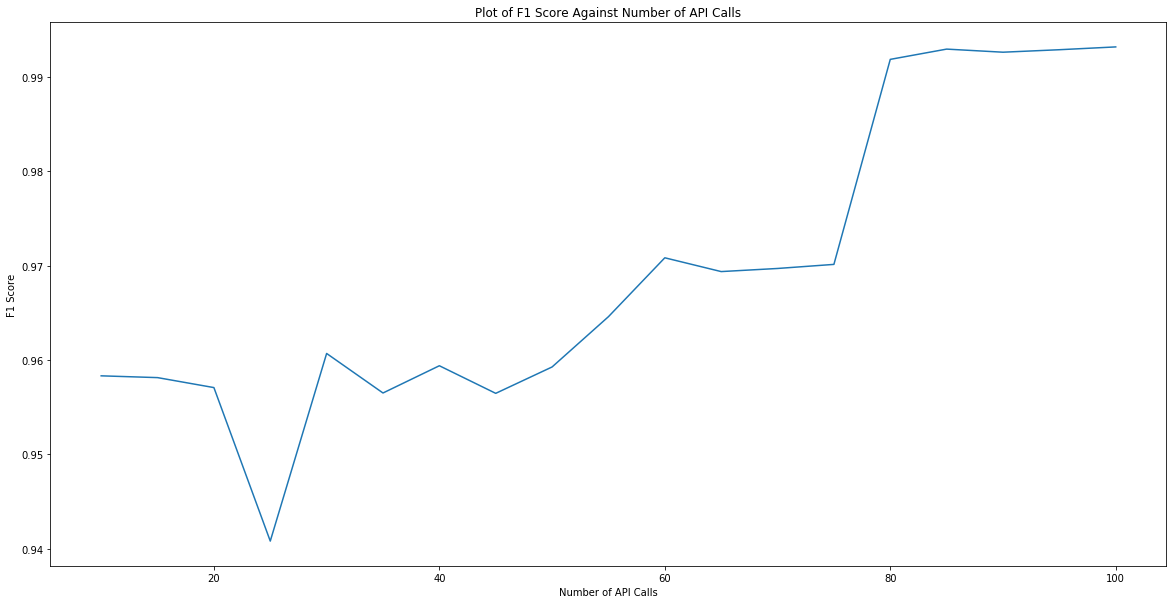

In [189]:
# plot graph of F1 score against number of API calls
x_range = list(range(10, 105, 5))
y_range = [i.split(', ') for i in list(dict_dataset1_numapicalls_results.values())]
y_range = [float(i[3]) for i in y_range]

plt.figure(figsize=(20,10))
plt.plot(x_range, y_range)
plt.xlabel('Number of API Calls')
plt.ylabel('F1 Score')
plt.title('Plot of F1 Score Against Number of API Calls')
plt.show()

In [191]:
final_model_dataset1 = dict_dataset1_numapicalls_models[80]
final_model_dataset1.save('final_model_dataset1.h5')
print('Final Model for Dataset 1 Saved')

Final Model for Dataset 1 Saved


## Testing on Dataset 2

Dataset 2 consists of the first 1000 API calls made when running a Windows executable. All examples provided in the dataset are malware, but they are split into 8 different categories based on their behaviour. This dataset was sourced from https://www.kaggle.com/focatak/malapi2019, and more details can be found in the paper at https://www.researchgate.net/publication/332877263_A_Benchmark_API_Call_Dataset_For_Windows_PE_Malware_Classification. A machine learning implementation is also detailed in a paper which is available at https://www.researchgate.net/publication/331974598_Classification_of_Methamorphic_Malware_with_Deep_Learning_LSTM.

In [220]:
path_to_dataset_2_X = '../Dataset2/mal-api-2019/1000_calls.txt'
X_dataset2 = []
with open(path_to_dataset_2_X, 'r') as infile:
    for line in infile:
        X_dataset2.append(np.array([int(i) for i in line.strip().split(',')]))
X_dataset2 = np.array(X_dataset2)
print('Shape of Dataset 2:', X_dataset2.shape)

Shape of Dataset 2: (7107,)


In [230]:
print('Example of Data:\n', X_dataset2[0])

Example of Data:
 [292 291 292 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291
 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291
 291 291 291 291 291 291 291 291 291 291 292 291 291 291 291 292 291 291
 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291
 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291
 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291
 291 291 292 291 291 291 292 291 291 291 292 291 291 291 291 291 291 291
 291 292 291 291 291 292 291 291 291 291 291 291 291 291 291 291 291 291
 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291
 292 291 291 291 291 292 291 291 291 291 291 291 291 292 291 291 291 291
 291 291 291 291 291 232 232 232 248 252 294 248 252 294 294  74  74  74
  74 317 192 192 317 317 317 317 317 317 317 317 317 317 317 317 317 317
 317 317 317 317 317 317 317 317 317 317 317 317 317 317 317 317 290 291
 290 291 291 291 291 291 291 291 

In [233]:
# check that api calls are numbered sequentially from 0
smallest_api_no = None
largest_api_no = None
for data in X_dataset2:
    if smallest_api_no == None:
        smallest_api_no = min(data)
    else:
        smallest_api_no = min(smallest_api_no, min(data))
    if largest_api_no == None:
        largest_api_no = max(data)
    else:
        largest_api_no = max(largest_api_no, max(data))
print('Smallest API Number:', smallest_api_no)
print('Largest API Number:', largest_api_no)
vocab_size_dataset2 = largest_api_no + 1

Smallest API Number: 1
Largest API Number: 340


Minimum Data Length: 10
Maximum Data Length: 1764421


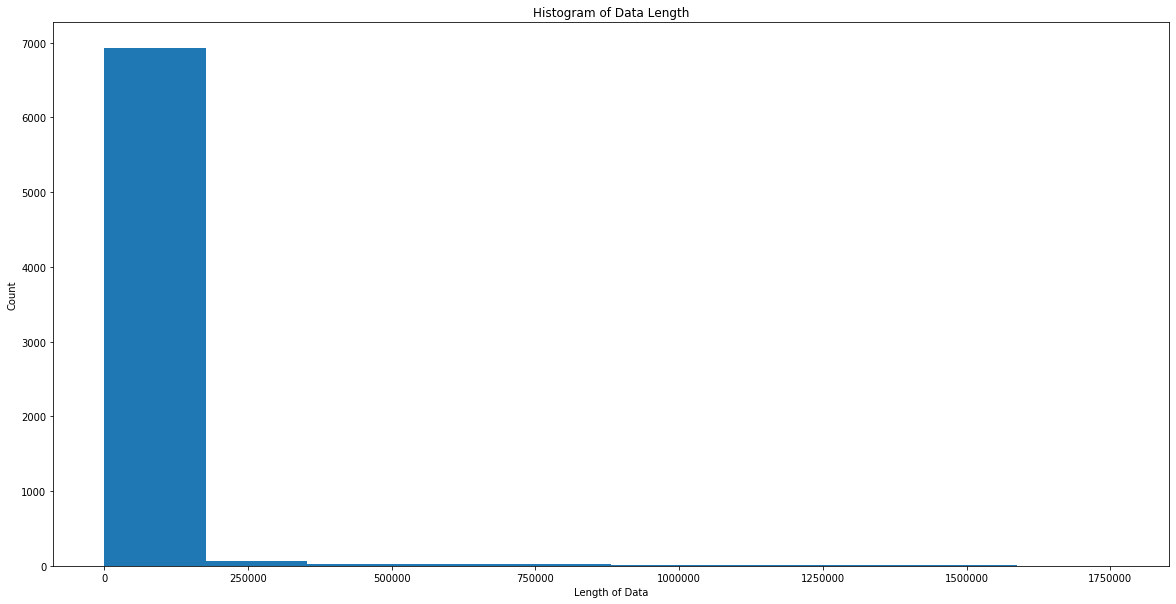

In [226]:
X_dataset2_lengths = [len(i) for i in X_dataset2]
print('Minimum Data Length:', min(X_dataset2_lengths))
print('Maximum Data Length:', max(X_dataset2_lengths))

plt.figure(figsize=(20,10))
plt.hist(X_dataset2_lengths)
plt.xlabel('Length of Data')
plt.ylabel('Count')
plt.title('Histogram of Data Length')
plt.show()

In [228]:
path_to_dataset_2_Y = '../Dataset2/labels.txt'
Y_dataset2 = []
with open(path_to_dataset_2_Y, 'r') as infile:
    for line in infile:
        Y_dataset2.append(line.strip())
Y_dataset2 = np.array(Y_dataset2)
assert len(Y_dataset2) == len(X_dataset2)

In [231]:
print('Example of Labels:\n', Y_dataset2[:10])

Example of Labels:
 ['Trojan' 'Trojan' 'Backdoor' 'Backdoor' 'Trojan' 'Trojan' 'Backdoor'
 'Backdoor' 'Downloader' 'Worms']


In [256]:
# remove data that has less than 80 API calls, ensure that remaining data has exactly 80 API calls
at_least_80_api_calls = [len(i)>=80 for i in X_dataset2]
X_trimmed_dataset2 = X_dataset2[at_least_80_api_calls]
X_trimmed_dataset2 = np.array([i[:80] for i in X_trimmed_dataset2])
Y_trimmed_dataset2 = Y_dataset2[at_least_80_api_calls]
assert len(X_trimmed_dataset2) == len(Y_trimmed_dataset2)

print('Shape of Trimmed Dataset 2:', X_trimmed_dataset2.shape)

Shape of Trimmed Dataset 2: (6286, 80)


In [257]:
# find number of unique labels and counts
label_counter = 0
label_conversion_dict = {}
label_count_dict = {}
for label in Y_trimmed_dataset2:
    if label in label_conversion_dict:
        label_count_dict[label] += 1
    else:
        label_conversion_dict[label] = label_counter
        label_count_dict[label] = 1
        label_counter += 1
print('Unique Labels and Counts:')
for label, count in list(label_count_dict.items()):
    print('\t' + label + ': ' + str(count))

# convert array based on values in dictionary
# https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key
Y_trimmed_dataset2 = np.vectorize(label_conversion_dict.get)(Y_trimmed_dataset2)

Unique Labels and Counts:
	Trojan: 931
	Backdoor: 932
	Downloader: 890
	Worms: 926
	Spyware: 767
	Adware: 334
	Dropper: 756
	Virus: 750


In [258]:
# split into train and test sets
X_train_dataset2, X_test_dataset2, Y_train_dataset2, Y_test_dataset2 = train_test_split(X_trimmed_dataset2,
                                                                                        Y_trimmed_dataset2,
                                                                                        test_size=0.2,
                                                                                        stratify=Y_trimmed_dataset2)
print('Train Data Shape:\n', X_train_dataset2.shape, '\n', Y_train_dataset2.shape)
print('Test Data Shape:\n', X_test_dataset2.shape, '\n', Y_test_dataset2.shape)

Train Data Shape:
 (5028, 80) 
 (5028,)
Test Data Shape:
 (1258, 80) 
 (1258,)


In [269]:
# ensure that dataset has sufficient amount of training data per class
print('Train Dataset:')
unique, counts = np.unique(Y_train_dataset2, return_counts=True)
for counter in range(len(unique)):
    print('\tClass ' + str(unique[counter]) + ': ' + str(counts[counter]) + ' Data Points')

print('\nTest Dataset:')
unique, counts = np.unique(Y_test_dataset2, return_counts=True)
for counter in range(len(unique)):
    print('\tClass ' + str(unique[counter]) + ': ' + str(counts[counter]) + ' Data Points')

Train Dataset:
	Class 0: 745 Data Points
	Class 1: 745 Data Points
	Class 2: 712 Data Points
	Class 3: 741 Data Points
	Class 4: 613 Data Points
	Class 5: 267 Data Points
	Class 6: 605 Data Points
	Class 7: 600 Data Points

Test Dataset:
	Class 0: 186 Data Points
	Class 1: 187 Data Points
	Class 2: 178 Data Points
	Class 3: 185 Data Points
	Class 4: 154 Data Points
	Class 5: 67 Data Points
	Class 6: 151 Data Points
	Class 7: 150 Data Points


In [275]:
# batch normalization and optimizer clipping were added to avoid exploding gradients
def generate_model_dataset2(num_layers, bidirectional, rnn_type, dropout_rate,
                            vocab_size, input_dim, hidden_dim, num_labels):
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hidden_dim, input_length=input_dim))
    
    if rnn_type == 'SimpleRNN':
        layer = SimpleRNN(units=hidden_dim, activation='tanh')
    elif rnn_type == 'LSTM':
        layer = LSTM(units=hidden_dim, activation='tanh')
    if bidirectional == True:
        layer = Bidirectional(layer)
    model.add(layer)
    model.add(BatchNormalization())
    if dropout_rate != 0:
        model.add(Dropout(dropout_rate))
        
    for _ in range(num_layers):
        model.add(Dense(units=hidden_dim, activation='tanh'))
    
    model.add(Dense(units=num_labels, activation='softmax'))
    optimizer = Adam(amsgrad=True)
    optimizer.clipnorm=1
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [283]:
# generate model and fit data, 100 epochs used to see where best loss value is obtained (early callback)
dataset2_initial = generate_model_dataset2(num_layers=0, bidirectional=False, rnn_type='LSTM',
                                           dropout_rate=0.5, vocab_size=vocab_size_dataset2, input_dim=80,
                                           hidden_dim=70, num_labels=label_counter)
dataset2_initial.fit(X_train_dataset2, Y_train_dataset2, batch_size=128, epochs=100,
                     verbose=1, callbacks = [EarlyStopping(monitor='loss', patience=3)])

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
5028/5028 [==============================] - 5s 896us/step - loss: 2.0913 - accuracy: 0.1860
Epoch 2/100
5028/5028 [==============================] - 4s 779us/step - loss: 1.9618 - accuracy: 0.2426
Epoch 3/100
5028/5028 [==============================] - 4s 775us/step - loss: 1.8998 - accuracy: 0.2647
Epoch 4/100
5028/5028 [==============================] - 4s 776us/step - loss: 1.8586 - accuracy: 0.2824
Epoch 5/100
5028/5028 [==============================] - 4s 778us/step - loss: 1.8356 - accuracy: 0.2876
Epoch 6/100
5028/5028 [==============================] - 4s 787us/step - loss: 1.8191 - accuracy: 0.3071
Epoch 7/100
5028/5028 [==============================] - 4s 779us/step - loss: 1.7941 - accuracy: 0.3136
Epoch 8/100
5028/5028 [==============================] - 4s 801us/step - loss: 1.7719 - accuracy: 0.3242
Epoch 9/100
5028/5028 [==============================] - 4s 800us/step - loss: 1.7654 - accuracy: 0.3234
Epoch 10/100
5028/5028 [==============================]

In [288]:
# test performance of baseline model on test data
print('Initial Results:')
dataset2_initial_results = compute_metrics(X_test_dataset2, Y_test_dataset2, dataset2_initial)

Initial Results:
Accuracy: 0.02941
Precision: 0.02482
Recall: 0.14439
F1 Score: 0.04235


## Hyperparameter Tuning

In [289]:
param_grid_dataset2 = {'num_layers': [0, 1, 2],
                       'bidirectional': [True, False],
                       'rnn_type': ['SimpleRNN', 'LSTM'],
                       'dropout_rate': [0.1, 0.2, 0.3, 0.5 ],
                       'vocab_size': [vocab_size_dataset2, ],
                       'input_dim': [80, ],
                       'hidden_dim': [30, 70, 100, 200],
                       'epochs': [100, ],
                       'num_labels': [label_counter, ]}

keras_classifier_dataset2 = KerasClassifier(generate_model_dataset2, batch_size=128)
validator_dataset2 = GridSearchCV(keras_classifier_dataset2,
                         param_grid=param_grid_dataset2, scoring='neg_log_loss', n_jobs=1)
validator_dataset2.fit(X_train_dataset2, Y_train_dataset2,
                       callbacks = [EarlyStopping(monitor='loss', patience=3)])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 421us/step - loss: 2.4164 - accuracy: 0.1587
Epoch 2/100
3352/3352 [==============================] - 1s 194us/step - loss: 2.0332 - accuracy: 0.2276
Epoch 3/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.8790 - accuracy: 0.2950
Epoch 4/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.7750 - accuracy: 0.3300
Epoch 5/100
3352/3352 [==============================] - 1s 192us/step - loss: 1.6893 - accuracy: 0.3619
Epoch 6/100
3352/3352 [==============================] - 1s 190us/step - loss: 1.6217 - accuracy: 0.3872
Epoch 7/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.5919 - accuracy: 0.3929
Epoch 8/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.5411 - accuracy: 0.4197
Epoch 9/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.5019 - accuracy: 0.4347
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 390us/step - loss: 2.2317 - accuracy: 0.1990
Epoch 2/100
3352/3352 [==============================] - 1s 191us/step - loss: 1.9635 - accuracy: 0.2604
Epoch 3/100
3352/3352 [==============================] - 1s 191us/step - loss: 1.8529 - accuracy: 0.3135
Epoch 4/100
3352/3352 [==============================] - 1s 190us/step - loss: 1.7531 - accuracy: 0.3353
Epoch 5/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.6861 - accuracy: 0.3729
Epoch 6/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.6034 - accuracy: 0.3887
Epoch 7/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.5699 - accuracy: 0.4036
Epoch 8/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.5401 - accuracy: 0.4215
Epoch 9/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.4854 - accuracy: 0.4374
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 390us/step - loss: 2.2987 - accuracy: 0.1751
Epoch 2/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.9703 - accuracy: 0.2521
Epoch 3/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.8704 - accuracy: 0.2906
Epoch 4/100
3352/3352 [==============================] - 1s 191us/step - loss: 1.8244 - accuracy: 0.3168
Epoch 5/100
3352/3352 [==============================] - 1s 192us/step - loss: 1.7282 - accuracy: 0.3476
Epoch 6/100
3352/3352 [==============================] - 1s 191us/step - loss: 1.6569 - accuracy: 0.3714
Epoch 7/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.6015 - accuracy: 0.3896
Epoch 8/100
3352/3352 [==============================] - 1s 192us/step - loss: 1.5588 - accuracy: 0.4078
Epoch 9/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.5164 - accuracy: 0.4275
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 675us/step - loss: 2.0359 - accuracy: 0.1906
Epoch 2/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.8907 - accuracy: 0.2810
Epoch 3/100
3352/3352 [==============================] - 1s 353us/step - loss: 1.8037 - accuracy: 0.3228
Epoch 4/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.7353 - accuracy: 0.3356
Epoch 5/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.6837 - accuracy: 0.3589
Epoch 6/100
3352/3352 [==============================] - 1s 349us/step - loss: 1.6503 - accuracy: 0.3756
Epoch 7/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.6213 - accuracy: 0.3783
Epoch 8/100
3352/3352 [==============================] - 1s 364us/step - loss: 1.5946 - accuracy: 0.3962
Epoch 9/100
3352/3352 [==============================] - 1s 406us/step - loss: 1.5743 - accuracy: 0.4010
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 674us/step - loss: 2.0263 - accuracy: 0.1841
Epoch 2/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.8716 - accuracy: 0.2786
Epoch 3/100
3352/3352 [==============================] - 1s 349us/step - loss: 1.7862 - accuracy: 0.3204
Epoch 4/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.7341 - accuracy: 0.3461
Epoch 5/100
3352/3352 [==============================] - 1s 350us/step - loss: 1.6806 - accuracy: 0.3675
Epoch 6/100
3352/3352 [==============================] - 1s 390us/step - loss: 1.6403 - accuracy: 0.3762
Epoch 7/100
3352/3352 [==============================] - 1s 348us/step - loss: 1.6051 - accuracy: 0.3998
Epoch 8/100
3352/3352 [==============================] - 1s 346us/step - loss: 1.5745 - accuracy: 0.3989
Epoch 9/100
3352/3352 [==============================] - 1s 346us/step - loss: 1.5612 - accuracy: 0.4126
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 656us/step - loss: 2.0194 - accuracy: 0.2058
Epoch 2/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.8879 - accuracy: 0.3010
Epoch 3/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.8068 - accuracy: 0.3147
Epoch 4/100
3352/3352 [==============================] - 1s 343us/step - loss: 1.7557 - accuracy: 0.3329
Epoch 5/100
3352/3352 [==============================] - 1s 346us/step - loss: 1.7065 - accuracy: 0.3404
Epoch 6/100
3352/3352 [==============================] - 1s 349us/step - loss: 1.6737 - accuracy: 0.3717
Epoch 7/100
3352/3352 [==============================] - 1s 342us/step - loss: 1.6330 - accuracy: 0.3720
Epoch 8/100
3352/3352 [==============================] - 1s 340us/step - loss: 1.6236 - accuracy: 0.3860
Epoch 9/100
3352/3352 [==============================] - 1s 345us/step - loss: 1.5974 - accuracy: 0.3950
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 414us/step - loss: 2.1401 - accuracy: 0.1760
Epoch 2/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.9152 - accuracy: 0.2685
Epoch 3/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.8156 - accuracy: 0.2986
Epoch 4/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.7474 - accuracy: 0.3383
Epoch 5/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.6760 - accuracy: 0.3705
Epoch 6/100
3352/3352 [==============================] - 1s 192us/step - loss: 1.6235 - accuracy: 0.3866
Epoch 7/100
3352/3352 [==============================] - 1s 203us/step - loss: 1.5895 - accuracy: 0.4156
Epoch 8/100
3352/3352 [==============================] - 1s 213us/step - loss: 1.5540 - accuracy: 0.4326
Epoch 9/100
3352/3352 [==============================] - 1s 227us/step - loss: 1.5258 - accuracy: 0.4296
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 411us/step - loss: 2.0903 - accuracy: 0.1921
Epoch 2/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.9137 - accuracy: 0.2551
Epoch 3/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.8195 - accuracy: 0.3013
Epoch 4/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.7407 - accuracy: 0.3431
Epoch 5/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.6716 - accuracy: 0.3747
Epoch 6/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.6154 - accuracy: 0.4024
Epoch 7/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.5728 - accuracy: 0.4132
Epoch 8/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.5509 - accuracy: 0.4299
Epoch 9/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.5168 - accuracy: 0.4481
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 405us/step - loss: 2.1428 - accuracy: 0.1608
Epoch 2/100
3352/3352 [==============================] - 1s 192us/step - loss: 1.9142 - accuracy: 0.2631
Epoch 3/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.8081 - accuracy: 0.3132
Epoch 4/100
3352/3352 [==============================] - 1s 198us/step - loss: 1.7260 - accuracy: 0.3487
Epoch 5/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.6727 - accuracy: 0.3646
Epoch 6/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.6279 - accuracy: 0.3837
Epoch 7/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.5803 - accuracy: 0.4156
Epoch 8/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.5399 - accuracy: 0.4221
Epoch 9/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.5158 - accuracy: 0.4439
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 695us/step - loss: 2.0159 - accuracy: 0.2178
Epoch 2/100
3352/3352 [==============================] - 1s 366us/step - loss: 1.8684 - accuracy: 0.2995
Epoch 3/100
3352/3352 [==============================] - 1s 345us/step - loss: 1.7710 - accuracy: 0.3386
Epoch 4/100
3352/3352 [==============================] - 1s 346us/step - loss: 1.7210 - accuracy: 0.3440
Epoch 5/100
3352/3352 [==============================] - 1s 343us/step - loss: 1.6762 - accuracy: 0.3634
Epoch 6/100
3352/3352 [==============================] - 1s 347us/step - loss: 1.6322 - accuracy: 0.3905
Epoch 7/100
3352/3352 [==============================] - 1s 347us/step - loss: 1.5988 - accuracy: 0.3935
Epoch 8/100
3352/3352 [==============================] - 1s 349us/step - loss: 1.5806 - accuracy: 0.4063
Epoch 9/100
3352/3352 [==============================] - 1s 350us/step - loss: 1.5608 - accuracy: 0.4090
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 677us/step - loss: 2.0407 - accuracy: 0.2023
Epoch 2/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.8952 - accuracy: 0.2733
Epoch 3/100
3352/3352 [==============================] - 1s 344us/step - loss: 1.7977 - accuracy: 0.3210
Epoch 4/100
3352/3352 [==============================] - 1s 348us/step - loss: 1.7302 - accuracy: 0.3425
Epoch 5/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.6815 - accuracy: 0.3717
Epoch 6/100
3352/3352 [==============================] - 1s 348us/step - loss: 1.6337 - accuracy: 0.3848
Epoch 7/100
3352/3352 [==============================] - 1s 345us/step - loss: 1.6068 - accuracy: 0.3956
Epoch 8/100
3352/3352 [==============================] - 1s 346us/step - loss: 1.5797 - accuracy: 0.4168
Epoch 9/100
3352/3352 [==============================] - 1s 338us/step - loss: 1.5523 - accuracy: 0.4218
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 676us/step - loss: 2.0322 - accuracy: 0.1948
Epoch 2/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.9011 - accuracy: 0.2837
Epoch 3/100
3352/3352 [==============================] - 1s 347us/step - loss: 1.8162 - accuracy: 0.3153
Epoch 4/100
3352/3352 [==============================] - 1s 350us/step - loss: 1.7552 - accuracy: 0.3285
Epoch 5/100
3352/3352 [==============================] - 1s 348us/step - loss: 1.7051 - accuracy: 0.3589
Epoch 6/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.6643 - accuracy: 0.3744
Epoch 7/100
3352/3352 [==============================] - 1s 347us/step - loss: 1.6369 - accuracy: 0.3813
Epoch 8/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.6133 - accuracy: 0.3941
Epoch 9/100
3352/3352 [==============================] - 1s 345us/step - loss: 1.5964 - accuracy: 0.3932
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 427us/step - loss: 2.0740 - accuracy: 0.1859
Epoch 2/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.9199 - accuracy: 0.2595
Epoch 3/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.8239 - accuracy: 0.3132
Epoch 4/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.7498 - accuracy: 0.3443
Epoch 5/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.6951 - accuracy: 0.3601
Epoch 6/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.6626 - accuracy: 0.3741
Epoch 7/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.6123 - accuracy: 0.3953
Epoch 8/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.5769 - accuracy: 0.4197
Epoch 9/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.5480 - accuracy: 0.4168
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 430us/step - loss: 2.0722 - accuracy: 0.1939
Epoch 2/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.8699 - accuracy: 0.2879
Epoch 3/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.7648 - accuracy: 0.3401
Epoch 4/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.6938 - accuracy: 0.3607
Epoch 5/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.6380 - accuracy: 0.3860
Epoch 6/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.5941 - accuracy: 0.4007
Epoch 7/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.5489 - accuracy: 0.4284
Epoch 8/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.5120 - accuracy: 0.4418
Epoch 9/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.4796 - accuracy: 0.4478
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 422us/step - loss: 2.0676 - accuracy: 0.1894
Epoch 2/100
3352/3352 [==============================] - 1s 191us/step - loss: 1.9392 - accuracy: 0.2527
Epoch 3/100
3352/3352 [==============================] - 1s 191us/step - loss: 1.8480 - accuracy: 0.3061
Epoch 4/100
3352/3352 [==============================] - 1s 191us/step - loss: 1.7872 - accuracy: 0.3368
Epoch 5/100
3352/3352 [==============================] - 1s 191us/step - loss: 1.7102 - accuracy: 0.3595
Epoch 6/100
3352/3352 [==============================] - 1s 190us/step - loss: 1.6758 - accuracy: 0.3768
Epoch 7/100
3352/3352 [==============================] - 1s 190us/step - loss: 1.6141 - accuracy: 0.4129
Epoch 8/100
3352/3352 [==============================] - 1s 190us/step - loss: 1.5883 - accuracy: 0.4171
Epoch 9/100
3352/3352 [==============================] - 1s 190us/step - loss: 1.5571 - accuracy: 0.4296
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 707us/step - loss: 2.0341 - accuracy: 0.2005
Epoch 2/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.8916 - accuracy: 0.2798
Epoch 3/100
3352/3352 [==============================] - 1s 360us/step - loss: 1.7942 - accuracy: 0.3213
Epoch 4/100
3352/3352 [==============================] - 1s 352us/step - loss: 1.7222 - accuracy: 0.3511
Epoch 5/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.6727 - accuracy: 0.3658
Epoch 6/100
3352/3352 [==============================] - 1s 353us/step - loss: 1.6346 - accuracy: 0.3825
Epoch 7/100
3352/3352 [==============================] - 1s 349us/step - loss: 1.6115 - accuracy: 0.3929
Epoch 8/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.5886 - accuracy: 0.4001
Epoch 9/100
3352/3352 [==============================] - 1s 382us/step - loss: 1.5764 - accuracy: 0.4090
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 691us/step - loss: 2.0263 - accuracy: 0.2035
Epoch 2/100
3352/3352 [==============================] - 1s 357us/step - loss: 1.8754 - accuracy: 0.2945
Epoch 3/100
3352/3352 [==============================] - 1s 353us/step - loss: 1.7851 - accuracy: 0.3222
Epoch 4/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.7223 - accuracy: 0.3464
Epoch 5/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.6563 - accuracy: 0.3819
Epoch 6/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.6161 - accuracy: 0.3974
Epoch 7/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.5884 - accuracy: 0.3947
Epoch 8/100
3352/3352 [==============================] - 1s 349us/step - loss: 1.5586 - accuracy: 0.4135
Epoch 9/100
3352/3352 [==============================] - 1s 349us/step - loss: 1.5383 - accuracy: 0.4251
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 695us/step - loss: 2.0127 - accuracy: 0.2151
Epoch 2/100
3352/3352 [==============================] - 1s 352us/step - loss: 1.8809 - accuracy: 0.2828
Epoch 3/100
3352/3352 [==============================] - 1s 350us/step - loss: 1.7976 - accuracy: 0.3198
Epoch 4/100
3352/3352 [==============================] - 1s 350us/step - loss: 1.7454 - accuracy: 0.3404
Epoch 5/100
3352/3352 [==============================] - 1s 339us/step - loss: 1.6998 - accuracy: 0.3487
Epoch 6/100
3352/3352 [==============================] - 1s 386us/step - loss: 1.6731 - accuracy: 0.3690
Epoch 7/100
3352/3352 [==============================] - 1s 424us/step - loss: 1.6446 - accuracy: 0.3750
Epoch 8/100
3352/3352 [==============================] - 1s 415us/step - loss: 1.6173 - accuracy: 0.3914
Epoch 9/100
3352/3352 [==============================] - 1s 392us/step - loss: 1.5964 - accuracy: 0.4021
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 507us/step - loss: 2.3007 - accuracy: 0.1891
Epoch 2/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.9009 - accuracy: 0.2894
Epoch 3/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.7097 - accuracy: 0.3634
Epoch 4/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.5614 - accuracy: 0.4132
Epoch 5/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.4749 - accuracy: 0.4514
Epoch 6/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.3924 - accuracy: 0.4815
Epoch 7/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.3381 - accuracy: 0.4961
Epoch 8/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.2902 - accuracy: 0.5143
Epoch 9/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.2553 - accuracy: 0.5313
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 520us/step - loss: 2.2235 - accuracy: 0.2047
Epoch 2/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.8679 - accuracy: 0.3019
Epoch 3/100
3352/3352 [==============================] - 1s 306us/step - loss: 1.7387 - accuracy: 0.3487
Epoch 4/100
3352/3352 [==============================] - 1s 301us/step - loss: 1.6352 - accuracy: 0.3774
Epoch 5/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.5397 - accuracy: 0.4138
Epoch 6/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.4894 - accuracy: 0.4400
Epoch 7/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.4180 - accuracy: 0.4672
Epoch 8/100
3352/3352 [==============================] - 1s 299us/step - loss: 1.3468 - accuracy: 0.4916
Epoch 9/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.3097 - accuracy: 0.5095
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 513us/step - loss: 2.2212 - accuracy: 0.1972
Epoch 2/100
3352/3352 [==============================] - 1s 301us/step - loss: 1.8896 - accuracy: 0.2891
Epoch 3/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.7474 - accuracy: 0.3529
Epoch 4/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.6161 - accuracy: 0.4010
Epoch 5/100
3352/3352 [==============================] - 1s 299us/step - loss: 1.5149 - accuracy: 0.4427
Epoch 6/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.4395 - accuracy: 0.4666
Epoch 7/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.3852 - accuracy: 0.4764
Epoch 8/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.3288 - accuracy: 0.5048
Epoch 9/100
3352/3352 [==============================] - 1s 301us/step - loss: 1.2905 - accuracy: 0.5209
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0004 - accuracy: 0.2309
Epoch 2/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.8041 - accuracy: 0.3237
Epoch 3/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.7082 - accuracy: 0.3571
Epoch 4/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6332 - accuracy: 0.3854
Epoch 5/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.5962 - accuracy: 0.3950
Epoch 6/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.5668 - accuracy: 0.4004
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5389 - accuracy: 0.4183
Epoch 8/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5045 - accuracy: 0.4245
Epoch 9/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.4917 - accuracy: 0.4320
Epoch 10/100
3352/3352 [==============================] - 5s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.9602 - accuracy: 0.2411
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7749 - accuracy: 0.3320
Epoch 3/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6852 - accuracy: 0.3628
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6158 - accuracy: 0.3881
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5663 - accuracy: 0.4048
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5434 - accuracy: 0.4153
Epoch 7/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5111 - accuracy: 0.4314
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4941 - accuracy: 0.4433
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4726 - accuracy: 0.4430
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.9889 - accuracy: 0.2223
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8123 - accuracy: 0.3121
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7205 - accuracy: 0.3431
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6578 - accuracy: 0.3762
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6169 - accuracy: 0.3848
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5811 - accuracy: 0.4045
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5516 - accuracy: 0.4162
Epoch 8/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5203 - accuracy: 0.4189
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4972 - accuracy: 0.4326
Epoch 10/100
3352/3352 [==============================] - 5s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 541us/step - loss: 2.1106 - accuracy: 0.2014
Epoch 2/100
3352/3352 [==============================] - 1s 316us/step - loss: 1.8172 - accuracy: 0.3076
Epoch 3/100
3352/3352 [==============================] - 1s 314us/step - loss: 1.7119 - accuracy: 0.3550
Epoch 4/100
3352/3352 [==============================] - 1s 313us/step - loss: 1.6049 - accuracy: 0.4054
Epoch 5/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.5341 - accuracy: 0.4212
Epoch 6/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.4657 - accuracy: 0.4588
Epoch 7/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.4101 - accuracy: 0.4746
Epoch 8/100
3352/3352 [==============================] - 1s 308us/step - loss: 1.3582 - accuracy: 0.5027
Epoch 9/100
3352/3352 [==============================] - 1s 308us/step - loss: 1.3039 - accuracy: 0.5176
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 533us/step - loss: 2.1250 - accuracy: 0.1668
Epoch 2/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.9260 - accuracy: 0.2554
Epoch 3/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.7644 - accuracy: 0.3285
Epoch 4/100
3352/3352 [==============================] - 1s 307us/step - loss: 1.6592 - accuracy: 0.3884
Epoch 5/100
3352/3352 [==============================] - 1s 308us/step - loss: 1.5652 - accuracy: 0.4230
Epoch 6/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.4720 - accuracy: 0.4570
Epoch 7/100
3352/3352 [==============================] - 1s 314us/step - loss: 1.4092 - accuracy: 0.4749
Epoch 8/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.3510 - accuracy: 0.4982
Epoch 9/100
3352/3352 [==============================] - 2s 450us/step - loss: 1.3072 - accuracy: 0.5245
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 535us/step - loss: 2.1011 - accuracy: 0.2026
Epoch 2/100
3352/3352 [==============================] - 1s 314us/step - loss: 1.8019 - accuracy: 0.3144
Epoch 3/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.6642 - accuracy: 0.3768
Epoch 4/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.5443 - accuracy: 0.4290
Epoch 5/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.4635 - accuracy: 0.4636
Epoch 6/100
3352/3352 [==============================] - 1s 308us/step - loss: 1.4100 - accuracy: 0.4827
Epoch 7/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.3358 - accuracy: 0.5143
Epoch 8/100
3352/3352 [==============================] - 1s 308us/step - loss: 1.2937 - accuracy: 0.5361
Epoch 9/100
3352/3352 [==============================] - 1s 308us/step - loss: 1.2555 - accuracy: 0.5352
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.9892 - accuracy: 0.2306
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7831 - accuracy: 0.3323
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6842 - accuracy: 0.3604
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6316 - accuracy: 0.3792
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5855 - accuracy: 0.3935
Epoch 6/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5561 - accuracy: 0.4111
Epoch 7/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5253 - accuracy: 0.4165
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5061 - accuracy: 0.4341
Epoch 9/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.4827 - accuracy: 0.4290
Epoch 10/100
3352/3352 [==============================] - 5s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.9658 - accuracy: 0.2396
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7580 - accuracy: 0.3341
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6612 - accuracy: 0.3753
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5886 - accuracy: 0.3962
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5474 - accuracy: 0.4236
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5177 - accuracy: 0.4254
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4874 - accuracy: 0.4356
Epoch 8/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.4646 - accuracy: 0.4541
Epoch 9/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.4377 - accuracy: 0.4582
Epoch 10/100
3352/3352 [==============================] - 5s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.9720 - accuracy: 0.2309
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7986 - accuracy: 0.3070
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6955 - accuracy: 0.3577
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6422 - accuracy: 0.3753
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5948 - accuracy: 0.3926
Epoch 6/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5503 - accuracy: 0.4123
Epoch 7/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5364 - accuracy: 0.4174
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5129 - accuracy: 0.4335
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4758 - accuracy: 0.4466
Epoch 10/100
3352/3352 [==============================] - 5s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 564us/step - loss: 2.0320 - accuracy: 0.2085
Epoch 2/100
3352/3352 [==============================] - 1s 321us/step - loss: 1.7961 - accuracy: 0.3165
Epoch 3/100
3352/3352 [==============================] - 1s 325us/step - loss: 1.6383 - accuracy: 0.3923
Epoch 4/100
3352/3352 [==============================] - 1s 322us/step - loss: 1.5424 - accuracy: 0.4206
Epoch 5/100
3352/3352 [==============================] - 1s 326us/step - loss: 1.4649 - accuracy: 0.4591
Epoch 6/100
3352/3352 [==============================] - 1s 324us/step - loss: 1.3911 - accuracy: 0.4908
Epoch 7/100
3352/3352 [==============================] - 1s 325us/step - loss: 1.3424 - accuracy: 0.5101
Epoch 8/100
3352/3352 [==============================] - 1s 325us/step - loss: 1.2778 - accuracy: 0.5334
Epoch 9/100
3352/3352 [==============================] - 1s 323us/step - loss: 1.2414 - accuracy: 0.5361
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 571us/step - loss: 2.0150 - accuracy: 0.2312
Epoch 2/100
3352/3352 [==============================] - 1s 336us/step - loss: 1.7503 - accuracy: 0.3434
Epoch 3/100
3352/3352 [==============================] - 1s 325us/step - loss: 1.6077 - accuracy: 0.3920
Epoch 4/100
3352/3352 [==============================] - 1s 324us/step - loss: 1.5264 - accuracy: 0.4284
Epoch 5/100
3352/3352 [==============================] - 1s 320us/step - loss: 1.4468 - accuracy: 0.4642
Epoch 6/100
3352/3352 [==============================] - 1s 321us/step - loss: 1.3768 - accuracy: 0.4931
Epoch 7/100
3352/3352 [==============================] - 1s 323us/step - loss: 1.3271 - accuracy: 0.5113
Epoch 8/100
3352/3352 [==============================] - 1s 319us/step - loss: 1.2767 - accuracy: 0.5307
Epoch 9/100
3352/3352 [==============================] - 1s 320us/step - loss: 1.2377 - accuracy: 0.5439
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 572us/step - loss: 2.0277 - accuracy: 0.2267
Epoch 2/100
3352/3352 [==============================] - 1s 326us/step - loss: 1.8045 - accuracy: 0.3186
Epoch 3/100
3352/3352 [==============================] - 1s 333us/step - loss: 1.6746 - accuracy: 0.3804
Epoch 4/100
3352/3352 [==============================] - 1s 333us/step - loss: 1.5719 - accuracy: 0.4236
Epoch 5/100
3352/3352 [==============================] - 1s 323us/step - loss: 1.4858 - accuracy: 0.4558
Epoch 6/100
3352/3352 [==============================] - 1s 329us/step - loss: 1.4027 - accuracy: 0.4872
Epoch 7/100
3352/3352 [==============================] - 1s 319us/step - loss: 1.3569 - accuracy: 0.5033
Epoch 8/100
3352/3352 [==============================] - 1s 322us/step - loss: 1.3209 - accuracy: 0.5170
Epoch 9/100
3352/3352 [==============================] - 1s 322us/step - loss: 1.2785 - accuracy: 0.5274
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9767 - accuracy: 0.2378
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7691 - accuracy: 0.3201
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6794 - accuracy: 0.3610
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6262 - accuracy: 0.3875
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5824 - accuracy: 0.4177
Epoch 6/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5474 - accuracy: 0.4168
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5151 - accuracy: 0.4332
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4969 - accuracy: 0.4362
Epoch 9/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.4806 - accuracy: 0.4338
Epoch 10/100
3352/3352 [==============================] - 5s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9664 - accuracy: 0.2419
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7698 - accuracy: 0.3291
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6732 - accuracy: 0.3714
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6152 - accuracy: 0.3953
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5734 - accuracy: 0.4171
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5314 - accuracy: 0.4284
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.4988 - accuracy: 0.4421
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4753 - accuracy: 0.4457
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4597 - accuracy: 0.4529
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9871 - accuracy: 0.2139
Epoch 2/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.8004 - accuracy: 0.3153
Epoch 3/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.7139 - accuracy: 0.3407
Epoch 4/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6502 - accuracy: 0.3753
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6012 - accuracy: 0.3884
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5669 - accuracy: 0.4084
Epoch 7/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5283 - accuracy: 0.4335
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5175 - accuracy: 0.4350
Epoch 9/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.4882 - accuracy: 0.4391
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 627us/step - loss: 2.2351 - accuracy: 0.2044
Epoch 2/100
3352/3352 [==============================] - 1s 405us/step - loss: 1.8230 - accuracy: 0.3246
Epoch 3/100
3352/3352 [==============================] - 1s 405us/step - loss: 1.6735 - accuracy: 0.3759
Epoch 4/100
3352/3352 [==============================] - 1s 408us/step - loss: 1.5915 - accuracy: 0.3956
Epoch 5/100
3352/3352 [==============================] - 1s 404us/step - loss: 1.5591 - accuracy: 0.4218
Epoch 6/100
3352/3352 [==============================] - 1s 403us/step - loss: 1.4785 - accuracy: 0.4427
Epoch 7/100
3352/3352 [==============================] - 1s 407us/step - loss: 1.4380 - accuracy: 0.4600
Epoch 8/100
3352/3352 [==============================] - 1s 404us/step - loss: 1.4237 - accuracy: 0.4645
Epoch 9/100
3352/3352 [==============================] - 1s 406us/step - loss: 1.3653 - accuracy: 0.4893
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 630us/step - loss: 2.2251 - accuracy: 0.1891
Epoch 2/100
3352/3352 [==============================] - 1s 415us/step - loss: 1.8999 - accuracy: 0.2936
Epoch 3/100
3352/3352 [==============================] - 1s 407us/step - loss: 1.7537 - accuracy: 0.3511
Epoch 4/100
3352/3352 [==============================] - 1s 402us/step - loss: 1.5955 - accuracy: 0.4045
Epoch 5/100
3352/3352 [==============================] - 1s 410us/step - loss: 1.4869 - accuracy: 0.4484
Epoch 6/100
3352/3352 [==============================] - 1s 410us/step - loss: 1.4083 - accuracy: 0.4770
Epoch 7/100
3352/3352 [==============================] - 1s 406us/step - loss: 1.3283 - accuracy: 0.5024
Epoch 8/100
3352/3352 [==============================] - 1s 404us/step - loss: 1.2929 - accuracy: 0.5161
Epoch 9/100
3352/3352 [==============================] - 1s 408us/step - loss: 1.2327 - accuracy: 0.5352
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 639us/step - loss: 2.2263 - accuracy: 0.1942
Epoch 2/100
3352/3352 [==============================] - 1s 414us/step - loss: 1.9102 - accuracy: 0.28580s - loss: 1.9141 - accuracy: 
Epoch 3/100
3352/3352 [==============================] - 1s 420us/step - loss: 1.7417 - accuracy: 0.3437
Epoch 4/100
3352/3352 [==============================] - 1s 416us/step - loss: 1.6217 - accuracy: 0.4024
Epoch 5/100
3352/3352 [==============================] - 1s 411us/step - loss: 1.4952 - accuracy: 0.4418
Epoch 6/100
3352/3352 [==============================] - 1s 414us/step - loss: 1.3974 - accuracy: 0.4702
Epoch 7/100
3352/3352 [==============================] - 1s 408us/step - loss: 1.3365 - accuracy: 0.5021
Epoch 8/100
3352/3352 [==============================] - 1s 410us/step - loss: 1.2740 - accuracy: 0.5274
Epoch 9/100
3352/3352 [==============================] - 1s 407us/step - loss: 1.2377 - accuracy: 0.5447
Epoch 10/100
3352/3352 [=

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9688 - accuracy: 0.2425
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7740 - accuracy: 0.3270
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6779 - accuracy: 0.3604
Epoch 4/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.6264 - accuracy: 0.3798
Epoch 5/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.5854 - accuracy: 0.3905
Epoch 6/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.5475 - accuracy: 0.4066
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5094 - accuracy: 0.4272
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4877 - accuracy: 0.4350
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4686 - accuracy: 0.4448
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.9489 - accuracy: 0.2569
Epoch 2/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.7447 - accuracy: 0.3464
Epoch 3/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.6637 - accuracy: 0.3738
Epoch 4/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5981 - accuracy: 0.4001
Epoch 5/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.5563 - accuracy: 0.4135
Epoch 6/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.5189 - accuracy: 0.4260
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4837 - accuracy: 0.4496
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4523 - accuracy: 0.4481
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4380 - accuracy: 0.4621
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9700 - accuracy: 0.2467
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7716 - accuracy: 0.3264
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6916 - accuracy: 0.3601
Epoch 4/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6262 - accuracy: 0.3813
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5856 - accuracy: 0.3914
Epoch 6/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.5565 - accuracy: 0.4153
Epoch 7/100
3352/3352 [==============================] - 8s 3ms/step - loss: 1.5170 - accuracy: 0.4266
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4942 - accuracy: 0.4418
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4788 - accuracy: 0.4418
Epoch 10/100
3352/3352 [==============================] - 5s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 646us/step - loss: 2.0500 - accuracy: 0.2142
Epoch 2/100
3352/3352 [==============================] - 1s 408us/step - loss: 1.7736 - accuracy: 0.3246
Epoch 3/100
3352/3352 [==============================] - 1s 404us/step - loss: 1.6142 - accuracy: 0.3863
Epoch 4/100
3352/3352 [==============================] - 1s 410us/step - loss: 1.4975 - accuracy: 0.4371
Epoch 5/100
3352/3352 [==============================] - 1s 406us/step - loss: 1.4118 - accuracy: 0.4791
Epoch 6/100
3352/3352 [==============================] - 1s 409us/step - loss: 1.3471 - accuracy: 0.4961
Epoch 7/100
3352/3352 [==============================] - 1s 405us/step - loss: 1.2712 - accuracy: 0.5313
Epoch 8/100
3352/3352 [==============================] - 1s 408us/step - loss: 1.2191 - accuracy: 0.5552
Epoch 9/100
3352/3352 [==============================] - 1s 400us/step - loss: 1.1807 - accuracy: 0.5683
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 645us/step - loss: 2.0532 - accuracy: 0.2243
Epoch 2/100
3352/3352 [==============================] - 1s 421us/step - loss: 1.8214 - accuracy: 0.3177
Epoch 3/100
3352/3352 [==============================] - 1s 413us/step - loss: 1.6803 - accuracy: 0.3672
Epoch 4/100
3352/3352 [==============================] - 1s 410us/step - loss: 1.6109 - accuracy: 0.3935
Epoch 5/100
3352/3352 [==============================] - 1s 410us/step - loss: 1.5048 - accuracy: 0.4403
Epoch 6/100
3352/3352 [==============================] - 1s 407us/step - loss: 1.4069 - accuracy: 0.4732
Epoch 7/100
3352/3352 [==============================] - 1s 407us/step - loss: 1.3381 - accuracy: 0.5033
Epoch 8/100
3352/3352 [==============================] - 1s 410us/step - loss: 1.2753 - accuracy: 0.5307
Epoch 9/100
3352/3352 [==============================] - 1s 415us/step - loss: 1.2264 - accuracy: 0.5409
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 660us/step - loss: 2.0783 - accuracy: 0.2127
Epoch 2/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.8447 - accuracy: 0.2953
Epoch 3/100
3352/3352 [==============================] - 1s 417us/step - loss: 1.7050 - accuracy: 0.3562
Epoch 4/100
3352/3352 [==============================] - 1s 412us/step - loss: 1.5869 - accuracy: 0.4171
Epoch 5/100
3352/3352 [==============================] - 1s 417us/step - loss: 1.4947 - accuracy: 0.4394
Epoch 6/100
3352/3352 [==============================] - 1s 412us/step - loss: 1.4033 - accuracy: 0.4836
Epoch 7/100
3352/3352 [==============================] - 1s 412us/step - loss: 1.3225 - accuracy: 0.5161
Epoch 8/100
3352/3352 [==============================] - 1s 417us/step - loss: 1.2605 - accuracy: 0.5436
Epoch 9/100
3352/3352 [==============================] - 1s 408us/step - loss: 1.1856 - accuracy: 0.5713
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9592 - accuracy: 0.2506
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7525 - accuracy: 0.3359
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6566 - accuracy: 0.3774
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5910 - accuracy: 0.3953
Epoch 5/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.5616 - accuracy: 0.3956
Epoch 6/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.5285 - accuracy: 0.4138
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5019 - accuracy: 0.4388
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4660 - accuracy: 0.4421
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4534 - accuracy: 0.4523
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - 

3352/3352 [==============================] - 6s 2ms/step - loss: 0.8775 - accuracy: 0.6644
Epoch 80/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8808 - accuracy: 0.6590
Epoch 81/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8581 - accuracy: 0.6665
Epoch 82/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8672 - accuracy: 0.6700
Epoch 83/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8637 - accuracy: 0.6653
Epoch 84/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8487 - accuracy: 0.6644
Epoch 85/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.8578 - accuracy: 0.6686
Epoch 86/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.8440 - accuracy: 0.6727
Epoch 87/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8407 - accuracy: 0.6683
Epoch 88/100
3352/3352 [==============================] - 6s 2ms/step - loss:

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9542 - accuracy: 0.2601
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7197 - accuracy: 0.3410
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6396 - accuracy: 0.3678
Epoch 4/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5847 - accuracy: 0.4069
Epoch 5/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5460 - accuracy: 0.4180
Epoch 6/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.5174 - accuracy: 0.4257
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4734 - accuracy: 0.4344
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4467 - accuracy: 0.4603
Epoch 9/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.4316 - accuracy: 0.4582
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9661 - accuracy: 0.2521
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7644 - accuracy: 0.3338
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6756 - accuracy: 0.3583
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6123 - accuracy: 0.3896
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5733 - accuracy: 0.3920
Epoch 6/100
3352/3352 [==============================] - 8s 3ms/step - loss: 1.5346 - accuracy: 0.4192
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5010 - accuracy: 0.4269
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4770 - accuracy: 0.4347
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4491 - accuracy: 0.4541
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

3352/3352 [==============================] - 6s 2ms/step - loss: 0.9228 - accuracy: 0.6477
Epoch 80/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9103 - accuracy: 0.6489
Epoch 81/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9085 - accuracy: 0.6524
Epoch 82/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9037 - accuracy: 0.6513
Epoch 83/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8976 - accuracy: 0.6644
Epoch 84/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8926 - accuracy: 0.6644
Epoch 85/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9013 - accuracy: 0.6566
Epoch 86/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8875 - accuracy: 0.6584
Epoch 87/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8675 - accuracy: 0.6689
Epoch 88/100
3352/3352 [==============================] - 6s 2ms/step - loss:

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 666us/step - loss: 2.0165 - accuracy: 0.2360
Epoch 2/100
3352/3352 [==============================] - 1s 419us/step - loss: 1.7573 - accuracy: 0.3356
Epoch 3/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.5835 - accuracy: 0.4147
Epoch 4/100
3352/3352 [==============================] - 1s 416us/step - loss: 1.4809 - accuracy: 0.4499
Epoch 5/100
3352/3352 [==============================] - 1s 416us/step - loss: 1.3801 - accuracy: 0.4943
Epoch 6/100
3352/3352 [==============================] - 1s 415us/step - loss: 1.3033 - accuracy: 0.5173
Epoch 7/100
3352/3352 [==============================] - 1s 417us/step - loss: 1.2408 - accuracy: 0.5391
Epoch 8/100
3352/3352 [==============================] - 1s 419us/step - loss: 1.2035 - accuracy: 0.5561
Epoch 9/100
3352/3352 [==============================] - 1s 414us/step - loss: 1.1592 - accuracy: 0.5683
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 686us/step - loss: 1.9815 - accuracy: 0.2288
Epoch 2/100
3352/3352 [==============================] - 1s 446us/step - loss: 1.7218 - accuracy: 0.3458
Epoch 3/100
3352/3352 [==============================] - 1s 431us/step - loss: 1.5560 - accuracy: 0.4236
Epoch 4/100
3352/3352 [==============================] - 1s 433us/step - loss: 1.4515 - accuracy: 0.4615
Epoch 5/100
3352/3352 [==============================] - 1s 419us/step - loss: 1.3704 - accuracy: 0.4899
Epoch 6/100
3352/3352 [==============================] - 1s 424us/step - loss: 1.2854 - accuracy: 0.5304
Epoch 7/100
3352/3352 [==============================] - 1s 427us/step - loss: 1.2315 - accuracy: 0.5519
Epoch 8/100
3352/3352 [==============================] - 1s 423us/step - loss: 1.1732 - accuracy: 0.5665
Epoch 9/100
3352/3352 [==============================] - 1s 420us/step - loss: 1.1334 - accuracy: 0.5752
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 680us/step - loss: 2.0277 - accuracy: 0.2097
Epoch 2/100
3352/3352 [==============================] - 1s 433us/step - loss: 1.7671 - accuracy: 0.3288
Epoch 3/100
3352/3352 [==============================] - 1s 429us/step - loss: 1.6092 - accuracy: 0.4004
Epoch 4/100
3352/3352 [==============================] - 1s 435us/step - loss: 1.4896 - accuracy: 0.4469
Epoch 5/100
3352/3352 [==============================] - 1s 427us/step - loss: 1.4112 - accuracy: 0.4773
Epoch 6/100
3352/3352 [==============================] - 1s 429us/step - loss: 1.3177 - accuracy: 0.5224
Epoch 7/100
3352/3352 [==============================] - 1s 424us/step - loss: 1.2598 - accuracy: 0.5307
Epoch 8/100
3352/3352 [==============================] - 1s 430us/step - loss: 1.2019 - accuracy: 0.5543
Epoch 9/100
3352/3352 [==============================] - 1s 425us/step - loss: 1.1735 - accuracy: 0.5686
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.9562 - accuracy: 0.2396
Epoch 2/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.7475 - accuracy: 0.3374
Epoch 3/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.6507 - accuracy: 0.3792
Epoch 4/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.5974 - accuracy: 0.3920
Epoch 5/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.5439 - accuracy: 0.4189
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5258 - accuracy: 0.4260
Epoch 7/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4864 - accuracy: 0.4359
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4685 - accuracy: 0.4385
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.4525 - accuracy: 0.4451
Epoch 10/100
3352/3352 [==============================] - 8s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.9537 - accuracy: 0.2551
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7394 - accuracy: 0.3320
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6431 - accuracy: 0.3780
Epoch 4/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5735 - accuracy: 0.4045
Epoch 5/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5225 - accuracy: 0.4227
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4920 - accuracy: 0.4329
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4627 - accuracy: 0.4439
Epoch 8/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.4324 - accuracy: 0.4529
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4103 - accuracy: 0.4582
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

3352/3352 [==============================] - 5s 2ms/step - loss: 0.8249 - accuracy: 0.6891
Epoch 80/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8194 - accuracy: 0.6817
Epoch 81/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8186 - accuracy: 0.6876
Epoch 82/100
3352/3352 [==============================] - 5s 2ms/step - loss: 0.8175 - accuracy: 0.6814
Epoch 83/100
3352/3352 [==============================] - 5s 2ms/step - loss: 0.8085 - accuracy: 0.6841
Epoch 84/100
3352/3352 [==============================] - 5s 2ms/step - loss: 0.8005 - accuracy: 0.6882
Epoch 85/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8075 - accuracy: 0.6871
Epoch 86/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.7847 - accuracy: 0.6930
Epoch 87/100
3352/3352 [==============================] - 5s 2ms/step - loss: 0.7931 - accuracy: 0.6924
Epoch 88/100
3352/3352 [==============================] - 5s 2ms/step - loss:

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9616 - accuracy: 0.2452
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7655 - accuracy: 0.3237
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6798 - accuracy: 0.3663
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6217 - accuracy: 0.3854
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5655 - accuracy: 0.3989
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5306 - accuracy: 0.4236
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5091 - accuracy: 0.4266
Epoch 8/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.4750 - accuracy: 0.4347
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4481 - accuracy: 0.4570
Epoch 10/100
3352/3352 [==============================] - 8s 2ms/step - l

3352/3352 [==============================] - 5s 2ms/step - loss: 0.8575 - accuracy: 0.6689
Epoch 80/100
3352/3352 [==============================] - 5s 2ms/step - loss: 0.8381 - accuracy: 0.6811
Epoch 81/100
3352/3352 [==============================] - 5s 2ms/step - loss: 0.8424 - accuracy: 0.6823
Epoch 82/100
3352/3352 [==============================] - 5s 2ms/step - loss: 0.8377 - accuracy: 0.6727
Epoch 83/100
3352/3352 [==============================] - 5s 2ms/step - loss: 0.8361 - accuracy: 0.6820
Epoch 84/100
3352/3352 [==============================] - 5s 2ms/step - loss: 0.8299 - accuracy: 0.6811
Epoch 85/100
3352/3352 [==============================] - 5s 2ms/step - loss: 0.8172 - accuracy: 0.6808
Epoch 86/100
3352/3352 [==============================] - 5s 2ms/step - loss: 0.8233 - accuracy: 0.6790
Epoch 87/100
3352/3352 [==============================] - 5s 2ms/step - loss: 0.8120 - accuracy: 0.6850
Epoch 88/100
3352/3352 [==============================] - 5s 2ms/step - loss:

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.2268 - accuracy: 0.2097
Epoch 2/100
3352/3352 [==============================] - 3s 922us/step - loss: 1.9556 - accuracy: 0.2724
Epoch 3/100
3352/3352 [==============================] - 3s 919us/step - loss: 1.8741 - accuracy: 0.2846
Epoch 4/100
3352/3352 [==============================] - 3s 927us/step - loss: 1.8106 - accuracy: 0.3079
Epoch 5/100
3352/3352 [==============================] - 3s 912us/step - loss: 1.7479 - accuracy: 0.3419
Epoch 6/100
3352/3352 [==============================] - 3s 923us/step - loss: 1.6964 - accuracy: 0.3652
Epoch 7/100
3352/3352 [==============================] - 3s 924us/step - loss: 1.6921 - accuracy: 0.3819
Epoch 8/100
3352/3352 [==============================] - 3s 912us/step - loss: 1.6238 - accuracy: 0.3998
Epoch 9/100
3352/3352 [==============================] - 3s 918us/step - loss: 1.5127 - accuracy: 0.4353
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1692 - accuracy: 0.2282
Epoch 2/100
3352/3352 [==============================] - 3s 919us/step - loss: 1.7925 - accuracy: 0.3428
Epoch 3/100
3352/3352 [==============================] - 3s 918us/step - loss: 1.6146 - accuracy: 0.4027
Epoch 4/100
3352/3352 [==============================] - 3s 920us/step - loss: 1.4855 - accuracy: 0.4481
Epoch 5/100
3352/3352 [==============================] - 3s 935us/step - loss: 1.3798 - accuracy: 0.4937
Epoch 6/100
3352/3352 [==============================] - 3s 952us/step - loss: 1.3259 - accuracy: 0.5039
Epoch 7/100
3352/3352 [==============================] - 3s 925us/step - loss: 1.2810 - accuracy: 0.5301
Epoch 8/100
3352/3352 [==============================] - 3s 915us/step - loss: 1.2277 - accuracy: 0.5486
Epoch 9/100
3352/3352 [==============================] - 3s 924us/step - loss: 1.2040 - accuracy: 0.5507
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1630 - accuracy: 0.2094
Epoch 2/100
3352/3352 [==============================] - 3s 885us/step - loss: 1.8539 - accuracy: 0.2918
Epoch 3/100
3352/3352 [==============================] - 3s 888us/step - loss: 1.6900 - accuracy: 0.3628
Epoch 4/100
3352/3352 [==============================] - 3s 890us/step - loss: 1.5761 - accuracy: 0.4114
Epoch 5/100
3352/3352 [==============================] - 3s 883us/step - loss: 1.4936 - accuracy: 0.4388
Epoch 6/100
3352/3352 [==============================] - 3s 883us/step - loss: 1.4487 - accuracy: 0.4663
Epoch 7/100
3352/3352 [==============================] - 3s 887us/step - loss: 1.4045 - accuracy: 0.4734
Epoch 8/100
3352/3352 [==============================] - 3s 893us/step - loss: 1.3674 - accuracy: 0.4896
Epoch 9/100
3352/3352 [==============================] - 3s 884us/step - loss: 1.3130 - accuracy: 0.5095
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.9691 - accuracy: 0.2524
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7473 - accuracy: 0.3404
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6501 - accuracy: 0.3783
Epoch 4/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5790 - accuracy: 0.4024
Epoch 5/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5442 - accuracy: 0.4218
Epoch 6/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5305 - accuracy: 0.4168
Epoch 7/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4939 - accuracy: 0.4400
Epoch 8/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4571 - accuracy: 0.4365
Epoch 9/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.4211 - accuracy: 0.4642
Epoch 10/100
3352/3352 [==============================] - 11s 3m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.9413 - accuracy: 0.2655
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7075 - accuracy: 0.3619
Epoch 3/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.6121 - accuracy: 0.3986
Epoch 4/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.5684 - accuracy: 0.4004
Epoch 5/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5192 - accuracy: 0.4221
Epoch 6/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4918 - accuracy: 0.4376
Epoch 7/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4548 - accuracy: 0.4508
Epoch 8/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4386 - accuracy: 0.4618
Epoch 9/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4186 - accuracy: 0.4573
Epoch 10/100
3352/3352 [==============================] - 12s 3m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.9502 - accuracy: 0.2667
Epoch 2/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.7471 - accuracy: 0.3425
Epoch 3/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.6518 - accuracy: 0.3720
Epoch 4/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.6065 - accuracy: 0.3935
Epoch 5/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.5639 - accuracy: 0.4132
Epoch 6/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.5239 - accuracy: 0.4230
Epoch 7/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4931 - accuracy: 0.4397
Epoch 8/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.4683 - accuracy: 0.4454
Epoch 9/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4341 - accuracy: 0.4573
Epoch 10/100
3352/3352 [==============================] - 12s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0398 - accuracy: 0.2500
Epoch 2/100
3352/3352 [==============================] - 3s 954us/step - loss: 1.7385 - accuracy: 0.3499
Epoch 3/100
3352/3352 [==============================] - 3s 946us/step - loss: 1.5747 - accuracy: 0.4123
Epoch 4/100
3352/3352 [==============================] - 3s 946us/step - loss: 1.4332 - accuracy: 0.4749
Epoch 5/100
3352/3352 [==============================] - 3s 943us/step - loss: 1.3131 - accuracy: 0.5089
Epoch 6/100
3352/3352 [==============================] - 3s 951us/step - loss: 1.2508 - accuracy: 0.5391
Epoch 7/100
3352/3352 [==============================] - 3s 936us/step - loss: 1.2061 - accuracy: 0.5573
Epoch 8/100
3352/3352 [==============================] - 3s 940us/step - loss: 1.1455 - accuracy: 0.5734
Epoch 9/100
3352/3352 [==============================] - 3s 937us/step - loss: 1.1139 - accuracy: 0.5770
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1039 - accuracy: 0.1927
Epoch 2/100
3352/3352 [==============================] - 3s 957us/step - loss: 1.9896 - accuracy: 0.2264
Epoch 3/100
3352/3352 [==============================] - 3s 951us/step - loss: 1.8950 - accuracy: 0.2712
Epoch 4/100
3352/3352 [==============================] - 3s 955us/step - loss: 1.8248 - accuracy: 0.2995
Epoch 5/100
3352/3352 [==============================] - 3s 947us/step - loss: 1.7495 - accuracy: 0.3428
Epoch 6/100
3352/3352 [==============================] - 3s 955us/step - loss: 1.6639 - accuracy: 0.3729
Epoch 7/100
3352/3352 [==============================] - 3s 943us/step - loss: 1.5517 - accuracy: 0.4200
Epoch 8/100
3352/3352 [==============================] - 3s 952us/step - loss: 1.4757 - accuracy: 0.4451
Epoch 9/100
3352/3352 [==============================] - 3s 947us/step - loss: 1.4212 - accuracy: 0.4693
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1276 - accuracy: 0.1879
Epoch 2/100
3352/3352 [==============================] - 3s 952us/step - loss: 1.9999 - accuracy: 0.2264
Epoch 3/100
3352/3352 [==============================] - 3s 955us/step - loss: 1.9342 - accuracy: 0.2479
Epoch 4/100
3352/3352 [==============================] - 3s 959us/step - loss: 1.8796 - accuracy: 0.2742
Epoch 5/100
3352/3352 [==============================] - 3s 952us/step - loss: 1.8321 - accuracy: 0.2995
Epoch 6/100
3352/3352 [==============================] - 3s 966us/step - loss: 1.7998 - accuracy: 0.3115
Epoch 7/100
3352/3352 [==============================] - 3s 944us/step - loss: 1.7690 - accuracy: 0.3294
Epoch 8/100
3352/3352 [==============================] - 3s 958us/step - loss: 1.7502 - accuracy: 0.3374
Epoch 9/100
3352/3352 [==============================] - 3s 931us/step - loss: 1.7170 - accuracy: 0.3541
Epoch 10/100
3352/3352 [==============================] -

3352/3352 [==============================] - 3s 978us/step - loss: 0.7247 - accuracy: 0.7187
Epoch 79/100
3352/3352 [==============================] - 3s 994us/step - loss: 0.7206 - accuracy: 0.7223
Epoch 80/100
3352/3352 [==============================] - 3s 992us/step - loss: 0.7285 - accuracy: 0.7184
Epoch 81/100
3352/3352 [==============================] - 3s 988us/step - loss: 0.7157 - accuracy: 0.7273
Epoch 82/100
3352/3352 [==============================] - 3s 996us/step - loss: 0.7169 - accuracy: 0.7181
Epoch 83/100
3352/3352 [==============================] - 3s 992us/step - loss: 0.7073 - accuracy: 0.7234
Epoch 84/100
3352/3352 [==============================] - 3s 982us/step - loss: 0.7087 - accuracy: 0.7330
Epoch 85/100
3352/3352 [==============================] - 3s 956us/step - loss: 0.7061 - accuracy: 0.7240
Epoch 86/100
3352/3352 [==============================] - 3s 958us/step - loss: 0.7009 - accuracy: 0.7240
Epoch 87/100
3352/3352 [==============================] - 3

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.9627 - accuracy: 0.2631
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7230 - accuracy: 0.3440
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6424 - accuracy: 0.3798
Epoch 4/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5962 - accuracy: 0.3959
Epoch 5/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5457 - accuracy: 0.4239
Epoch 6/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5219 - accuracy: 0.4129
Epoch 7/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4741 - accuracy: 0.4457
Epoch 8/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4346 - accuracy: 0.4594
Epoch 9/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4058 - accuracy: 0.4594
Epoch 10/100
3352/3352 [==============================] - 11s 3m

3352/3352 [==============================] - 11s 3ms/step - loss: 0.7245 - accuracy: 0.7118
Epoch 80/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.7126 - accuracy: 0.7076
Epoch 81/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.7101 - accuracy: 0.7172
Epoch 82/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.7046 - accuracy: 0.7226
Epoch 83/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.7051 - accuracy: 0.7097
Epoch 84/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6975 - accuracy: 0.7229
Epoch 85/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6980 - accuracy: 0.7270
Epoch 86/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6931 - accuracy: 0.7199
Epoch 87/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6976 - accuracy: 0.7076
Epoch 88/100
3352/3352 [==============================] - 11s 3ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.9334 - accuracy: 0.2697
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7001 - accuracy: 0.3529
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6141 - accuracy: 0.3905
Epoch 4/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5553 - accuracy: 0.4057
Epoch 5/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5294 - accuracy: 0.4296
Epoch 6/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4924 - accuracy: 0.4385
Epoch 7/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4532 - accuracy: 0.4374
Epoch 8/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4209 - accuracy: 0.4535
Epoch 9/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.3807 - accuracy: 0.4794
Epoch 10/100
3352/3352 [==============================] - 11s 3m

3352/3352 [==============================] - 11s 3ms/step - loss: 0.6864 - accuracy: 0.7336
Epoch 80/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6855 - accuracy: 0.7324
Epoch 81/100
3352/3352 [==============================] - 12s 3ms/step - loss: 0.6798 - accuracy: 0.7315
Epoch 82/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6821 - accuracy: 0.7291
Epoch 83/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6742 - accuracy: 0.7315
Epoch 84/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6715 - accuracy: 0.7339
Epoch 85/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6697 - accuracy: 0.7339
Epoch 86/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6682 - accuracy: 0.7408
Epoch 87/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6617 - accuracy: 0.7381
Epoch 88/100
3352/3352 [==============================] - 11s 3ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.9654 - accuracy: 0.2533
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7463 - accuracy: 0.3359
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6701 - accuracy: 0.3610
Epoch 4/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5940 - accuracy: 0.3935
Epoch 5/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5378 - accuracy: 0.4153
Epoch 6/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5093 - accuracy: 0.4266
Epoch 7/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4703 - accuracy: 0.4394
Epoch 8/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4412 - accuracy: 0.4570
Epoch 9/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.3922 - accuracy: 0.4684
Epoch 10/100
3352/3352 [==============================] - 11s 3m

3352/3352 [==============================] - 11s 3ms/step - loss: 0.6986 - accuracy: 0.7246
Epoch 80/100
3352/3352 [==============================] - 12s 3ms/step - loss: 0.6876 - accuracy: 0.7351
Epoch 81/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6859 - accuracy: 0.7226
Epoch 82/100
3352/3352 [==============================] - 12s 3ms/step - loss: 0.6810 - accuracy: 0.7279
Epoch 83/100
3352/3352 [==============================] - 12s 3ms/step - loss: 0.6785 - accuracy: 0.7327
Epoch 84/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6732 - accuracy: 0.7342
Epoch 85/100
3352/3352 [==============================] - 12s 3ms/step - loss: 0.6703 - accuracy: 0.7369
Epoch 86/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6670 - accuracy: 0.7384
Epoch 87/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6674 - accuracy: 0.7366
Epoch 88/100
3352/3352 [==============================] - 11s 3ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0061 - accuracy: 0.2434
Epoch 2/100
3352/3352 [==============================] - 3s 965us/step - loss: 1.6931 - accuracy: 0.3577
Epoch 3/100
3352/3352 [==============================] - 3s 945us/step - loss: 1.5169 - accuracy: 0.4320
Epoch 4/100
3352/3352 [==============================] - 3s 964us/step - loss: 1.4150 - accuracy: 0.4734
Epoch 5/100
3352/3352 [==============================] - 3s 945us/step - loss: 1.3247 - accuracy: 0.5095
Epoch 6/100
3352/3352 [==============================] - 3s 980us/step - loss: 1.2439 - accuracy: 0.5352
Epoch 7/100
3352/3352 [==============================] - 3s 953us/step - loss: 1.1851 - accuracy: 0.5543
Epoch 8/100
3352/3352 [==============================] - 3s 980us/step - loss: 1.1511 - accuracy: 0.5695
Epoch 9/100
3352/3352 [==============================] - 3s 946us/step - loss: 1.1068 - accuracy: 0.5782
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0295 - accuracy: 0.2285
Epoch 2/100
3352/3352 [==============================] - 3s 959us/step - loss: 1.7896 - accuracy: 0.3371
Epoch 3/100
3352/3352 [==============================] - 3s 967us/step - loss: 1.6465 - accuracy: 0.3908
Epoch 4/100
3352/3352 [==============================] - 3s 963us/step - loss: 1.5213 - accuracy: 0.4314
Epoch 5/100
3352/3352 [==============================] - 3s 949us/step - loss: 1.4068 - accuracy: 0.4770
Epoch 6/100
3352/3352 [==============================] - 3s 962us/step - loss: 1.3074 - accuracy: 0.5140
Epoch 7/100
3352/3352 [==============================] - 3s 953us/step - loss: 1.2360 - accuracy: 0.5319
Epoch 8/100
3352/3352 [==============================] - 3s 956us/step - loss: 1.1705 - accuracy: 0.5653
Epoch 9/100
3352/3352 [==============================] - 3s 943us/step - loss: 1.1317 - accuracy: 0.5800
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0923 - accuracy: 0.1909
Epoch 2/100
3352/3352 [==============================] - 3s 965us/step - loss: 1.9475 - accuracy: 0.2452
Epoch 3/100
3352/3352 [==============================] - 3s 969us/step - loss: 1.7597 - accuracy: 0.3410
Epoch 4/100
3352/3352 [==============================] - 3s 968us/step - loss: 1.6137 - accuracy: 0.3998
Epoch 5/100
3352/3352 [==============================] - 3s 961us/step - loss: 1.4884 - accuracy: 0.4448
Epoch 6/100
3352/3352 [==============================] - 3s 973us/step - loss: 1.3714 - accuracy: 0.4908
Epoch 7/100
3352/3352 [==============================] - 3s 945us/step - loss: 1.2866 - accuracy: 0.5230
Epoch 8/100
3352/3352 [==============================] - 3s 962us/step - loss: 1.2310 - accuracy: 0.5400
Epoch 9/100
3352/3352 [==============================] - 3s 948us/step - loss: 1.1858 - accuracy: 0.5600
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.9771 - accuracy: 0.2506
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7395 - accuracy: 0.3350
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6571 - accuracy: 0.3714
Epoch 4/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5988 - accuracy: 0.3980
Epoch 5/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5534 - accuracy: 0.3989
Epoch 6/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5021 - accuracy: 0.4317
Epoch 7/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4868 - accuracy: 0.4329
Epoch 8/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4376 - accuracy: 0.4541
Epoch 9/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.4240 - accuracy: 0.4561
Epoch 10/100
3352/3352 [==============================] - 16s 5m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.9474 - accuracy: 0.2604
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6949 - accuracy: 0.3661
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6222 - accuracy: 0.3780
Epoch 4/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5598 - accuracy: 0.4090
Epoch 5/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5228 - accuracy: 0.4200
Epoch 6/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4772 - accuracy: 0.4436
Epoch 7/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4433 - accuracy: 0.4538
Epoch 8/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4038 - accuracy: 0.4657
Epoch 9/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.3794 - accuracy: 0.4708
Epoch 10/100
3352/3352 [==============================] - 11s 3m

3352/3352 [==============================] - 11s 3ms/step - loss: 0.6734 - accuracy: 0.7297
Epoch 80/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6624 - accuracy: 0.7279
Epoch 81/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6651 - accuracy: 0.7312
Epoch 82/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6641 - accuracy: 0.7351
Epoch 83/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6607 - accuracy: 0.7351
Epoch 84/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6573 - accuracy: 0.7312
Epoch 85/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6544 - accuracy: 0.7405
Epoch 86/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6570 - accuracy: 0.7405
Epoch 87/100
3352/3352 [==============================] - 11s 3ms/step - loss: 0.6499 - accuracy: 0.7354
Epoch 88/100
3352/3352 [==============================] - 11s 3ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.9698 - accuracy: 0.2446
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7513 - accuracy: 0.3234
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6575 - accuracy: 0.3714
Epoch 4/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6161 - accuracy: 0.3938
Epoch 5/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5623 - accuracy: 0.4126
Epoch 6/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5154 - accuracy: 0.4326
Epoch 7/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4891 - accuracy: 0.4418
Epoch 8/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4580 - accuracy: 0.4466
Epoch 9/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4177 - accuracy: 0.4678
Epoch 10/100
3352/3352 [==============================] - 11s 3m

3352/3352 [==============================] - 13s 4ms/step - loss: 0.6759 - accuracy: 0.7336
Epoch 80/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.6774 - accuracy: 0.7375
Epoch 81/100
3352/3352 [==============================] - 12s 3ms/step - loss: 0.6704 - accuracy: 0.7333
Epoch 82/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.6704 - accuracy: 0.7330
Epoch 83/100
3352/3352 [==============================] - 12s 3ms/step - loss: 0.6679 - accuracy: 0.7297
Epoch 84/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.6593 - accuracy: 0.7366
Epoch 85/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.6557 - accuracy: 0.7446
Epoch 86/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.6582 - accuracy: 0.7354
Epoch 87/100
3352/3352 [==============================] - 12s 3ms/step - loss: 0.6476 - accuracy: 0.7393
Epoch 88/100
3352/3352 [==============================] - 12s 3ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 429us/step - loss: 2.3885 - accuracy: 0.1656
Epoch 2/100
3352/3352 [==============================] - 1s 224us/step - loss: 2.0473 - accuracy: 0.2428
Epoch 3/100
3352/3352 [==============================] - 1s 201us/step - loss: 1.8997 - accuracy: 0.2757
Epoch 4/100
3352/3352 [==============================] - 1s 214us/step - loss: 1.8228 - accuracy: 0.3076
Epoch 5/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.7494 - accuracy: 0.3398
Epoch 6/100
3352/3352 [==============================] - 1s 214us/step - loss: 1.6989 - accuracy: 0.3523
Epoch 7/100
3352/3352 [==============================] - 1s 214us/step - loss: 1.6509 - accuracy: 0.3723
Epoch 8/100
3352/3352 [==============================] - 1s 216us/step - loss: 1.6092 - accuracy: 0.3890
Epoch 9/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.5677 - accuracy: 0.4102
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 426us/step - loss: 2.4192 - accuracy: 0.1644
Epoch 2/100
3352/3352 [==============================] - 1s 204us/step - loss: 2.0556 - accuracy: 0.2297
Epoch 3/100
3352/3352 [==============================] - 1s 201us/step - loss: 1.9189 - accuracy: 0.2870
Epoch 4/100
3352/3352 [==============================] - 1s 201us/step - loss: 1.8353 - accuracy: 0.3007
Epoch 5/100
3352/3352 [==============================] - 1s 204us/step - loss: 1.7368 - accuracy: 0.3443
Epoch 6/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.6733 - accuracy: 0.3681
Epoch 7/100
3352/3352 [==============================] - 1s 213us/step - loss: 1.6454 - accuracy: 0.3839
Epoch 8/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.5904 - accuracy: 0.4039
Epoch 9/100
3352/3352 [==============================] - 1s 202us/step - loss: 1.5525 - accuracy: 0.4099
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 436us/step - loss: 2.4071 - accuracy: 0.1659
Epoch 2/100
3352/3352 [==============================] - 1s 220us/step - loss: 2.0920 - accuracy: 0.2190
Epoch 3/100
3352/3352 [==============================] - 1s 222us/step - loss: 1.9162 - accuracy: 0.2691
Epoch 4/100
3352/3352 [==============================] - 1s 234us/step - loss: 1.8365 - accuracy: 0.3162
Epoch 5/100
3352/3352 [==============================] - 1s 221us/step - loss: 1.7549 - accuracy: 0.3249
Epoch 6/100
3352/3352 [==============================] - 1s 219us/step - loss: 1.7031 - accuracy: 0.3484
Epoch 7/100
3352/3352 [==============================] - 1s 215us/step - loss: 1.6465 - accuracy: 0.3744
Epoch 8/100
3352/3352 [==============================] - 1s 220us/step - loss: 1.5931 - accuracy: 0.3947
Epoch 9/100
3352/3352 [==============================] - 1s 221us/step - loss: 1.5764 - accuracy: 0.3983
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 872us/step - loss: 2.0399 - accuracy: 0.1987
Epoch 2/100
3352/3352 [==============================] - 2s 505us/step - loss: 1.9025 - accuracy: 0.2694
Epoch 3/100
3352/3352 [==============================] - 2s 463us/step - loss: 1.8150 - accuracy: 0.3103
Epoch 4/100
3352/3352 [==============================] - 1s 407us/step - loss: 1.7497 - accuracy: 0.3496
Epoch 5/100
3352/3352 [==============================] - 1s 443us/step - loss: 1.7037 - accuracy: 0.3583
Epoch 6/100
3352/3352 [==============================] - 1s 438us/step - loss: 1.6665 - accuracy: 0.3711
Epoch 7/100
3352/3352 [==============================] - 1s 420us/step - loss: 1.6395 - accuracy: 0.3801
Epoch 8/100
3352/3352 [==============================] - 1s 399us/step - loss: 1.6076 - accuracy: 0.3863
Epoch 9/100
3352/3352 [==============================] - 2s 513us/step - loss: 1.5908 - accuracy: 0.3914
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 753us/step - loss: 2.0512 - accuracy: 0.1909
Epoch 2/100
3352/3352 [==============================] - 2s 452us/step - loss: 1.9045 - accuracy: 0.2816
Epoch 3/100
3352/3352 [==============================] - 1s 447us/step - loss: 1.8082 - accuracy: 0.3055
Epoch 4/100
3352/3352 [==============================] - 2s 499us/step - loss: 1.7423 - accuracy: 0.3374
Epoch 5/100
3352/3352 [==============================] - 1s 422us/step - loss: 1.6922 - accuracy: 0.3595
Epoch 6/100
3352/3352 [==============================] - 1s 399us/step - loss: 1.6539 - accuracy: 0.3652
Epoch 7/100
3352/3352 [==============================] - 1s 390us/step - loss: 1.6185 - accuracy: 0.3834
Epoch 8/100
3352/3352 [==============================] - 1s 379us/step - loss: 1.6000 - accuracy: 0.3902
Epoch 9/100
3352/3352 [==============================] - 1s 385us/step - loss: 1.5674 - accuracy: 0.4102
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 798us/step - loss: 2.0459 - accuracy: 0.1868
Epoch 2/100
3352/3352 [==============================] - 2s 457us/step - loss: 1.8952 - accuracy: 0.2792
Epoch 3/100
3352/3352 [==============================] - 1s 434us/step - loss: 1.8240 - accuracy: 0.3118
Epoch 4/100
3352/3352 [==============================] - 1s 407us/step - loss: 1.7660 - accuracy: 0.3347
Epoch 5/100
3352/3352 [==============================] - 1s 404us/step - loss: 1.7204 - accuracy: 0.3461
Epoch 6/100
3352/3352 [==============================] - 1s 384us/step - loss: 1.6934 - accuracy: 0.3562
Epoch 7/100
3352/3352 [==============================] - 1s 380us/step - loss: 1.6616 - accuracy: 0.3711
Epoch 8/100
3352/3352 [==============================] - 1s 382us/step - loss: 1.6377 - accuracy: 0.3780
Epoch 9/100
3352/3352 [==============================] - 1s 386us/step - loss: 1.6064 - accuracy: 0.3842
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 470us/step - loss: 2.1955 - accuracy: 0.1393
Epoch 2/100
3352/3352 [==============================] - 1s 198us/step - loss: 1.9905 - accuracy: 0.2351
Epoch 3/100
3352/3352 [==============================] - 1s 198us/step - loss: 1.8814 - accuracy: 0.2745
Epoch 4/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.8019 - accuracy: 0.3100
Epoch 5/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.7308 - accuracy: 0.3452
Epoch 6/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.6864 - accuracy: 0.3643
Epoch 7/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.6393 - accuracy: 0.3872
Epoch 8/100
3352/3352 [==============================] - 1s 215us/step - loss: 1.5992 - accuracy: 0.4033
Epoch 9/100
3352/3352 [==============================] - 1s 215us/step - loss: 1.5788 - accuracy: 0.4108
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 423us/step - loss: 2.1352 - accuracy: 0.1841
Epoch 2/100
3352/3352 [==============================] - 1s 218us/step - loss: 1.9282 - accuracy: 0.2637
Epoch 3/100
3352/3352 [==============================] - 1s 214us/step - loss: 1.8436 - accuracy: 0.2876
Epoch 4/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.7748 - accuracy: 0.3252
Epoch 5/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.7173 - accuracy: 0.3595
Epoch 6/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.6739 - accuracy: 0.3777
Epoch 7/100
3352/3352 [==============================] - 1s 215us/step - loss: 1.6428 - accuracy: 0.3804
Epoch 8/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.6105 - accuracy: 0.3977
Epoch 9/100
3352/3352 [==============================] - 1s 213us/step - loss: 1.5728 - accuracy: 0.4066
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 425us/step - loss: 2.1507 - accuracy: 0.1775
Epoch 2/100
3352/3352 [==============================] - 1s 201us/step - loss: 2.0173 - accuracy: 0.2190
Epoch 3/100
3352/3352 [==============================] - 1s 200us/step - loss: 1.9534 - accuracy: 0.2357
Epoch 4/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.8868 - accuracy: 0.2706
Epoch 5/100
3352/3352 [==============================] - 1s 198us/step - loss: 1.8312 - accuracy: 0.2834
Epoch 6/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.7782 - accuracy: 0.3094
Epoch 7/100
3352/3352 [==============================] - 1s 199us/step - loss: 1.7154 - accuracy: 0.3449
Epoch 8/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.6745 - accuracy: 0.3601
Epoch 9/100
3352/3352 [==============================] - 1s 199us/step - loss: 1.6351 - accuracy: 0.3690
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 738us/step - loss: 2.0465 - accuracy: 0.1909
Epoch 2/100
3352/3352 [==============================] - 1s 400us/step - loss: 1.9139 - accuracy: 0.2673
Epoch 3/100
3352/3352 [==============================] - 1s 406us/step - loss: 1.8334 - accuracy: 0.3088
Epoch 4/100
3352/3352 [==============================] - 1s 410us/step - loss: 1.7592 - accuracy: 0.3404
Epoch 5/100
3352/3352 [==============================] - 1s 405us/step - loss: 1.7163 - accuracy: 0.3559
Epoch 6/100
3352/3352 [==============================] - 1s 403us/step - loss: 1.6772 - accuracy: 0.3646
Epoch 7/100
3352/3352 [==============================] - 1s 392us/step - loss: 1.6471 - accuracy: 0.3842
Epoch 8/100
3352/3352 [==============================] - 1s 391us/step - loss: 1.6211 - accuracy: 0.3828
Epoch 9/100
3352/3352 [==============================] - 1s 397us/step - loss: 1.6001 - accuracy: 0.3995
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 724us/step - loss: 2.0448 - accuracy: 0.2023
Epoch 2/100
3352/3352 [==============================] - 1s 402us/step - loss: 1.8927 - accuracy: 0.2888
Epoch 3/100
3352/3352 [==============================] - 1s 399us/step - loss: 1.8015 - accuracy: 0.3210
Epoch 4/100
3352/3352 [==============================] - 1s 378us/step - loss: 1.7366 - accuracy: 0.3347
Epoch 5/100
3352/3352 [==============================] - 1s 403us/step - loss: 1.6916 - accuracy: 0.3631
Epoch 6/100
3352/3352 [==============================] - 1s 415us/step - loss: 1.6496 - accuracy: 0.3789
Epoch 7/100
3352/3352 [==============================] - 1s 390us/step - loss: 1.6298 - accuracy: 0.3854
Epoch 8/100
3352/3352 [==============================] - 1s 380us/step - loss: 1.5937 - accuracy: 0.4016
Epoch 9/100
3352/3352 [==============================] - 1s 380us/step - loss: 1.5851 - accuracy: 0.4027
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 743us/step - loss: 2.0328 - accuracy: 0.1936
Epoch 2/100
3352/3352 [==============================] - 1s 385us/step - loss: 1.8903 - accuracy: 0.2703
Epoch 3/100
3352/3352 [==============================] - 1s 377us/step - loss: 1.8134 - accuracy: 0.3132
Epoch 4/100
3352/3352 [==============================] - 1s 373us/step - loss: 1.7665 - accuracy: 0.3246
Epoch 5/100
3352/3352 [==============================] - 1s 372us/step - loss: 1.7223 - accuracy: 0.3473
Epoch 6/100
3352/3352 [==============================] - 1s 371us/step - loss: 1.6870 - accuracy: 0.3529
Epoch 7/100
3352/3352 [==============================] - 1s 367us/step - loss: 1.6575 - accuracy: 0.3661
Epoch 8/100
3352/3352 [==============================] - 1s 376us/step - loss: 1.6214 - accuracy: 0.3816
Epoch 9/100
3352/3352 [==============================] - 1s 377us/step - loss: 1.6033 - accuracy: 0.3875
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 435us/step - loss: 2.0782 - accuracy: 0.1692
Epoch 2/100
3352/3352 [==============================] - 1s 198us/step - loss: 1.9204 - accuracy: 0.2539
Epoch 3/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.8397 - accuracy: 0.2912
Epoch 4/100
3352/3352 [==============================] - 1s 213us/step - loss: 1.7791 - accuracy: 0.3255
Epoch 5/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.7343 - accuracy: 0.3541
Epoch 6/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.7020 - accuracy: 0.3619
Epoch 7/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.6599 - accuracy: 0.3890
Epoch 8/100
3352/3352 [==============================] - 1s 216us/step - loss: 1.6277 - accuracy: 0.3914
Epoch 9/100
3352/3352 [==============================] - 1s 214us/step - loss: 1.5969 - accuracy: 0.4084
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 450us/step - loss: 2.0700 - accuracy: 0.1820
Epoch 2/100
3352/3352 [==============================] - 1s 198us/step - loss: 1.9354 - accuracy: 0.2566
Epoch 3/100
3352/3352 [==============================] - 1s 219us/step - loss: 1.8642 - accuracy: 0.2891
Epoch 4/100
3352/3352 [==============================] - 1s 215us/step - loss: 1.7837 - accuracy: 0.3237
Epoch 5/100
3352/3352 [==============================] - 1s 220us/step - loss: 1.7375 - accuracy: 0.3452
Epoch 6/100
3352/3352 [==============================] - 1s 214us/step - loss: 1.6830 - accuracy: 0.3750
Epoch 7/100
3352/3352 [==============================] - 1s 230us/step - loss: 1.6415 - accuracy: 0.3914
Epoch 8/100
3352/3352 [==============================] - 1s 215us/step - loss: 1.6043 - accuracy: 0.4039
Epoch 9/100
3352/3352 [==============================] - 1s 218us/step - loss: 1.5725 - accuracy: 0.4102
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 504us/step - loss: 2.1099 - accuracy: 0.1730
Epoch 2/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.9862 - accuracy: 0.2255
Epoch 3/100
3352/3352 [==============================] - 1s 219us/step - loss: 1.8825 - accuracy: 0.2837
Epoch 4/100
3352/3352 [==============================] - 1s 215us/step - loss: 1.8101 - accuracy: 0.3115
Epoch 5/100
3352/3352 [==============================] - 1s 221us/step - loss: 1.7443 - accuracy: 0.3428
Epoch 6/100
3352/3352 [==============================] - 1s 220us/step - loss: 1.6969 - accuracy: 0.3577
Epoch 7/100
3352/3352 [==============================] - 1s 220us/step - loss: 1.6563 - accuracy: 0.3690
Epoch 8/100
3352/3352 [==============================] - 1s 236us/step - loss: 1.6261 - accuracy: 0.3881
Epoch 9/100
3352/3352 [==============================] - 1s 218us/step - loss: 1.5981 - accuracy: 0.4036
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 724us/step - loss: 2.0294 - accuracy: 0.1948
Epoch 2/100
3352/3352 [==============================] - 1s 377us/step - loss: 1.8760 - accuracy: 0.2936
Epoch 3/100
3352/3352 [==============================] - 1s 365us/step - loss: 1.7929 - accuracy: 0.3153
Epoch 4/100
3352/3352 [==============================] - 1s 362us/step - loss: 1.7357 - accuracy: 0.3404
Epoch 5/100
3352/3352 [==============================] - 1s 362us/step - loss: 1.7012 - accuracy: 0.3634
Epoch 6/100
3352/3352 [==============================] - 1s 362us/step - loss: 1.6732 - accuracy: 0.3601
Epoch 7/100
3352/3352 [==============================] - 1s 361us/step - loss: 1.6455 - accuracy: 0.3795
Epoch 8/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.6267 - accuracy: 0.3869
Epoch 9/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.6135 - accuracy: 0.3792
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 703us/step - loss: 2.0232 - accuracy: 0.2011
Epoch 2/100
3352/3352 [==============================] - 1s 366us/step - loss: 1.8776 - accuracy: 0.2819
Epoch 3/100
3352/3352 [==============================] - 1s 394us/step - loss: 1.7806 - accuracy: 0.3213
Epoch 4/100
3352/3352 [==============================] - 1s 357us/step - loss: 1.7277 - accuracy: 0.3467
Epoch 5/100
3352/3352 [==============================] - 1s 349us/step - loss: 1.6888 - accuracy: 0.3583
Epoch 6/100
3352/3352 [==============================] - 1s 381us/step - loss: 1.6653 - accuracy: 0.3735
Epoch 7/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.6365 - accuracy: 0.3795
Epoch 8/100
3352/3352 [==============================] - 1s 363us/step - loss: 1.6068 - accuracy: 0.3893
Epoch 9/100
3352/3352 [==============================] - 1s 357us/step - loss: 1.6032 - accuracy: 0.3926
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 708us/step - loss: 2.0244 - accuracy: 0.2076
Epoch 2/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.9029 - accuracy: 0.2834
Epoch 3/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.8161 - accuracy: 0.3135
Epoch 4/100
3352/3352 [==============================] - 1s 352us/step - loss: 1.7640 - accuracy: 0.3285
Epoch 5/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.7312 - accuracy: 0.3455
Epoch 6/100
3352/3352 [==============================] - 1s 353us/step - loss: 1.6955 - accuracy: 0.3461
Epoch 7/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.6809 - accuracy: 0.3693
Epoch 8/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.6455 - accuracy: 0.3747
Epoch 9/100
3352/3352 [==============================] - 1s 352us/step - loss: 1.6271 - accuracy: 0.3908
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 527us/step - loss: 2.2877 - accuracy: 0.1853
Epoch 2/100
3352/3352 [==============================] - 1s 298us/step - loss: 2.0664 - accuracy: 0.2396
Epoch 3/100
3352/3352 [==============================] - 1s 300us/step - loss: 1.8950 - accuracy: 0.2953
Epoch 4/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.7411 - accuracy: 0.3413
Epoch 5/100
3352/3352 [==============================] - 1s 300us/step - loss: 1.6161 - accuracy: 0.4018
Epoch 6/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.5460 - accuracy: 0.4212
Epoch 7/100
3352/3352 [==============================] - 1s 299us/step - loss: 1.4741 - accuracy: 0.4493
Epoch 8/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.4204 - accuracy: 0.4714
Epoch 9/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.3798 - accuracy: 0.4845
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 517us/step - loss: 2.3078 - accuracy: 0.1868
Epoch 2/100
3352/3352 [==============================] - 1s 300us/step - loss: 1.9824 - accuracy: 0.2649
Epoch 3/100
3352/3352 [==============================] - 1s 299us/step - loss: 1.8226 - accuracy: 0.3138
Epoch 4/100
3352/3352 [==============================] - 1s 300us/step - loss: 1.6666 - accuracy: 0.3798
Epoch 5/100
3352/3352 [==============================] - 1s 299us/step - loss: 1.6140 - accuracy: 0.3911
Epoch 6/100
3352/3352 [==============================] - 1s 301us/step - loss: 1.5074 - accuracy: 0.4317
Epoch 7/100
3352/3352 [==============================] - 1s 300us/step - loss: 1.4509 - accuracy: 0.4541
Epoch 8/100
3352/3352 [==============================] - 1s 299us/step - loss: 1.3825 - accuracy: 0.4767
Epoch 9/100
3352/3352 [==============================] - 1s 300us/step - loss: 1.3403 - accuracy: 0.4997
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 524us/step - loss: 2.3357 - accuracy: 0.1936
Epoch 2/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.9914 - accuracy: 0.2721
Epoch 3/100
3352/3352 [==============================] - 1s 299us/step - loss: 1.8237 - accuracy: 0.3198
Epoch 4/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.6998 - accuracy: 0.3711
Epoch 5/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.5966 - accuracy: 0.3977
Epoch 6/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.5296 - accuracy: 0.4403
Epoch 7/100
3352/3352 [==============================] - 1s 301us/step - loss: 1.4374 - accuracy: 0.4615
Epoch 8/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.3903 - accuracy: 0.4752
Epoch 9/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.3438 - accuracy: 0.4982
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0161 - accuracy: 0.2136
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8203 - accuracy: 0.3135
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7383 - accuracy: 0.3377
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6743 - accuracy: 0.3675
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6155 - accuracy: 0.3962
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5837 - accuracy: 0.3956
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5420 - accuracy: 0.4203
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5207 - accuracy: 0.4245
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5004 - accuracy: 0.4296
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9862 - accuracy: 0.2273
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7877 - accuracy: 0.3204
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7034 - accuracy: 0.3544
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6368 - accuracy: 0.3896
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6030 - accuracy: 0.3971
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5718 - accuracy: 0.4069
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5274 - accuracy: 0.4236
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5090 - accuracy: 0.4284
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.4824 - accuracy: 0.4439
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9990 - accuracy: 0.2184
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8315 - accuracy: 0.3049
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7474 - accuracy: 0.3362
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6835 - accuracy: 0.3580
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6415 - accuracy: 0.3845
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6112 - accuracy: 0.3768
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5797 - accuracy: 0.3911
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5554 - accuracy: 0.4021
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5293 - accuracy: 0.4230
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

3352/3352 [==============================] - 4s 1ms/step - loss: 1.1202 - accuracy: 0.5692
Epoch 80/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.1198 - accuracy: 0.5758
Epoch 81/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.1063 - accuracy: 0.5722
Epoch 82/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.1095 - accuracy: 0.5743
Epoch 83/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.1266 - accuracy: 0.5746
Epoch 84/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.1085 - accuracy: 0.5805


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 549us/step - loss: 2.1132 - accuracy: 0.1850
Epoch 2/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.9011 - accuracy: 0.2688
Epoch 3/100
3352/3352 [==============================] - 1s 314us/step - loss: 1.7767 - accuracy: 0.3288
Epoch 4/100
3352/3352 [==============================] - 1s 315us/step - loss: 1.6563 - accuracy: 0.3807
Epoch 5/100
3352/3352 [==============================] - 1s 313us/step - loss: 1.5490 - accuracy: 0.4209
Epoch 6/100
3352/3352 [==============================] - 1s 313us/step - loss: 1.4800 - accuracy: 0.4499
Epoch 7/100
3352/3352 [==============================] - 1s 315us/step - loss: 1.4197 - accuracy: 0.4612
Epoch 8/100
3352/3352 [==============================] - 1s 315us/step - loss: 1.3718 - accuracy: 0.4916
Epoch 9/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.3230 - accuracy: 0.5000
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 543us/step - loss: 2.1461 - accuracy: 0.1778
Epoch 2/100
3352/3352 [==============================] - 1s 319us/step - loss: 1.8525 - accuracy: 0.2894
Epoch 3/100
3352/3352 [==============================] - 1s 319us/step - loss: 1.7266 - accuracy: 0.3487
Epoch 4/100
3352/3352 [==============================] - 1s 316us/step - loss: 1.5987 - accuracy: 0.3971
Epoch 5/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.5251 - accuracy: 0.4278
Epoch 6/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.4471 - accuracy: 0.4651
Epoch 7/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.4107 - accuracy: 0.4830
Epoch 8/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.3699 - accuracy: 0.4905
Epoch 9/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.3164 - accuracy: 0.5134
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 536us/step - loss: 2.1503 - accuracy: 0.1802
Epoch 2/100
3352/3352 [==============================] - 1s 303us/step - loss: 1.9422 - accuracy: 0.2587
Epoch 3/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.8156 - accuracy: 0.3025
Epoch 4/100
3352/3352 [==============================] - 1s 302us/step - loss: 1.6951 - accuracy: 0.3652
Epoch 5/100
3352/3352 [==============================] - 1s 303us/step - loss: 1.5964 - accuracy: 0.4039
Epoch 6/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.5206 - accuracy: 0.4356
Epoch 7/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.4596 - accuracy: 0.4606
Epoch 8/100
3352/3352 [==============================] - 1s 307us/step - loss: 1.4198 - accuracy: 0.4654
Epoch 9/100
3352/3352 [==============================] - 1s 303us/step - loss: 1.3746 - accuracy: 0.4890
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9953 - accuracy: 0.2321
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7966 - accuracy: 0.3246
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6996 - accuracy: 0.3479
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6393 - accuracy: 0.3735
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5942 - accuracy: 0.3938
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5737 - accuracy: 0.3860
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5479 - accuracy: 0.4120
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5288 - accuracy: 0.4189
Epoch 9/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.5026 - accuracy: 0.4302
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9711 - accuracy: 0.2387
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7663 - accuracy: 0.3234
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6831 - accuracy: 0.3717
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6359 - accuracy: 0.3825
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6022 - accuracy: 0.3971
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5551 - accuracy: 0.4123
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5231 - accuracy: 0.4293
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5013 - accuracy: 0.4359
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.4746 - accuracy: 0.4418
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

3352/3352 [==============================] - 4s 1ms/step - loss: 1.0448 - accuracy: 0.6017
Epoch 80/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0414 - accuracy: 0.6077
Epoch 81/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0384 - accuracy: 0.6068
Epoch 82/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0434 - accuracy: 0.5996
Epoch 83/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0583 - accuracy: 0.5892
Epoch 84/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0462 - accuracy: 0.6026


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9960 - accuracy: 0.2267
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8055 - accuracy: 0.3198
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7238 - accuracy: 0.3434
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6659 - accuracy: 0.3652
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6100 - accuracy: 0.3854
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5814 - accuracy: 0.4030
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5379 - accuracy: 0.4171
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5219 - accuracy: 0.4320
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5029 - accuracy: 0.4302
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 572us/step - loss: 2.0579 - accuracy: 0.2097
Epoch 2/100
3352/3352 [==============================] - 1s 317us/step - loss: 1.8766 - accuracy: 0.2894
Epoch 3/100
3352/3352 [==============================] - 1s 320us/step - loss: 1.7675 - accuracy: 0.3225
Epoch 4/100
3352/3352 [==============================] - 1s 317us/step - loss: 1.6584 - accuracy: 0.3744
Epoch 5/100
3352/3352 [==============================] - 1s 308us/step - loss: 1.5622 - accuracy: 0.4197
Epoch 6/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.4911 - accuracy: 0.4517
Epoch 7/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.4456 - accuracy: 0.4538
Epoch 8/100
3352/3352 [==============================] - 1s 309us/step - loss: 1.4027 - accuracy: 0.4708
Epoch 9/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.3433 - accuracy: 0.5078
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 558us/step - loss: 2.0222 - accuracy: 0.2208
Epoch 2/100
3352/3352 [==============================] - 1s 318us/step - loss: 1.7862 - accuracy: 0.3177
Epoch 3/100
3352/3352 [==============================] - 1s 313us/step - loss: 1.6581 - accuracy: 0.3783
Epoch 4/100
3352/3352 [==============================] - 1s 314us/step - loss: 1.5780 - accuracy: 0.4192
Epoch 5/100
3352/3352 [==============================] - 1s 308us/step - loss: 1.5182 - accuracy: 0.4418
Epoch 6/100
3352/3352 [==============================] - 1s 307us/step - loss: 1.4517 - accuracy: 0.4541
Epoch 7/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.4026 - accuracy: 0.4782
Epoch 8/100
3352/3352 [==============================] - 1s 308us/step - loss: 1.3683 - accuracy: 0.5006
Epoch 9/100
3352/3352 [==============================] - 1s 309us/step - loss: 1.3268 - accuracy: 0.5131
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 561us/step - loss: 2.0687 - accuracy: 0.1957
Epoch 2/100
3352/3352 [==============================] - 1s 317us/step - loss: 1.8805 - accuracy: 0.2763
Epoch 3/100
3352/3352 [==============================] - 1s 317us/step - loss: 1.7336 - accuracy: 0.3404
Epoch 4/100
3352/3352 [==============================] - 1s 315us/step - loss: 1.6334 - accuracy: 0.3938
Epoch 5/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.5598 - accuracy: 0.4203
Epoch 6/100
3352/3352 [==============================] - 1s 309us/step - loss: 1.4954 - accuracy: 0.4544
Epoch 7/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.4352 - accuracy: 0.4740
Epoch 8/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.3983 - accuracy: 0.4875
Epoch 9/100
3352/3352 [==============================] - 1s 315us/step - loss: 1.3473 - accuracy: 0.4991
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9890 - accuracy: 0.2261
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8137 - accuracy: 0.3091
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7099 - accuracy: 0.3505
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6459 - accuracy: 0.3786
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6074 - accuracy: 0.3959
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5593 - accuracy: 0.4096
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5409 - accuracy: 0.4218
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5108 - accuracy: 0.4257
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.4994 - accuracy: 0.4341
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

3352/3352 [==============================] - 4s 1ms/step - loss: 1.0015 - accuracy: 0.6140


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9691 - accuracy: 0.2452
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7701 - accuracy: 0.3219
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6749 - accuracy: 0.3729
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6187 - accuracy: 0.3962
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5751 - accuracy: 0.3998
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5550 - accuracy: 0.4183
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5408 - accuracy: 0.4248
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5093 - accuracy: 0.4359
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.4877 - accuracy: 0.4311
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

3352/3352 [==============================] - 4s 1ms/step - loss: 1.0005 - accuracy: 0.6172
Epoch 80/100
3352/3352 [==============================] - 4s 1ms/step - loss: 0.9958 - accuracy: 0.6172
Epoch 81/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0117 - accuracy: 0.6158


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9858 - accuracy: 0.2309
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8182 - accuracy: 0.3085
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7274 - accuracy: 0.3398
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6711 - accuracy: 0.3747
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6135 - accuracy: 0.3902
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5851 - accuracy: 0.3911
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5563 - accuracy: 0.4197
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5322 - accuracy: 0.4200
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5153 - accuracy: 0.4275
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

3352/3352 [==============================] - 4s 1ms/step - loss: 1.0375 - accuracy: 0.6062
Epoch 80/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0366 - accuracy: 0.6065
Epoch 81/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0339 - accuracy: 0.6026
Epoch 82/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0207 - accuracy: 0.6104
Epoch 83/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0264 - accuracy: 0.6041
Epoch 84/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0160 - accuracy: 0.6122
Epoch 85/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0220 - accuracy: 0.6077
Epoch 86/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0091 - accuracy: 0.6163
Epoch 87/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.0069 - accuracy: 0.6181
Epoch 88/100
3352/3352 [==============================] - 4s 1ms/step - loss:

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 645us/step - loss: 2.3089 - accuracy: 0.1814
Epoch 2/100
3352/3352 [==============================] - 1s 423us/step - loss: 1.9952 - accuracy: 0.2795
Epoch 3/100
3352/3352 [==============================] - 1s 421us/step - loss: 1.8415 - accuracy: 0.3308
Epoch 4/100
3352/3352 [==============================] - 1s 428us/step - loss: 1.7090 - accuracy: 0.3759
Epoch 5/100
3352/3352 [==============================] - 1s 427us/step - loss: 1.5968 - accuracy: 0.4126
Epoch 6/100
3352/3352 [==============================] - 1s 424us/step - loss: 1.4940 - accuracy: 0.4517
Epoch 7/100
3352/3352 [==============================] - 1s 423us/step - loss: 1.3946 - accuracy: 0.4830
Epoch 8/100
3352/3352 [==============================] - 1s 420us/step - loss: 1.3276 - accuracy: 0.5087
Epoch 9/100
3352/3352 [==============================] - 1s 421us/step - loss: 1.2815 - accuracy: 0.5185
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 657us/step - loss: 2.2198 - accuracy: 0.1939
Epoch 2/100
3352/3352 [==============================] - 1s 432us/step - loss: 1.8839 - accuracy: 0.2947
Epoch 3/100
3352/3352 [==============================] - 1s 431us/step - loss: 1.7726 - accuracy: 0.3562
Epoch 4/100
3352/3352 [==============================] - 1s 436us/step - loss: 1.6370 - accuracy: 0.3866
Epoch 5/100
3352/3352 [==============================] - 2s 458us/step - loss: 1.5388 - accuracy: 0.4356
Epoch 6/100
3352/3352 [==============================] - 2s 472us/step - loss: 1.4751 - accuracy: 0.4427
Epoch 7/100
3352/3352 [==============================] - 2s 462us/step - loss: 1.4053 - accuracy: 0.4776
Epoch 8/100
3352/3352 [==============================] - 1s 445us/step - loss: 1.3626 - accuracy: 0.4916
Epoch 9/100
3352/3352 [==============================] - 1s 441us/step - loss: 1.3277 - accuracy: 0.5069
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 629us/step - loss: 2.3133 - accuracy: 0.1674
Epoch 2/100
3352/3352 [==============================] - 1s 411us/step - loss: 2.0237 - accuracy: 0.2425
Epoch 3/100
3352/3352 [==============================] - 1s 408us/step - loss: 1.8648 - accuracy: 0.3091
Epoch 4/100
3352/3352 [==============================] - 1s 411us/step - loss: 1.7245 - accuracy: 0.3592
Epoch 5/100
3352/3352 [==============================] - 1s 404us/step - loss: 1.6169 - accuracy: 0.3968
Epoch 6/100
3352/3352 [==============================] - 1s 404us/step - loss: 1.5215 - accuracy: 0.4385
Epoch 7/100
3352/3352 [==============================] - 1s 403us/step - loss: 1.4552 - accuracy: 0.4547
Epoch 8/100
3352/3352 [==============================] - 1s 409us/step - loss: 1.3844 - accuracy: 0.4785
Epoch 9/100
3352/3352 [==============================] - 1s 404us/step - loss: 1.3367 - accuracy: 0.4961
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9863 - accuracy: 0.2434
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7837 - accuracy: 0.3314
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6928 - accuracy: 0.3690
Epoch 4/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6368 - accuracy: 0.3807
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5899 - accuracy: 0.3983
Epoch 6/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5633 - accuracy: 0.4159
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5284 - accuracy: 0.4189
Epoch 8/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.4942 - accuracy: 0.4338
Epoch 9/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.4922 - accuracy: 0.4281
Epoch 10/100
3352/3352 [==============================] - 5s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9584 - accuracy: 0.2506
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7678 - accuracy: 0.3261
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6770 - accuracy: 0.3663
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6186 - accuracy: 0.3825
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5704 - accuracy: 0.4024
Epoch 6/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5325 - accuracy: 0.4203
Epoch 7/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5006 - accuracy: 0.4335
Epoch 8/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.4686 - accuracy: 0.4365
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4517 - accuracy: 0.4532
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9757 - accuracy: 0.2399
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.8028 - accuracy: 0.3165
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7214 - accuracy: 0.3431
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6510 - accuracy: 0.3723
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6057 - accuracy: 0.3914
Epoch 6/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5691 - accuracy: 0.4108
Epoch 7/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5303 - accuracy: 0.4251
Epoch 8/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.4996 - accuracy: 0.4233
Epoch 9/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.4822 - accuracy: 0.4338
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 648us/step - loss: 2.0755 - accuracy: 0.2223
Epoch 2/100
3352/3352 [==============================] - 1s 415us/step - loss: 1.8860 - accuracy: 0.2912
Epoch 3/100
3352/3352 [==============================] - 1s 415us/step - loss: 1.7275 - accuracy: 0.3452
Epoch 4/100
3352/3352 [==============================] - 1s 413us/step - loss: 1.6069 - accuracy: 0.4030
Epoch 5/100
3352/3352 [==============================] - 1s 415us/step - loss: 1.5131 - accuracy: 0.4400
Epoch 6/100
3352/3352 [==============================] - 1s 412us/step - loss: 1.4293 - accuracy: 0.4714
Epoch 7/100
3352/3352 [==============================] - 1s 413us/step - loss: 1.3693 - accuracy: 0.5000
Epoch 8/100
3352/3352 [==============================] - 1s 416us/step - loss: 1.3006 - accuracy: 0.5221
Epoch 9/100
3352/3352 [==============================] - 1s 413us/step - loss: 1.2633 - accuracy: 0.5313
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 650us/step - loss: 2.0738 - accuracy: 0.2073
Epoch 2/100
3352/3352 [==============================] - 1s 426us/step - loss: 1.8727 - accuracy: 0.3058
Epoch 3/100
3352/3352 [==============================] - 1s 412us/step - loss: 1.6839 - accuracy: 0.3768
Epoch 4/100
3352/3352 [==============================] - 1s 413us/step - loss: 1.5515 - accuracy: 0.4308
Epoch 5/100
3352/3352 [==============================] - 1s 412us/step - loss: 1.4636 - accuracy: 0.4487
Epoch 6/100
3352/3352 [==============================] - 1s 410us/step - loss: 1.3940 - accuracy: 0.4893
Epoch 7/100
3352/3352 [==============================] - 1s 409us/step - loss: 1.3341 - accuracy: 0.5107
Epoch 8/100
3352/3352 [==============================] - 1s 412us/step - loss: 1.2926 - accuracy: 0.5176
Epoch 9/100
3352/3352 [==============================] - 1s 414us/step - loss: 1.2403 - accuracy: 0.5406
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 657us/step - loss: 2.1187 - accuracy: 0.1975
Epoch 2/100
3352/3352 [==============================] - 1s 421us/step - loss: 1.9226 - accuracy: 0.2724
Epoch 3/100
3352/3352 [==============================] - 1s 414us/step - loss: 1.7802 - accuracy: 0.3288
Epoch 4/100
3352/3352 [==============================] - 1s 423us/step - loss: 1.6790 - accuracy: 0.3717
Epoch 5/100
3352/3352 [==============================] - 1s 417us/step - loss: 1.5654 - accuracy: 0.4174
Epoch 6/100
3352/3352 [==============================] - 1s 424us/step - loss: 1.5386 - accuracy: 0.4206
Epoch 7/100
3352/3352 [==============================] - 1s 421us/step - loss: 1.4276 - accuracy: 0.4752
Epoch 8/100
3352/3352 [==============================] - 1s 415us/step - loss: 1.3863 - accuracy: 0.4857
Epoch 9/100
3352/3352 [==============================] - 1s 416us/step - loss: 1.3372 - accuracy: 0.4997
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9703 - accuracy: 0.2506
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7693 - accuracy: 0.3329
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6704 - accuracy: 0.3661
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6227 - accuracy: 0.3834
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5943 - accuracy: 0.4018
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5489 - accuracy: 0.4165
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5155 - accuracy: 0.4260
Epoch 8/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.4877 - accuracy: 0.4379
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4641 - accuracy: 0.4406
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9551 - accuracy: 0.2428
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7510 - accuracy: 0.3305
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6652 - accuracy: 0.3747
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6047 - accuracy: 0.3989
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5611 - accuracy: 0.4096
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5187 - accuracy: 0.4227
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4933 - accuracy: 0.4317
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4752 - accuracy: 0.4302
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4514 - accuracy: 0.4448
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

3352/3352 [==============================] - 6s 2ms/step - loss: 0.9515 - accuracy: 0.6307
Epoch 80/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9500 - accuracy: 0.6334
Epoch 81/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9350 - accuracy: 0.6495
Epoch 82/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9341 - accuracy: 0.6510
Epoch 83/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9301 - accuracy: 0.6435
Epoch 84/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9297 - accuracy: 0.6399
Epoch 85/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9186 - accuracy: 0.6486
Epoch 86/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9072 - accuracy: 0.6501
Epoch 87/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9202 - accuracy: 0.6492
Epoch 88/100
3352/3352 [==============================] - 6s 2ms/step - loss:

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9710 - accuracy: 0.2348
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7695 - accuracy: 0.3308
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6771 - accuracy: 0.3586
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6291 - accuracy: 0.3798
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5794 - accuracy: 0.4072
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5632 - accuracy: 0.4024
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5298 - accuracy: 0.4314
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5062 - accuracy: 0.4338
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4838 - accuracy: 0.4412
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 699us/step - loss: 2.0343 - accuracy: 0.2112
Epoch 2/100
3352/3352 [==============================] - 2s 455us/step - loss: 1.8092 - accuracy: 0.3135
Epoch 3/100
3352/3352 [==============================] - 2s 459us/step - loss: 1.6522 - accuracy: 0.3759
Epoch 4/100
3352/3352 [==============================] - 2s 456us/step - loss: 1.5369 - accuracy: 0.4180
Epoch 5/100
3352/3352 [==============================] - 2s 450us/step - loss: 1.4681 - accuracy: 0.4553
Epoch 6/100
3352/3352 [==============================] - 1s 447us/step - loss: 1.4044 - accuracy: 0.4797
Epoch 7/100
3352/3352 [==============================] - 1s 446us/step - loss: 1.3524 - accuracy: 0.4931
Epoch 8/100
3352/3352 [==============================] - 2s 450us/step - loss: 1.2901 - accuracy: 0.5194
Epoch 9/100
3352/3352 [==============================] - 2s 452us/step - loss: 1.2566 - accuracy: 0.5355
Epoch 10/100
3352/3352 [==============================]

3352/3352 [==============================] - 2s 481us/step - loss: 0.7632 - accuracy: 0.6993


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 674us/step - loss: 2.0251 - accuracy: 0.2264
Epoch 2/100
3352/3352 [==============================] - 1s 423us/step - loss: 1.7321 - accuracy: 0.3487
Epoch 3/100
3352/3352 [==============================] - 1s 422us/step - loss: 1.6127 - accuracy: 0.3935
Epoch 4/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.5056 - accuracy: 0.4460
Epoch 5/100
3352/3352 [==============================] - 1s 411us/step - loss: 1.4258 - accuracy: 0.4779
Epoch 6/100
3352/3352 [==============================] - 1s 413us/step - loss: 1.3755 - accuracy: 0.4893
Epoch 7/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.3105 - accuracy: 0.5081
Epoch 8/100
3352/3352 [==============================] - 1s 417us/step - loss: 1.2546 - accuracy: 0.5295
Epoch 9/100
3352/3352 [==============================] - 1s 413us/step - loss: 1.2232 - accuracy: 0.5516
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 676us/step - loss: 2.0374 - accuracy: 0.2112
Epoch 2/100
3352/3352 [==============================] - 1s 431us/step - loss: 1.8120 - accuracy: 0.3109
Epoch 3/100
3352/3352 [==============================] - 1s 430us/step - loss: 1.6680 - accuracy: 0.3723
Epoch 4/100
3352/3352 [==============================] - 1s 422us/step - loss: 1.5801 - accuracy: 0.4168
Epoch 5/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.4902 - accuracy: 0.4517
Epoch 6/100
3352/3352 [==============================] - 1s 417us/step - loss: 1.4285 - accuracy: 0.4690
Epoch 7/100
3352/3352 [==============================] - 1s 421us/step - loss: 1.3513 - accuracy: 0.5081
Epoch 8/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.2912 - accuracy: 0.5191
Epoch 9/100
3352/3352 [==============================] - 1s 419us/step - loss: 1.2468 - accuracy: 0.5442
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9807 - accuracy: 0.2369
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7705 - accuracy: 0.3261
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6753 - accuracy: 0.3547
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6161 - accuracy: 0.3872
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5690 - accuracy: 0.4013
Epoch 6/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5472 - accuracy: 0.4129
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5131 - accuracy: 0.4239
Epoch 8/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.4840 - accuracy: 0.4424
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4604 - accuracy: 0.4433
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9574 - accuracy: 0.2390
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7501 - accuracy: 0.3311
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6552 - accuracy: 0.3738
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6034 - accuracy: 0.3905
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5551 - accuracy: 0.4200
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5178 - accuracy: 0.4275
Epoch 7/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5051 - accuracy: 0.4374
Epoch 8/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.4722 - accuracy: 0.4436
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4621 - accuracy: 0.4469
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

3352/3352 [==============================] - 6s 2ms/step - loss: 0.8917 - accuracy: 0.6474
Epoch 80/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8958 - accuracy: 0.6530
Epoch 81/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8908 - accuracy: 0.6581
Epoch 82/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8896 - accuracy: 0.6590
Epoch 83/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8779 - accuracy: 0.6650
Epoch 84/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8649 - accuracy: 0.6641
Epoch 85/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8698 - accuracy: 0.6578
Epoch 86/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8759 - accuracy: 0.6530
Epoch 87/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8630 - accuracy: 0.6599
Epoch 88/100
3352/3352 [==============================] - 6s 2ms/step - loss:

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9779 - accuracy: 0.2300
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7665 - accuracy: 0.3308
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6763 - accuracy: 0.3717
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6209 - accuracy: 0.3914
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5744 - accuracy: 0.4105
Epoch 6/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.5503 - accuracy: 0.4153
Epoch 7/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.5210 - accuracy: 0.4242
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4902 - accuracy: 0.4379
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4683 - accuracy: 0.4550
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

3352/3352 [==============================] - 6s 2ms/step - loss: 0.9210 - accuracy: 0.6408
Epoch 80/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9012 - accuracy: 0.6539
Epoch 81/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9108 - accuracy: 0.6563
Epoch 82/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8907 - accuracy: 0.6551
Epoch 83/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8999 - accuracy: 0.6569
Epoch 84/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8962 - accuracy: 0.6533
Epoch 85/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.8926 - accuracy: 0.6590


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.2923 - accuracy: 0.1763
Epoch 2/100
3352/3352 [==============================] - 3s 932us/step - loss: 1.9242 - accuracy: 0.2774
Epoch 3/100
3352/3352 [==============================] - 3s 924us/step - loss: 1.7262 - accuracy: 0.3601
Epoch 4/100
3352/3352 [==============================] - 3s 925us/step - loss: 1.6045 - accuracy: 0.3938
Epoch 5/100
3352/3352 [==============================] - 3s 926us/step - loss: 1.5674 - accuracy: 0.4129
Epoch 6/100
3352/3352 [==============================] - 3s 948us/step - loss: 1.5654 - accuracy: 0.4156
Epoch 7/100
3352/3352 [==============================] - 3s 923us/step - loss: 1.6037 - accuracy: 0.4084
Epoch 8/100
3352/3352 [==============================] - 3s 965us/step - loss: 1.5152 - accuracy: 0.4311
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.4534 - accuracy: 0.4478
Epoch 10/100
3352/3352 [==============================] - 5

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.2133 - accuracy: 0.2223
Epoch 2/100
3352/3352 [==============================] - 3s 948us/step - loss: 1.9429 - accuracy: 0.2697
Epoch 3/100
3352/3352 [==============================] - 3s 951us/step - loss: 1.8086 - accuracy: 0.3303
Epoch 4/100
3352/3352 [==============================] - 3s 926us/step - loss: 1.7004 - accuracy: 0.3851
Epoch 5/100
3352/3352 [==============================] - 3s 946us/step - loss: 1.5835 - accuracy: 0.4141
Epoch 6/100
3352/3352 [==============================] - 3s 941us/step - loss: 1.4954 - accuracy: 0.4469
Epoch 7/100
3352/3352 [==============================] - 3s 916us/step - loss: 1.4037 - accuracy: 0.4794
Epoch 8/100
3352/3352 [==============================] - 3s 940us/step - loss: 1.3344 - accuracy: 0.4958
Epoch 9/100
3352/3352 [==============================] - 3s 951us/step - loss: 1.3013 - accuracy: 0.5137
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.3086 - accuracy: 0.1775
Epoch 2/100
3352/3352 [==============================] - 3s 938us/step - loss: 2.0926 - accuracy: 0.2324
Epoch 3/100
3352/3352 [==============================] - 3s 940us/step - loss: 2.0284 - accuracy: 0.2628
Epoch 4/100
3352/3352 [==============================] - 3s 941us/step - loss: 1.9672 - accuracy: 0.2965
Epoch 5/100
3352/3352 [==============================] - 3s 940us/step - loss: 2.0060 - accuracy: 0.2625
Epoch 6/100
3352/3352 [==============================] - 3s 947us/step - loss: 1.8423 - accuracy: 0.2900
Epoch 7/100
3352/3352 [==============================] - 3s 925us/step - loss: 1.7949 - accuracy: 0.3183
Epoch 8/100
3352/3352 [==============================] - 3s 934us/step - loss: 1.7248 - accuracy: 0.3455
Epoch 9/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6900 - accuracy: 0.3431
Epoch 10/100
3352/3352 [==============================] - 4

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 3ms/step - loss: 2.0111 - accuracy: 0.2378
Epoch 2/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.7554 - accuracy: 0.3356
Epoch 3/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.6710 - accuracy: 0.3717
Epoch 4/100
3352/3352 [==============================] - 15s 5ms/step - loss: 1.6086 - accuracy: 0.3908
Epoch 5/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5687 - accuracy: 0.4084
Epoch 6/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5228 - accuracy: 0.4197
Epoch 7/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4833 - accuracy: 0.4341
Epoch 8/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4765 - accuracy: 0.4290
Epoch 9/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4387 - accuracy: 0.4448
Epoch 10/100
3352/3352 [==============================] - 13s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.9465 - accuracy: 0.2625
Epoch 2/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7259 - accuracy: 0.3467
Epoch 3/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.6371 - accuracy: 0.3723
Epoch 4/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.5962 - accuracy: 0.3911
Epoch 5/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5422 - accuracy: 0.4254
Epoch 6/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5109 - accuracy: 0.4233
Epoch 7/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4686 - accuracy: 0.4499
Epoch 8/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4488 - accuracy: 0.4472
Epoch 9/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4252 - accuracy: 0.4636
Epoch 10/100
3352/3352 [==============================] - 12s 3m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.9896 - accuracy: 0.2479
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7647 - accuracy: 0.3270
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6619 - accuracy: 0.3616
Epoch 4/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.6139 - accuracy: 0.3842
Epoch 5/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5770 - accuracy: 0.4018
Epoch 6/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5297 - accuracy: 0.4195
Epoch 7/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4952 - accuracy: 0.4242
Epoch 8/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4702 - accuracy: 0.4397
Epoch 9/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4443 - accuracy: 0.4553
Epoch 10/100
3352/3352 [==============================] - 12s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0953 - accuracy: 0.2202
Epoch 2/100
3352/3352 [==============================] - 3s 959us/step - loss: 1.7878 - accuracy: 0.3258
Epoch 3/100
3352/3352 [==============================] - 3s 959us/step - loss: 1.6267 - accuracy: 0.3908
Epoch 4/100
3352/3352 [==============================] - 3s 956us/step - loss: 1.5311 - accuracy: 0.4305
Epoch 5/100
3352/3352 [==============================] - 3s 946us/step - loss: 1.4536 - accuracy: 0.4618
Epoch 6/100
3352/3352 [==============================] - 3s 960us/step - loss: 1.3745 - accuracy: 0.4902
Epoch 7/100
3352/3352 [==============================] - 3s 949us/step - loss: 1.3065 - accuracy: 0.5042
Epoch 8/100
3352/3352 [==============================] - 3s 958us/step - loss: 1.2803 - accuracy: 0.5158
Epoch 9/100
3352/3352 [==============================] - 3s 964us/step - loss: 1.2061 - accuracy: 0.5528
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0677 - accuracy: 0.2411
Epoch 2/100
3352/3352 [==============================] - 3s 956us/step - loss: 1.7476 - accuracy: 0.3487
Epoch 3/100
3352/3352 [==============================] - 3s 961us/step - loss: 1.6438 - accuracy: 0.3908
Epoch 4/100
3352/3352 [==============================] - 3s 953us/step - loss: 1.6714 - accuracy: 0.3881
Epoch 5/100
3352/3352 [==============================] - 3s 951us/step - loss: 1.5518 - accuracy: 0.4150
Epoch 6/100
3352/3352 [==============================] - 3s 964us/step - loss: 1.4981 - accuracy: 0.4442
Epoch 7/100
3352/3352 [==============================] - 3s 950us/step - loss: 1.5153 - accuracy: 0.4335
Epoch 8/100
3352/3352 [==============================] - 3s 953us/step - loss: 1.4051 - accuracy: 0.4699
Epoch 9/100
3352/3352 [==============================] - 3s 951us/step - loss: 1.3445 - accuracy: 0.5015
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1083 - accuracy: 0.1978
Epoch 2/100
3352/3352 [==============================] - 3s 964us/step - loss: 1.9403 - accuracy: 0.2551
Epoch 3/100
3352/3352 [==============================] - 3s 950us/step - loss: 1.8117 - accuracy: 0.3162
Epoch 4/100
3352/3352 [==============================] - 3s 942us/step - loss: 1.7495 - accuracy: 0.3368
Epoch 5/100
3352/3352 [==============================] - 3s 955us/step - loss: 1.6547 - accuracy: 0.3711
Epoch 6/100
3352/3352 [==============================] - 3s 964us/step - loss: 1.6012 - accuracy: 0.4057
Epoch 7/100
3352/3352 [==============================] - 3s 949us/step - loss: 1.5109 - accuracy: 0.4388
Epoch 8/100
3352/3352 [==============================] - 3s 971us/step - loss: 1.4545 - accuracy: 0.4558
Epoch 9/100
3352/3352 [==============================] - 3s 964us/step - loss: 1.4061 - accuracy: 0.4749
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.9662 - accuracy: 0.2452
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7480 - accuracy: 0.3335
Epoch 3/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.6814 - accuracy: 0.3702
Epoch 4/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.6150 - accuracy: 0.3837
Epoch 5/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5581 - accuracy: 0.3956
Epoch 6/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5264 - accuracy: 0.4183
Epoch 7/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5072 - accuracy: 0.4203
Epoch 8/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4613 - accuracy: 0.4454
Epoch 9/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4376 - accuracy: 0.4448
Epoch 10/100
3352/3352 [==============================] - 13s 4m

3352/3352 [==============================] - 13s 4ms/step - loss: 0.7632 - accuracy: 0.6930
Epoch 80/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7745 - accuracy: 0.7008
Epoch 81/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7596 - accuracy: 0.6966
Epoch 82/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7555 - accuracy: 0.6993
Epoch 83/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7570 - accuracy: 0.7002
Epoch 84/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7560 - accuracy: 0.7070
Epoch 85/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7531 - accuracy: 0.6987
Epoch 86/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7516 - accuracy: 0.6987
Epoch 87/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7409 - accuracy: 0.7044
Epoch 88/100
3352/3352 [==============================] - 13s 4ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.9622 - accuracy: 0.2622
Epoch 2/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7203 - accuracy: 0.3556
Epoch 3/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.6340 - accuracy: 0.3798
Epoch 4/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5708 - accuracy: 0.4004
Epoch 5/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5238 - accuracy: 0.4275
Epoch 6/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4895 - accuracy: 0.4466
Epoch 7/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4533 - accuracy: 0.4499
Epoch 8/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.4441 - accuracy: 0.4532
Epoch 9/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4070 - accuracy: 0.4720
Epoch 10/100
3352/3352 [==============================] - 12s 4m

3352/3352 [==============================] - 12s 4ms/step - loss: 0.7734 - accuracy: 0.6978
Epoch 80/100
3352/3352 [==============================] - 12s 3ms/step - loss: 0.7603 - accuracy: 0.7038
Epoch 81/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7543 - accuracy: 0.7017
Epoch 82/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7454 - accuracy: 0.7088
Epoch 83/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7510 - accuracy: 0.7082
Epoch 84/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7452 - accuracy: 0.7130
Epoch 85/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7384 - accuracy: 0.7121
Epoch 86/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7349 - accuracy: 0.7094
Epoch 87/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7312 - accuracy: 0.7217
Epoch 88/100
3352/3352 [==============================] - 12s 4ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.9707 - accuracy: 0.2497
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7557 - accuracy: 0.3273
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6677 - accuracy: 0.3637
Epoch 4/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.6151 - accuracy: 0.3762
Epoch 5/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5602 - accuracy: 0.4147
Epoch 6/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5234 - accuracy: 0.4272
Epoch 7/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4995 - accuracy: 0.4302
Epoch 8/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.4728 - accuracy: 0.4409
Epoch 9/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4454 - accuracy: 0.4535
Epoch 10/100
3352/3352 [==============================] - 12s 3m

3352/3352 [==============================] - 12s 4ms/step - loss: 0.7708 - accuracy: 0.7038
Epoch 80/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7655 - accuracy: 0.7002
Epoch 81/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7541 - accuracy: 0.7032
Epoch 82/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7495 - accuracy: 0.7029
Epoch 83/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7552 - accuracy: 0.7020
Epoch 84/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7384 - accuracy: 0.7118
Epoch 85/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7433 - accuracy: 0.7070
Epoch 86/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7331 - accuracy: 0.7085
Epoch 87/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7206 - accuracy: 0.7172
Epoch 88/100
3352/3352 [==============================] - 12s 4ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0095 - accuracy: 0.2333
Epoch 2/100
3352/3352 [==============================] - 3s 967us/step - loss: 1.7370 - accuracy: 0.3374
Epoch 3/100
3352/3352 [==============================] - 3s 972us/step - loss: 1.5944 - accuracy: 0.3965
Epoch 4/100
3352/3352 [==============================] - 3s 969us/step - loss: 1.5064 - accuracy: 0.4451
Epoch 5/100
3352/3352 [==============================] - 3s 975us/step - loss: 1.4198 - accuracy: 0.4788
Epoch 6/100
3352/3352 [==============================] - 3s 982us/step - loss: 1.3310 - accuracy: 0.5024
Epoch 7/100
3352/3352 [==============================] - 3s 962us/step - loss: 1.2777 - accuracy: 0.5161
Epoch 8/100
3352/3352 [==============================] - 3s 972us/step - loss: 1.2347 - accuracy: 0.5418
Epoch 9/100
3352/3352 [==============================] - 3s 960us/step - loss: 1.1938 - accuracy: 0.5492
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1086 - accuracy: 0.1942
Epoch 2/100
3352/3352 [==============================] - 3s 984us/step - loss: 1.9419 - accuracy: 0.2592
Epoch 3/100
3352/3352 [==============================] - 3s 975us/step - loss: 1.8436 - accuracy: 0.2989
Epoch 4/100
3352/3352 [==============================] - 3s 988us/step - loss: 1.7363 - accuracy: 0.3610
Epoch 5/100
3352/3352 [==============================] - 3s 974us/step - loss: 1.7040 - accuracy: 0.3607
Epoch 6/100
3352/3352 [==============================] - 3s 984us/step - loss: 1.6403 - accuracy: 0.3839
Epoch 7/100
3352/3352 [==============================] - 3s 958us/step - loss: 1.5979 - accuracy: 0.3902
Epoch 8/100
3352/3352 [==============================] - 3s 976us/step - loss: 1.5570 - accuracy: 0.4159
Epoch 9/100
3352/3352 [==============================] - 3s 965us/step - loss: 1.5212 - accuracy: 0.4293
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0965 - accuracy: 0.1927
Epoch 2/100
3352/3352 [==============================] - 3s 992us/step - loss: 1.8800 - accuracy: 0.2843
Epoch 3/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6956 - accuracy: 0.3658
Epoch 4/100
3352/3352 [==============================] - 3s 993us/step - loss: 1.5327 - accuracy: 0.4248
Epoch 5/100
3352/3352 [==============================] - 3s 981us/step - loss: 1.4626 - accuracy: 0.4526
Epoch 6/100
3352/3352 [==============================] - 3s 985us/step - loss: 1.3729 - accuracy: 0.4887
Epoch 7/100
3352/3352 [==============================] - 3s 963us/step - loss: 1.2904 - accuracy: 0.5224
Epoch 8/100
3352/3352 [==============================] - 3s 984us/step - loss: 1.2459 - accuracy: 0.5415
Epoch 9/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.1980 - accuracy: 0.5495
Epoch 10/100
3352/3352 [==============================] - 4s 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.9620 - accuracy: 0.2533
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7472 - accuracy: 0.3353
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6962 - accuracy: 0.3655
Epoch 4/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.6209 - accuracy: 0.3872
Epoch 5/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5844 - accuracy: 0.3989
Epoch 6/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5252 - accuracy: 0.4206
Epoch 7/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5069 - accuracy: 0.4248
Epoch 8/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4671 - accuracy: 0.4463
Epoch 9/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4174 - accuracy: 0.4600
Epoch 10/100
3352/3352 [==============================] - 12s 4m

3352/3352 [==============================] - 13s 4ms/step - loss: 0.7193 - accuracy: 0.7145
Epoch 80/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7191 - accuracy: 0.7142
Epoch 81/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7144 - accuracy: 0.7190
Epoch 82/100
3352/3352 [==============================] - 14s 4ms/step - loss: 0.7076 - accuracy: 0.7169
Epoch 83/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7104 - accuracy: 0.7205
Epoch 84/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7030 - accuracy: 0.7136
Epoch 85/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.6993 - accuracy: 0.7246
Epoch 86/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7025 - accuracy: 0.7163
Epoch 87/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.6923 - accuracy: 0.7267
Epoch 88/100
3352/3352 [==============================] - 13s 4ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.9294 - accuracy: 0.2691
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7164 - accuracy: 0.3374
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6473 - accuracy: 0.3831
Epoch 4/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.5912 - accuracy: 0.3956
Epoch 5/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5319 - accuracy: 0.4156
Epoch 6/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5088 - accuracy: 0.4305
Epoch 7/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4589 - accuracy: 0.4466
Epoch 8/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4373 - accuracy: 0.4594
Epoch 9/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4039 - accuracy: 0.4618
Epoch 10/100
3352/3352 [==============================] - 12s 4m

3352/3352 [==============================] - 13s 4ms/step - loss: 0.7095 - accuracy: 0.7217
Epoch 80/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7114 - accuracy: 0.7184
Epoch 81/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7106 - accuracy: 0.7211
Epoch 82/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7058 - accuracy: 0.7258
Epoch 83/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7038 - accuracy: 0.7214
Epoch 84/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.6926 - accuracy: 0.7234
Epoch 85/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.6884 - accuracy: 0.7303
Epoch 86/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.6896 - accuracy: 0.7267
Epoch 87/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.6802 - accuracy: 0.7351
Epoch 88/100
3352/3352 [==============================] - 13s 4ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.9678 - accuracy: 0.2527
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7613 - accuracy: 0.3228
Epoch 3/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.6667 - accuracy: 0.3607
Epoch 4/100
3352/3352 [==============================] - 15s 5ms/step - loss: 1.6042 - accuracy: 0.3756
Epoch 5/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5732 - accuracy: 0.4027
Epoch 6/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5392 - accuracy: 0.4135
Epoch 7/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5036 - accuracy: 0.4341
Epoch 8/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4716 - accuracy: 0.4505
Epoch 9/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4451 - accuracy: 0.4633
Epoch 10/100
3352/3352 [==============================] - 13s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 392us/step - loss: 2.5491 - accuracy: 0.1545
Epoch 2/100
3352/3352 [==============================] - 1s 192us/step - loss: 2.1413 - accuracy: 0.2315
Epoch 3/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.9455 - accuracy: 0.2825
Epoch 4/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.8399 - accuracy: 0.3091
Epoch 5/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.7579 - accuracy: 0.3374
Epoch 6/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.7044 - accuracy: 0.3616
Epoch 7/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.6695 - accuracy: 0.3687
Epoch 8/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.6206 - accuracy: 0.3932
Epoch 9/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.5951 - accuracy: 0.3914
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 401us/step - loss: 2.4674 - accuracy: 0.1763
Epoch 2/100
3352/3352 [==============================] - 1s 198us/step - loss: 2.1896 - accuracy: 0.2094
Epoch 3/100
3352/3352 [==============================] - 1s 200us/step - loss: 2.0174 - accuracy: 0.2560
Epoch 4/100
3352/3352 [==============================] - 1s 198us/step - loss: 1.9214 - accuracy: 0.2751
Epoch 5/100
3352/3352 [==============================] - 1s 198us/step - loss: 1.8134 - accuracy: 0.3320
Epoch 6/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.7572 - accuracy: 0.3401
Epoch 7/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.7191 - accuracy: 0.3532
Epoch 8/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.6640 - accuracy: 0.3774
Epoch 9/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.6416 - accuracy: 0.3881
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 395us/step - loss: 2.5489 - accuracy: 0.1587
Epoch 2/100
3352/3352 [==============================] - 1s 195us/step - loss: 2.0610 - accuracy: 0.2285
Epoch 3/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.9157 - accuracy: 0.2652
Epoch 4/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.8294 - accuracy: 0.2936
Epoch 5/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.7711 - accuracy: 0.3311
Epoch 6/100
3352/3352 [==============================] - 1s 192us/step - loss: 1.7087 - accuracy: 0.3479
Epoch 7/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.6810 - accuracy: 0.3681
Epoch 8/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.6568 - accuracy: 0.3684
Epoch 9/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.6285 - accuracy: 0.3729
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 672us/step - loss: 2.0524 - accuracy: 0.1730
Epoch 2/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.9299 - accuracy: 0.2625
Epoch 3/100
3352/3352 [==============================] - 1s 357us/step - loss: 1.8388 - accuracy: 0.2995
Epoch 4/100
3352/3352 [==============================] - 1s 365us/step - loss: 1.7867 - accuracy: 0.3210
Epoch 5/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.7434 - accuracy: 0.3487
Epoch 6/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.6962 - accuracy: 0.3598
Epoch 7/100
3352/3352 [==============================] - 1s 350us/step - loss: 1.6696 - accuracy: 0.3726
Epoch 8/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.6442 - accuracy: 0.3756
Epoch 9/100
3352/3352 [==============================] - 1s 353us/step - loss: 1.6316 - accuracy: 0.3813
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 660us/step - loss: 2.0593 - accuracy: 0.1814
Epoch 2/100
3352/3352 [==============================] - 1s 357us/step - loss: 1.9145 - accuracy: 0.2745
Epoch 3/100
3352/3352 [==============================] - 1s 360us/step - loss: 1.8240 - accuracy: 0.3091
Epoch 4/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.7617 - accuracy: 0.3276
Epoch 5/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.7241 - accuracy: 0.3371
Epoch 6/100
3352/3352 [==============================] - 1s 348us/step - loss: 1.6790 - accuracy: 0.3604
Epoch 7/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.6540 - accuracy: 0.3652
Epoch 8/100
3352/3352 [==============================] - 1s 350us/step - loss: 1.6315 - accuracy: 0.3860
Epoch 9/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.6016 - accuracy: 0.3890
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 677us/step - loss: 2.0368 - accuracy: 0.1915
Epoch 2/100
3352/3352 [==============================] - 1s 423us/step - loss: 1.9148 - accuracy: 0.2691
Epoch 3/100
3352/3352 [==============================] - 1s 384us/step - loss: 1.8470 - accuracy: 0.2942
Epoch 4/100
3352/3352 [==============================] - 1s 379us/step - loss: 1.7876 - accuracy: 0.3168
Epoch 5/100
3352/3352 [==============================] - 1s 365us/step - loss: 1.7440 - accuracy: 0.3303
Epoch 6/100
3352/3352 [==============================] - 1s 348us/step - loss: 1.7078 - accuracy: 0.3502
Epoch 7/100
3352/3352 [==============================] - 1s 352us/step - loss: 1.6910 - accuracy: 0.3634
Epoch 8/100
3352/3352 [==============================] - 1s 349us/step - loss: 1.6551 - accuracy: 0.3598
Epoch 9/100
3352/3352 [==============================] - 1s 357us/step - loss: 1.6244 - accuracy: 0.3899
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 407us/step - loss: 2.1928 - accuracy: 0.1689
Epoch 2/100
3352/3352 [==============================] - 1s 195us/step - loss: 2.0173 - accuracy: 0.2372
Epoch 3/100
3352/3352 [==============================] - 1s 200us/step - loss: 1.9073 - accuracy: 0.2760
Epoch 4/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.8206 - accuracy: 0.3100
Epoch 5/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.7703 - accuracy: 0.3422
Epoch 6/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.7265 - accuracy: 0.3649
Epoch 7/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.6882 - accuracy: 0.3690
Epoch 8/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.6553 - accuracy: 0.3857
Epoch 9/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.6373 - accuracy: 0.3965
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 410us/step - loss: 2.1877 - accuracy: 0.1680
Epoch 2/100
3352/3352 [==============================] - 1s 193us/step - loss: 2.0108 - accuracy: 0.2363
Epoch 3/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.9137 - accuracy: 0.2646
Epoch 4/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.8271 - accuracy: 0.3031
Epoch 5/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.7556 - accuracy: 0.3291
Epoch 6/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.7041 - accuracy: 0.3610
Epoch 7/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.6628 - accuracy: 0.3756
Epoch 8/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.6235 - accuracy: 0.3810
Epoch 9/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.6043 - accuracy: 0.3971
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 407us/step - loss: 2.2024 - accuracy: 0.1721
Epoch 2/100
3352/3352 [==============================] - 1s 191us/step - loss: 1.9950 - accuracy: 0.2336
Epoch 3/100
3352/3352 [==============================] - 1s 191us/step - loss: 1.9169 - accuracy: 0.2745
Epoch 4/100
3352/3352 [==============================] - 1s 190us/step - loss: 1.8437 - accuracy: 0.2947
Epoch 5/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.7848 - accuracy: 0.3219
Epoch 6/100
3352/3352 [==============================] - 1s 190us/step - loss: 1.7445 - accuracy: 0.3437
Epoch 7/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.7114 - accuracy: 0.3482
Epoch 8/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.6843 - accuracy: 0.3643
Epoch 9/100
3352/3352 [==============================] - 1s 192us/step - loss: 1.6691 - accuracy: 0.3735
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 675us/step - loss: 2.0611 - accuracy: 0.1799
Epoch 2/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.9312 - accuracy: 0.2503
Epoch 3/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.8477 - accuracy: 0.3049
Epoch 4/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.7868 - accuracy: 0.3165
Epoch 5/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.7406 - accuracy: 0.3389
Epoch 6/100
3352/3352 [==============================] - 1s 359us/step - loss: 1.7028 - accuracy: 0.3493
Epoch 7/100
3352/3352 [==============================] - 1s 357us/step - loss: 1.6779 - accuracy: 0.3482
Epoch 8/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.6509 - accuracy: 0.3684
Epoch 9/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.6383 - accuracy: 0.3774
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 688us/step - loss: 2.0535 - accuracy: 0.1766
Epoch 2/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.9078 - accuracy: 0.2613
Epoch 3/100
3352/3352 [==============================] - 1s 353us/step - loss: 1.8200 - accuracy: 0.3085
Epoch 4/100
3352/3352 [==============================] - 1s 352us/step - loss: 1.7609 - accuracy: 0.3368
Epoch 5/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.7024 - accuracy: 0.3526
Epoch 6/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.6829 - accuracy: 0.3601
Epoch 7/100
3352/3352 [==============================] - 1s 388us/step - loss: 1.6567 - accuracy: 0.3750
Epoch 8/100
3352/3352 [==============================] - 1s 357us/step - loss: 1.6440 - accuracy: 0.3786
Epoch 9/100
3352/3352 [==============================] - 1s 380us/step - loss: 1.6155 - accuracy: 0.3792
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 681us/step - loss: 2.0414 - accuracy: 0.1897
Epoch 2/100
3352/3352 [==============================] - 1s 359us/step - loss: 1.9069 - accuracy: 0.2736
Epoch 3/100
3352/3352 [==============================] - 1s 353us/step - loss: 1.8254 - accuracy: 0.3067
Epoch 4/100
3352/3352 [==============================] - 1s 357us/step - loss: 1.7757 - accuracy: 0.3246
Epoch 5/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.7312 - accuracy: 0.3389
Epoch 6/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.6987 - accuracy: 0.3493
Epoch 7/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.6694 - accuracy: 0.3562
Epoch 8/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.6616 - accuracy: 0.3684
Epoch 9/100
3352/3352 [==============================] - 1s 352us/step - loss: 1.6408 - accuracy: 0.3759
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 417us/step - loss: 2.0878 - accuracy: 0.1647
Epoch 2/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.9665 - accuracy: 0.2252
Epoch 3/100
3352/3352 [==============================] - 1s 219us/step - loss: 1.8990 - accuracy: 0.2688
Epoch 4/100
3352/3352 [==============================] - 1s 221us/step - loss: 1.8314 - accuracy: 0.2915
Epoch 5/100
3352/3352 [==============================] - 1s 219us/step - loss: 1.8046 - accuracy: 0.3135
Epoch 6/100
3352/3352 [==============================] - 1s 218us/step - loss: 1.7790 - accuracy: 0.3037
Epoch 7/100
3352/3352 [==============================] - 1s 220us/step - loss: 1.7286 - accuracy: 0.3288
Epoch 8/100
3352/3352 [==============================] - 1s 218us/step - loss: 1.6737 - accuracy: 0.3675
Epoch 9/100
3352/3352 [==============================] - 1s 217us/step - loss: 1.6552 - accuracy: 0.3637
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 416us/step - loss: 2.1273 - accuracy: 0.1507
Epoch 2/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.9673 - accuracy: 0.2375
Epoch 3/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.8843 - accuracy: 0.2751
Epoch 4/100
3352/3352 [==============================] - 1s 198us/step - loss: 1.8039 - accuracy: 0.3073
Epoch 5/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.7531 - accuracy: 0.3213
Epoch 6/100
3352/3352 [==============================] - 1s 192us/step - loss: 1.7148 - accuracy: 0.3508
Epoch 7/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.6796 - accuracy: 0.3661
Epoch 8/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.6471 - accuracy: 0.3693
Epoch 9/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.6150 - accuracy: 0.3851
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 419us/step - loss: 2.1496 - accuracy: 0.1632
Epoch 2/100
3352/3352 [==============================] - 1s 193us/step - loss: 2.0012 - accuracy: 0.2202
Epoch 3/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.9030 - accuracy: 0.2643
Epoch 4/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.8478 - accuracy: 0.2897
Epoch 5/100
3352/3352 [==============================] - 1s 192us/step - loss: 1.7846 - accuracy: 0.3204
Epoch 6/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.7412 - accuracy: 0.3308
Epoch 7/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.7083 - accuracy: 0.3473
Epoch 8/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.6749 - accuracy: 0.3625
Epoch 9/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.6592 - accuracy: 0.3747
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 718us/step - loss: 2.0377 - accuracy: 0.1960
Epoch 2/100
3352/3352 [==============================] - 1s 359us/step - loss: 1.9095 - accuracy: 0.2697
Epoch 3/100
3352/3352 [==============================] - 1s 353us/step - loss: 1.8243 - accuracy: 0.3144
Epoch 4/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.7624 - accuracy: 0.3297
Epoch 5/100
3352/3352 [==============================] - 1s 349us/step - loss: 1.7164 - accuracy: 0.3526
Epoch 6/100
3352/3352 [==============================] - 1s 353us/step - loss: 1.6900 - accuracy: 0.3583
Epoch 7/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.6701 - accuracy: 0.3741
Epoch 8/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.6522 - accuracy: 0.3729
Epoch 9/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.6288 - accuracy: 0.3837
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 703us/step - loss: 2.0433 - accuracy: 0.1879
Epoch 2/100
3352/3352 [==============================] - 1s 353us/step - loss: 1.9045 - accuracy: 0.2643
Epoch 3/100
3352/3352 [==============================] - 1s 361us/step - loss: 1.8017 - accuracy: 0.3216
Epoch 4/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.7596 - accuracy: 0.3288
Epoch 5/100
3352/3352 [==============================] - 1s 360us/step - loss: 1.7080 - accuracy: 0.3458
Epoch 6/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.6813 - accuracy: 0.3604
Epoch 7/100
3352/3352 [==============================] - 1s 352us/step - loss: 1.6536 - accuracy: 0.3705
Epoch 8/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.6423 - accuracy: 0.3789
Epoch 9/100
3352/3352 [==============================] - 1s 367us/step - loss: 1.6305 - accuracy: 0.3768
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 705us/step - loss: 2.0402 - accuracy: 0.1838
Epoch 2/100
3352/3352 [==============================] - 1s 362us/step - loss: 1.9148 - accuracy: 0.2718
Epoch 3/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.8349 - accuracy: 0.2989
Epoch 4/100
3352/3352 [==============================] - 1s 359us/step - loss: 1.7773 - accuracy: 0.3276
Epoch 5/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.7285 - accuracy: 0.3365
Epoch 6/100
3352/3352 [==============================] - 1s 362us/step - loss: 1.6966 - accuracy: 0.3637
Epoch 7/100
3352/3352 [==============================] - 1s 362us/step - loss: 1.6751 - accuracy: 0.3658
Epoch 8/100
3352/3352 [==============================] - 1s 360us/step - loss: 1.6588 - accuracy: 0.3747
Epoch 9/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.6439 - accuracy: 0.3798
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 519us/step - loss: 2.4548 - accuracy: 0.1703
Epoch 2/100
3352/3352 [==============================] - 1s 302us/step - loss: 2.1705 - accuracy: 0.2073
Epoch 3/100
3352/3352 [==============================] - 1s 300us/step - loss: 2.0197 - accuracy: 0.2757
Epoch 4/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.8734 - accuracy: 0.3058
Epoch 5/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.7711 - accuracy: 0.3371
Epoch 6/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.6892 - accuracy: 0.3663
Epoch 7/100
3352/3352 [==============================] - 1s 302us/step - loss: 1.6272 - accuracy: 0.3887
Epoch 8/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.5761 - accuracy: 0.4033
Epoch 9/100
3352/3352 [==============================] - 1s 299us/step - loss: 1.5217 - accuracy: 0.4314
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 516us/step - loss: 2.4698 - accuracy: 0.1862
Epoch 2/100
3352/3352 [==============================] - 1s 299us/step - loss: 2.0764 - accuracy: 0.2604
Epoch 3/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.9442 - accuracy: 0.2953
Epoch 4/100
3352/3352 [==============================] - 1s 300us/step - loss: 1.8267 - accuracy: 0.3422
Epoch 5/100
3352/3352 [==============================] - 1s 300us/step - loss: 1.7065 - accuracy: 0.3687
Epoch 6/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.6190 - accuracy: 0.3968
Epoch 7/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.5585 - accuracy: 0.4296
Epoch 8/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.4766 - accuracy: 0.4457
Epoch 9/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.4311 - accuracy: 0.4678
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 511us/step - loss: 2.4746 - accuracy: 0.1706
Epoch 2/100
3352/3352 [==============================] - 1s 297us/step - loss: 2.1623 - accuracy: 0.2199
Epoch 3/100
3352/3352 [==============================] - 1s 319us/step - loss: 2.0304 - accuracy: 0.2676
Epoch 4/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.9692 - accuracy: 0.2819
Epoch 5/100
3352/3352 [==============================] - 1s 303us/step - loss: 1.7887 - accuracy: 0.3347
Epoch 6/100
3352/3352 [==============================] - 1s 301us/step - loss: 1.6521 - accuracy: 0.3780
Epoch 7/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.5785 - accuracy: 0.4159
Epoch 8/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.5220 - accuracy: 0.4263
Epoch 9/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.4657 - accuracy: 0.4493
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0246 - accuracy: 0.2166
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8398 - accuracy: 0.3055
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7345 - accuracy: 0.3389
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6764 - accuracy: 0.3655
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6307 - accuracy: 0.3816
Epoch 6/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6032 - accuracy: 0.3860
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5788 - accuracy: 0.4010
Epoch 8/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.5603 - accuracy: 0.4030
Epoch 9/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.5350 - accuracy: 0.4120
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0240 - accuracy: 0.2136
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8278 - accuracy: 0.3019
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7238 - accuracy: 0.3437
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6646 - accuracy: 0.3684
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6339 - accuracy: 0.3842
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5891 - accuracy: 0.3968
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5602 - accuracy: 0.4042
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5364 - accuracy: 0.4135
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5155 - accuracy: 0.4197
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0143 - accuracy: 0.2100
Epoch 2/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.8391 - accuracy: 0.3004
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7443 - accuracy: 0.3401
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6939 - accuracy: 0.3520
Epoch 5/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6530 - accuracy: 0.3631
Epoch 6/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6086 - accuracy: 0.3881
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5799 - accuracy: 0.3926
Epoch 8/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.5560 - accuracy: 0.4069
Epoch 9/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.5409 - accuracy: 0.4159
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 539us/step - loss: 2.2144 - accuracy: 0.1542
Epoch 2/100
3352/3352 [==============================] - 1s 311us/step - loss: 2.0569 - accuracy: 0.2005
Epoch 3/100
3352/3352 [==============================] - 1s 314us/step - loss: 1.9481 - accuracy: 0.2581
Epoch 4/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.8540 - accuracy: 0.2894
Epoch 5/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.7577 - accuracy: 0.3288
Epoch 6/100
3352/3352 [==============================] - 1s 313us/step - loss: 1.6824 - accuracy: 0.3649
Epoch 7/100
3352/3352 [==============================] - 1s 308us/step - loss: 1.6080 - accuracy: 0.3965
Epoch 8/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.5716 - accuracy: 0.4197
Epoch 9/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.5194 - accuracy: 0.4236
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 534us/step - loss: 2.1331 - accuracy: 0.1796
Epoch 2/100
3352/3352 [==============================] - 1s 306us/step - loss: 1.9238 - accuracy: 0.2625
Epoch 3/100
3352/3352 [==============================] - 1s 306us/step - loss: 1.7971 - accuracy: 0.3276
Epoch 4/100
3352/3352 [==============================] - 1s 308us/step - loss: 1.6849 - accuracy: 0.3723
Epoch 5/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.5943 - accuracy: 0.4135
Epoch 6/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.5320 - accuracy: 0.4278
Epoch 7/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.4749 - accuracy: 0.4535
Epoch 8/100
3352/3352 [==============================] - 1s 308us/step - loss: 1.4352 - accuracy: 0.4696
Epoch 9/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.3947 - accuracy: 0.4779
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 547us/step - loss: 2.1685 - accuracy: 0.1641
Epoch 2/100
3352/3352 [==============================] - 1s 318us/step - loss: 1.9973 - accuracy: 0.2306
Epoch 3/100
3352/3352 [==============================] - 1s 319us/step - loss: 1.8634 - accuracy: 0.2936
Epoch 4/100
3352/3352 [==============================] - 1s 316us/step - loss: 1.7426 - accuracy: 0.3419
Epoch 5/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.6464 - accuracy: 0.3792
Epoch 6/100
3352/3352 [==============================] - 1s 313us/step - loss: 1.5793 - accuracy: 0.4078
Epoch 7/100
3352/3352 [==============================] - 1s 313us/step - loss: 1.5173 - accuracy: 0.4371
Epoch 8/100
3352/3352 [==============================] - 1s 318us/step - loss: 1.4832 - accuracy: 0.4457
Epoch 9/100
3352/3352 [==============================] - 1s 314us/step - loss: 1.4364 - accuracy: 0.4636
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0113 - accuracy: 0.2154
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8291 - accuracy: 0.3100
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7364 - accuracy: 0.3407
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6812 - accuracy: 0.3643
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6306 - accuracy: 0.3866
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6107 - accuracy: 0.3801
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5768 - accuracy: 0.4045
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5413 - accuracy: 0.4147
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5288 - accuracy: 0.4132
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9785 - accuracy: 0.2384
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7882 - accuracy: 0.3204
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7000 - accuracy: 0.3541
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6477 - accuracy: 0.3783
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6117 - accuracy: 0.3941
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5831 - accuracy: 0.4054
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5565 - accuracy: 0.4138
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5294 - accuracy: 0.4320
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5064 - accuracy: 0.4311
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0114 - accuracy: 0.2187
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8252 - accuracy: 0.3046
Epoch 3/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.7250 - accuracy: 0.3499
Epoch 4/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6777 - accuracy: 0.3574
Epoch 5/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6371 - accuracy: 0.3786
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6100 - accuracy: 0.3792
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5816 - accuracy: 0.4045
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5600 - accuracy: 0.4141
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5234 - accuracy: 0.4251
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 552us/step - loss: 2.0817 - accuracy: 0.1954
Epoch 2/100
3352/3352 [==============================] - 1s 319us/step - loss: 1.8927 - accuracy: 0.2751
Epoch 3/100
3352/3352 [==============================] - 1s 318us/step - loss: 1.7666 - accuracy: 0.3264
Epoch 4/100
3352/3352 [==============================] - 1s 313us/step - loss: 1.6932 - accuracy: 0.3628
Epoch 5/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.6207 - accuracy: 0.3914
Epoch 6/100
3352/3352 [==============================] - 1s 309us/step - loss: 1.5680 - accuracy: 0.4081
Epoch 7/100
3352/3352 [==============================] - 1s 309us/step - loss: 1.5172 - accuracy: 0.4284
Epoch 8/100
3352/3352 [==============================] - 1s 307us/step - loss: 1.4845 - accuracy: 0.4412
Epoch 9/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.4191 - accuracy: 0.4669
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 564us/step - loss: 2.0765 - accuracy: 0.1853
Epoch 2/100
3352/3352 [==============================] - 1s 315us/step - loss: 1.9042 - accuracy: 0.2631
Epoch 3/100
3352/3352 [==============================] - 1s 316us/step - loss: 1.7628 - accuracy: 0.3279
Epoch 4/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.6749 - accuracy: 0.3669
Epoch 5/100
3352/3352 [==============================] - 1s 313us/step - loss: 1.6014 - accuracy: 0.3989
Epoch 6/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.5384 - accuracy: 0.4275
Epoch 7/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.4894 - accuracy: 0.4457
Epoch 8/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.4456 - accuracy: 0.4708
Epoch 9/100
3352/3352 [==============================] - 1s 315us/step - loss: 1.4019 - accuracy: 0.4854
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 566us/step - loss: 2.1026 - accuracy: 0.1793
Epoch 2/100
3352/3352 [==============================] - 1s 316us/step - loss: 1.9523 - accuracy: 0.2351
Epoch 3/100
3352/3352 [==============================] - 1s 316us/step - loss: 1.8364 - accuracy: 0.3031
Epoch 4/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.7231 - accuracy: 0.3443
Epoch 5/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.6263 - accuracy: 0.3851
Epoch 6/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.5555 - accuracy: 0.4165
Epoch 7/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.5211 - accuracy: 0.4385
Epoch 8/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.4763 - accuracy: 0.4454
Epoch 9/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.4308 - accuracy: 0.4758
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9998 - accuracy: 0.2214
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8292 - accuracy: 0.2953
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7232 - accuracy: 0.3517
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6852 - accuracy: 0.3613
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6529 - accuracy: 0.3848
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6073 - accuracy: 0.3977
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5767 - accuracy: 0.4102
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5520 - accuracy: 0.4141
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5342 - accuracy: 0.4117
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0061 - accuracy: 0.2175
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8037 - accuracy: 0.3052
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7111 - accuracy: 0.3526
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6542 - accuracy: 0.3741
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6055 - accuracy: 0.4042
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5695 - accuracy: 0.4132
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5456 - accuracy: 0.4165
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5194 - accuracy: 0.4230
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.4996 - accuracy: 0.4344
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 2ms/step - loss: 2.0184 - accuracy: 0.2121
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8413 - accuracy: 0.3028
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7384 - accuracy: 0.3440
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6880 - accuracy: 0.3577
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6464 - accuracy: 0.3735
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6158 - accuracy: 0.3839
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5802 - accuracy: 0.4090
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5634 - accuracy: 0.4096
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5305 - accuracy: 0.4296
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 634us/step - loss: 2.4327 - accuracy: 0.1653
Epoch 2/100
3352/3352 [==============================] - 1s 426us/step - loss: 2.2106 - accuracy: 0.2130
Epoch 3/100
3352/3352 [==============================] - 1s 421us/step - loss: 2.0874 - accuracy: 0.2399
Epoch 4/100
3352/3352 [==============================] - 1s 420us/step - loss: 2.0026 - accuracy: 0.2810
Epoch 5/100
3352/3352 [==============================] - 1s 420us/step - loss: 1.8502 - accuracy: 0.3258
Epoch 6/100
3352/3352 [==============================] - 1s 422us/step - loss: 1.7412 - accuracy: 0.3529
Epoch 7/100
3352/3352 [==============================] - 1s 419us/step - loss: 1.6850 - accuracy: 0.3678
Epoch 8/100
3352/3352 [==============================] - 1s 420us/step - loss: 1.6322 - accuracy: 0.3980
Epoch 9/100
3352/3352 [==============================] - 1s 417us/step - loss: 1.5735 - accuracy: 0.4150
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 654us/step - loss: 2.4189 - accuracy: 0.1787
Epoch 2/100
3352/3352 [==============================] - 1s 419us/step - loss: 2.0640 - accuracy: 0.2685
Epoch 3/100
3352/3352 [==============================] - 1s 419us/step - loss: 1.8161 - accuracy: 0.3458
Epoch 4/100
3352/3352 [==============================] - 1s 419us/step - loss: 1.6386 - accuracy: 0.3899
Epoch 5/100
3352/3352 [==============================] - 1s 417us/step - loss: 1.5563 - accuracy: 0.4236
Epoch 6/100
3352/3352 [==============================] - 1s 419us/step - loss: 1.4737 - accuracy: 0.4436
Epoch 7/100
3352/3352 [==============================] - 1s 417us/step - loss: 1.4209 - accuracy: 0.4699
Epoch 8/100
3352/3352 [==============================] - 1s 419us/step - loss: 1.3445 - accuracy: 0.4931
Epoch 9/100
3352/3352 [==============================] - 1s 421us/step - loss: 1.3114 - accuracy: 0.5045
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 650us/step - loss: 2.3593 - accuracy: 0.1957
Epoch 2/100
3352/3352 [==============================] - 1s 426us/step - loss: 1.9954 - accuracy: 0.2616
Epoch 3/100
3352/3352 [==============================] - 1s 417us/step - loss: 1.8438 - accuracy: 0.3219
Epoch 4/100
3352/3352 [==============================] - 1s 419us/step - loss: 1.7237 - accuracy: 0.3520
Epoch 5/100
3352/3352 [==============================] - 1s 419us/step - loss: 1.6024 - accuracy: 0.4129
Epoch 6/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.5145 - accuracy: 0.4326
Epoch 7/100
3352/3352 [==============================] - 1s 426us/step - loss: 1.4593 - accuracy: 0.4561
Epoch 8/100
3352/3352 [==============================] - 1s 425us/step - loss: 1.4072 - accuracy: 0.4752
Epoch 9/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.3666 - accuracy: 0.4952
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9981 - accuracy: 0.2378
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7906 - accuracy: 0.3279
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6987 - accuracy: 0.3517
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6379 - accuracy: 0.3887
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6098 - accuracy: 0.3920
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5687 - accuracy: 0.4051
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5383 - accuracy: 0.4168
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5141 - accuracy: 0.4248
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5025 - accuracy: 0.4233
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9975 - accuracy: 0.2348
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7887 - accuracy: 0.3171
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6881 - accuracy: 0.3637
Epoch 4/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6239 - accuracy: 0.3965
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5987 - accuracy: 0.3992
Epoch 6/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5577 - accuracy: 0.4150
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5189 - accuracy: 0.4245
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5042 - accuracy: 0.4299
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.4742 - accuracy: 0.4442
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 2.0000 - accuracy: 0.2273
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.8044 - accuracy: 0.3159
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7283 - accuracy: 0.3353
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6687 - accuracy: 0.3675
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6274 - accuracy: 0.3786
Epoch 6/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5930 - accuracy: 0.3941
Epoch 7/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5652 - accuracy: 0.3983
Epoch 8/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5449 - accuracy: 0.4135
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5218 - accuracy: 0.4251
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 652us/step - loss: 2.1714 - accuracy: 0.1859
Epoch 2/100
3352/3352 [==============================] - 1s 414us/step - loss: 1.9200 - accuracy: 0.2789
Epoch 3/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.7728 - accuracy: 0.3353
Epoch 4/100
3352/3352 [==============================] - 1s 417us/step - loss: 1.6425 - accuracy: 0.3837
Epoch 5/100
3352/3352 [==============================] - 1s 415us/step - loss: 1.5710 - accuracy: 0.4111
Epoch 6/100
3352/3352 [==============================] - 1s 416us/step - loss: 1.4654 - accuracy: 0.4529
Epoch 7/100
3352/3352 [==============================] - 1s 415us/step - loss: 1.4036 - accuracy: 0.4752
Epoch 8/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.3689 - accuracy: 0.4890
Epoch 9/100
3352/3352 [==============================] - 1s 412us/step - loss: 1.3145 - accuracy: 0.5116
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 653us/step - loss: 2.1151 - accuracy: 0.2061
Epoch 2/100
3352/3352 [==============================] - 1s 426us/step - loss: 1.8201 - accuracy: 0.3141
Epoch 3/100
3352/3352 [==============================] - 1s 416us/step - loss: 1.6877 - accuracy: 0.3634
Epoch 4/100
3352/3352 [==============================] - 1s 419us/step - loss: 1.5895 - accuracy: 0.4016
Epoch 5/100
3352/3352 [==============================] - 1s 413us/step - loss: 1.5121 - accuracy: 0.4311
Epoch 6/100
3352/3352 [==============================] - 1s 417us/step - loss: 1.4528 - accuracy: 0.4564
Epoch 7/100
3352/3352 [==============================] - 1s 411us/step - loss: 1.3987 - accuracy: 0.4746
Epoch 8/100
3352/3352 [==============================] - 1s 416us/step - loss: 1.3525 - accuracy: 0.4884
Epoch 9/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.3238 - accuracy: 0.5057
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 659us/step - loss: 2.1350 - accuracy: 0.1969
Epoch 2/100
3352/3352 [==============================] - 1s 422us/step - loss: 1.9130 - accuracy: 0.2837
Epoch 3/100
3352/3352 [==============================] - 1s 421us/step - loss: 1.7874 - accuracy: 0.3231
Epoch 4/100
3352/3352 [==============================] - 1s 424us/step - loss: 1.7371 - accuracy: 0.3511
Epoch 5/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.6395 - accuracy: 0.3714
Epoch 6/100
3352/3352 [==============================] - 1s 421us/step - loss: 1.5856 - accuracy: 0.4126
Epoch 7/100
3352/3352 [==============================] - 1s 424us/step - loss: 1.5306 - accuracy: 0.4317
Epoch 8/100
3352/3352 [==============================] - 1s 421us/step - loss: 1.4866 - accuracy: 0.4430
Epoch 9/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.4592 - accuracy: 0.4535
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9830 - accuracy: 0.2336
Epoch 2/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.7925 - accuracy: 0.3234
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6991 - accuracy: 0.3535
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6338 - accuracy: 0.3723
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5967 - accuracy: 0.4004
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5767 - accuracy: 0.4039
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5527 - accuracy: 0.4084
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5266 - accuracy: 0.4162
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5032 - accuracy: 0.4296
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9490 - accuracy: 0.2431
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7371 - accuracy: 0.3443
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6658 - accuracy: 0.3634
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6102 - accuracy: 0.3857
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5767 - accuracy: 0.4069
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5447 - accuracy: 0.4221
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5112 - accuracy: 0.4275
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4843 - accuracy: 0.4317
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4654 - accuracy: 0.4499
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 2.0182 - accuracy: 0.2184
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.8030 - accuracy: 0.3156
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7144 - accuracy: 0.3386
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6565 - accuracy: 0.3592
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6122 - accuracy: 0.3807
Epoch 6/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5659 - accuracy: 0.4153
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5584 - accuracy: 0.3995
Epoch 8/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5282 - accuracy: 0.4239
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5077 - accuracy: 0.4296
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 671us/step - loss: 2.0617 - accuracy: 0.2044
Epoch 2/100
3352/3352 [==============================] - 1s 416us/step - loss: 1.8677 - accuracy: 0.2891
Epoch 3/100
3352/3352 [==============================] - 1s 419us/step - loss: 1.7474 - accuracy: 0.3368
Epoch 4/100
3352/3352 [==============================] - 1s 425us/step - loss: 1.6325 - accuracy: 0.3917
Epoch 5/100
3352/3352 [==============================] - 1s 411us/step - loss: 1.5434 - accuracy: 0.4251
Epoch 6/100
3352/3352 [==============================] - 1s 420us/step - loss: 1.4766 - accuracy: 0.4454
Epoch 7/100
3352/3352 [==============================] - 1s 415us/step - loss: 1.4199 - accuracy: 0.4651
Epoch 8/100
3352/3352 [==============================] - 1s 415us/step - loss: 1.3621 - accuracy: 0.4934
Epoch 9/100
3352/3352 [==============================] - 1s 413us/step - loss: 1.3085 - accuracy: 0.5095
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 690us/step - loss: 2.0538 - accuracy: 0.2172
Epoch 2/100
3352/3352 [==============================] - 1s 444us/step - loss: 1.8475 - accuracy: 0.3025
Epoch 3/100
3352/3352 [==============================] - 1s 432us/step - loss: 1.6912 - accuracy: 0.3619
Epoch 4/100
3352/3352 [==============================] - 1s 426us/step - loss: 1.6069 - accuracy: 0.3968
Epoch 5/100
3352/3352 [==============================] - 1s 420us/step - loss: 1.5337 - accuracy: 0.4296
Epoch 6/100
3352/3352 [==============================] - 1s 424us/step - loss: 1.4716 - accuracy: 0.4463
Epoch 7/100
3352/3352 [==============================] - 1s 429us/step - loss: 1.4125 - accuracy: 0.4794
Epoch 8/100
3352/3352 [==============================] - 1s 424us/step - loss: 1.3685 - accuracy: 0.4925
Epoch 9/100
3352/3352 [==============================] - 1s 418us/step - loss: 1.3136 - accuracy: 0.5176
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 690us/step - loss: 2.0524 - accuracy: 0.2133
Epoch 2/100
3352/3352 [==============================] - 1s 435us/step - loss: 1.8601 - accuracy: 0.2953
Epoch 3/100
3352/3352 [==============================] - 1s 424us/step - loss: 1.7335 - accuracy: 0.3461
Epoch 4/100
3352/3352 [==============================] - 1s 426us/step - loss: 1.6162 - accuracy: 0.3887
Epoch 5/100
3352/3352 [==============================] - 1s 430us/step - loss: 1.5504 - accuracy: 0.4206
Epoch 6/100
3352/3352 [==============================] - 1s 427us/step - loss: 1.4804 - accuracy: 0.4532
Epoch 7/100
3352/3352 [==============================] - 1s 424us/step - loss: 1.4201 - accuracy: 0.4711
Epoch 8/100
3352/3352 [==============================] - 1s 424us/step - loss: 1.3692 - accuracy: 0.4931
Epoch 9/100
3352/3352 [==============================] - 1s 430us/step - loss: 1.3315 - accuracy: 0.5039
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9935 - accuracy: 0.2184
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7841 - accuracy: 0.3261
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7014 - accuracy: 0.3508
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6375 - accuracy: 0.3756
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5878 - accuracy: 0.3977
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5519 - accuracy: 0.4057
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5384 - accuracy: 0.4218
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5171 - accuracy: 0.4254
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4837 - accuracy: 0.4329
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9679 - accuracy: 0.2246
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7609 - accuracy: 0.3326
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6622 - accuracy: 0.3735
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6236 - accuracy: 0.3869
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5733 - accuracy: 0.4013
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5462 - accuracy: 0.4236
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5222 - accuracy: 0.4239
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5033 - accuracy: 0.4299
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.4739 - accuracy: 0.4430
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.9916 - accuracy: 0.2312
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7982 - accuracy: 0.3144
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7067 - accuracy: 0.3458
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6563 - accuracy: 0.3792
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6127 - accuracy: 0.3875
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5871 - accuracy: 0.3986
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5584 - accuracy: 0.4162
Epoch 8/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5296 - accuracy: 0.4293
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5197 - accuracy: 0.4263
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

3352/3352 [==============================] - 6s 2ms/step - loss: 0.9641 - accuracy: 0.6280
Epoch 80/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9647 - accuracy: 0.6328
Epoch 81/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9507 - accuracy: 0.6372
Epoch 82/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9573 - accuracy: 0.6319
Epoch 83/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9595 - accuracy: 0.6331
Epoch 84/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9431 - accuracy: 0.6489
Epoch 85/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9441 - accuracy: 0.6331
Epoch 86/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9409 - accuracy: 0.6432
Epoch 87/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9447 - accuracy: 0.6396
Epoch 88/100
3352/3352 [==============================] - 6s 2ms/step - loss:

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.4661 - accuracy: 0.1611
Epoch 2/100
3352/3352 [==============================] - 3s 962us/step - loss: 2.2735 - accuracy: 0.1841
Epoch 3/100
3352/3352 [==============================] - 3s 941us/step - loss: 2.2051 - accuracy: 0.1939
Epoch 4/100
3352/3352 [==============================] - 3s 953us/step - loss: 2.0619 - accuracy: 0.2440
Epoch 5/100
3352/3352 [==============================] - 3s 937us/step - loss: 1.9987 - accuracy: 0.2581
Epoch 6/100
3352/3352 [==============================] - 3s 960us/step - loss: 1.9528 - accuracy: 0.2766
Epoch 7/100
3352/3352 [==============================] - 3s 943us/step - loss: 1.9257 - accuracy: 0.3073
Epoch 8/100
3352/3352 [==============================] - 3s 939us/step - loss: 1.8830 - accuracy: 0.3091
Epoch 9/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.8559 - accuracy: 0.3297
Epoch 10/100
3352/3352 [==============================] - 3

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.2113 - accuracy: 0.2055
Epoch 2/100
3352/3352 [==============================] - 3s 935us/step - loss: 1.8938 - accuracy: 0.2834
Epoch 3/100
3352/3352 [==============================] - 3s 937us/step - loss: 1.8332 - accuracy: 0.3055
Epoch 4/100
3352/3352 [==============================] - 3s 941us/step - loss: 1.7631 - accuracy: 0.3320
Epoch 5/100
3352/3352 [==============================] - 3s 929us/step - loss: 1.6638 - accuracy: 0.3583
Epoch 6/100
3352/3352 [==============================] - 3s 946us/step - loss: 1.6167 - accuracy: 0.3851
Epoch 7/100
3352/3352 [==============================] - 3s 952us/step - loss: 1.5687 - accuracy: 0.4042
Epoch 8/100
3352/3352 [==============================] - 3s 933us/step - loss: 1.5316 - accuracy: 0.4230
Epoch 9/100
3352/3352 [==============================] - 3s 953us/step - loss: 1.4836 - accuracy: 0.4376
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.4008 - accuracy: 0.1972
Epoch 2/100
3352/3352 [==============================] - 3s 950us/step - loss: 2.1546 - accuracy: 0.2234
Epoch 3/100
3352/3352 [==============================] - 3s 946us/step - loss: 2.0640 - accuracy: 0.2473
Epoch 4/100
3352/3352 [==============================] - 3s 937us/step - loss: 1.9563 - accuracy: 0.3013
Epoch 5/100
3352/3352 [==============================] - 3s 953us/step - loss: 1.8907 - accuracy: 0.3204
Epoch 6/100
3352/3352 [==============================] - 3s 955us/step - loss: 1.8334 - accuracy: 0.3264
Epoch 7/100
3352/3352 [==============================] - 3s 938us/step - loss: 1.7978 - accuracy: 0.3395
Epoch 8/100
3352/3352 [==============================] - 3s 950us/step - loss: 1.7178 - accuracy: 0.3607
Epoch 9/100
3352/3352 [==============================] - 3s 936us/step - loss: 1.6616 - accuracy: 0.3795
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.9821 - accuracy: 0.2530
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7635 - accuracy: 0.3326
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6639 - accuracy: 0.3780
Epoch 4/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.6222 - accuracy: 0.3914
Epoch 5/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5838 - accuracy: 0.3926
Epoch 6/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.5403 - accuracy: 0.4156
Epoch 7/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5202 - accuracy: 0.4245
Epoch 8/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4685 - accuracy: 0.4365
Epoch 9/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4516 - accuracy: 0.4418
Epoch 10/100
3352/3352 [==============================] - 12s 3m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.9668 - accuracy: 0.2563
Epoch 2/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7545 - accuracy: 0.3368
Epoch 3/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.6473 - accuracy: 0.3765
Epoch 4/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.6031 - accuracy: 0.4004
Epoch 5/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.5577 - accuracy: 0.4162
Epoch 6/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5078 - accuracy: 0.4212
Epoch 7/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4693 - accuracy: 0.4454
Epoch 8/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.4555 - accuracy: 0.4490
Epoch 9/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.4263 - accuracy: 0.4573
Epoch 10/100
3352/3352 [==============================] - 11s 3m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.9843 - accuracy: 0.2485
Epoch 2/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7694 - accuracy: 0.3258
Epoch 3/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.6806 - accuracy: 0.3601
Epoch 4/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6281 - accuracy: 0.3831
Epoch 5/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5890 - accuracy: 0.3929
Epoch 6/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5588 - accuracy: 0.4123
Epoch 7/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5237 - accuracy: 0.4254
Epoch 8/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.4995 - accuracy: 0.4376
Epoch 9/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4779 - accuracy: 0.4400
Epoch 10/100
3352/3352 [==============================] - 12s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1612 - accuracy: 0.1972
Epoch 2/100
3352/3352 [==============================] - 3s 950us/step - loss: 1.9079 - accuracy: 0.2751
Epoch 3/100
3352/3352 [==============================] - 3s 948us/step - loss: 1.7895 - accuracy: 0.3249
Epoch 4/100
3352/3352 [==============================] - 3s 949us/step - loss: 1.7203 - accuracy: 0.3511
Epoch 5/100
3352/3352 [==============================] - 3s 954us/step - loss: 1.6979 - accuracy: 0.3526
Epoch 6/100
3352/3352 [==============================] - 3s 961us/step - loss: 1.6653 - accuracy: 0.3687
Epoch 7/100
3352/3352 [==============================] - 3s 951us/step - loss: 1.6555 - accuracy: 0.3908
Epoch 8/100
3352/3352 [==============================] - 3s 960us/step - loss: 1.6291 - accuracy: 0.3995
Epoch 9/100
3352/3352 [==============================] - 3s 996us/step - loss: 1.5459 - accuracy: 0.4129
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0915 - accuracy: 0.2151
Epoch 2/100
3352/3352 [==============================] - 3s 963us/step - loss: 1.8414 - accuracy: 0.3079
Epoch 3/100
3352/3352 [==============================] - 3s 973us/step - loss: 1.8124 - accuracy: 0.3282
Epoch 4/100
3352/3352 [==============================] - 3s 979us/step - loss: 1.7221 - accuracy: 0.3496
Epoch 5/100
3352/3352 [==============================] - 3s 981us/step - loss: 1.6513 - accuracy: 0.3789
Epoch 6/100
3352/3352 [==============================] - 3s 995us/step - loss: 1.6082 - accuracy: 0.3974
Epoch 7/100
3352/3352 [==============================] - 3s 965us/step - loss: 1.5851 - accuracy: 0.4018
Epoch 8/100
3352/3352 [==============================] - 3s 964us/step - loss: 1.5690 - accuracy: 0.4221
Epoch 9/100
3352/3352 [==============================] - 3s 983us/step - loss: 1.5560 - accuracy: 0.4150
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1975 - accuracy: 0.1760
Epoch 2/100
3352/3352 [==============================] - 3s 970us/step - loss: 2.0310 - accuracy: 0.2196
Epoch 3/100
3352/3352 [==============================] - 3s 967us/step - loss: 1.8648 - accuracy: 0.2891
Epoch 4/100
3352/3352 [==============================] - 3s 967us/step - loss: 1.7549 - accuracy: 0.3479
Epoch 5/100
3352/3352 [==============================] - 3s 968us/step - loss: 1.6690 - accuracy: 0.3711
Epoch 6/100
3352/3352 [==============================] - 3s 985us/step - loss: 1.5986 - accuracy: 0.3998
Epoch 7/100
3352/3352 [==============================] - 3s 961us/step - loss: 1.5322 - accuracy: 0.4233
Epoch 8/100
3352/3352 [==============================] - 3s 985us/step - loss: 1.4589 - accuracy: 0.4532
Epoch 9/100
3352/3352 [==============================] - 3s 973us/step - loss: 1.4178 - accuracy: 0.4615
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.9909 - accuracy: 0.2419
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7449 - accuracy: 0.3440
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6562 - accuracy: 0.3750
Epoch 4/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.6085 - accuracy: 0.3842
Epoch 5/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5661 - accuracy: 0.4048
Epoch 6/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5364 - accuracy: 0.4084
Epoch 7/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4957 - accuracy: 0.4224
Epoch 8/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4722 - accuracy: 0.4332
Epoch 9/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4519 - accuracy: 0.4382
Epoch 10/100
3352/3352 [==============================] - 12s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.9567 - accuracy: 0.2539
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7275 - accuracy: 0.3392
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6473 - accuracy: 0.3675
Epoch 4/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5842 - accuracy: 0.4016
Epoch 5/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5459 - accuracy: 0.4230
Epoch 6/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5101 - accuracy: 0.4278
Epoch 7/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4813 - accuracy: 0.4448
Epoch 8/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4681 - accuracy: 0.4445
Epoch 9/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.4423 - accuracy: 0.4460
Epoch 10/100
3352/3352 [==============================] - 12s 4m

3352/3352 [==============================] - 12s 4ms/step - loss: 0.8344 - accuracy: 0.6784
Epoch 80/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.8216 - accuracy: 0.6850
Epoch 81/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.8299 - accuracy: 0.6781
Epoch 82/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.8215 - accuracy: 0.6820
Epoch 83/100
3352/3352 [==============================] - 12s 3ms/step - loss: 0.8153 - accuracy: 0.6835
Epoch 84/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.8136 - accuracy: 0.6817
Epoch 85/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7985 - accuracy: 0.6832
Epoch 86/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7937 - accuracy: 0.6868
Epoch 87/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7984 - accuracy: 0.6853
Epoch 88/100
3352/3352 [==============================] - 12s 4ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.9682 - accuracy: 0.2476
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7625 - accuracy: 0.3362
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6784 - accuracy: 0.3661
Epoch 4/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.6190 - accuracy: 0.3860
Epoch 5/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.5702 - accuracy: 0.4063
Epoch 6/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5471 - accuracy: 0.4105
Epoch 7/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5098 - accuracy: 0.4203
Epoch 8/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4941 - accuracy: 0.4350
Epoch 9/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4611 - accuracy: 0.4490
Epoch 10/100
3352/3352 [==============================] - 12s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0579 - accuracy: 0.2130
Epoch 2/100
3352/3352 [==============================] - 3s 988us/step - loss: 1.9435 - accuracy: 0.2542
Epoch 3/100
3352/3352 [==============================] - 3s 990us/step - loss: 1.8248 - accuracy: 0.3010
Epoch 4/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.7122 - accuracy: 0.3550
Epoch 5/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.5892 - accuracy: 0.4030
Epoch 6/100
3352/3352 [==============================] - 3s 979us/step - loss: 1.4897 - accuracy: 0.4550
Epoch 7/100
3352/3352 [==============================] - 3s 975us/step - loss: 1.4104 - accuracy: 0.4770
Epoch 8/100
3352/3352 [==============================] - 3s 966us/step - loss: 1.3312 - accuracy: 0.4925
Epoch 9/100
3352/3352 [==============================] - 3s 967us/step - loss: 1.2682 - accuracy: 0.5194
Epoch 10/100
3352/3352 [==============================] - 3s 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0161 - accuracy: 0.2294
Epoch 2/100
3352/3352 [==============================] - 3s 962us/step - loss: 1.8809 - accuracy: 0.2834
Epoch 3/100
3352/3352 [==============================] - 3s 976us/step - loss: 1.8687 - accuracy: 0.3016
Epoch 4/100
3352/3352 [==============================] - 3s 975us/step - loss: 1.7914 - accuracy: 0.3216
Epoch 5/100
3352/3352 [==============================] - 3s 967us/step - loss: 1.7449 - accuracy: 0.3419
Epoch 6/100
3352/3352 [==============================] - 3s 967us/step - loss: 1.7170 - accuracy: 0.3583
Epoch 7/100
3352/3352 [==============================] - 3s 967us/step - loss: 1.6130 - accuracy: 0.3893
Epoch 8/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.5381 - accuracy: 0.4287
Epoch 9/100
3352/3352 [==============================] - 3s 958us/step - loss: 1.4861 - accuracy: 0.4353
Epoch 10/100
3352/3352 [==============================] - 3

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0722 - accuracy: 0.1981
Epoch 2/100
3352/3352 [==============================] - 3s 976us/step - loss: 1.9211 - accuracy: 0.2500
Epoch 3/100
3352/3352 [==============================] - 3s 979us/step - loss: 1.8469 - accuracy: 0.2849
Epoch 4/100
3352/3352 [==============================] - 3s 973us/step - loss: 1.7826 - accuracy: 0.3231
Epoch 5/100
3352/3352 [==============================] - 3s 976us/step - loss: 1.7135 - accuracy: 0.3502
Epoch 6/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6871 - accuracy: 0.3556
Epoch 7/100
3352/3352 [==============================] - 3s 972us/step - loss: 1.6535 - accuracy: 0.3744
Epoch 8/100
3352/3352 [==============================] - 3s 996us/step - loss: 1.6047 - accuracy: 0.3872
Epoch 9/100
3352/3352 [==============================] - 3s 975us/step - loss: 1.5780 - accuracy: 0.4021
Epoch 10/100
3352/3352 [==============================] - 3

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.9870 - accuracy: 0.2545
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7607 - accuracy: 0.3329
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6770 - accuracy: 0.3666
Epoch 4/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.6193 - accuracy: 0.3831
Epoch 5/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5772 - accuracy: 0.4021
Epoch 6/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5399 - accuracy: 0.4168
Epoch 7/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5166 - accuracy: 0.4192
Epoch 8/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4822 - accuracy: 0.4388
Epoch 9/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4524 - accuracy: 0.4582
Epoch 10/100
3352/3352 [==============================] - 12s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.9326 - accuracy: 0.2679
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7493 - accuracy: 0.3443
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6412 - accuracy: 0.3813
Epoch 4/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.5936 - accuracy: 0.3950
Epoch 5/100
3352/3352 [==============================] - 15s 5ms/step - loss: 1.5420 - accuracy: 0.4209
Epoch 6/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5205 - accuracy: 0.4374
Epoch 7/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.4829 - accuracy: 0.4451
Epoch 8/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4716 - accuracy: 0.4481
Epoch 9/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4234 - accuracy: 0.4487
Epoch 10/100
3352/3352 [==============================] - 13s 4m

3352/3352 [==============================] - 12s 4ms/step - loss: 0.7472 - accuracy: 0.7076
Epoch 80/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7545 - accuracy: 0.7035
Epoch 81/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7565 - accuracy: 0.7044
Epoch 82/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7354 - accuracy: 0.7175
Epoch 83/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7342 - accuracy: 0.7091
Epoch 84/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7294 - accuracy: 0.7193
Epoch 85/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7236 - accuracy: 0.7199
Epoch 86/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.7271 - accuracy: 0.7133
Epoch 87/100
3352/3352 [==============================] - 14s 4ms/step - loss: 0.7195 - accuracy: 0.7148
Epoch 88/100
3352/3352 [==============================] - 14s 4ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.9945 - accuracy: 0.2419
Epoch 2/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7655 - accuracy: 0.3276
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6832 - accuracy: 0.3675
Epoch 4/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6318 - accuracy: 0.3819
Epoch 5/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.5868 - accuracy: 0.4075
Epoch 6/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.5546 - accuracy: 0.4111
Epoch 7/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5325 - accuracy: 0.4189
Epoch 8/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5006 - accuracy: 0.4242
Epoch 9/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.4786 - accuracy: 0.4415
Epoch 10/100
3352/3352 [==============================] - 13s 4m

3352/3352 [==============================] - 12s 4ms/step - loss: 0.7724 - accuracy: 0.7044
Epoch 80/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7707 - accuracy: 0.7002
Epoch 81/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7637 - accuracy: 0.7073
Epoch 82/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7563 - accuracy: 0.7029
Epoch 83/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7651 - accuracy: 0.7029
Epoch 84/100
3352/3352 [==============================] - 14s 4ms/step - loss: 0.7496 - accuracy: 0.7070
Epoch 85/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7547 - accuracy: 0.7064
Epoch 86/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7404 - accuracy: 0.7130
Epoch 87/100
3352/3352 [==============================] - 12s 4ms/step - loss: 0.7408 - accuracy: 0.7079
Epoch 88/100
3352/3352 [==============================] - 12s 4ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 396us/step - loss: 2.8783 - accuracy: 0.1533
Epoch 2/100
3352/3352 [==============================] - 1s 196us/step - loss: 2.4270 - accuracy: 0.1978
Epoch 3/100
3352/3352 [==============================] - 1s 197us/step - loss: 2.2491 - accuracy: 0.2354
Epoch 4/100
3352/3352 [==============================] - 1s 198us/step - loss: 2.0814 - accuracy: 0.2518
Epoch 5/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.9859 - accuracy: 0.2792
Epoch 6/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.9151 - accuracy: 0.2909
Epoch 7/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.8503 - accuracy: 0.3061
Epoch 8/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.7853 - accuracy: 0.3198
Epoch 9/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.7411 - accuracy: 0.3359
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 409us/step - loss: 2.6678 - accuracy: 0.1495
Epoch 2/100
3352/3352 [==============================] - 1s 193us/step - loss: 2.3040 - accuracy: 0.2035
Epoch 3/100
3352/3352 [==============================] - 1s 205us/step - loss: 2.1228 - accuracy: 0.2232
Epoch 4/100
3352/3352 [==============================] - 1s 204us/step - loss: 1.9559 - accuracy: 0.2563
Epoch 5/100
3352/3352 [==============================] - 1s 213us/step - loss: 1.8635 - accuracy: 0.2885
Epoch 6/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.8208 - accuracy: 0.3019
Epoch 7/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.7940 - accuracy: 0.3126
Epoch 8/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.7493 - accuracy: 0.3344
Epoch 9/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.7460 - accuracy: 0.3329
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 421us/step - loss: 2.6950 - accuracy: 0.1417
Epoch 2/100
3352/3352 [==============================] - 1s 196us/step - loss: 2.2877 - accuracy: 0.1882
Epoch 3/100
3352/3352 [==============================] - 1s 188us/step - loss: 2.0743 - accuracy: 0.2363
Epoch 4/100
3352/3352 [==============================] - 1s 197us/step - loss: 2.0199 - accuracy: 0.2440
Epoch 5/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.9482 - accuracy: 0.2628
Epoch 6/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.8960 - accuracy: 0.2918
Epoch 7/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.8491 - accuracy: 0.3007
Epoch 8/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.7737 - accuracy: 0.3171
Epoch 9/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.7554 - accuracy: 0.3261
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 702us/step - loss: 2.0885 - accuracy: 0.1677
Epoch 2/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.9511 - accuracy: 0.2518
Epoch 3/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.8708 - accuracy: 0.2879
Epoch 4/100
3352/3352 [==============================] - 1s 370us/step - loss: 1.8189 - accuracy: 0.3115
Epoch 5/100
3352/3352 [==============================] - 1s 366us/step - loss: 1.7607 - accuracy: 0.3371
Epoch 6/100
3352/3352 [==============================] - 1s 357us/step - loss: 1.7397 - accuracy: 0.3425
Epoch 7/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.7099 - accuracy: 0.3577
Epoch 8/100
3352/3352 [==============================] - 1s 360us/step - loss: 1.6849 - accuracy: 0.3658
Epoch 9/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.6761 - accuracy: 0.3723
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 690us/step - loss: 2.1143 - accuracy: 0.1626
Epoch 2/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.9476 - accuracy: 0.2455
Epoch 3/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.8707 - accuracy: 0.2822
Epoch 4/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.8168 - accuracy: 0.3076
Epoch 5/100
3352/3352 [==============================] - 1s 362us/step - loss: 1.7683 - accuracy: 0.3389
Epoch 6/100
3352/3352 [==============================] - 1s 359us/step - loss: 1.7312 - accuracy: 0.3499
Epoch 7/100
3352/3352 [==============================] - 1s 361us/step - loss: 1.7091 - accuracy: 0.3502
Epoch 8/100
3352/3352 [==============================] - 1s 360us/step - loss: 1.6890 - accuracy: 0.3643
Epoch 9/100
3352/3352 [==============================] - 1s 352us/step - loss: 1.6707 - accuracy: 0.3604
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 673us/step - loss: 2.0946 - accuracy: 0.1632
Epoch 2/100
3352/3352 [==============================] - 1s 359us/step - loss: 1.9477 - accuracy: 0.2521
Epoch 3/100
3352/3352 [==============================] - 1s 359us/step - loss: 1.8706 - accuracy: 0.2858
Epoch 4/100
3352/3352 [==============================] - 1s 359us/step - loss: 1.8182 - accuracy: 0.3049
Epoch 5/100
3352/3352 [==============================] - 1s 360us/step - loss: 1.7998 - accuracy: 0.3147
Epoch 6/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.7540 - accuracy: 0.3374
Epoch 7/100
3352/3352 [==============================] - 1s 352us/step - loss: 1.7257 - accuracy: 0.3449
Epoch 8/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.7029 - accuracy: 0.3625
Epoch 9/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.6754 - accuracy: 0.3672
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 424us/step - loss: 2.2453 - accuracy: 0.1402
Epoch 2/100
3352/3352 [==============================] - 1s 188us/step - loss: 2.0727 - accuracy: 0.2002
Epoch 3/100
3352/3352 [==============================] - 1s 191us/step - loss: 1.9700 - accuracy: 0.2440
Epoch 4/100
3352/3352 [==============================] - 1s 190us/step - loss: 1.9207 - accuracy: 0.2560
Epoch 5/100
3352/3352 [==============================] - 1s 190us/step - loss: 1.8719 - accuracy: 0.2718
Epoch 6/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.8258 - accuracy: 0.3031
Epoch 7/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.7991 - accuracy: 0.3076
Epoch 8/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.7646 - accuracy: 0.3201
Epoch 9/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.7335 - accuracy: 0.3347
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 429us/step - loss: 2.3304 - accuracy: 0.1533
Epoch 2/100
3352/3352 [==============================] - 1s 200us/step - loss: 2.0974 - accuracy: 0.1894
Epoch 3/100
3352/3352 [==============================] - 1s 202us/step - loss: 1.9852 - accuracy: 0.2431
Epoch 4/100
3352/3352 [==============================] - 1s 198us/step - loss: 1.9019 - accuracy: 0.2703
Epoch 5/100
3352/3352 [==============================] - 1s 199us/step - loss: 1.8600 - accuracy: 0.2852
Epoch 6/100
3352/3352 [==============================] - 1s 198us/step - loss: 1.8057 - accuracy: 0.3129
Epoch 7/100
3352/3352 [==============================] - 1s 199us/step - loss: 1.7700 - accuracy: 0.3159
Epoch 8/100
3352/3352 [==============================] - 1s 199us/step - loss: 1.7517 - accuracy: 0.3276
Epoch 9/100
3352/3352 [==============================] - 1s 197us/step - loss: 1.7144 - accuracy: 0.3413
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 417us/step - loss: 2.2389 - accuracy: 0.1545
Epoch 2/100
3352/3352 [==============================] - 1s 203us/step - loss: 2.0944 - accuracy: 0.1853
Epoch 3/100
3352/3352 [==============================] - 1s 203us/step - loss: 2.0314 - accuracy: 0.2115
Epoch 4/100
3352/3352 [==============================] - 1s 221us/step - loss: 1.9627 - accuracy: 0.2440
Epoch 5/100
3352/3352 [==============================] - 1s 221us/step - loss: 1.8879 - accuracy: 0.2676
Epoch 6/100
3352/3352 [==============================] - 1s 218us/step - loss: 1.8453 - accuracy: 0.2846
Epoch 7/100
3352/3352 [==============================] - 1s 219us/step - loss: 1.8184 - accuracy: 0.2992
Epoch 8/100
3352/3352 [==============================] - 1s 219us/step - loss: 1.7812 - accuracy: 0.3219
Epoch 9/100
3352/3352 [==============================] - 1s 219us/step - loss: 1.7575 - accuracy: 0.3347
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 731us/step - loss: 2.0803 - accuracy: 0.1769
Epoch 2/100
3352/3352 [==============================] - 1s 372us/step - loss: 1.9580 - accuracy: 0.2381
Epoch 3/100
3352/3352 [==============================] - 1s 389us/step - loss: 1.8780 - accuracy: 0.2786
Epoch 4/100
3352/3352 [==============================] - 1s 349us/step - loss: 1.8292 - accuracy: 0.2974
Epoch 5/100
3352/3352 [==============================] - 1s 353us/step - loss: 1.7753 - accuracy: 0.3225
Epoch 6/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.7597 - accuracy: 0.3213
Epoch 7/100
3352/3352 [==============================] - 1s 359us/step - loss: 1.7148 - accuracy: 0.3428
Epoch 8/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.6978 - accuracy: 0.3458
Epoch 9/100
3352/3352 [==============================] - 1s 345us/step - loss: 1.6848 - accuracy: 0.3559
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 696us/step - loss: 2.0553 - accuracy: 0.1906
Epoch 2/100
3352/3352 [==============================] - 1s 364us/step - loss: 1.9253 - accuracy: 0.2625
Epoch 3/100
3352/3352 [==============================] - 1s 358us/step - loss: 1.8340 - accuracy: 0.3043
Epoch 4/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.7883 - accuracy: 0.3153
Epoch 5/100
3352/3352 [==============================] - 1s 356us/step - loss: 1.7384 - accuracy: 0.3467
Epoch 6/100
3352/3352 [==============================] - 1s 391us/step - loss: 1.7153 - accuracy: 0.3383
Epoch 7/100
3352/3352 [==============================] - 1s 369us/step - loss: 1.6878 - accuracy: 0.3514
Epoch 8/100
3352/3352 [==============================] - 1s 370us/step - loss: 1.6691 - accuracy: 0.3690
Epoch 9/100
3352/3352 [==============================] - 1s 375us/step - loss: 1.6522 - accuracy: 0.3711
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 690us/step - loss: 2.0708 - accuracy: 0.1829
Epoch 2/100
3352/3352 [==============================] - 1s 407us/step - loss: 1.9255 - accuracy: 0.2584
Epoch 3/100
3352/3352 [==============================] - 1s 421us/step - loss: 1.8569 - accuracy: 0.2858
Epoch 4/100
3352/3352 [==============================] - 1s 425us/step - loss: 1.8281 - accuracy: 0.2939
Epoch 5/100
3352/3352 [==============================] - 1s 407us/step - loss: 1.7812 - accuracy: 0.3225
Epoch 6/100
3352/3352 [==============================] - 1s 396us/step - loss: 1.7518 - accuracy: 0.3374
Epoch 7/100
3352/3352 [==============================] - 1s 386us/step - loss: 1.7215 - accuracy: 0.3440
Epoch 8/100
3352/3352 [==============================] - 1s 373us/step - loss: 1.7007 - accuracy: 0.3535
Epoch 9/100
3352/3352 [==============================] - 1s 359us/step - loss: 1.6834 - accuracy: 0.3619
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 425us/step - loss: 2.1675 - accuracy: 0.1411
Epoch 2/100
3352/3352 [==============================] - 1s 190us/step - loss: 2.0294 - accuracy: 0.2011
Epoch 3/100
3352/3352 [==============================] - 1s 188us/step - loss: 1.9921 - accuracy: 0.2181
Epoch 4/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.9357 - accuracy: 0.2542
Epoch 5/100
3352/3352 [==============================] - 1s 190us/step - loss: 1.8827 - accuracy: 0.2607
Epoch 6/100
3352/3352 [==============================] - 1s 190us/step - loss: 1.8422 - accuracy: 0.2962
Epoch 7/100
3352/3352 [==============================] - 1s 188us/step - loss: 1.7888 - accuracy: 0.3067
Epoch 8/100
3352/3352 [==============================] - 1s 189us/step - loss: 1.7559 - accuracy: 0.3198
Epoch 9/100
3352/3352 [==============================] - 1s 189us/step - loss: 1.7276 - accuracy: 0.3401
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 433us/step - loss: 2.1775 - accuracy: 0.1551
Epoch 2/100
3352/3352 [==============================] - 1s 200us/step - loss: 2.0197 - accuracy: 0.2208
Epoch 3/100
3352/3352 [==============================] - 1s 201us/step - loss: 1.9576 - accuracy: 0.2428
Epoch 4/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.8987 - accuracy: 0.2616
Epoch 5/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.8527 - accuracy: 0.2933
Epoch 6/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.8227 - accuracy: 0.2950
Epoch 7/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.7821 - accuracy: 0.3115
Epoch 8/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.7575 - accuracy: 0.3365
Epoch 9/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.7153 - accuracy: 0.3499
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 423us/step - loss: 2.1570 - accuracy: 0.1524
Epoch 2/100
3352/3352 [==============================] - 1s 193us/step - loss: 2.0276 - accuracy: 0.1978
Epoch 3/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.9515 - accuracy: 0.2351
Epoch 4/100
3352/3352 [==============================] - 1s 196us/step - loss: 1.9048 - accuracy: 0.2575
Epoch 5/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.8637 - accuracy: 0.2768
Epoch 6/100
3352/3352 [==============================] - 1s 193us/step - loss: 1.8224 - accuracy: 0.2936
Epoch 7/100
3352/3352 [==============================] - 1s 195us/step - loss: 1.7923 - accuracy: 0.3088
Epoch 8/100
3352/3352 [==============================] - 1s 194us/step - loss: 1.7625 - accuracy: 0.3207
Epoch 9/100
3352/3352 [==============================] - 1s 192us/step - loss: 1.7470 - accuracy: 0.3264
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 715us/step - loss: 2.0753 - accuracy: 0.1706
Epoch 2/100
3352/3352 [==============================] - 1s 362us/step - loss: 1.9670 - accuracy: 0.2309
Epoch 3/100
3352/3352 [==============================] - 1s 367us/step - loss: 1.8933 - accuracy: 0.2789
Epoch 4/100
3352/3352 [==============================] - 1s 362us/step - loss: 1.8270 - accuracy: 0.3052
Epoch 5/100
3352/3352 [==============================] - 1s 364us/step - loss: 1.7808 - accuracy: 0.3243
Epoch 6/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.7610 - accuracy: 0.3300
Epoch 7/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.7245 - accuracy: 0.3467
Epoch 8/100
3352/3352 [==============================] - 1s 361us/step - loss: 1.7199 - accuracy: 0.3404
Epoch 9/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.6954 - accuracy: 0.3622
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 704us/step - loss: 2.0776 - accuracy: 0.1611
Epoch 2/100
3352/3352 [==============================] - 1s 372us/step - loss: 1.9416 - accuracy: 0.2431
Epoch 3/100
3352/3352 [==============================] - 1s 386us/step - loss: 1.8596 - accuracy: 0.2843
Epoch 4/100
3352/3352 [==============================] - 1s 378us/step - loss: 1.8019 - accuracy: 0.3064
Epoch 5/100
3352/3352 [==============================] - 1s 423us/step - loss: 1.7738 - accuracy: 0.3237
Epoch 6/100
3352/3352 [==============================] - 1s 378us/step - loss: 1.7364 - accuracy: 0.3305
Epoch 7/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.7221 - accuracy: 0.3359
Epoch 8/100
3352/3352 [==============================] - 1s 359us/step - loss: 1.6940 - accuracy: 0.3562
Epoch 9/100
3352/3352 [==============================] - 1s 359us/step - loss: 1.6859 - accuracy: 0.3571
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 701us/step - loss: 2.0661 - accuracy: 0.1751
Epoch 2/100
3352/3352 [==============================] - 1s 360us/step - loss: 1.9628 - accuracy: 0.2381
Epoch 3/100
3352/3352 [==============================] - 1s 363us/step - loss: 1.8915 - accuracy: 0.2792
Epoch 4/100
3352/3352 [==============================] - 1s 352us/step - loss: 1.8220 - accuracy: 0.3049
Epoch 5/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.7931 - accuracy: 0.3234
Epoch 6/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.7655 - accuracy: 0.3225
Epoch 7/100
3352/3352 [==============================] - 1s 352us/step - loss: 1.7301 - accuracy: 0.3350
Epoch 8/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.7164 - accuracy: 0.3386
Epoch 9/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.7009 - accuracy: 0.3493
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 527us/step - loss: 2.8471 - accuracy: 0.1369
Epoch 2/100
3352/3352 [==============================] - 1s 301us/step - loss: 2.4633 - accuracy: 0.1894
Epoch 3/100
3352/3352 [==============================] - 1s 304us/step - loss: 2.1462 - accuracy: 0.2479
Epoch 4/100
3352/3352 [==============================] - 1s 301us/step - loss: 2.0252 - accuracy: 0.2676
Epoch 5/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.9124 - accuracy: 0.2962
Epoch 6/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.8099 - accuracy: 0.3288
Epoch 7/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.7458 - accuracy: 0.3392
Epoch 8/100
3352/3352 [==============================] - 1s 302us/step - loss: 1.6680 - accuracy: 0.3684
Epoch 9/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.6359 - accuracy: 0.3863
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 525us/step - loss: 2.8412 - accuracy: 0.1480
Epoch 2/100
3352/3352 [==============================] - 1s 304us/step - loss: 2.4630 - accuracy: 0.1838
Epoch 3/100
3352/3352 [==============================] - 1s 305us/step - loss: 2.3195 - accuracy: 0.2115
Epoch 4/100
3352/3352 [==============================] - 1s 306us/step - loss: 2.1437 - accuracy: 0.2491
Epoch 5/100
3352/3352 [==============================] - 1s 303us/step - loss: 1.9822 - accuracy: 0.3019
Epoch 6/100
3352/3352 [==============================] - 1s 302us/step - loss: 1.8617 - accuracy: 0.3219
Epoch 7/100
3352/3352 [==============================] - 1s 302us/step - loss: 1.7471 - accuracy: 0.3622
Epoch 8/100
3352/3352 [==============================] - 1s 303us/step - loss: 1.6577 - accuracy: 0.3813
Epoch 9/100
3352/3352 [==============================] - 1s 305us/step - loss: 1.6068 - accuracy: 0.3959
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 523us/step - loss: 2.7352 - accuracy: 0.1587
Epoch 2/100
3352/3352 [==============================] - 1s 302us/step - loss: 2.3709 - accuracy: 0.2058
Epoch 3/100
3352/3352 [==============================] - 1s 300us/step - loss: 2.1186 - accuracy: 0.2467
Epoch 4/100
3352/3352 [==============================] - 1s 300us/step - loss: 2.0188 - accuracy: 0.2751
Epoch 5/100
3352/3352 [==============================] - 1s 299us/step - loss: 1.8713 - accuracy: 0.3168
Epoch 6/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.7727 - accuracy: 0.3305
Epoch 7/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.6881 - accuracy: 0.3625
Epoch 8/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.6287 - accuracy: 0.3860
Epoch 9/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.5747 - accuracy: 0.4111
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0422 - accuracy: 0.2035
Epoch 2/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.8705 - accuracy: 0.2852
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7905 - accuracy: 0.3213
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7392 - accuracy: 0.3374
Epoch 5/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6892 - accuracy: 0.3523
Epoch 6/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6573 - accuracy: 0.3813
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6293 - accuracy: 0.3839
Epoch 8/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6056 - accuracy: 0.3947
Epoch 9/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.5962 - accuracy: 0.3902
Epoch 10/100
3352/3352 [==============================] - 3s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0324 - accuracy: 0.2026
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8544 - accuracy: 0.3007
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7601 - accuracy: 0.3267
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6999 - accuracy: 0.3511
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6610 - accuracy: 0.3690
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6233 - accuracy: 0.3816
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5997 - accuracy: 0.3992
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5704 - accuracy: 0.4042
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5456 - accuracy: 0.4171
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0557 - accuracy: 0.2029
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8743 - accuracy: 0.2780
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8073 - accuracy: 0.3118
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7392 - accuracy: 0.3291
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6897 - accuracy: 0.3598
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6559 - accuracy: 0.3663
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6333 - accuracy: 0.3750
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6178 - accuracy: 0.3765
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5783 - accuracy: 0.4072
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 555us/step - loss: 2.2219 - accuracy: 0.1700
Epoch 2/100
3352/3352 [==============================] - 1s 317us/step - loss: 2.0344 - accuracy: 0.2249
Epoch 3/100
3352/3352 [==============================] - 1s 319us/step - loss: 1.9385 - accuracy: 0.2670
Epoch 4/100
3352/3352 [==============================] - 1s 324us/step - loss: 1.8215 - accuracy: 0.3055
Epoch 5/100
3352/3352 [==============================] - 1s 335us/step - loss: 1.7648 - accuracy: 0.3356
Epoch 6/100
3352/3352 [==============================] - 1s 380us/step - loss: 1.7037 - accuracy: 0.3514
Epoch 7/100
3352/3352 [==============================] - 2s 520us/step - loss: 1.6597 - accuracy: 0.3756
Epoch 8/100
3352/3352 [==============================] - 2s 496us/step - loss: 1.5987 - accuracy: 0.3932
Epoch 9/100
3352/3352 [==============================] - 1s 369us/step - loss: 1.5708 - accuracy: 0.4051
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 571us/step - loss: 2.2088 - accuracy: 0.1653
Epoch 2/100
3352/3352 [==============================] - 1s 329us/step - loss: 1.9862 - accuracy: 0.2345
Epoch 3/100
3352/3352 [==============================] - 1s 314us/step - loss: 1.8599 - accuracy: 0.2974
Epoch 4/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.7654 - accuracy: 0.3291
Epoch 5/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.7165 - accuracy: 0.3616
Epoch 6/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.6628 - accuracy: 0.3732
Epoch 7/100
3352/3352 [==============================] - 1s 313us/step - loss: 1.6059 - accuracy: 0.3938
Epoch 8/100
3352/3352 [==============================] - 1s 315us/step - loss: 1.5686 - accuracy: 0.4084
Epoch 9/100
3352/3352 [==============================] - 1s 314us/step - loss: 1.5539 - accuracy: 0.4120
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 571us/step - loss: 2.2435 - accuracy: 0.1680
Epoch 2/100
3352/3352 [==============================] - 1s 318us/step - loss: 2.0054 - accuracy: 0.2205
Epoch 3/100
3352/3352 [==============================] - 1s 323us/step - loss: 1.8730 - accuracy: 0.2956
Epoch 4/100
3352/3352 [==============================] - 1s 317us/step - loss: 1.7726 - accuracy: 0.3326
Epoch 5/100
3352/3352 [==============================] - 1s 313us/step - loss: 1.7127 - accuracy: 0.3565
Epoch 6/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.6644 - accuracy: 0.3708
Epoch 7/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.6385 - accuracy: 0.3786
Epoch 8/100
3352/3352 [==============================] - 1s 313us/step - loss: 1.5858 - accuracy: 0.3980
Epoch 9/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.5697 - accuracy: 0.4126
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0249 - accuracy: 0.2118
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8629 - accuracy: 0.3016
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7747 - accuracy: 0.3249
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7183 - accuracy: 0.3449
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6787 - accuracy: 0.3592
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6496 - accuracy: 0.3777
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6195 - accuracy: 0.3872
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5936 - accuracy: 0.3899
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5800 - accuracy: 0.3950
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0256 - accuracy: 0.2073
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8465 - accuracy: 0.2992
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7512 - accuracy: 0.3288
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6835 - accuracy: 0.3738
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6508 - accuracy: 0.3795
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6083 - accuracy: 0.3941
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5931 - accuracy: 0.4016
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5712 - accuracy: 0.4057
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5387 - accuracy: 0.4293
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0419 - accuracy: 0.2079
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8657 - accuracy: 0.2870
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7854 - accuracy: 0.3159
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7257 - accuracy: 0.3410
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6801 - accuracy: 0.3663
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6511 - accuracy: 0.3702
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6309 - accuracy: 0.3783
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5958 - accuracy: 0.3992
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5899 - accuracy: 0.3908
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 559us/step - loss: 2.1393 - accuracy: 0.1733
Epoch 2/100
3352/3352 [==============================] - 1s 322us/step - loss: 1.9791 - accuracy: 0.2309
Epoch 3/100
3352/3352 [==============================] - 1s 320us/step - loss: 1.9033 - accuracy: 0.2625
Epoch 4/100
3352/3352 [==============================] - 1s 317us/step - loss: 1.8257 - accuracy: 0.2870
Epoch 5/100
3352/3352 [==============================] - 1s 317us/step - loss: 1.7551 - accuracy: 0.3228
Epoch 6/100
3352/3352 [==============================] - 1s 315us/step - loss: 1.7053 - accuracy: 0.3455
Epoch 7/100
3352/3352 [==============================] - 1s 315us/step - loss: 1.6641 - accuracy: 0.3604
Epoch 8/100
3352/3352 [==============================] - 1s 318us/step - loss: 1.6331 - accuracy: 0.3768
Epoch 9/100
3352/3352 [==============================] - 1s 320us/step - loss: 1.6061 - accuracy: 0.3908
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 559us/step - loss: 2.1004 - accuracy: 0.1775
Epoch 2/100
3352/3352 [==============================] - 1s 319us/step - loss: 1.9452 - accuracy: 0.2473
Epoch 3/100
3352/3352 [==============================] - 1s 316us/step - loss: 1.8184 - accuracy: 0.2977
Epoch 4/100
3352/3352 [==============================] - 1s 328us/step - loss: 1.7500 - accuracy: 0.3252
Epoch 5/100
3352/3352 [==============================] - 1s 318us/step - loss: 1.6931 - accuracy: 0.3520
Epoch 6/100
3352/3352 [==============================] - 1s 319us/step - loss: 1.6317 - accuracy: 0.3854
Epoch 7/100
3352/3352 [==============================] - 1s 319us/step - loss: 1.5942 - accuracy: 0.4051
Epoch 8/100
3352/3352 [==============================] - 1s 319us/step - loss: 1.5523 - accuracy: 0.4239
Epoch 9/100
3352/3352 [==============================] - 1s 343us/step - loss: 1.5102 - accuracy: 0.4362
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 552us/step - loss: 2.1450 - accuracy: 0.1653
Epoch 2/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.9603 - accuracy: 0.2381
Epoch 3/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.8633 - accuracy: 0.2891
Epoch 4/100
3352/3352 [==============================] - 1s 314us/step - loss: 1.7838 - accuracy: 0.3252
Epoch 5/100
3352/3352 [==============================] - 1s 307us/step - loss: 1.7211 - accuracy: 0.3529
Epoch 6/100
3352/3352 [==============================] - 1s 307us/step - loss: 1.6731 - accuracy: 0.3598
Epoch 7/100
3352/3352 [==============================] - 1s 305us/step - loss: 1.6257 - accuracy: 0.3929
Epoch 8/100
3352/3352 [==============================] - 1s 303us/step - loss: 1.5895 - accuracy: 0.4030
Epoch 9/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.5611 - accuracy: 0.4212
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0413 - accuracy: 0.1969
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8591 - accuracy: 0.2840
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7830 - accuracy: 0.3106
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7238 - accuracy: 0.3395
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6821 - accuracy: 0.3640
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6588 - accuracy: 0.3696
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6280 - accuracy: 0.3795
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6161 - accuracy: 0.3929
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5838 - accuracy: 0.4021
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

3352/3352 [==============================] - 4s 1ms/step - loss: 1.1951 - accuracy: 0.5415
Epoch 80/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.1968 - accuracy: 0.5436
Epoch 81/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.1847 - accuracy: 0.5471
Epoch 82/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.1932 - accuracy: 0.5403
Epoch 83/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.1790 - accuracy: 0.5421
Epoch 84/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.1841 - accuracy: 0.5486
Epoch 85/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.1938 - accuracy: 0.5364
Epoch 86/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.1735 - accuracy: 0.5468
Epoch 87/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.1824 - accuracy: 0.5421
Epoch 88/100
3352/3352 [==============================] - 9s 3ms/step - loss

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0002 - accuracy: 0.2160
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8260 - accuracy: 0.3004
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7386 - accuracy: 0.3320
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7169 - accuracy: 0.3523
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6623 - accuracy: 0.3729
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6267 - accuracy: 0.3768
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5990 - accuracy: 0.3977
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5803 - accuracy: 0.4060
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5644 - accuracy: 0.4183
Epoch 10/100
3352/3352 [==============================] - 5s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 2ms/step - loss: 2.0348 - accuracy: 0.1993
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8756 - accuracy: 0.2858
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7744 - accuracy: 0.3267
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7152 - accuracy: 0.3419
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6837 - accuracy: 0.3607
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6508 - accuracy: 0.3655
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6226 - accuracy: 0.3926
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6016 - accuracy: 0.3962
Epoch 9/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5907 - accuracy: 0.3992
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 726us/step - loss: 2.7510 - accuracy: 0.1560
Epoch 2/100
3352/3352 [==============================] - 2s 461us/step - loss: 2.5269 - accuracy: 0.1751
Epoch 3/100
3352/3352 [==============================] - 2s 468us/step - loss: 2.2798 - accuracy: 0.2279
Epoch 4/100
3352/3352 [==============================] - 2s 459us/step - loss: 2.1527 - accuracy: 0.2631
Epoch 5/100
3352/3352 [==============================] - 2s 458us/step - loss: 1.9774 - accuracy: 0.2998
Epoch 6/100
3352/3352 [==============================] - 2s 474us/step - loss: 1.9068 - accuracy: 0.3171
Epoch 7/100
3352/3352 [==============================] - 2s 454us/step - loss: 1.8427 - accuracy: 0.3317
Epoch 8/100
3352/3352 [==============================] - 2s 452us/step - loss: 1.7129 - accuracy: 0.3837
Epoch 9/100
3352/3352 [==============================] - 2s 452us/step - loss: 1.6388 - accuracy: 0.3893
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 687us/step - loss: 2.6472 - accuracy: 0.1727
Epoch 2/100
3352/3352 [==============================] - 2s 456us/step - loss: 2.1291 - accuracy: 0.2452
Epoch 3/100
3352/3352 [==============================] - 2s 453us/step - loss: 1.9492 - accuracy: 0.2939
Epoch 4/100
3352/3352 [==============================] - 2s 471us/step - loss: 1.8037 - accuracy: 0.3240
Epoch 5/100
3352/3352 [==============================] - 2s 480us/step - loss: 1.7286 - accuracy: 0.3479
Epoch 6/100
3352/3352 [==============================] - 2s 454us/step - loss: 1.6417 - accuracy: 0.3845
Epoch 7/100
3352/3352 [==============================] - 2s 450us/step - loss: 1.6047 - accuracy: 0.3983
Epoch 8/100
3352/3352 [==============================] - 2s 449us/step - loss: 1.5506 - accuracy: 0.4189
Epoch 9/100
3352/3352 [==============================] - 2s 452us/step - loss: 1.5143 - accuracy: 0.4257
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 732us/step - loss: 2.6200 - accuracy: 0.1668
Epoch 2/100
3352/3352 [==============================] - 2s 474us/step - loss: 2.2994 - accuracy: 0.2187
Epoch 3/100
3352/3352 [==============================] - 2s 466us/step - loss: 2.2347 - accuracy: 0.2515
Epoch 4/100
3352/3352 [==============================] - 2s 460us/step - loss: 2.0701 - accuracy: 0.2771
Epoch 5/100
3352/3352 [==============================] - 2s 458us/step - loss: 1.8868 - accuracy: 0.3091
Epoch 6/100
3352/3352 [==============================] - 2s 457us/step - loss: 1.7259 - accuracy: 0.3479
Epoch 7/100
3352/3352 [==============================] - 2s 455us/step - loss: 1.6546 - accuracy: 0.3768
Epoch 8/100
3352/3352 [==============================] - 2s 480us/step - loss: 1.6034 - accuracy: 0.3959
Epoch 9/100
3352/3352 [==============================] - 2s 494us/step - loss: 1.5494 - accuracy: 0.4126
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0462 - accuracy: 0.2178
Epoch 2/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.8499 - accuracy: 0.2977
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7558 - accuracy: 0.3323
Epoch 4/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.7002 - accuracy: 0.3544
Epoch 5/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.6531 - accuracy: 0.3783
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6233 - accuracy: 0.3789
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5952 - accuracy: 0.3989
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5707 - accuracy: 0.4004
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5397 - accuracy: 0.4075
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0310 - accuracy: 0.2264
Epoch 2/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.8333 - accuracy: 0.3040
Epoch 3/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.7377 - accuracy: 0.3482
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6734 - accuracy: 0.3720
Epoch 5/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.6301 - accuracy: 0.3825
Epoch 6/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.5914 - accuracy: 0.3953
Epoch 7/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.5580 - accuracy: 0.4209
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5671 - accuracy: 0.4048
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5333 - accuracy: 0.4180
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0414 - accuracy: 0.2151
Epoch 2/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.8485 - accuracy: 0.3043
Epoch 3/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.7720 - accuracy: 0.3207
Epoch 4/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.7148 - accuracy: 0.3434
Epoch 5/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.6593 - accuracy: 0.3678
Epoch 6/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.6292 - accuracy: 0.3762
Epoch 7/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.6050 - accuracy: 0.3875
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.5834 - accuracy: 0.3950
Epoch 9/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.5567 - accuracy: 0.4099
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 752us/step - loss: 2.2139 - accuracy: 0.1650
Epoch 2/100
3352/3352 [==============================] - 2s 481us/step - loss: 2.0093 - accuracy: 0.2261
Epoch 3/100
3352/3352 [==============================] - 2s 488us/step - loss: 1.9517 - accuracy: 0.2446
Epoch 4/100
3352/3352 [==============================] - 2s 485us/step - loss: 1.8603 - accuracy: 0.2962
Epoch 5/100
3352/3352 [==============================] - 2s 476us/step - loss: 1.7779 - accuracy: 0.3243
Epoch 6/100
3352/3352 [==============================] - 2s 490us/step - loss: 1.7053 - accuracy: 0.3514
Epoch 7/100
3352/3352 [==============================] - 2s 494us/step - loss: 1.6569 - accuracy: 0.3693
Epoch 8/100
3352/3352 [==============================] - 2s 474us/step - loss: 1.6097 - accuracy: 0.3878
Epoch 9/100
3352/3352 [==============================] - 2s 482us/step - loss: 1.5382 - accuracy: 0.4189
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 709us/step - loss: 2.1473 - accuracy: 0.2014
Epoch 2/100
3352/3352 [==============================] - 1s 444us/step - loss: 1.9485 - accuracy: 0.2464
Epoch 3/100
3352/3352 [==============================] - 2s 448us/step - loss: 1.8737 - accuracy: 0.2825
Epoch 4/100
3352/3352 [==============================] - 2s 450us/step - loss: 1.7721 - accuracy: 0.3440
Epoch 5/100
3352/3352 [==============================] - 2s 577us/step - loss: 1.7073 - accuracy: 0.3514
Epoch 6/100
3352/3352 [==============================] - 2s 528us/step - loss: 1.6590 - accuracy: 0.3669
Epoch 7/100
3352/3352 [==============================] - 2s 491us/step - loss: 1.6270 - accuracy: 0.3866
Epoch 8/100
3352/3352 [==============================] - 2s 461us/step - loss: 1.5704 - accuracy: 0.4108
Epoch 9/100
3352/3352 [==============================] - 2s 460us/step - loss: 1.5250 - accuracy: 0.4314
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 694us/step - loss: 2.1833 - accuracy: 0.1617
Epoch 2/100
3352/3352 [==============================] - 2s 450us/step - loss: 2.0081 - accuracy: 0.2264
Epoch 3/100
3352/3352 [==============================] - 2s 449us/step - loss: 1.9454 - accuracy: 0.2676
Epoch 4/100
3352/3352 [==============================] - 1s 447us/step - loss: 1.8622 - accuracy: 0.2942
Epoch 5/100
3352/3352 [==============================] - 2s 471us/step - loss: 1.7620 - accuracy: 0.3368
Epoch 6/100
3352/3352 [==============================] - 1s 437us/step - loss: 1.6790 - accuracy: 0.3771
Epoch 7/100
3352/3352 [==============================] - 1s 434us/step - loss: 1.6254 - accuracy: 0.3956
Epoch 8/100
3352/3352 [==============================] - 1s 434us/step - loss: 1.5724 - accuracy: 0.3983
Epoch 9/100
3352/3352 [==============================] - 1s 440us/step - loss: 1.5405 - accuracy: 0.4248
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 2.0208 - accuracy: 0.2190
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.8255 - accuracy: 0.3112
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7271 - accuracy: 0.3416
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6685 - accuracy: 0.3795
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6222 - accuracy: 0.3810
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5855 - accuracy: 0.3980
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5685 - accuracy: 0.4018
Epoch 8/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5378 - accuracy: 0.4027
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5345 - accuracy: 0.4236
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 2.0277 - accuracy: 0.2035
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.8293 - accuracy: 0.3028
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7396 - accuracy: 0.3297
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6796 - accuracy: 0.3637
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6359 - accuracy: 0.3831
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5780 - accuracy: 0.4021
Epoch 7/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5587 - accuracy: 0.4096
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.5378 - accuracy: 0.4221
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.5273 - accuracy: 0.4248
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0410 - accuracy: 0.2127
Epoch 2/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.8360 - accuracy: 0.2956
Epoch 3/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.7404 - accuracy: 0.3431
Epoch 4/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.6999 - accuracy: 0.3458
Epoch 5/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.6579 - accuracy: 0.3729
Epoch 6/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.6312 - accuracy: 0.3780
Epoch 7/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6068 - accuracy: 0.3908
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.5666 - accuracy: 0.4001
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5562 - accuracy: 0.4147
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 924us/step - loss: 2.0697 - accuracy: 0.1987
Epoch 2/100
3352/3352 [==============================] - 2s 486us/step - loss: 1.9083 - accuracy: 0.2760
Epoch 3/100
3352/3352 [==============================] - 2s 473us/step - loss: 1.8052 - accuracy: 0.3100
Epoch 4/100
3352/3352 [==============================] - 2s 474us/step - loss: 1.7415 - accuracy: 0.3350
Epoch 5/100
3352/3352 [==============================] - 2s 527us/step - loss: 1.6937 - accuracy: 0.3487
Epoch 6/100
3352/3352 [==============================] - 2s 531us/step - loss: 1.6337 - accuracy: 0.3652
Epoch 7/100
3352/3352 [==============================] - 2s 517us/step - loss: 1.5978 - accuracy: 0.3926
Epoch 8/100
3352/3352 [==============================] - 2s 525us/step - loss: 1.5446 - accuracy: 0.4042
Epoch 9/100
3352/3352 [==============================] - 2s 461us/step - loss: 1.5162 - accuracy: 0.4299
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 795us/step - loss: 2.0947 - accuracy: 0.1915
Epoch 2/100
3352/3352 [==============================] - 2s 463us/step - loss: 1.9214 - accuracy: 0.2485
Epoch 3/100
3352/3352 [==============================] - 2s 459us/step - loss: 1.8255 - accuracy: 0.2968
Epoch 4/100
3352/3352 [==============================] - 1s 438us/step - loss: 1.7385 - accuracy: 0.3362
Epoch 5/100
3352/3352 [==============================] - 1s 430us/step - loss: 1.6724 - accuracy: 0.3571
Epoch 6/100
3352/3352 [==============================] - 2s 456us/step - loss: 1.6163 - accuracy: 0.3962
Epoch 7/100
3352/3352 [==============================] - 2s 520us/step - loss: 1.5680 - accuracy: 0.4120
Epoch 8/100
3352/3352 [==============================] - 2s 486us/step - loss: 1.5262 - accuracy: 0.4254
Epoch 9/100
3352/3352 [==============================] - 2s 465us/step - loss: 1.4944 - accuracy: 0.4412
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 742us/step - loss: 2.0922 - accuracy: 0.1888
Epoch 2/100
3352/3352 [==============================] - 2s 477us/step - loss: 1.9316 - accuracy: 0.2679
Epoch 3/100
3352/3352 [==============================] - 2s 604us/step - loss: 1.8290 - accuracy: 0.2959
Epoch 4/100
3352/3352 [==============================] - 2s 543us/step - loss: 1.7447 - accuracy: 0.3353
Epoch 5/100
3352/3352 [==============================] - 2s 580us/step - loss: 1.6728 - accuracy: 0.3696
Epoch 6/100
3352/3352 [==============================] - 2s 601us/step - loss: 1.6188 - accuracy: 0.3896
Epoch 7/100
3352/3352 [==============================] - 2s 470us/step - loss: 1.5799 - accuracy: 0.4150
Epoch 8/100
3352/3352 [==============================] - 2s 475us/step - loss: 1.5213 - accuracy: 0.4323
Epoch 9/100
3352/3352 [==============================] - 1s 441us/step - loss: 1.4882 - accuracy: 0.4451
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 2.0025 - accuracy: 0.2303
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.8172 - accuracy: 0.3043
Epoch 3/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7383 - accuracy: 0.3365
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6839 - accuracy: 0.3646
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6353 - accuracy: 0.3768
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5995 - accuracy: 0.3971
Epoch 7/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5842 - accuracy: 0.3989
Epoch 8/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.5677 - accuracy: 0.3998
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5435 - accuracy: 0.4159
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

3352/3352 [==============================] - 6s 2ms/step - loss: 1.1001 - accuracy: 0.5791
Epoch 80/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.0791 - accuracy: 0.5823
Epoch 81/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.0830 - accuracy: 0.5820
Epoch 82/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.0851 - accuracy: 0.5761
Epoch 83/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.0771 - accuracy: 0.5886
Epoch 84/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.0730 - accuracy: 0.6035
Epoch 85/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.0637 - accuracy: 0.5889
Epoch 86/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.0497 - accuracy: 0.5952
Epoch 87/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.0715 - accuracy: 0.5788
Epoch 88/100
3352/3352 [==============================] - 6s 2ms/step - loss:

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0021 - accuracy: 0.2220
Epoch 2/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.8156 - accuracy: 0.3013
Epoch 3/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.7127 - accuracy: 0.3550
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6706 - accuracy: 0.3646
Epoch 5/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6401 - accuracy: 0.3759
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6023 - accuracy: 0.3866
Epoch 7/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5837 - accuracy: 0.4024
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5534 - accuracy: 0.4126
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5318 - accuracy: 0.4263
Epoch 10/100
3352/3352 [==============================] - 6s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 6s 2ms/step - loss: 2.0365 - accuracy: 0.1960
Epoch 2/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.8296 - accuracy: 0.3007
Epoch 3/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.7549 - accuracy: 0.3288
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6967 - accuracy: 0.3565
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6585 - accuracy: 0.3771
Epoch 6/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6132 - accuracy: 0.3935
Epoch 7/100
3352/3352 [==============================] - 8s 3ms/step - loss: 1.5997 - accuracy: 0.3944
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.5703 - accuracy: 0.4099
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.5598 - accuracy: 0.4123
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.4392 - accuracy: 0.1921
Epoch 2/100
3352/3352 [==============================] - 3s 934us/step - loss: 1.9485 - accuracy: 0.2604
Epoch 3/100
3352/3352 [==============================] - 3s 931us/step - loss: 1.8572 - accuracy: 0.2870
Epoch 4/100
3352/3352 [==============================] - 3s 936us/step - loss: 1.7862 - accuracy: 0.3183
Epoch 5/100
3352/3352 [==============================] - 3s 944us/step - loss: 1.7483 - accuracy: 0.3237
Epoch 6/100
3352/3352 [==============================] - 3s 945us/step - loss: 1.6895 - accuracy: 0.3467
Epoch 7/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6511 - accuracy: 0.3610
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6134 - accuracy: 0.3863
Epoch 9/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.5763 - accuracy: 0.3995
Epoch 10/100
3352/3352 [==============================] - 6s 2m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.6279 - accuracy: 0.1686
Epoch 2/100
3352/3352 [==============================] - 3s 942us/step - loss: 2.1953 - accuracy: 0.2255
Epoch 3/100
3352/3352 [==============================] - 3s 939us/step - loss: 2.0635 - accuracy: 0.2601
Epoch 4/100
3352/3352 [==============================] - 3s 942us/step - loss: 2.0420 - accuracy: 0.2610
Epoch 5/100
3352/3352 [==============================] - 3s 940us/step - loss: 1.9315 - accuracy: 0.3019
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8335 - accuracy: 0.3043
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7697 - accuracy: 0.3246
Epoch 8/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7262 - accuracy: 0.3395
Epoch 9/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7358 - accuracy: 0.3520
Epoch 10/100
3352/3352 [==============================] - 5s 1ms/

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.5733 - accuracy: 0.1784
Epoch 2/100
3352/3352 [==============================] - 3s 942us/step - loss: 2.2486 - accuracy: 0.2321
Epoch 3/100
3352/3352 [==============================] - 3s 944us/step - loss: 2.2045 - accuracy: 0.2491
Epoch 4/100
3352/3352 [==============================] - 3s 951us/step - loss: 2.1647 - accuracy: 0.2718
Epoch 5/100
3352/3352 [==============================] - 3s 1ms/step - loss: 2.0369 - accuracy: 0.2888
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.9624 - accuracy: 0.3258
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.9238 - accuracy: 0.3288
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.8629 - accuracy: 0.3440
Epoch 9/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7429 - accuracy: 0.3538
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 2.0368 - accuracy: 0.2372
Epoch 2/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.8189 - accuracy: 0.3135
Epoch 3/100
3352/3352 [==============================] - 17s 5ms/step - loss: 1.7332 - accuracy: 0.3484
Epoch 4/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.6639 - accuracy: 0.3786
Epoch 5/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.6084 - accuracy: 0.3854
Epoch 6/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.5836 - accuracy: 0.4081
Epoch 7/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5707 - accuracy: 0.4099
Epoch 8/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.5366 - accuracy: 0.4162
Epoch 9/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.5035 - accuracy: 0.4266
Epoch 10/100
3352/3352 [==============================] - 14s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 11s 3ms/step - loss: 2.0101 - accuracy: 0.2446
Epoch 2/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.7736 - accuracy: 0.3365
Epoch 3/100
3352/3352 [==============================] - 17s 5ms/step - loss: 1.6844 - accuracy: 0.3663
Epoch 4/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.6349 - accuracy: 0.3780
Epoch 5/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.5794 - accuracy: 0.3977
Epoch 6/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.5579 - accuracy: 0.4117
Epoch 7/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5209 - accuracy: 0.4183
Epoch 8/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.4965 - accuracy: 0.4296
Epoch 9/100
3352/3352 [==============================] - 17s 5ms/step - loss: 1.4560 - accuracy: 0.4511
Epoch 10/100
3352/3352 [==============================] - 14s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 3ms/step - loss: 2.0322 - accuracy: 0.2321
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.8111 - accuracy: 0.3153
Epoch 3/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.7082 - accuracy: 0.3490
Epoch 4/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.6569 - accuracy: 0.3780
Epoch 5/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.6145 - accuracy: 0.3869
Epoch 6/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5945 - accuracy: 0.4048
Epoch 7/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5630 - accuracy: 0.3998
Epoch 8/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5408 - accuracy: 0.4186
Epoch 9/100
3352/3352 [==============================] - 15s 5ms/step - loss: 1.5131 - accuracy: 0.4305
Epoch 10/100
3352/3352 [==============================] - 14s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1931 - accuracy: 0.1799
Epoch 2/100
3352/3352 [==============================] - 3s 982us/step - loss: 1.9394 - accuracy: 0.2482
Epoch 3/100
3352/3352 [==============================] - 3s 959us/step - loss: 1.8730 - accuracy: 0.2965
Epoch 4/100
3352/3352 [==============================] - 3s 955us/step - loss: 1.7990 - accuracy: 0.3141
Epoch 5/100
3352/3352 [==============================] - 3s 971us/step - loss: 1.8680 - accuracy: 0.2864
Epoch 6/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.8010 - accuracy: 0.3186
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7422 - accuracy: 0.3389
Epoch 8/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6686 - accuracy: 0.3753
Epoch 9/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.6176 - accuracy: 0.3983
Epoch 10/100
3352/3352 [==============================] - 5s 2ms/

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1471 - accuracy: 0.2005
Epoch 2/100
3352/3352 [==============================] - 3s 958us/step - loss: 1.9179 - accuracy: 0.2795
Epoch 3/100
3352/3352 [==============================] - 3s 959us/step - loss: 1.8535 - accuracy: 0.2980
Epoch 4/100
3352/3352 [==============================] - 3s 986us/step - loss: 1.7533 - accuracy: 0.3416
Epoch 5/100
3352/3352 [==============================] - 3s 973us/step - loss: 1.6662 - accuracy: 0.3741
Epoch 6/100
3352/3352 [==============================] - 3s 977us/step - loss: 1.6292 - accuracy: 0.3920
Epoch 7/100
3352/3352 [==============================] - 3s 968us/step - loss: 1.5900 - accuracy: 0.4135
Epoch 8/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.5471 - accuracy: 0.4362
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.4818 - accuracy: 0.4359
Epoch 10/100
3352/3352 [==============================] - 5s 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.2064 - accuracy: 0.1814
Epoch 2/100
3352/3352 [==============================] - 3s 971us/step - loss: 2.0146 - accuracy: 0.2297
Epoch 3/100
3352/3352 [==============================] - 3s 963us/step - loss: 1.9440 - accuracy: 0.2697
Epoch 4/100
3352/3352 [==============================] - 3s 961us/step - loss: 1.9046 - accuracy: 0.2825
Epoch 5/100
3352/3352 [==============================] - 3s 968us/step - loss: 1.8397 - accuracy: 0.2971
Epoch 6/100
3352/3352 [==============================] - 3s 977us/step - loss: 1.7990 - accuracy: 0.3100
Epoch 7/100
3352/3352 [==============================] - 3s 962us/step - loss: 1.7609 - accuracy: 0.3311
Epoch 8/100
3352/3352 [==============================] - 3s 981us/step - loss: 1.7354 - accuracy: 0.3416
Epoch 9/100
3352/3352 [==============================] - 3s 971us/step - loss: 1.6861 - accuracy: 0.3535
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.9985 - accuracy: 0.2425
Epoch 2/100
3352/3352 [==============================] - 17s 5ms/step - loss: 1.7871 - accuracy: 0.3180
Epoch 3/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.6968 - accuracy: 0.3592
Epoch 4/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.6581 - accuracy: 0.3732
Epoch 5/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.6174 - accuracy: 0.3866
Epoch 6/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5757 - accuracy: 0.4036
Epoch 7/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.5588 - accuracy: 0.4081
Epoch 8/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.5390 - accuracy: 0.4189
Epoch 9/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.5107 - accuracy: 0.4245
Epoch 10/100
3352/3352 [==============================] - 14s 4m

3352/3352 [==============================] - 14s 4ms/step - loss: 0.9773 - accuracy: 0.6217
Epoch 80/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.9801 - accuracy: 0.6187
Epoch 81/100
3352/3352 [==============================] - 14s 4ms/step - loss: 0.9670 - accuracy: 0.6250
Epoch 82/100
3352/3352 [==============================] - 14s 4ms/step - loss: 0.9635 - accuracy: 0.6175
Epoch 83/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.9536 - accuracy: 0.6229
Epoch 84/100
3352/3352 [==============================] - 14s 4ms/step - loss: 0.9569 - accuracy: 0.6244
Epoch 85/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.9350 - accuracy: 0.6360
Epoch 86/100
3352/3352 [==============================] - 13s 4ms/step - loss: 0.9330 - accuracy: 0.6441
Epoch 87/100
3352/3352 [==============================] - 14s 4ms/step - loss: 0.9298 - accuracy: 0.6393
Epoch 88/100
3352/3352 [==============================] - 13s 4ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 2.0007 - accuracy: 0.2378
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7793 - accuracy: 0.3228
Epoch 3/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.7008 - accuracy: 0.3565
Epoch 4/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.6366 - accuracy: 0.3839
Epoch 5/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5974 - accuracy: 0.3920
Epoch 6/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.5443 - accuracy: 0.4165
Epoch 7/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5283 - accuracy: 0.4153
Epoch 8/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.4867 - accuracy: 0.4281
Epoch 9/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.4824 - accuracy: 0.4499
Epoch 10/100
3352/3352 [==============================] - 14s 4m

3352/3352 [==============================] - 14s 4ms/step - loss: 0.9811 - accuracy: 0.6250
Epoch 80/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.0023 - accuracy: 0.6169
Epoch 81/100
3352/3352 [==============================] - 15s 5ms/step - loss: 1.0115 - accuracy: 0.6152
Epoch 82/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.0004 - accuracy: 0.6169


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 2.0168 - accuracy: 0.2396
Epoch 2/100
3352/3352 [==============================] - 19s 6ms/step - loss: 1.8058 - accuracy: 0.3165
Epoch 3/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.7333 - accuracy: 0.3300
Epoch 4/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.6882 - accuracy: 0.3577
Epoch 5/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.6279 - accuracy: 0.3881
Epoch 6/100
3352/3352 [==============================] - 17s 5ms/step - loss: 1.5839 - accuracy: 0.4042
Epoch 7/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.5664 - accuracy: 0.3992
Epoch 8/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.5376 - accuracy: 0.4141
Epoch 9/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5238 - accuracy: 0.4257
Epoch 10/100
3352/3352 [==============================] - 14s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1722 - accuracy: 0.1563
Epoch 2/100
3352/3352 [==============================] - 3s 967us/step - loss: 2.0842 - accuracy: 0.1805
Epoch 3/100
3352/3352 [==============================] - 3s 956us/step - loss: 2.0603 - accuracy: 0.1897
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.9902 - accuracy: 0.2205
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9013 - accuracy: 0.2545
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.9088 - accuracy: 0.2521
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.8828 - accuracy: 0.2748
Epoch 8/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.8318 - accuracy: 0.2906
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7612 - accuracy: 0.3240
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1063 - accuracy: 0.1957
Epoch 2/100
3352/3352 [==============================] - 3s 1000us/step - loss: 2.0005 - accuracy: 0.2211
Epoch 3/100
3352/3352 [==============================] - 3s 961us/step - loss: 1.9857 - accuracy: 0.2357
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8617 - accuracy: 0.2745
Epoch 5/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7759 - accuracy: 0.3249
Epoch 6/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.7142 - accuracy: 0.3547
Epoch 7/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.6644 - accuracy: 0.3729
Epoch 8/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6309 - accuracy: 0.3890
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6014 - accuracy: 0.3890
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/ste

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1628 - accuracy: 0.1638
Epoch 2/100
3352/3352 [==============================] - 3s 983us/step - loss: 1.9687 - accuracy: 0.2321
Epoch 3/100
3352/3352 [==============================] - 3s 971us/step - loss: 1.8832 - accuracy: 0.2751
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7919 - accuracy: 0.3195
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7332 - accuracy: 0.3410
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7175 - accuracy: 0.3538
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6367 - accuracy: 0.3801
Epoch 8/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5948 - accuracy: 0.4048
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5476 - accuracy: 0.4183
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.9990 - accuracy: 0.2375
Epoch 2/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.7882 - accuracy: 0.3347
Epoch 3/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.7037 - accuracy: 0.3505
Epoch 4/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.6448 - accuracy: 0.3747
Epoch 5/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.6177 - accuracy: 0.3842
Epoch 6/100
3352/3352 [==============================] - 15s 5ms/step - loss: 1.5813 - accuracy: 0.3884
Epoch 7/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5841 - accuracy: 0.4024
Epoch 8/100
3352/3352 [==============================] - 16s 5ms/step - loss: 1.5401 - accuracy: 0.4135
Epoch 9/100
3352/3352 [==============================] - 22s 7ms/step - loss: 1.5123 - accuracy: 0.4236
Epoch 10/100
3352/3352 [==============================] - 25s 8m

3352/3352 [==============================] - 13s 4ms/step - loss: 0.9005 - accuracy: 0.6450


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.9619 - accuracy: 0.2464
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7821 - accuracy: 0.3267
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6845 - accuracy: 0.3619
Epoch 4/100
3352/3352 [==============================] - 18s 5ms/step - loss: 1.6455 - accuracy: 0.3723
Epoch 5/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.5982 - accuracy: 0.3962
Epoch 6/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5797 - accuracy: 0.3989
Epoch 7/100
3352/3352 [==============================] - 17s 5ms/step - loss: 1.5409 - accuracy: 0.4084
Epoch 8/100
3352/3352 [==============================] - 17s 5ms/step - loss: 1.5161 - accuracy: 0.4266
Epoch 9/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.4941 - accuracy: 0.4368
Epoch 10/100
3352/3352 [==============================] - 14s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 12s 4ms/step - loss: 2.0027 - accuracy: 0.2384
Epoch 2/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.8085 - accuracy: 0.3147
Epoch 3/100
3352/3352 [==============================] - 18s 5ms/step - loss: 1.7268 - accuracy: 0.3383
Epoch 4/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.6733 - accuracy: 0.3678
Epoch 5/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.6301 - accuracy: 0.3842
Epoch 6/100
3352/3352 [==============================] - 15s 5ms/step - loss: 1.6123 - accuracy: 0.3848
Epoch 7/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.5786 - accuracy: 0.4045
Epoch 8/100
3352/3352 [==============================] - 15s 4ms/step - loss: 1.5435 - accuracy: 0.4135
Epoch 9/100
3352/3352 [==============================] - 14s 4ms/step - loss: 1.5156 - accuracy: 0.4257
Epoch 10/100
3352/3352 [==============================] - 14s 4m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 275us/step - loss: 2.3846 - accuracy: 0.1351
Epoch 2/100
3352/3352 [==============================] - 0s 123us/step - loss: 2.0705 - accuracy: 0.1966
Epoch 3/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.9843 - accuracy: 0.2327
Epoch 4/100
3352/3352 [==============================] - 0s 124us/step - loss: 1.8837 - accuracy: 0.2792
Epoch 5/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.8062 - accuracy: 0.3079
Epoch 6/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.7438 - accuracy: 0.3210
Epoch 7/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.7018 - accuracy: 0.3532
Epoch 8/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.6648 - accuracy: 0.3675
Epoch 9/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.6248 - accuracy: 0.3857
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 272us/step - loss: 2.3674 - accuracy: 0.1671
Epoch 2/100
3352/3352 [==============================] - 0s 122us/step - loss: 2.0530 - accuracy: 0.2196
Epoch 3/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.9233 - accuracy: 0.2658
Epoch 4/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.8318 - accuracy: 0.2971
Epoch 5/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.7535 - accuracy: 0.3347
Epoch 6/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.7015 - accuracy: 0.3705
Epoch 7/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.6579 - accuracy: 0.3702
Epoch 8/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.6273 - accuracy: 0.3783
Epoch 9/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.5858 - accuracy: 0.3908
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 266us/step - loss: 2.2583 - accuracy: 0.1721
Epoch 2/100
3352/3352 [==============================] - 0s 116us/step - loss: 2.0275 - accuracy: 0.2249
Epoch 3/100
3352/3352 [==============================] - 0s 118us/step - loss: 1.9238 - accuracy: 0.2631
Epoch 4/100
3352/3352 [==============================] - 0s 119us/step - loss: 1.9031 - accuracy: 0.2789
Epoch 5/100
3352/3352 [==============================] - 0s 118us/step - loss: 1.8058 - accuracy: 0.3079
Epoch 6/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.7594 - accuracy: 0.3219
Epoch 7/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.7058 - accuracy: 0.3404
Epoch 8/100
3352/3352 [==============================] - 0s 118us/step - loss: 1.6812 - accuracy: 0.3571
Epoch 9/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.6390 - accuracy: 0.3801
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 485us/step - loss: 2.0543 - accuracy: 0.1862
Epoch 2/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.9512 - accuracy: 0.2557
Epoch 3/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.8921 - accuracy: 0.2783
Epoch 4/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.8528 - accuracy: 0.2924
Epoch 5/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.8220 - accuracy: 0.3052
Epoch 6/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.8024 - accuracy: 0.3174
Epoch 7/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.7710 - accuracy: 0.3156
Epoch 8/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.7585 - accuracy: 0.3198
Epoch 9/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.7460 - accuracy: 0.3314
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 473us/step - loss: 2.0609 - accuracy: 0.1900
Epoch 2/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.9473 - accuracy: 0.2587
Epoch 3/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.8903 - accuracy: 0.2807
Epoch 4/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8525 - accuracy: 0.2873
Epoch 5/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8179 - accuracy: 0.2939
Epoch 6/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.7920 - accuracy: 0.3055
Epoch 7/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.7582 - accuracy: 0.3311
Epoch 8/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.7418 - accuracy: 0.3374
Epoch 9/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.7146 - accuracy: 0.3505
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 540us/step - loss: 2.0733 - accuracy: 0.1674
Epoch 2/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.9582 - accuracy: 0.2321
Epoch 3/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.9031 - accuracy: 0.2667
Epoch 4/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8623 - accuracy: 0.2822
Epoch 5/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8348 - accuracy: 0.2936
Epoch 6/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8115 - accuracy: 0.3022
Epoch 7/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.7868 - accuracy: 0.3177
Epoch 8/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.7689 - accuracy: 0.3213
Epoch 9/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.7430 - accuracy: 0.3317
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 276us/step - loss: 2.1237 - accuracy: 0.1715
Epoch 2/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.9425 - accuracy: 0.2455
Epoch 3/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.8549 - accuracy: 0.2813
Epoch 4/100
3352/3352 [==============================] - 0s 119us/step - loss: 1.7951 - accuracy: 0.3121
Epoch 5/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.7549 - accuracy: 0.3150
Epoch 6/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.7177 - accuracy: 0.3443
Epoch 7/100
3352/3352 [==============================] - 0s 118us/step - loss: 1.7011 - accuracy: 0.3583
Epoch 8/100
3352/3352 [==============================] - 0s 118us/step - loss: 1.6650 - accuracy: 0.3681
Epoch 9/100
3352/3352 [==============================] - 0s 118us/step - loss: 1.6398 - accuracy: 0.3735
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 274us/step - loss: 2.1425 - accuracy: 0.1575
Epoch 2/100
3352/3352 [==============================] - 0s 118us/step - loss: 1.9761 - accuracy: 0.2220
Epoch 3/100
3352/3352 [==============================] - 0s 118us/step - loss: 1.8841 - accuracy: 0.2822
Epoch 4/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.8080 - accuracy: 0.3159
Epoch 5/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.7673 - accuracy: 0.3314
Epoch 6/100
3352/3352 [==============================] - 0s 116us/step - loss: 1.7175 - accuracy: 0.3553
Epoch 7/100
3352/3352 [==============================] - 0s 116us/step - loss: 1.6876 - accuracy: 0.3672
Epoch 8/100
3352/3352 [==============================] - 0s 116us/step - loss: 1.6515 - accuracy: 0.3831
Epoch 9/100
3352/3352 [==============================] - 0s 114us/step - loss: 1.6267 - accuracy: 0.3798
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 315us/step - loss: 2.0935 - accuracy: 0.1862
Epoch 2/100
3352/3352 [==============================] - 0s 126us/step - loss: 1.9724 - accuracy: 0.2261
Epoch 3/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.9190 - accuracy: 0.2554
Epoch 4/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.8473 - accuracy: 0.2879
Epoch 5/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.7988 - accuracy: 0.3100
Epoch 6/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.7749 - accuracy: 0.3219
Epoch 7/100
3352/3352 [==============================] - 0s 129us/step - loss: 1.7423 - accuracy: 0.3323
Epoch 8/100
3352/3352 [==============================] - 0s 119us/step - loss: 1.7163 - accuracy: 0.3473
Epoch 9/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.6912 - accuracy: 0.3610
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 514us/step - loss: 2.0617 - accuracy: 0.1736
Epoch 2/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.9591 - accuracy: 0.2452
Epoch 3/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.8976 - accuracy: 0.2721
Epoch 4/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8565 - accuracy: 0.2852
Epoch 5/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8195 - accuracy: 0.3001
Epoch 6/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.7985 - accuracy: 0.3091
Epoch 7/100
3352/3352 [==============================] - 1s 279us/step - loss: 1.7819 - accuracy: 0.3180
Epoch 8/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.7638 - accuracy: 0.3347
Epoch 9/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.7617 - accuracy: 0.3294
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 529us/step - loss: 2.0348 - accuracy: 0.1888
Epoch 2/100
3352/3352 [==============================] - 1s 305us/step - loss: 1.9469 - accuracy: 0.2497
Epoch 3/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.8897 - accuracy: 0.2777
Epoch 4/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8441 - accuracy: 0.2953
Epoch 5/100
3352/3352 [==============================] - 1s 292us/step - loss: 1.8068 - accuracy: 0.3138
Epoch 6/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.7898 - accuracy: 0.3228
Epoch 7/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.7534 - accuracy: 0.3332
Epoch 8/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.7399 - accuracy: 0.3320
Epoch 9/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.7278 - accuracy: 0.3425
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 490us/step - loss: 2.0366 - accuracy: 0.1826
Epoch 2/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.9360 - accuracy: 0.2500
Epoch 3/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8913 - accuracy: 0.2763
Epoch 4/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8511 - accuracy: 0.2900
Epoch 5/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8205 - accuracy: 0.3022
Epoch 6/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.7980 - accuracy: 0.3097
Epoch 7/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.7828 - accuracy: 0.3201
Epoch 8/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.7601 - accuracy: 0.3264
Epoch 9/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.7605 - accuracy: 0.3347
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 302us/step - loss: 2.0939 - accuracy: 0.1724
Epoch 2/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.9417 - accuracy: 0.2488
Epoch 3/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.8684 - accuracy: 0.2807
Epoch 4/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.8236 - accuracy: 0.3121
Epoch 5/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.7799 - accuracy: 0.3240
Epoch 6/100
3352/3352 [==============================] - 0s 119us/step - loss: 1.7574 - accuracy: 0.3282
Epoch 7/100
3352/3352 [==============================] - 0s 118us/step - loss: 1.7266 - accuracy: 0.3404
Epoch 8/100
3352/3352 [==============================] - 0s 119us/step - loss: 1.6980 - accuracy: 0.3577
Epoch 9/100
3352/3352 [==============================] - 0s 119us/step - loss: 1.6736 - accuracy: 0.3655
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 383us/step - loss: 2.0888 - accuracy: 0.1730
Epoch 2/100
3352/3352 [==============================] - 0s 148us/step - loss: 1.9428 - accuracy: 0.2408
Epoch 3/100
3352/3352 [==============================] - 0s 145us/step - loss: 1.8554 - accuracy: 0.2900
Epoch 4/100
3352/3352 [==============================] - 0s 140us/step - loss: 1.7883 - accuracy: 0.3091
Epoch 5/100
3352/3352 [==============================] - 0s 144us/step - loss: 1.7390 - accuracy: 0.3413
Epoch 6/100
3352/3352 [==============================] - 0s 137us/step - loss: 1.7017 - accuracy: 0.3568
Epoch 7/100
3352/3352 [==============================] - 0s 139us/step - loss: 1.6645 - accuracy: 0.3717
Epoch 8/100
3352/3352 [==============================] - 0s 147us/step - loss: 1.6436 - accuracy: 0.3813
Epoch 9/100
3352/3352 [==============================] - 1s 161us/step - loss: 1.6067 - accuracy: 0.4036
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 300us/step - loss: 2.0835 - accuracy: 0.1697
Epoch 2/100
3352/3352 [==============================] - 0s 126us/step - loss: 1.9442 - accuracy: 0.2518
Epoch 3/100
3352/3352 [==============================] - 0s 126us/step - loss: 1.8835 - accuracy: 0.2724
Epoch 4/100
3352/3352 [==============================] - 0s 125us/step - loss: 1.8330 - accuracy: 0.3135
Epoch 5/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.7907 - accuracy: 0.3162
Epoch 6/100
3352/3352 [==============================] - 0s 126us/step - loss: 1.7516 - accuracy: 0.3425
Epoch 7/100
3352/3352 [==============================] - 0s 126us/step - loss: 1.7044 - accuracy: 0.3693
Epoch 8/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.6782 - accuracy: 0.3702
Epoch 9/100
3352/3352 [==============================] - 0s 124us/step - loss: 1.6572 - accuracy: 0.3768
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 510us/step - loss: 2.0514 - accuracy: 0.1677
Epoch 2/100
3352/3352 [==============================] - 1s 301us/step - loss: 1.9634 - accuracy: 0.2434
Epoch 3/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.9077 - accuracy: 0.2676
Epoch 4/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8669 - accuracy: 0.2897
Epoch 5/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8382 - accuracy: 0.2971
Epoch 6/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8039 - accuracy: 0.3070
Epoch 7/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.7742 - accuracy: 0.3201
Epoch 8/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.7501 - accuracy: 0.3326
Epoch 9/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.7317 - accuracy: 0.3371
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 490us/step - loss: 2.0387 - accuracy: 0.1891
Epoch 2/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.9414 - accuracy: 0.2408
Epoch 3/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8818 - accuracy: 0.2736
Epoch 4/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8482 - accuracy: 0.2804
Epoch 5/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8062 - accuracy: 0.3055
Epoch 6/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.7749 - accuracy: 0.3207
Epoch 7/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.7529 - accuracy: 0.3326
Epoch 8/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.7189 - accuracy: 0.3437
Epoch 9/100
3352/3352 [==============================] - 1s 279us/step - loss: 1.7017 - accuracy: 0.3544
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 492us/step - loss: 2.0502 - accuracy: 0.1754
Epoch 2/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.9549 - accuracy: 0.2381
Epoch 3/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.9039 - accuracy: 0.2619
Epoch 4/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8616 - accuracy: 0.2792
Epoch 5/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8349 - accuracy: 0.2939
Epoch 6/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8020 - accuracy: 0.3037
Epoch 7/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.7785 - accuracy: 0.3222
Epoch 8/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.7603 - accuracy: 0.3198
Epoch 9/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.7468 - accuracy: 0.3317
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 346us/step - loss: 2.2408 - accuracy: 0.1513
Epoch 2/100
3352/3352 [==============================] - 1s 206us/step - loss: 2.0700 - accuracy: 0.2196
Epoch 3/100
3352/3352 [==============================] - 1s 217us/step - loss: 1.9573 - accuracy: 0.2572
Epoch 4/100
3352/3352 [==============================] - 1s 221us/step - loss: 1.9093 - accuracy: 0.2777
Epoch 5/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.7752 - accuracy: 0.3159
Epoch 6/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.6819 - accuracy: 0.3625
Epoch 7/100
3352/3352 [==============================] - 1s 219us/step - loss: 1.6204 - accuracy: 0.3944
Epoch 8/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.5656 - accuracy: 0.4021
Epoch 9/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.5240 - accuracy: 0.4200
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 348us/step - loss: 2.2434 - accuracy: 0.1951
Epoch 2/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.9487 - accuracy: 0.2610
Epoch 3/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.8236 - accuracy: 0.3094
Epoch 4/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.7260 - accuracy: 0.3297
Epoch 5/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.6360 - accuracy: 0.3816
Epoch 6/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.5545 - accuracy: 0.4069
Epoch 7/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.5087 - accuracy: 0.4224
Epoch 8/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.4641 - accuracy: 0.4424
Epoch 9/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.4004 - accuracy: 0.4654
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 359us/step - loss: 2.2678 - accuracy: 0.1486
Epoch 2/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.9998 - accuracy: 0.2196
Epoch 3/100
3352/3352 [==============================] - 1s 214us/step - loss: 1.8941 - accuracy: 0.2757
Epoch 4/100
3352/3352 [==============================] - 1s 217us/step - loss: 1.8264 - accuracy: 0.2915
Epoch 5/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.7769 - accuracy: 0.3177
Epoch 6/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.7304 - accuracy: 0.3341
Epoch 7/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.6759 - accuracy: 0.3452
Epoch 8/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.6334 - accuracy: 0.3696
Epoch 9/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.5973 - accuracy: 0.3789
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 852us/step - loss: 2.0409 - accuracy: 0.2055
Epoch 2/100
3352/3352 [==============================] - 2s 675us/step - loss: 1.9003 - accuracy: 0.2810
Epoch 3/100
3352/3352 [==============================] - 2s 669us/step - loss: 1.8468 - accuracy: 0.2816
Epoch 4/100
3352/3352 [==============================] - 2s 676us/step - loss: 1.8008 - accuracy: 0.3162
Epoch 5/100
3352/3352 [==============================] - 2s 669us/step - loss: 1.7735 - accuracy: 0.3144
Epoch 6/100
3352/3352 [==============================] - 2s 668us/step - loss: 1.7409 - accuracy: 0.3344
Epoch 7/100
3352/3352 [==============================] - 2s 665us/step - loss: 1.7087 - accuracy: 0.3526
Epoch 8/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.6831 - accuracy: 0.3586
Epoch 9/100
3352/3352 [==============================] - 2s 677us/step - loss: 1.6730 - accuracy: 0.3565
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 876us/step - loss: 2.0243 - accuracy: 0.1909
Epoch 2/100
3352/3352 [==============================] - 2s 672us/step - loss: 1.8907 - accuracy: 0.2664
Epoch 3/100
3352/3352 [==============================] - 2s 675us/step - loss: 1.8266 - accuracy: 0.2942
Epoch 4/100
3352/3352 [==============================] - 2s 690us/step - loss: 1.7827 - accuracy: 0.3180
Epoch 5/100
3352/3352 [==============================] - 2s 672us/step - loss: 1.7436 - accuracy: 0.3335
Epoch 6/100
3352/3352 [==============================] - 2s 684us/step - loss: 1.7129 - accuracy: 0.3532
Epoch 7/100
3352/3352 [==============================] - 2s 668us/step - loss: 1.6993 - accuracy: 0.3541
Epoch 8/100
3352/3352 [==============================] - 2s 725us/step - loss: 1.6666 - accuracy: 0.3690
Epoch 9/100
3352/3352 [==============================] - 2s 693us/step - loss: 1.6420 - accuracy: 0.3819
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 890us/step - loss: 2.0420 - accuracy: 0.1999
Epoch 2/100
3352/3352 [==============================] - 2s 666us/step - loss: 1.9132 - accuracy: 0.2628
Epoch 3/100
3352/3352 [==============================] - 2s 677us/step - loss: 1.8668 - accuracy: 0.2730
Epoch 4/100
3352/3352 [==============================] - 2s 681us/step - loss: 1.8162 - accuracy: 0.3031
Epoch 5/100
3352/3352 [==============================] - 2s 679us/step - loss: 1.7855 - accuracy: 0.3138
Epoch 6/100
3352/3352 [==============================] - 2s 687us/step - loss: 1.7656 - accuracy: 0.3291
Epoch 7/100
3352/3352 [==============================] - 2s 690us/step - loss: 1.7389 - accuracy: 0.3305
Epoch 8/100
3352/3352 [==============================] - 2s 688us/step - loss: 1.7251 - accuracy: 0.3303
Epoch 9/100
3352/3352 [==============================] - 2s 688us/step - loss: 1.7010 - accuracy: 0.3505
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 360us/step - loss: 2.1150 - accuracy: 0.1787
Epoch 2/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.9340 - accuracy: 0.2533
Epoch 3/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.8199 - accuracy: 0.3067
Epoch 4/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.7276 - accuracy: 0.3431
Epoch 5/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.6449 - accuracy: 0.3825
Epoch 6/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.5981 - accuracy: 0.4045
Epoch 7/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.5617 - accuracy: 0.4203
Epoch 8/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.5100 - accuracy: 0.4365
Epoch 9/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.4694 - accuracy: 0.4508
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 368us/step - loss: 2.1037 - accuracy: 0.1882
Epoch 2/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.9286 - accuracy: 0.2518
Epoch 3/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.7914 - accuracy: 0.3159
Epoch 4/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.7115 - accuracy: 0.3452
Epoch 5/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.6301 - accuracy: 0.3848
Epoch 6/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.5721 - accuracy: 0.4045
Epoch 7/100
3352/3352 [==============================] - 1s 222us/step - loss: 1.5303 - accuracy: 0.4284
Epoch 8/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.4828 - accuracy: 0.4472
Epoch 9/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.4413 - accuracy: 0.4711
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 361us/step - loss: 2.0879 - accuracy: 0.2050
Epoch 2/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.8636 - accuracy: 0.2879
Epoch 3/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.7518 - accuracy: 0.3380
Epoch 4/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.6885 - accuracy: 0.3675
Epoch 5/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.6319 - accuracy: 0.3926
Epoch 6/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.5762 - accuracy: 0.4150
Epoch 7/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.5270 - accuracy: 0.4323
Epoch 8/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.4930 - accuracy: 0.4627
Epoch 9/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.4574 - accuracy: 0.4520
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 851us/step - loss: 2.0350 - accuracy: 0.1969
Epoch 2/100
3352/3352 [==============================] - 2s 674us/step - loss: 1.9073 - accuracy: 0.2763
Epoch 3/100
3352/3352 [==============================] - 2s 680us/step - loss: 1.8427 - accuracy: 0.2879
Epoch 4/100
3352/3352 [==============================] - 2s 660us/step - loss: 1.8048 - accuracy: 0.3076
Epoch 5/100
3352/3352 [==============================] - 2s 658us/step - loss: 1.7624 - accuracy: 0.3329
Epoch 6/100
3352/3352 [==============================] - 2s 665us/step - loss: 1.7290 - accuracy: 0.3452
Epoch 7/100
3352/3352 [==============================] - 2s 674us/step - loss: 1.7117 - accuracy: 0.3446
Epoch 8/100
3352/3352 [==============================] - 2s 685us/step - loss: 1.6978 - accuracy: 0.3461
Epoch 9/100
3352/3352 [==============================] - 2s 678us/step - loss: 1.6753 - accuracy: 0.3610
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 855us/step - loss: 2.0132 - accuracy: 0.1999
Epoch 2/100
3352/3352 [==============================] - 2s 666us/step - loss: 1.8880 - accuracy: 0.2646
Epoch 3/100
3352/3352 [==============================] - 2s 663us/step - loss: 1.8213 - accuracy: 0.2942
Epoch 4/100
3352/3352 [==============================] - 2s 671us/step - loss: 1.7739 - accuracy: 0.3276
Epoch 5/100
3352/3352 [==============================] - 2s 670us/step - loss: 1.7287 - accuracy: 0.3383
Epoch 6/100
3352/3352 [==============================] - 2s 715us/step - loss: 1.7108 - accuracy: 0.3461
Epoch 7/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.6873 - accuracy: 0.3655
Epoch 8/100
3352/3352 [==============================] - 2s 673us/step - loss: 1.6599 - accuracy: 0.3777
Epoch 9/100
3352/3352 [==============================] - 2s 696us/step - loss: 1.6309 - accuracy: 0.3714
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 945us/step - loss: 2.0241 - accuracy: 0.2121
Epoch 2/100
3352/3352 [==============================] - 3s 773us/step - loss: 1.9094 - accuracy: 0.2595
Epoch 3/100
3352/3352 [==============================] - 2s 697us/step - loss: 1.8550 - accuracy: 0.2831
Epoch 4/100
3352/3352 [==============================] - 2s 715us/step - loss: 1.8010 - accuracy: 0.3034
Epoch 5/100
3352/3352 [==============================] - 2s 700us/step - loss: 1.7621 - accuracy: 0.3228
Epoch 6/100
3352/3352 [==============================] - 2s 738us/step - loss: 1.7342 - accuracy: 0.3443
Epoch 7/100
3352/3352 [==============================] - 3s 859us/step - loss: 1.7175 - accuracy: 0.3395
Epoch 8/100
3352/3352 [==============================] - 3s 995us/step - loss: 1.6781 - accuracy: 0.3556
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6637 - accuracy: 0.3646
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 384us/step - loss: 2.0382 - accuracy: 0.2035
Epoch 2/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.8949 - accuracy: 0.2774
Epoch 3/100
3352/3352 [==============================] - 1s 213us/step - loss: 1.7883 - accuracy: 0.3168
Epoch 4/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.6965 - accuracy: 0.3556
Epoch 5/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.6379 - accuracy: 0.3837
Epoch 6/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.6021 - accuracy: 0.4030
Epoch 7/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.5844 - accuracy: 0.3968
Epoch 8/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.5326 - accuracy: 0.4284
Epoch 9/100
3352/3352 [==============================] - 1s 213us/step - loss: 1.5081 - accuracy: 0.4284
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 399us/step - loss: 2.0506 - accuracy: 0.1924
Epoch 2/100
3352/3352 [==============================] - 1s 222us/step - loss: 1.9014 - accuracy: 0.2676
Epoch 3/100
3352/3352 [==============================] - 1s 214us/step - loss: 1.8105 - accuracy: 0.3088
Epoch 4/100
3352/3352 [==============================] - 1s 222us/step - loss: 1.7133 - accuracy: 0.3562
Epoch 5/100
3352/3352 [==============================] - 1s 221us/step - loss: 1.6583 - accuracy: 0.3717
Epoch 6/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.6077 - accuracy: 0.3938
Epoch 7/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.5658 - accuracy: 0.4195
Epoch 8/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.5236 - accuracy: 0.4272
Epoch 9/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.4701 - accuracy: 0.4529
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 385us/step - loss: 2.0651 - accuracy: 0.1775
Epoch 2/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.9047 - accuracy: 0.2697
Epoch 3/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.8117 - accuracy: 0.3144
Epoch 4/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.7269 - accuracy: 0.3523
Epoch 5/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.6609 - accuracy: 0.3857
Epoch 6/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.5848 - accuracy: 0.4183
Epoch 7/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.5500 - accuracy: 0.4344
Epoch 8/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.5104 - accuracy: 0.4517
Epoch 9/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.4860 - accuracy: 0.4630
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 893us/step - loss: 2.0238 - accuracy: 0.2041
Epoch 2/100
3352/3352 [==============================] - 2s 686us/step - loss: 1.8920 - accuracy: 0.2694
Epoch 3/100
3352/3352 [==============================] - 2s 692us/step - loss: 1.8336 - accuracy: 0.2927
Epoch 4/100
3352/3352 [==============================] - 2s 692us/step - loss: 1.8025 - accuracy: 0.3046
Epoch 5/100
3352/3352 [==============================] - 2s 696us/step - loss: 1.7663 - accuracy: 0.3314
Epoch 6/100
3352/3352 [==============================] - 2s 696us/step - loss: 1.7449 - accuracy: 0.3219
Epoch 7/100
3352/3352 [==============================] - 2s 691us/step - loss: 1.7206 - accuracy: 0.3377
Epoch 8/100
3352/3352 [==============================] - 2s 692us/step - loss: 1.6970 - accuracy: 0.3505
Epoch 9/100
3352/3352 [==============================] - 2s 694us/step - loss: 1.6818 - accuracy: 0.3616
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 895us/step - loss: 2.0257 - accuracy: 0.2067
Epoch 2/100
3352/3352 [==============================] - 2s 691us/step - loss: 1.8896 - accuracy: 0.2774
Epoch 3/100
3352/3352 [==============================] - 2s 675us/step - loss: 1.8345 - accuracy: 0.2933
Epoch 4/100
3352/3352 [==============================] - 2s 689us/step - loss: 1.7900 - accuracy: 0.3046
Epoch 5/100
3352/3352 [==============================] - 2s 697us/step - loss: 1.7453 - accuracy: 0.3282
Epoch 6/100
3352/3352 [==============================] - 2s 701us/step - loss: 1.7179 - accuracy: 0.3547
Epoch 7/100
3352/3352 [==============================] - 2s 705us/step - loss: 1.6896 - accuracy: 0.3479
Epoch 8/100
3352/3352 [==============================] - 2s 699us/step - loss: 1.6590 - accuracy: 0.3714
Epoch 9/100
3352/3352 [==============================] - 2s 702us/step - loss: 1.6449 - accuracy: 0.3744
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 894us/step - loss: 2.0228 - accuracy: 0.1972
Epoch 2/100
3352/3352 [==============================] - 2s 691us/step - loss: 1.9078 - accuracy: 0.2631
Epoch 3/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.8539 - accuracy: 0.2807
Epoch 4/100
3352/3352 [==============================] - 2s 703us/step - loss: 1.7972 - accuracy: 0.3079
Epoch 5/100
3352/3352 [==============================] - 2s 698us/step - loss: 1.7620 - accuracy: 0.3305
Epoch 6/100
3352/3352 [==============================] - 2s 697us/step - loss: 1.7373 - accuracy: 0.3270
Epoch 7/100
3352/3352 [==============================] - 2s 693us/step - loss: 1.7162 - accuracy: 0.3434
Epoch 8/100
3352/3352 [==============================] - 2s 703us/step - loss: 1.6938 - accuracy: 0.3604
Epoch 9/100
3352/3352 [==============================] - 2s 701us/step - loss: 1.6712 - accuracy: 0.3601
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 428us/step - loss: 2.2287 - accuracy: 0.1799
Epoch 2/100
3352/3352 [==============================] - 1s 288us/step - loss: 2.0346 - accuracy: 0.2294
Epoch 3/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.9340 - accuracy: 0.2685
Epoch 4/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.7982 - accuracy: 0.3171
Epoch 5/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.6744 - accuracy: 0.3652
Epoch 6/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.6028 - accuracy: 0.3845
Epoch 7/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.5578 - accuracy: 0.4105
Epoch 8/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.4822 - accuracy: 0.4350
Epoch 9/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.4491 - accuracy: 0.4520
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 432us/step - loss: 2.2526 - accuracy: 0.1727
Epoch 2/100
3352/3352 [==============================] - 1s 290us/step - loss: 2.0034 - accuracy: 0.2303
Epoch 3/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.8529 - accuracy: 0.2915
Epoch 4/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.7467 - accuracy: 0.3237
Epoch 5/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.6659 - accuracy: 0.3562
Epoch 6/100
3352/3352 [==============================] - 1s 292us/step - loss: 1.5727 - accuracy: 0.3980
Epoch 7/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.5210 - accuracy: 0.4138
Epoch 8/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.4847 - accuracy: 0.4254
Epoch 9/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.4494 - accuracy: 0.4457
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 431us/step - loss: 2.2068 - accuracy: 0.1957
Epoch 2/100
3352/3352 [==============================] - 1s 309us/step - loss: 2.0150 - accuracy: 0.2285
Epoch 3/100
3352/3352 [==============================] - 1s 322us/step - loss: 1.8992 - accuracy: 0.2739
Epoch 4/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.7912 - accuracy: 0.3252
Epoch 5/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.6785 - accuracy: 0.3610
Epoch 6/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.5624 - accuracy: 0.4075
Epoch 7/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.4867 - accuracy: 0.4329
Epoch 8/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.4303 - accuracy: 0.4666
Epoch 9/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.4000 - accuracy: 0.4684
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0368 - accuracy: 0.2082
Epoch 2/100
3352/3352 [==============================] - 3s 951us/step - loss: 1.8979 - accuracy: 0.2804
Epoch 3/100
3352/3352 [==============================] - 3s 945us/step - loss: 1.8401 - accuracy: 0.2873
Epoch 4/100
3352/3352 [==============================] - 3s 941us/step - loss: 1.7971 - accuracy: 0.3126
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7608 - accuracy: 0.3195
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7318 - accuracy: 0.3341
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7164 - accuracy: 0.3416
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6858 - accuracy: 0.3461
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6714 - accuracy: 0.3649
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0291 - accuracy: 0.2097
Epoch 2/100
3352/3352 [==============================] - 3s 948us/step - loss: 1.8929 - accuracy: 0.2780
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8321 - accuracy: 0.2915
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7732 - accuracy: 0.3225
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7395 - accuracy: 0.3383
Epoch 6/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7037 - accuracy: 0.3496
Epoch 7/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6732 - accuracy: 0.3607
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6609 - accuracy: 0.3652
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6361 - accuracy: 0.3732
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0321 - accuracy: 0.2044
Epoch 2/100
3352/3352 [==============================] - 3s 958us/step - loss: 1.9061 - accuracy: 0.2643
Epoch 3/100
3352/3352 [==============================] - 3s 957us/step - loss: 1.8406 - accuracy: 0.2947
Epoch 4/100
3352/3352 [==============================] - 3s 958us/step - loss: 1.8010 - accuracy: 0.3162
Epoch 5/100
3352/3352 [==============================] - 3s 969us/step - loss: 1.7608 - accuracy: 0.3243
Epoch 6/100
3352/3352 [==============================] - 3s 980us/step - loss: 1.7292 - accuracy: 0.3410
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7146 - accuracy: 0.3458
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6801 - accuracy: 0.3493
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6600 - accuracy: 0.3687
Epoch 10/100
3352/3352 [==============================] - 4s 1m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 451us/step - loss: 2.0993 - accuracy: 0.2002
Epoch 2/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.8926 - accuracy: 0.2801
Epoch 3/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.7816 - accuracy: 0.3159
Epoch 4/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.6952 - accuracy: 0.3583
Epoch 5/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.6290 - accuracy: 0.3971
Epoch 6/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.5807 - accuracy: 0.4093
Epoch 7/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.5376 - accuracy: 0.4203
Epoch 8/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.5041 - accuracy: 0.4326
Epoch 9/100
3352/3352 [==============================] - 1s 305us/step - loss: 1.4611 - accuracy: 0.4460
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 446us/step - loss: 2.0922 - accuracy: 0.1871
Epoch 2/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.8933 - accuracy: 0.2646
Epoch 3/100
3352/3352 [==============================] - 1s 292us/step - loss: 1.7773 - accuracy: 0.3189
Epoch 4/100
3352/3352 [==============================] - 1s 292us/step - loss: 1.6633 - accuracy: 0.3723
Epoch 5/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.5896 - accuracy: 0.3971
Epoch 6/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.5361 - accuracy: 0.4248
Epoch 7/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.4813 - accuracy: 0.4514
Epoch 8/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.4182 - accuracy: 0.4761
Epoch 9/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.3929 - accuracy: 0.4779
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 436us/step - loss: 2.0760 - accuracy: 0.1906
Epoch 2/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.9262 - accuracy: 0.2509
Epoch 3/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8404 - accuracy: 0.2858
Epoch 4/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.7407 - accuracy: 0.3314
Epoch 5/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.6599 - accuracy: 0.3631
Epoch 6/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.5827 - accuracy: 0.4027
Epoch 7/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.5324 - accuracy: 0.4257
Epoch 8/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.4792 - accuracy: 0.4517
Epoch 9/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.4297 - accuracy: 0.4657
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0146 - accuracy: 0.2190
Epoch 2/100
3352/3352 [==============================] - 3s 936us/step - loss: 1.8886 - accuracy: 0.2706
Epoch 3/100
3352/3352 [==============================] - 3s 919us/step - loss: 1.8227 - accuracy: 0.2989
Epoch 4/100
3352/3352 [==============================] - 3s 913us/step - loss: 1.7861 - accuracy: 0.3091
Epoch 5/100
3352/3352 [==============================] - 3s 901us/step - loss: 1.7405 - accuracy: 0.3282
Epoch 6/100
3352/3352 [==============================] - 3s 909us/step - loss: 1.7207 - accuracy: 0.3389
Epoch 7/100
3352/3352 [==============================] - 3s 919us/step - loss: 1.6901 - accuracy: 0.3535
Epoch 8/100
3352/3352 [==============================] - 3s 907us/step - loss: 1.6603 - accuracy: 0.3559
Epoch 9/100
3352/3352 [==============================] - 3s 953us/step - loss: 1.6520 - accuracy: 0.3637
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0119 - accuracy: 0.1993
Epoch 2/100
3352/3352 [==============================] - 3s 917us/step - loss: 1.8834 - accuracy: 0.2667
Epoch 3/100
3352/3352 [==============================] - 3s 926us/step - loss: 1.8139 - accuracy: 0.2936
Epoch 4/100
3352/3352 [==============================] - 3s 968us/step - loss: 1.7651 - accuracy: 0.3192
Epoch 5/100
3352/3352 [==============================] - 3s 942us/step - loss: 1.7171 - accuracy: 0.3473
Epoch 6/100
3352/3352 [==============================] - 3s 926us/step - loss: 1.6669 - accuracy: 0.3684
Epoch 7/100
3352/3352 [==============================] - 3s 924us/step - loss: 1.6443 - accuracy: 0.3672
Epoch 8/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6363 - accuracy: 0.3798
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6076 - accuracy: 0.3834
Epoch 10/100
3352/3352 [==============================] - 5s 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0104 - accuracy: 0.2085
Epoch 2/100
3352/3352 [==============================] - 3s 927us/step - loss: 1.8876 - accuracy: 0.2724
Epoch 3/100
3352/3352 [==============================] - 3s 934us/step - loss: 1.8256 - accuracy: 0.2927
Epoch 4/100
3352/3352 [==============================] - 3s 921us/step - loss: 1.7867 - accuracy: 0.3019
Epoch 5/100
3352/3352 [==============================] - 3s 927us/step - loss: 1.7566 - accuracy: 0.3258
Epoch 6/100
3352/3352 [==============================] - 3s 933us/step - loss: 1.7267 - accuracy: 0.3305
Epoch 7/100
3352/3352 [==============================] - 3s 924us/step - loss: 1.6985 - accuracy: 0.3443
Epoch 8/100
3352/3352 [==============================] - 3s 990us/step - loss: 1.6770 - accuracy: 0.3598
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6552 - accuracy: 0.3613
Epoch 10/100
3352/3352 [==============================] - 4

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 475us/step - loss: 2.0322 - accuracy: 0.2061
Epoch 2/100
3352/3352 [==============================] - 1s 301us/step - loss: 1.8946 - accuracy: 0.2679
Epoch 3/100
3352/3352 [==============================] - 1s 302us/step - loss: 1.7882 - accuracy: 0.3201
Epoch 4/100
3352/3352 [==============================] - 1s 292us/step - loss: 1.7077 - accuracy: 0.3619
Epoch 5/100
3352/3352 [==============================] - 1s 300us/step - loss: 1.6329 - accuracy: 0.3944
Epoch 6/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.5542 - accuracy: 0.4248
Epoch 7/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.4997 - accuracy: 0.4487
Epoch 8/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.4662 - accuracy: 0.4466
Epoch 9/100
3352/3352 [==============================] - 1s 292us/step - loss: 1.4398 - accuracy: 0.4609
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 463us/step - loss: 2.0576 - accuracy: 0.1921
Epoch 2/100
3352/3352 [==============================] - 1s 306us/step - loss: 1.8855 - accuracy: 0.2798
Epoch 3/100
3352/3352 [==============================] - 1s 292us/step - loss: 1.7741 - accuracy: 0.3222
Epoch 4/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.6692 - accuracy: 0.3684
Epoch 5/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.5833 - accuracy: 0.4129
Epoch 6/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.5281 - accuracy: 0.4248
Epoch 7/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.4865 - accuracy: 0.4520
Epoch 8/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.4523 - accuracy: 0.4669
Epoch 9/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.3947 - accuracy: 0.4803
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 457us/step - loss: 2.0571 - accuracy: 0.1853
Epoch 2/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8783 - accuracy: 0.2667
Epoch 3/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.7699 - accuracy: 0.3198
Epoch 4/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.6730 - accuracy: 0.3574
Epoch 5/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.6013 - accuracy: 0.3920
Epoch 6/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.5598 - accuracy: 0.4197
Epoch 7/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.4946 - accuracy: 0.4418
Epoch 8/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.4486 - accuracy: 0.4645
Epoch 9/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.4250 - accuracy: 0.4752
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0063 - accuracy: 0.2291
Epoch 2/100
3352/3352 [==============================] - 3s 944us/step - loss: 1.8759 - accuracy: 0.2834
Epoch 3/100
3352/3352 [==============================] - 3s 942us/step - loss: 1.8132 - accuracy: 0.3025
Epoch 4/100
3352/3352 [==============================] - 3s 943us/step - loss: 1.7695 - accuracy: 0.3174
Epoch 5/100
3352/3352 [==============================] - 3s 945us/step - loss: 1.7324 - accuracy: 0.3270
Epoch 6/100
3352/3352 [==============================] - 3s 950us/step - loss: 1.7085 - accuracy: 0.3493
Epoch 7/100
3352/3352 [==============================] - 3s 948us/step - loss: 1.6950 - accuracy: 0.3502
Epoch 8/100
3352/3352 [==============================] - 3s 943us/step - loss: 1.6602 - accuracy: 0.3526
Epoch 9/100
3352/3352 [==============================] - 3s 959us/step - loss: 1.6584 - accuracy: 0.3649
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0089 - accuracy: 0.2100
Epoch 2/100
3352/3352 [==============================] - 3s 979us/step - loss: 1.8831 - accuracy: 0.2685
Epoch 3/100
3352/3352 [==============================] - 3s 978us/step - loss: 1.8192 - accuracy: 0.2858
Epoch 4/100
3352/3352 [==============================] - 3s 965us/step - loss: 1.7725 - accuracy: 0.3234
Epoch 5/100
3352/3352 [==============================] - 3s 958us/step - loss: 1.7185 - accuracy: 0.3413
Epoch 6/100
3352/3352 [==============================] - 3s 983us/step - loss: 1.7037 - accuracy: 0.3401
Epoch 7/100
3352/3352 [==============================] - 3s 974us/step - loss: 1.6666 - accuracy: 0.3538
Epoch 8/100
3352/3352 [==============================] - 3s 984us/step - loss: 1.6313 - accuracy: 0.3804
Epoch 9/100
3352/3352 [==============================] - 3s 989us/step - loss: 1.6212 - accuracy: 0.3777
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0170 - accuracy: 0.2178
Epoch 2/100
3352/3352 [==============================] - 3s 951us/step - loss: 1.8931 - accuracy: 0.2679
Epoch 3/100
3352/3352 [==============================] - 3s 962us/step - loss: 1.8339 - accuracy: 0.2825
Epoch 4/100
3352/3352 [==============================] - 3s 957us/step - loss: 1.7762 - accuracy: 0.3186
Epoch 5/100
3352/3352 [==============================] - 3s 946us/step - loss: 1.7502 - accuracy: 0.3228
Epoch 6/100
3352/3352 [==============================] - 3s 954us/step - loss: 1.7282 - accuracy: 0.3317
Epoch 7/100
3352/3352 [==============================] - 3s 947us/step - loss: 1.6987 - accuracy: 0.3517
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6746 - accuracy: 0.3595
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6603 - accuracy: 0.3613
Epoch 10/100
3352/3352 [==============================] - 5s 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 797us/step - loss: 2.3242 - accuracy: 0.1566
Epoch 2/100
3352/3352 [==============================] - 2s 658us/step - loss: 2.1572 - accuracy: 0.1832
Epoch 3/100
3352/3352 [==============================] - 2s 655us/step - loss: 2.0739 - accuracy: 0.2047
Epoch 4/100
3352/3352 [==============================] - 2s 640us/step - loss: 2.0509 - accuracy: 0.2166
Epoch 5/100
3352/3352 [==============================] - 2s 659us/step - loss: 1.9665 - accuracy: 0.2724
Epoch 6/100
3352/3352 [==============================] - 2s 662us/step - loss: 1.9218 - accuracy: 0.2783
Epoch 7/100
3352/3352 [==============================] - 2s 672us/step - loss: 1.8602 - accuracy: 0.3031
Epoch 8/100
3352/3352 [==============================] - 3s 758us/step - loss: 1.7402 - accuracy: 0.3386
Epoch 9/100
3352/3352 [==============================] - 3s 748us/step - loss: 1.6608 - accuracy: 0.3652
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 750us/step - loss: 2.2623 - accuracy: 0.1820
Epoch 2/100
3352/3352 [==============================] - 2s 595us/step - loss: 2.1051 - accuracy: 0.1850
Epoch 3/100
3352/3352 [==============================] - 2s 596us/step - loss: 2.0549 - accuracy: 0.2324
Epoch 4/100
3352/3352 [==============================] - 2s 588us/step - loss: 1.8986 - accuracy: 0.2777
Epoch 5/100
3352/3352 [==============================] - 2s 592us/step - loss: 1.7829 - accuracy: 0.3243
Epoch 6/100
3352/3352 [==============================] - 2s 591us/step - loss: 1.7174 - accuracy: 0.3335
Epoch 7/100
3352/3352 [==============================] - 2s 591us/step - loss: 1.6461 - accuracy: 0.3729
Epoch 8/100
3352/3352 [==============================] - 2s 581us/step - loss: 1.6057 - accuracy: 0.3828
Epoch 9/100
3352/3352 [==============================] - 2s 616us/step - loss: 1.5454 - accuracy: 0.4075
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 729us/step - loss: 2.2262 - accuracy: 0.1775
Epoch 2/100
3352/3352 [==============================] - 2s 578us/step - loss: 1.9677 - accuracy: 0.2500
Epoch 3/100
3352/3352 [==============================] - 2s 580us/step - loss: 1.8565 - accuracy: 0.2873
Epoch 4/100
3352/3352 [==============================] - 2s 572us/step - loss: 1.7703 - accuracy: 0.3165
Epoch 5/100
3352/3352 [==============================] - 2s 620us/step - loss: 1.7163 - accuracy: 0.3344
Epoch 6/100
3352/3352 [==============================] - 2s 684us/step - loss: 1.6533 - accuracy: 0.3571
Epoch 7/100
3352/3352 [==============================] - 3s 755us/step - loss: 1.5784 - accuracy: 0.3869
Epoch 8/100
3352/3352 [==============================] - 3s 817us/step - loss: 1.5552 - accuracy: 0.4021
Epoch 9/100
3352/3352 [==============================] - 3s 865us/step - loss: 1.5288 - accuracy: 0.4108
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0309 - accuracy: 0.2294
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8803 - accuracy: 0.2855
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8091 - accuracy: 0.3061
Epoch 4/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7740 - accuracy: 0.3297
Epoch 5/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7551 - accuracy: 0.3303
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7177 - accuracy: 0.3368
Epoch 7/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6872 - accuracy: 0.3526
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6691 - accuracy: 0.3595
Epoch 9/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.6668 - accuracy: 0.3508
Epoch 10/100
3352/3352 [==============================] - 9s 3ms/step 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0181 - accuracy: 0.2136
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8675 - accuracy: 0.2792
Epoch 3/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.8096 - accuracy: 0.3061
Epoch 4/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.7485 - accuracy: 0.3392
Epoch 5/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7238 - accuracy: 0.3297
Epoch 6/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6775 - accuracy: 0.3592
Epoch 7/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6525 - accuracy: 0.3625
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6300 - accuracy: 0.3831
Epoch 9/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.5918 - accuracy: 0.3816
Epoch 10/100
3352/3352 [==============================] - 10s 3ms/step

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0338 - accuracy: 0.2154
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8964 - accuracy: 0.2748
Epoch 3/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.8234 - accuracy: 0.2980
Epoch 4/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.7895 - accuracy: 0.3147
Epoch 5/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7548 - accuracy: 0.3276
Epoch 6/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7361 - accuracy: 0.3431
Epoch 7/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6948 - accuracy: 0.3455
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6678 - accuracy: 0.3658
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6302 - accuracy: 0.3810
Epoch 10/100
3352/3352 [==============================] - 8s 2ms/step -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 764us/step - loss: 2.1338 - accuracy: 0.1820
Epoch 2/100
3352/3352 [==============================] - 2s 611us/step - loss: 2.0419 - accuracy: 0.2300
Epoch 3/100
3352/3352 [==============================] - 2s 611us/step - loss: 1.9679 - accuracy: 0.2488
Epoch 4/100
3352/3352 [==============================] - 2s 615us/step - loss: 1.8506 - accuracy: 0.2882
Epoch 5/100
3352/3352 [==============================] - 2s 612us/step - loss: 1.7326 - accuracy: 0.3452
Epoch 6/100
3352/3352 [==============================] - 2s 598us/step - loss: 1.6355 - accuracy: 0.3822
Epoch 7/100
3352/3352 [==============================] - 2s 609us/step - loss: 1.5419 - accuracy: 0.4156
Epoch 8/100
3352/3352 [==============================] - 2s 728us/step - loss: 1.5035 - accuracy: 0.4317
Epoch 9/100
3352/3352 [==============================] - 3s 937us/step - loss: 1.4472 - accuracy: 0.4496
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 771us/step - loss: 2.0740 - accuracy: 0.2035
Epoch 2/100
3352/3352 [==============================] - 2s 605us/step - loss: 1.8978 - accuracy: 0.2682
Epoch 3/100
3352/3352 [==============================] - 2s 600us/step - loss: 1.7924 - accuracy: 0.3079
Epoch 4/100
3352/3352 [==============================] - 2s 607us/step - loss: 1.7014 - accuracy: 0.3547
Epoch 5/100
3352/3352 [==============================] - 2s 604us/step - loss: 1.6631 - accuracy: 0.3729
Epoch 6/100
3352/3352 [==============================] - 2s 594us/step - loss: 1.5866 - accuracy: 0.4099
Epoch 7/100
3352/3352 [==============================] - 2s 614us/step - loss: 1.5252 - accuracy: 0.4323
Epoch 8/100
3352/3352 [==============================] - 2s 686us/step - loss: 1.4576 - accuracy: 0.4553
Epoch 9/100
3352/3352 [==============================] - 3s 818us/step - loss: 1.5600 - accuracy: 0.4174
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 915us/step - loss: 2.1376 - accuracy: 0.1668
Epoch 2/100
3352/3352 [==============================] - 2s 614us/step - loss: 1.9847 - accuracy: 0.2306
Epoch 3/100
3352/3352 [==============================] - 2s 646us/step - loss: 1.8416 - accuracy: 0.2971
Epoch 4/100
3352/3352 [==============================] - 2s 666us/step - loss: 1.7358 - accuracy: 0.3428
Epoch 5/100
3352/3352 [==============================] - 3s 841us/step - loss: 1.6440 - accuracy: 0.3801
Epoch 6/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.5842 - accuracy: 0.4027
Epoch 7/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.5375 - accuracy: 0.4147
Epoch 8/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.4842 - accuracy: 0.4379
Epoch 9/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.4476 - accuracy: 0.4603
Epoch 10/100
3352/3352 [==============================] - 4s 1m

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0242 - accuracy: 0.2270
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8779 - accuracy: 0.2757
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8075 - accuracy: 0.3049
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7670 - accuracy: 0.3115
Epoch 5/100
3352/3352 [==============================] - 8s 3ms/step - loss: 1.7391 - accuracy: 0.3338
Epoch 6/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7111 - accuracy: 0.3365
Epoch 7/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6769 - accuracy: 0.3610
Epoch 8/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6587 - accuracy: 0.3622
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6373 - accuracy: 0.3649
Epoch 10/100
3352/3352 [==============================] - 8s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0301 - accuracy: 0.2106
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8813 - accuracy: 0.2694
Epoch 3/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.8019 - accuracy: 0.3124
Epoch 4/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7485 - accuracy: 0.3392
Epoch 5/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6983 - accuracy: 0.3473
Epoch 6/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6901 - accuracy: 0.3532
Epoch 7/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6559 - accuracy: 0.3622
Epoch 8/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6152 - accuracy: 0.3813
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.5956 - accuracy: 0.3908
Epoch 10/100
3352/3352 [==============================] - 8s 2ms/step - 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0137 - accuracy: 0.2220
Epoch 2/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.8836 - accuracy: 0.2733
Epoch 3/100
3352/3352 [==============================] - 12s 4ms/step - loss: 1.8231 - accuracy: 0.3007
Epoch 4/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7638 - accuracy: 0.3201
Epoch 5/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7430 - accuracy: 0.3192
Epoch 6/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7102 - accuracy: 0.3535
Epoch 7/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.6988 - accuracy: 0.3449
Epoch 8/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.6515 - accuracy: 0.3652
Epoch 9/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6258 - accuracy: 0.3708
Epoch 10/100
3352/3352 [==============================] - 9s 3ms/step

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 782us/step - loss: 2.0688 - accuracy: 0.1903
Epoch 2/100
3352/3352 [==============================] - 2s 614us/step - loss: 1.9064 - accuracy: 0.2718
Epoch 3/100
3352/3352 [==============================] - 2s 612us/step - loss: 1.8258 - accuracy: 0.3052
Epoch 4/100
3352/3352 [==============================] - 2s 618us/step - loss: 1.7616 - accuracy: 0.3365
Epoch 5/100
3352/3352 [==============================] - 2s 606us/step - loss: 1.7931 - accuracy: 0.3192
Epoch 6/100
3352/3352 [==============================] - 2s 608us/step - loss: 1.7964 - accuracy: 0.3237
Epoch 7/100
3352/3352 [==============================] - 2s 609us/step - loss: 1.7415 - accuracy: 0.3416
Epoch 8/100
3352/3352 [==============================] - 2s 597us/step - loss: 1.6680 - accuracy: 0.3729
Epoch 9/100
3352/3352 [==============================] - 2s 641us/step - loss: 1.6933 - accuracy: 0.3628
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 781us/step - loss: 2.0989 - accuracy: 0.1692
Epoch 2/100
3352/3352 [==============================] - 2s 598us/step - loss: 2.0679 - accuracy: 0.1897
Epoch 3/100
3352/3352 [==============================] - 2s 607us/step - loss: 2.0466 - accuracy: 0.1966
Epoch 4/100
3352/3352 [==============================] - 2s 604us/step - loss: 1.9984 - accuracy: 0.2142
Epoch 5/100
3352/3352 [==============================] - 2s 597us/step - loss: 1.9633 - accuracy: 0.2351
Epoch 6/100
3352/3352 [==============================] - 2s 593us/step - loss: 1.9453 - accuracy: 0.2464
Epoch 7/100
3352/3352 [==============================] - 2s 597us/step - loss: 1.8937 - accuracy: 0.2619
Epoch 8/100
3352/3352 [==============================] - 2s 593us/step - loss: 1.9134 - accuracy: 0.2595
Epoch 9/100
3352/3352 [==============================] - 2s 591us/step - loss: 1.9010 - accuracy: 0.2566
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 764us/step - loss: 2.0608 - accuracy: 0.1897
Epoch 2/100
3352/3352 [==============================] - 2s 598us/step - loss: 1.9171 - accuracy: 0.2712
Epoch 3/100
3352/3352 [==============================] - 2s 600us/step - loss: 1.8132 - accuracy: 0.3103
Epoch 4/100
3352/3352 [==============================] - 2s 600us/step - loss: 1.7590 - accuracy: 0.3464
Epoch 5/100
3352/3352 [==============================] - 2s 605us/step - loss: 1.6533 - accuracy: 0.3839
Epoch 6/100
3352/3352 [==============================] - 2s 595us/step - loss: 1.5550 - accuracy: 0.4242
Epoch 7/100
3352/3352 [==============================] - 2s 596us/step - loss: 1.5038 - accuracy: 0.4314
Epoch 8/100
3352/3352 [==============================] - 2s 581us/step - loss: 1.4630 - accuracy: 0.4523
Epoch 9/100
3352/3352 [==============================] - 2s 630us/step - loss: 1.4190 - accuracy: 0.4812
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0148 - accuracy: 0.2190
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8739 - accuracy: 0.2676
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8126 - accuracy: 0.2953
Epoch 4/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7663 - accuracy: 0.3165
Epoch 5/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7386 - accuracy: 0.3320
Epoch 6/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6967 - accuracy: 0.3517
Epoch 7/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6877 - accuracy: 0.3595
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6457 - accuracy: 0.3652
Epoch 9/100
3352/3352 [==============================] - 8s 3ms/step - loss: 1.6238 - accuracy: 0.3723
Epoch 10/100
3352/3352 [==============================] - 8s 2ms/step - 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 9s 3ms/step - loss: 2.0214 - accuracy: 0.2088
Epoch 2/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.8735 - accuracy: 0.2849
Epoch 3/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.8044 - accuracy: 0.3007
Epoch 4/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7521 - accuracy: 0.3308
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7170 - accuracy: 0.3446
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6891 - accuracy: 0.3634
Epoch 7/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6638 - accuracy: 0.3663
Epoch 8/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6308 - accuracy: 0.3729
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6165 - accuracy: 0.3819
Epoch 10/100
3352/3352 [==============================] - 8s 2ms/step - l

3352/3352 [==============================] - 7s 2ms/step - loss: 0.9046 - accuracy: 0.6507
Epoch 80/100
3352/3352 [==============================] - 8s 2ms/step - loss: 0.8992 - accuracy: 0.6492
Epoch 81/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.9007 - accuracy: 0.6513
Epoch 82/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.8959 - accuracy: 0.6566
Epoch 83/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.8856 - accuracy: 0.6513
Epoch 84/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.8804 - accuracy: 0.6557
Epoch 85/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.8698 - accuracy: 0.6686
Epoch 86/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.8697 - accuracy: 0.6662
Epoch 87/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.8660 - accuracy: 0.6668
Epoch 88/100
3352/3352 [==============================] - 7s 2ms/step - loss:

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0236 - accuracy: 0.2094
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8910 - accuracy: 0.2589
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8149 - accuracy: 0.3061
Epoch 4/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7894 - accuracy: 0.3073
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7348 - accuracy: 0.3437
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7100 - accuracy: 0.3458
Epoch 7/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.6780 - accuracy: 0.3592
Epoch 8/100
3352/3352 [==============================] - 13s 4ms/step - loss: 1.6738 - accuracy: 0.3655
Epoch 9/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6570 - accuracy: 0.3619
Epoch 10/100
3352/3352 [==============================] - 9s 3ms/step 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 432us/step - loss: 2.3310 - accuracy: 0.1718
Epoch 2/100
3352/3352 [==============================] - 1s 169us/step - loss: 2.0824 - accuracy: 0.1930
Epoch 3/100
3352/3352 [==============================] - 0s 135us/step - loss: 1.9842 - accuracy: 0.2339
Epoch 4/100
3352/3352 [==============================] - 0s 134us/step - loss: 1.9077 - accuracy: 0.2703
Epoch 5/100
3352/3352 [==============================] - 1s 169us/step - loss: 1.8547 - accuracy: 0.2947
Epoch 6/100
3352/3352 [==============================] - 1s 168us/step - loss: 1.8116 - accuracy: 0.3010
Epoch 7/100
3352/3352 [==============================] - 0s 134us/step - loss: 1.7939 - accuracy: 0.3076
Epoch 8/100
3352/3352 [==============================] - 0s 132us/step - loss: 1.7467 - accuracy: 0.3288
Epoch 9/100
3352/3352 [==============================] - 0s 124us/step - loss: 1.7301 - accuracy: 0.3386
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 320us/step - loss: 2.3418 - accuracy: 0.1516
Epoch 2/100
3352/3352 [==============================] - 0s 140us/step - loss: 2.1553 - accuracy: 0.1930
Epoch 3/100
3352/3352 [==============================] - 0s 139us/step - loss: 2.0824 - accuracy: 0.1978
Epoch 4/100
3352/3352 [==============================] - 0s 130us/step - loss: 2.0082 - accuracy: 0.2318
Epoch 5/100
3352/3352 [==============================] - 0s 131us/step - loss: 1.9250 - accuracy: 0.2700
Epoch 6/100
3352/3352 [==============================] - 0s 137us/step - loss: 1.8741 - accuracy: 0.2804
Epoch 7/100
3352/3352 [==============================] - 0s 140us/step - loss: 1.8354 - accuracy: 0.2947
Epoch 8/100
3352/3352 [==============================] - 0s 135us/step - loss: 1.7867 - accuracy: 0.3198
Epoch 9/100
3352/3352 [==============================] - 0s 133us/step - loss: 1.7456 - accuracy: 0.3383
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 291us/step - loss: 2.3876 - accuracy: 0.1256
Epoch 2/100
3352/3352 [==============================] - 0s 136us/step - loss: 2.1903 - accuracy: 0.1790
Epoch 3/100
3352/3352 [==============================] - 0s 131us/step - loss: 2.1156 - accuracy: 0.2154
Epoch 4/100
3352/3352 [==============================] - 0s 143us/step - loss: 2.0160 - accuracy: 0.2351
Epoch 5/100
3352/3352 [==============================] - 0s 143us/step - loss: 1.9281 - accuracy: 0.2649
Epoch 6/100
3352/3352 [==============================] - 0s 129us/step - loss: 1.8700 - accuracy: 0.2810
Epoch 7/100
3352/3352 [==============================] - 0s 129us/step - loss: 1.8098 - accuracy: 0.3043
Epoch 8/100
3352/3352 [==============================] - 0s 129us/step - loss: 1.7555 - accuracy: 0.3270
Epoch 9/100
3352/3352 [==============================] - 0s 134us/step - loss: 1.7131 - accuracy: 0.3443
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 573us/step - loss: 2.0645 - accuracy: 0.1700
Epoch 2/100
3352/3352 [==============================] - 1s 326us/step - loss: 1.9828 - accuracy: 0.2443
Epoch 3/100
3352/3352 [==============================] - 1s 328us/step - loss: 1.9205 - accuracy: 0.2721
Epoch 4/100
3352/3352 [==============================] - 1s 320us/step - loss: 1.8718 - accuracy: 0.2867
Epoch 5/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.8336 - accuracy: 0.3046
Epoch 6/100
3352/3352 [==============================] - 1s 353us/step - loss: 1.8065 - accuracy: 0.3100
Epoch 7/100
3352/3352 [==============================] - 1s 362us/step - loss: 1.7929 - accuracy: 0.3126
Epoch 8/100
3352/3352 [==============================] - 1s 357us/step - loss: 1.7788 - accuracy: 0.3219
Epoch 9/100
3352/3352 [==============================] - 1s 323us/step - loss: 1.7683 - accuracy: 0.3362
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 604us/step - loss: 2.0706 - accuracy: 0.1766
Epoch 2/100
3352/3352 [==============================] - 1s 401us/step - loss: 1.9662 - accuracy: 0.2381
Epoch 3/100
3352/3352 [==============================] - 1s 438us/step - loss: 1.9170 - accuracy: 0.2584
Epoch 4/100
3352/3352 [==============================] - 2s 507us/step - loss: 1.8727 - accuracy: 0.2763
Epoch 5/100
3352/3352 [==============================] - 1s 372us/step - loss: 1.8442 - accuracy: 0.2771
Epoch 6/100
3352/3352 [==============================] - 1s 370us/step - loss: 1.8161 - accuracy: 0.2989
Epoch 7/100
3352/3352 [==============================] - 1s 302us/step - loss: 1.7844 - accuracy: 0.3177
Epoch 8/100
3352/3352 [==============================] - 1s 314us/step - loss: 1.7552 - accuracy: 0.3261
Epoch 9/100
3352/3352 [==============================] - 1s 320us/step - loss: 1.7331 - accuracy: 0.3276
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 620us/step - loss: 2.0781 - accuracy: 0.1766
Epoch 2/100
3352/3352 [==============================] - 1s 327us/step - loss: 1.9726 - accuracy: 0.2434
Epoch 3/100
3352/3352 [==============================] - 1s 305us/step - loss: 1.9207 - accuracy: 0.2560
Epoch 4/100
3352/3352 [==============================] - 1s 309us/step - loss: 1.8845 - accuracy: 0.2649
Epoch 5/100
3352/3352 [==============================] - 1s 316us/step - loss: 1.8540 - accuracy: 0.2861
Epoch 6/100
3352/3352 [==============================] - 1s 302us/step - loss: 1.8218 - accuracy: 0.3052
Epoch 7/100
3352/3352 [==============================] - 1s 302us/step - loss: 1.8011 - accuracy: 0.3010
Epoch 8/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.7777 - accuracy: 0.3144
Epoch 9/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.7727 - accuracy: 0.3168
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 350us/step - loss: 2.1423 - accuracy: 0.1486
Epoch 2/100
3352/3352 [==============================] - 0s 141us/step - loss: 2.0293 - accuracy: 0.1820
Epoch 3/100
3352/3352 [==============================] - 0s 142us/step - loss: 1.9736 - accuracy: 0.2345
Epoch 4/100
3352/3352 [==============================] - 1s 153us/step - loss: 1.9163 - accuracy: 0.2676
Epoch 5/100
3352/3352 [==============================] - 0s 138us/step - loss: 1.9026 - accuracy: 0.2646
Epoch 6/100
3352/3352 [==============================] - 0s 139us/step - loss: 1.8924 - accuracy: 0.2661
Epoch 7/100
3352/3352 [==============================] - 0s 135us/step - loss: 1.8496 - accuracy: 0.2822
Epoch 8/100
3352/3352 [==============================] - 0s 141us/step - loss: 1.8276 - accuracy: 0.3025
Epoch 9/100
3352/3352 [==============================] - 0s 140us/step - loss: 1.8089 - accuracy: 0.3034
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 312us/step - loss: 2.1564 - accuracy: 0.1671
Epoch 2/100
3352/3352 [==============================] - 0s 133us/step - loss: 2.0037 - accuracy: 0.2223
Epoch 3/100
3352/3352 [==============================] - 0s 133us/step - loss: 1.9581 - accuracy: 0.2428
Epoch 4/100
3352/3352 [==============================] - 0s 128us/step - loss: 1.9206 - accuracy: 0.2661
Epoch 5/100
3352/3352 [==============================] - 0s 127us/step - loss: 1.9130 - accuracy: 0.2694
Epoch 6/100
3352/3352 [==============================] - 0s 127us/step - loss: 1.8274 - accuracy: 0.3144
Epoch 7/100
3352/3352 [==============================] - 0s 129us/step - loss: 1.7758 - accuracy: 0.3198
Epoch 8/100
3352/3352 [==============================] - 0s 132us/step - loss: 1.7343 - accuracy: 0.3413
Epoch 9/100
3352/3352 [==============================] - 0s 137us/step - loss: 1.6949 - accuracy: 0.3613
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 316us/step - loss: 2.1496 - accuracy: 0.1557
Epoch 2/100
3352/3352 [==============================] - 0s 130us/step - loss: 2.0404 - accuracy: 0.2050
Epoch 3/100
3352/3352 [==============================] - 0s 129us/step - loss: 1.9680 - accuracy: 0.2422
Epoch 4/100
3352/3352 [==============================] - 0s 130us/step - loss: 1.9143 - accuracy: 0.2631
Epoch 5/100
3352/3352 [==============================] - 0s 130us/step - loss: 1.8736 - accuracy: 0.2789
Epoch 6/100
3352/3352 [==============================] - 0s 128us/step - loss: 1.8111 - accuracy: 0.3228
Epoch 7/100
3352/3352 [==============================] - 0s 128us/step - loss: 1.7794 - accuracy: 0.3270
Epoch 8/100
3352/3352 [==============================] - 0s 128us/step - loss: 1.7446 - accuracy: 0.3502
Epoch 9/100
3352/3352 [==============================] - 0s 135us/step - loss: 1.7028 - accuracy: 0.3565
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 533us/step - loss: 2.0631 - accuracy: 0.1817
Epoch 2/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.9578 - accuracy: 0.2509
Epoch 3/100
3352/3352 [==============================] - 1s 310us/step - loss: 1.9147 - accuracy: 0.2616
Epoch 4/100
3352/3352 [==============================] - 1s 302us/step - loss: 1.8673 - accuracy: 0.2861
Epoch 5/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.8378 - accuracy: 0.2977
Epoch 6/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.8079 - accuracy: 0.3156
Epoch 7/100
3352/3352 [==============================] - 1s 300us/step - loss: 1.7847 - accuracy: 0.3231
Epoch 8/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.7607 - accuracy: 0.3303
Epoch 9/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.7524 - accuracy: 0.3267
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 568us/step - loss: 2.0389 - accuracy: 0.1942
Epoch 2/100
3352/3352 [==============================] - 1s 302us/step - loss: 1.9500 - accuracy: 0.2500
Epoch 3/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.8996 - accuracy: 0.2715
Epoch 4/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.8556 - accuracy: 0.2837
Epoch 5/100
3352/3352 [==============================] - 1s 309us/step - loss: 1.8210 - accuracy: 0.3016
Epoch 6/100
3352/3352 [==============================] - 1s 312us/step - loss: 1.7910 - accuracy: 0.3106
Epoch 7/100
3352/3352 [==============================] - 1s 314us/step - loss: 1.7783 - accuracy: 0.3186
Epoch 8/100
3352/3352 [==============================] - 1s 302us/step - loss: 1.7518 - accuracy: 0.3285
Epoch 9/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.7271 - accuracy: 0.3395
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 564us/step - loss: 2.0781 - accuracy: 0.1593
Epoch 2/100
3352/3352 [==============================] - 1s 345us/step - loss: 1.9830 - accuracy: 0.2226
Epoch 3/100
3352/3352 [==============================] - 1s 354us/step - loss: 1.9261 - accuracy: 0.2533
Epoch 4/100
3352/3352 [==============================] - 1s 407us/step - loss: 1.8816 - accuracy: 0.2751
Epoch 5/100
3352/3352 [==============================] - 1s 360us/step - loss: 1.8431 - accuracy: 0.2870
Epoch 6/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.8190 - accuracy: 0.3040
Epoch 7/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.7917 - accuracy: 0.3183
Epoch 8/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.7817 - accuracy: 0.3189
Epoch 9/100
3352/3352 [==============================] - 1s 314us/step - loss: 1.7729 - accuracy: 0.3192
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 328us/step - loss: 2.1273 - accuracy: 0.1560
Epoch 2/100
3352/3352 [==============================] - 0s 147us/step - loss: 1.9978 - accuracy: 0.2106
Epoch 3/100
3352/3352 [==============================] - 0s 144us/step - loss: 1.9402 - accuracy: 0.2333
Epoch 4/100
3352/3352 [==============================] - 0s 139us/step - loss: 1.8904 - accuracy: 0.2658
Epoch 5/100
3352/3352 [==============================] - 0s 146us/step - loss: 1.8433 - accuracy: 0.2953
Epoch 6/100
3352/3352 [==============================] - 0s 149us/step - loss: 1.8055 - accuracy: 0.2995
Epoch 7/100
3352/3352 [==============================] - 0s 141us/step - loss: 1.7700 - accuracy: 0.3109
Epoch 8/100
3352/3352 [==============================] - 0s 142us/step - loss: 1.7376 - accuracy: 0.3341
Epoch 9/100
3352/3352 [==============================] - 0s 142us/step - loss: 1.7036 - accuracy: 0.3479
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 329us/step - loss: 2.0754 - accuracy: 0.1832
Epoch 2/100
3352/3352 [==============================] - 0s 140us/step - loss: 1.9648 - accuracy: 0.2217
Epoch 3/100
3352/3352 [==============================] - 0s 142us/step - loss: 1.8826 - accuracy: 0.2616
Epoch 4/100
3352/3352 [==============================] - 0s 133us/step - loss: 1.8352 - accuracy: 0.2918
Epoch 5/100
3352/3352 [==============================] - 0s 131us/step - loss: 1.7930 - accuracy: 0.3118
Epoch 6/100
3352/3352 [==============================] - 0s 133us/step - loss: 1.7546 - accuracy: 0.3332
Epoch 7/100
3352/3352 [==============================] - 0s 135us/step - loss: 1.7409 - accuracy: 0.3288
Epoch 8/100
3352/3352 [==============================] - 0s 131us/step - loss: 1.7141 - accuracy: 0.3428
Epoch 9/100
3352/3352 [==============================] - 0s 130us/step - loss: 1.7024 - accuracy: 0.3553
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 339us/step - loss: 2.1059 - accuracy: 0.1709
Epoch 2/100
3352/3352 [==============================] - 0s 135us/step - loss: 1.9709 - accuracy: 0.2211
Epoch 3/100
3352/3352 [==============================] - 0s 132us/step - loss: 1.9104 - accuracy: 0.2625
Epoch 4/100
3352/3352 [==============================] - 0s 130us/step - loss: 1.8615 - accuracy: 0.2777
Epoch 5/100
3352/3352 [==============================] - 0s 128us/step - loss: 1.8294 - accuracy: 0.3064
Epoch 6/100
3352/3352 [==============================] - 0s 129us/step - loss: 1.7839 - accuracy: 0.3153
Epoch 7/100
3352/3352 [==============================] - 0s 128us/step - loss: 1.7562 - accuracy: 0.3240
Epoch 8/100
3352/3352 [==============================] - 0s 127us/step - loss: 1.7332 - accuracy: 0.3398
Epoch 9/100
3352/3352 [==============================] - 0s 127us/step - loss: 1.7159 - accuracy: 0.3443
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 582us/step - loss: 2.0543 - accuracy: 0.1709
Epoch 2/100
3352/3352 [==============================] - 1s 350us/step - loss: 1.9742 - accuracy: 0.2422
Epoch 3/100
3352/3352 [==============================] - 1s 307us/step - loss: 1.9203 - accuracy: 0.2673
Epoch 4/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.8832 - accuracy: 0.2763
Epoch 5/100
3352/3352 [==============================] - 1s 309us/step - loss: 1.8483 - accuracy: 0.2897
Epoch 6/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.8273 - accuracy: 0.3031
Epoch 7/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.8004 - accuracy: 0.3141
Epoch 8/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.7794 - accuracy: 0.3192
Epoch 9/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.7657 - accuracy: 0.3294
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 516us/step - loss: 2.0553 - accuracy: 0.1805
Epoch 2/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.9617 - accuracy: 0.2393
Epoch 3/100
3352/3352 [==============================] - 1s 292us/step - loss: 1.9064 - accuracy: 0.2664
Epoch 4/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.8687 - accuracy: 0.2804
Epoch 5/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.8387 - accuracy: 0.2965
Epoch 6/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.8045 - accuracy: 0.3013
Epoch 7/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.7891 - accuracy: 0.3195
Epoch 8/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.7458 - accuracy: 0.3294
Epoch 9/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.7258 - accuracy: 0.3305
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 522us/step - loss: 2.0452 - accuracy: 0.1683
Epoch 2/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.9612 - accuracy: 0.2434
Epoch 3/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.9082 - accuracy: 0.2527
Epoch 4/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.8661 - accuracy: 0.2831
Epoch 5/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.8377 - accuracy: 0.2995
Epoch 6/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.8307 - accuracy: 0.3016
Epoch 7/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.7999 - accuracy: 0.3153
Epoch 8/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.7823 - accuracy: 0.3153
Epoch 9/100
3352/3352 [==============================] - 1s 326us/step - loss: 1.7664 - accuracy: 0.3288
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 356us/step - loss: 2.4105 - accuracy: 0.1563
Epoch 2/100
3352/3352 [==============================] - 1s 209us/step - loss: 2.1106 - accuracy: 0.1942
Epoch 3/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.9743 - accuracy: 0.2563
Epoch 4/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.8626 - accuracy: 0.2912
Epoch 5/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.7620 - accuracy: 0.3317
Epoch 6/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.6900 - accuracy: 0.3565
Epoch 7/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.6277 - accuracy: 0.3780
Epoch 8/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.5699 - accuracy: 0.3962
Epoch 9/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.5458 - accuracy: 0.4192
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 380us/step - loss: 2.4231 - accuracy: 0.1727
Epoch 2/100
3352/3352 [==============================] - 1s 234us/step - loss: 2.0126 - accuracy: 0.2560
Epoch 3/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.8706 - accuracy: 0.3004
Epoch 4/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.7575 - accuracy: 0.3282
Epoch 5/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.6854 - accuracy: 0.3583
Epoch 6/100
3352/3352 [==============================] - 1s 203us/step - loss: 1.5904 - accuracy: 0.3908
Epoch 7/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.5570 - accuracy: 0.4099
Epoch 8/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.5111 - accuracy: 0.4347
Epoch 9/100
3352/3352 [==============================] - 1s 204us/step - loss: 1.4725 - accuracy: 0.4344
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 359us/step - loss: 2.3210 - accuracy: 0.1736
Epoch 2/100
3352/3352 [==============================] - 1s 207us/step - loss: 2.0099 - accuracy: 0.2121
Epoch 3/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.9171 - accuracy: 0.2727
Epoch 4/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.8638 - accuracy: 0.2861
Epoch 5/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.7998 - accuracy: 0.2995
Epoch 6/100
3352/3352 [==============================] - 1s 204us/step - loss: 1.7453 - accuracy: 0.3240
Epoch 7/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.7185 - accuracy: 0.3389
Epoch 8/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.6510 - accuracy: 0.3556
Epoch 9/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.6179 - accuracy: 0.3732
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 879us/step - loss: 2.0485 - accuracy: 0.2008
Epoch 2/100
3352/3352 [==============================] - 2s 709us/step - loss: 1.9232 - accuracy: 0.2694
Epoch 3/100
3352/3352 [==============================] - 2s 671us/step - loss: 1.8618 - accuracy: 0.2858
Epoch 4/100
3352/3352 [==============================] - 2s 672us/step - loss: 1.8174 - accuracy: 0.3013
Epoch 5/100
3352/3352 [==============================] - 2s 690us/step - loss: 1.7884 - accuracy: 0.3171
Epoch 6/100
3352/3352 [==============================] - 2s 675us/step - loss: 1.7483 - accuracy: 0.3195
Epoch 7/100
3352/3352 [==============================] - 2s 698us/step - loss: 1.7384 - accuracy: 0.3252
Epoch 8/100
3352/3352 [==============================] - 3s 836us/step - loss: 1.7190 - accuracy: 0.3350
Epoch 9/100
3352/3352 [==============================] - 2s 709us/step - loss: 1.7140 - accuracy: 0.3416
Epoch 10/100
3352/3352 [==============================]

3352/3352 [==============================] - 2s 681us/step - loss: 1.3026 - accuracy: 0.4994
Epoch 79/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.2765 - accuracy: 0.5063
Epoch 80/100
3352/3352 [==============================] - 2s 673us/step - loss: 1.2817 - accuracy: 0.5146
Epoch 81/100
3352/3352 [==============================] - 2s 676us/step - loss: 1.2698 - accuracy: 0.5024
Epoch 82/100
3352/3352 [==============================] - 2s 677us/step - loss: 1.2681 - accuracy: 0.5054
Epoch 83/100
3352/3352 [==============================] - 2s 677us/step - loss: 1.2782 - accuracy: 0.5069
Epoch 84/100
3352/3352 [==============================] - 2s 679us/step - loss: 1.2739 - accuracy: 0.5104
Epoch 85/100
3352/3352 [==============================] - 2s 674us/step - loss: 1.2623 - accuracy: 0.5104
Epoch 86/100
3352/3352 [==============================] - 2s 673us/step - loss: 1.2766 - accuracy: 0.5078
Epoch 87/100
3352/3352 [==============================] - 2

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 858us/step - loss: 2.0531 - accuracy: 0.1888
Epoch 2/100
3352/3352 [==============================] - 2s 662us/step - loss: 1.9265 - accuracy: 0.2610
Epoch 3/100
3352/3352 [==============================] - 2s 674us/step - loss: 1.8725 - accuracy: 0.2813
Epoch 4/100
3352/3352 [==============================] - 2s 688us/step - loss: 1.8153 - accuracy: 0.2942
Epoch 5/100
3352/3352 [==============================] - 2s 674us/step - loss: 1.7907 - accuracy: 0.3126
Epoch 6/100
3352/3352 [==============================] - 2s 677us/step - loss: 1.7566 - accuracy: 0.3311
Epoch 7/100
3352/3352 [==============================] - 2s 674us/step - loss: 1.7187 - accuracy: 0.3422
Epoch 8/100
3352/3352 [==============================] - 2s 678us/step - loss: 1.6878 - accuracy: 0.3610
Epoch 9/100
3352/3352 [==============================] - 2s 679us/step - loss: 1.6787 - accuracy: 0.3586
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 851us/step - loss: 2.0448 - accuracy: 0.2058
Epoch 2/100
3352/3352 [==============================] - 2s 678us/step - loss: 1.9224 - accuracy: 0.2595
Epoch 3/100
3352/3352 [==============================] - 2s 713us/step - loss: 1.8774 - accuracy: 0.2798
Epoch 4/100
3352/3352 [==============================] - 3s 795us/step - loss: 1.8235 - accuracy: 0.2945
Epoch 5/100
3352/3352 [==============================] - 3s 747us/step - loss: 1.7882 - accuracy: 0.3222
Epoch 6/100
3352/3352 [==============================] - 2s 722us/step - loss: 1.7587 - accuracy: 0.3264
Epoch 7/100
3352/3352 [==============================] - 2s 672us/step - loss: 1.7452 - accuracy: 0.3314
Epoch 8/100
3352/3352 [==============================] - 2s 674us/step - loss: 1.7155 - accuracy: 0.3419
Epoch 9/100
3352/3352 [==============================] - 2s 686us/step - loss: 1.7077 - accuracy: 0.3479
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 392us/step - loss: 2.1397 - accuracy: 0.1733
Epoch 2/100
3352/3352 [==============================] - 1s 226us/step - loss: 1.9674 - accuracy: 0.2422
Epoch 3/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.8734 - accuracy: 0.2825
Epoch 4/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.7959 - accuracy: 0.3222
Epoch 5/100
3352/3352 [==============================] - 1s 216us/step - loss: 1.7447 - accuracy: 0.3496
Epoch 6/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.6846 - accuracy: 0.3711
Epoch 7/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.6357 - accuracy: 0.3902
Epoch 8/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.6043 - accuracy: 0.4039
Epoch 9/100
3352/3352 [==============================] - 1s 213us/step - loss: 1.5660 - accuracy: 0.4206
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 424us/step - loss: 2.1461 - accuracy: 0.1933
Epoch 2/100
3352/3352 [==============================] - 1s 214us/step - loss: 1.9438 - accuracy: 0.2533
Epoch 3/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.8227 - accuracy: 0.3156
Epoch 4/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.7261 - accuracy: 0.3490
Epoch 5/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.6612 - accuracy: 0.3678
Epoch 6/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.6070 - accuracy: 0.3920
Epoch 7/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.5895 - accuracy: 0.4141
Epoch 8/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.5354 - accuracy: 0.4221
Epoch 9/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.5049 - accuracy: 0.4430
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 381us/step - loss: 2.1133 - accuracy: 0.1942
Epoch 2/100
3352/3352 [==============================] - 1s 268us/step - loss: 1.9432 - accuracy: 0.2473
Epoch 3/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.8430 - accuracy: 0.2945
Epoch 4/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.7759 - accuracy: 0.3150
Epoch 5/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.7162 - accuracy: 0.3440
Epoch 6/100
3352/3352 [==============================] - 1s 230us/step - loss: 1.6755 - accuracy: 0.3693
Epoch 7/100
3352/3352 [==============================] - 1s 217us/step - loss: 1.6118 - accuracy: 0.3917
Epoch 8/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.5888 - accuracy: 0.3980
Epoch 9/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.5541 - accuracy: 0.4275
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 881us/step - loss: 2.0470 - accuracy: 0.1909
Epoch 2/100
3352/3352 [==============================] - 2s 685us/step - loss: 1.9205 - accuracy: 0.2727
Epoch 3/100
3352/3352 [==============================] - 2s 680us/step - loss: 1.8586 - accuracy: 0.2849
Epoch 4/100
3352/3352 [==============================] - 2s 673us/step - loss: 1.8266 - accuracy: 0.3040
Epoch 5/100
3352/3352 [==============================] - 2s 688us/step - loss: 1.7872 - accuracy: 0.3144
Epoch 6/100
3352/3352 [==============================] - 2s 684us/step - loss: 1.7671 - accuracy: 0.3189
Epoch 7/100
3352/3352 [==============================] - 2s 693us/step - loss: 1.7321 - accuracy: 0.3291
Epoch 8/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.7074 - accuracy: 0.3496
Epoch 9/100
3352/3352 [==============================] - 2s 687us/step - loss: 1.6947 - accuracy: 0.3547
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 901us/step - loss: 2.0347 - accuracy: 0.1984
Epoch 2/100
3352/3352 [==============================] - 2s 685us/step - loss: 1.9140 - accuracy: 0.2521
Epoch 3/100
3352/3352 [==============================] - 2s 682us/step - loss: 1.8484 - accuracy: 0.2891
Epoch 4/100
3352/3352 [==============================] - 2s 690us/step - loss: 1.7961 - accuracy: 0.3082
Epoch 5/100
3352/3352 [==============================] - 2s 680us/step - loss: 1.7514 - accuracy: 0.3270
Epoch 6/100
3352/3352 [==============================] - 2s 691us/step - loss: 1.7230 - accuracy: 0.3314
Epoch 7/100
3352/3352 [==============================] - 2s 695us/step - loss: 1.6944 - accuracy: 0.3484
Epoch 8/100
3352/3352 [==============================] - 2s 708us/step - loss: 1.6687 - accuracy: 0.3622
Epoch 9/100
3352/3352 [==============================] - 2s 696us/step - loss: 1.6605 - accuracy: 0.3735
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 873us/step - loss: 2.0453 - accuracy: 0.1900
Epoch 2/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.9054 - accuracy: 0.2667
Epoch 3/100
3352/3352 [==============================] - 2s 684us/step - loss: 1.8545 - accuracy: 0.2819
Epoch 4/100
3352/3352 [==============================] - 2s 690us/step - loss: 1.8119 - accuracy: 0.2992
Epoch 5/100
3352/3352 [==============================] - 2s 699us/step - loss: 1.7657 - accuracy: 0.3255
Epoch 6/100
3352/3352 [==============================] - 2s 694us/step - loss: 1.7396 - accuracy: 0.3291
Epoch 7/100
3352/3352 [==============================] - 2s 696us/step - loss: 1.7268 - accuracy: 0.3425
Epoch 8/100
3352/3352 [==============================] - 2s 705us/step - loss: 1.7038 - accuracy: 0.3392
Epoch 9/100
3352/3352 [==============================] - 2s 739us/step - loss: 1.6958 - accuracy: 0.3541
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 401us/step - loss: 2.0859 - accuracy: 0.1748
Epoch 2/100
3352/3352 [==============================] - 1s 235us/step - loss: 1.9357 - accuracy: 0.2452
Epoch 3/100
3352/3352 [==============================] - 1s 233us/step - loss: 1.8585 - accuracy: 0.2843
Epoch 4/100
3352/3352 [==============================] - 1s 220us/step - loss: 1.8009 - accuracy: 0.3064
Epoch 5/100
3352/3352 [==============================] - 1s 217us/step - loss: 1.7368 - accuracy: 0.3320
Epoch 6/100
3352/3352 [==============================] - 1s 218us/step - loss: 1.7156 - accuracy: 0.3476
Epoch 7/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.6528 - accuracy: 0.3738
Epoch 8/100
3352/3352 [==============================] - 1s 213us/step - loss: 1.6081 - accuracy: 0.3899
Epoch 9/100
3352/3352 [==============================] - 1s 216us/step - loss: 1.5991 - accuracy: 0.3989
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 391us/step - loss: 2.0761 - accuracy: 0.1930
Epoch 2/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.9469 - accuracy: 0.2485
Epoch 3/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.8244 - accuracy: 0.3103
Epoch 4/100
3352/3352 [==============================] - 1s 269us/step - loss: 1.7479 - accuracy: 0.3365
Epoch 5/100
3352/3352 [==============================] - 1s 250us/step - loss: 1.6748 - accuracy: 0.3732
Epoch 6/100
3352/3352 [==============================] - 1s 259us/step - loss: 1.6217 - accuracy: 0.3813
Epoch 7/100
3352/3352 [==============================] - 1s 248us/step - loss: 1.5792 - accuracy: 0.4007
Epoch 8/100
3352/3352 [==============================] - 1s 240us/step - loss: 1.5566 - accuracy: 0.4096
Epoch 9/100
3352/3352 [==============================] - 1s 230us/step - loss: 1.5050 - accuracy: 0.4296
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 388us/step - loss: 2.0605 - accuracy: 0.1859
Epoch 2/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.9389 - accuracy: 0.2557
Epoch 3/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.8562 - accuracy: 0.2786
Epoch 4/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.7676 - accuracy: 0.3294
Epoch 5/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.7191 - accuracy: 0.3434
Epoch 6/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.6628 - accuracy: 0.3786
Epoch 7/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.6144 - accuracy: 0.3935
Epoch 8/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.5712 - accuracy: 0.4075
Epoch 9/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.5441 - accuracy: 0.4287
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 931us/step - loss: 2.0255 - accuracy: 0.2023
Epoch 2/100
3352/3352 [==============================] - 2s 695us/step - loss: 1.9048 - accuracy: 0.2643
Epoch 3/100
3352/3352 [==============================] - 2s 693us/step - loss: 1.8489 - accuracy: 0.2894
Epoch 4/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.8213 - accuracy: 0.3022
Epoch 5/100
3352/3352 [==============================] - 2s 685us/step - loss: 1.7876 - accuracy: 0.3097
Epoch 6/100
3352/3352 [==============================] - 2s 677us/step - loss: 1.7597 - accuracy: 0.3329
Epoch 7/100
3352/3352 [==============================] - 2s 724us/step - loss: 1.7496 - accuracy: 0.3308
Epoch 8/100
3352/3352 [==============================] - 2s 723us/step - loss: 1.7196 - accuracy: 0.3368
Epoch 9/100
3352/3352 [==============================] - 2s 709us/step - loss: 1.7017 - accuracy: 0.3476
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 921us/step - loss: 2.0413 - accuracy: 0.1841
Epoch 2/100
3352/3352 [==============================] - 2s 697us/step - loss: 1.9089 - accuracy: 0.2667
Epoch 3/100
3352/3352 [==============================] - 2s 699us/step - loss: 1.8456 - accuracy: 0.2945
Epoch 4/100
3352/3352 [==============================] - 2s 690us/step - loss: 1.7988 - accuracy: 0.3243
Epoch 5/100
3352/3352 [==============================] - 2s 698us/step - loss: 1.7594 - accuracy: 0.3249
Epoch 6/100
3352/3352 [==============================] - 2s 709us/step - loss: 1.7244 - accuracy: 0.3377
Epoch 7/100
3352/3352 [==============================] - 2s 702us/step - loss: 1.7012 - accuracy: 0.3490
Epoch 8/100
3352/3352 [==============================] - 2s 716us/step - loss: 1.6774 - accuracy: 0.3580
Epoch 9/100
3352/3352 [==============================] - 2s 711us/step - loss: 1.6636 - accuracy: 0.3735
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 985us/step - loss: 2.0239 - accuracy: 0.2047
Epoch 2/100
3352/3352 [==============================] - 2s 694us/step - loss: 1.9112 - accuracy: 0.2661
Epoch 3/100
3352/3352 [==============================] - 2s 691us/step - loss: 1.8524 - accuracy: 0.2918
Epoch 4/100
3352/3352 [==============================] - 2s 673us/step - loss: 1.8138 - accuracy: 0.3031
Epoch 5/100
3352/3352 [==============================] - 2s 673us/step - loss: 1.7832 - accuracy: 0.3132
Epoch 6/100
3352/3352 [==============================] - 2s 694us/step - loss: 1.7572 - accuracy: 0.3288
Epoch 7/100
3352/3352 [==============================] - 2s 684us/step - loss: 1.7344 - accuracy: 0.3380
Epoch 8/100
3352/3352 [==============================] - 2s 699us/step - loss: 1.7164 - accuracy: 0.3419
Epoch 9/100
3352/3352 [==============================] - 2s 686us/step - loss: 1.7008 - accuracy: 0.3458
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 436us/step - loss: 2.3324 - accuracy: 0.1539
Epoch 2/100
3352/3352 [==============================] - 1s 284us/step - loss: 2.1157 - accuracy: 0.2067
Epoch 3/100
3352/3352 [==============================] - 1s 286us/step - loss: 2.0225 - accuracy: 0.2351
Epoch 4/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.9304 - accuracy: 0.2763
Epoch 5/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.7991 - accuracy: 0.3165
Epoch 6/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.7356 - accuracy: 0.3499
Epoch 7/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.6224 - accuracy: 0.3774
Epoch 8/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.5633 - accuracy: 0.3977
Epoch 9/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.5172 - accuracy: 0.4177
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 435us/step - loss: 2.2933 - accuracy: 0.1736
Epoch 2/100
3352/3352 [==============================] - 1s 286us/step - loss: 2.0248 - accuracy: 0.2288
Epoch 3/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8702 - accuracy: 0.2959
Epoch 4/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.7886 - accuracy: 0.3144
Epoch 5/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.7220 - accuracy: 0.3383
Epoch 6/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.6532 - accuracy: 0.3705
Epoch 7/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.6299 - accuracy: 0.3738
Epoch 8/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.5794 - accuracy: 0.3962
Epoch 9/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.5322 - accuracy: 0.4218
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 444us/step - loss: 2.3027 - accuracy: 0.1545
Epoch 2/100
3352/3352 [==============================] - 1s 285us/step - loss: 2.0229 - accuracy: 0.2187
Epoch 3/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.9407 - accuracy: 0.2333
Epoch 4/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8737 - accuracy: 0.2771
Epoch 5/100
3352/3352 [==============================] - 1s 278us/step - loss: 1.8254 - accuracy: 0.2903
Epoch 6/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.7737 - accuracy: 0.3132
Epoch 7/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.7240 - accuracy: 0.3386
Epoch 8/100
3352/3352 [==============================] - 1s 278us/step - loss: 1.6960 - accuracy: 0.3398
Epoch 9/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.6596 - accuracy: 0.3628
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0468 - accuracy: 0.2121
Epoch 2/100
3352/3352 [==============================] - 3s 933us/step - loss: 1.9054 - accuracy: 0.2730
Epoch 3/100
3352/3352 [==============================] - 3s 941us/step - loss: 1.8398 - accuracy: 0.2965
Epoch 4/100
3352/3352 [==============================] - 3s 927us/step - loss: 1.8142 - accuracy: 0.3028
Epoch 5/100
3352/3352 [==============================] - 3s 935us/step - loss: 1.7767 - accuracy: 0.3198
Epoch 6/100
3352/3352 [==============================] - 3s 937us/step - loss: 1.7560 - accuracy: 0.3273
Epoch 7/100
3352/3352 [==============================] - 3s 941us/step - loss: 1.7263 - accuracy: 0.3428
Epoch 8/100
3352/3352 [==============================] - 3s 931us/step - loss: 1.7073 - accuracy: 0.3577
Epoch 9/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.6957 - accuracy: 0.3535
Epoch 10/100
3352/3352 [==============================] - 3

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0423 - accuracy: 0.2026
Epoch 2/100
3352/3352 [==============================] - 3s 945us/step - loss: 1.8926 - accuracy: 0.2724
Epoch 3/100
3352/3352 [==============================] - 3s 932us/step - loss: 1.8234 - accuracy: 0.2962
Epoch 4/100
3352/3352 [==============================] - 3s 940us/step - loss: 1.7924 - accuracy: 0.3144
Epoch 5/100
3352/3352 [==============================] - 3s 929us/step - loss: 1.7593 - accuracy: 0.3225
Epoch 6/100
3352/3352 [==============================] - 3s 926us/step - loss: 1.7143 - accuracy: 0.3505
Epoch 7/100
3352/3352 [==============================] - 3s 932us/step - loss: 1.6773 - accuracy: 0.3631
Epoch 8/100
3352/3352 [==============================] - 3s 942us/step - loss: 1.6578 - accuracy: 0.3750
Epoch 9/100
3352/3352 [==============================] - 3s 943us/step - loss: 1.6507 - accuracy: 0.3625
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0514 - accuracy: 0.2005
Epoch 2/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.9191 - accuracy: 0.2616
Epoch 3/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.8549 - accuracy: 0.2876
Epoch 4/100
3352/3352 [==============================] - 3s 950us/step - loss: 1.8157 - accuracy: 0.3079
Epoch 5/100
3352/3352 [==============================] - 3s 939us/step - loss: 1.7749 - accuracy: 0.3198
Epoch 6/100
3352/3352 [==============================] - 3s 932us/step - loss: 1.7481 - accuracy: 0.3311
Epoch 7/100
3352/3352 [==============================] - 3s 965us/step - loss: 1.7255 - accuracy: 0.3371
Epoch 8/100
3352/3352 [==============================] - 3s 970us/step - loss: 1.7198 - accuracy: 0.3338
Epoch 9/100
3352/3352 [==============================] - 3s 941us/step - loss: 1.6846 - accuracy: 0.3565
Epoch 10/100
3352/3352 [==============================] - 3s 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 463us/step - loss: 2.0880 - accuracy: 0.1853
Epoch 2/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.9061 - accuracy: 0.2709
Epoch 3/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.7895 - accuracy: 0.3168
Epoch 4/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.6975 - accuracy: 0.3526
Epoch 5/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.6356 - accuracy: 0.3798
Epoch 6/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.6015 - accuracy: 0.3947
Epoch 7/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.5511 - accuracy: 0.4186
Epoch 8/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.5174 - accuracy: 0.4278
Epoch 9/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.4866 - accuracy: 0.4356
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 449us/step - loss: 2.1585 - accuracy: 0.1599
Epoch 2/100
3352/3352 [==============================] - 1s 285us/step - loss: 2.0040 - accuracy: 0.2288
Epoch 3/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.8733 - accuracy: 0.2822
Epoch 4/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.7576 - accuracy: 0.3314
Epoch 5/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.7070 - accuracy: 0.3446
Epoch 6/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.6237 - accuracy: 0.3884
Epoch 7/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.5898 - accuracy: 0.4057
Epoch 8/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.5488 - accuracy: 0.4263
Epoch 9/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.5067 - accuracy: 0.4338
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 446us/step - loss: 2.1249 - accuracy: 0.1757
Epoch 2/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.9921 - accuracy: 0.2184
Epoch 3/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.8690 - accuracy: 0.2768
Epoch 4/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.7753 - accuracy: 0.3314
Epoch 5/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.7014 - accuracy: 0.3616
Epoch 6/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.6135 - accuracy: 0.3941
Epoch 7/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.5678 - accuracy: 0.4099
Epoch 8/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.5267 - accuracy: 0.4290
Epoch 9/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.4837 - accuracy: 0.4385
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0322 - accuracy: 0.2145
Epoch 2/100
3352/3352 [==============================] - 3s 910us/step - loss: 1.8926 - accuracy: 0.2813
Epoch 3/100
3352/3352 [==============================] - 3s 930us/step - loss: 1.8332 - accuracy: 0.2939
Epoch 4/100
3352/3352 [==============================] - 3s 921us/step - loss: 1.7929 - accuracy: 0.3174
Epoch 5/100
3352/3352 [==============================] - 3s 921us/step - loss: 1.7718 - accuracy: 0.3153
Epoch 6/100
3352/3352 [==============================] - 3s 913us/step - loss: 1.7318 - accuracy: 0.3320
Epoch 7/100
3352/3352 [==============================] - 3s 931us/step - loss: 1.7066 - accuracy: 0.3419
Epoch 8/100
3352/3352 [==============================] - 3s 931us/step - loss: 1.6837 - accuracy: 0.3580
Epoch 9/100
3352/3352 [==============================] - 3s 929us/step - loss: 1.6667 - accuracy: 0.3672
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 1ms/step - loss: 2.0189 - accuracy: 0.2076
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8821 - accuracy: 0.2640
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8288 - accuracy: 0.2885
Epoch 4/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7833 - accuracy: 0.3052
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7513 - accuracy: 0.3124
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7085 - accuracy: 0.3467
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6698 - accuracy: 0.3601
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6584 - accuracy: 0.3598
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6305 - accuracy: 0.3631
Epoch 10/100
3352/3352 [==============================] - 3s 966us/step -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0323 - accuracy: 0.1996
Epoch 2/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.9113 - accuracy: 0.2584
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.8498 - accuracy: 0.2894
Epoch 4/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7982 - accuracy: 0.3129
Epoch 5/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7679 - accuracy: 0.3234
Epoch 6/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7538 - accuracy: 0.3300
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7096 - accuracy: 0.3434
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7015 - accuracy: 0.3505
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6884 - accuracy: 0.3520
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 842us/step - loss: 2.0614 - accuracy: 0.1942
Epoch 2/100
3352/3352 [==============================] - 1s 405us/step - loss: 1.9222 - accuracy: 0.2637
Epoch 3/100
3352/3352 [==============================] - 1s 387us/step - loss: 1.8423 - accuracy: 0.2977
Epoch 4/100
3352/3352 [==============================] - 1s 383us/step - loss: 1.7821 - accuracy: 0.3141
Epoch 5/100
3352/3352 [==============================] - 1s 412us/step - loss: 1.7376 - accuracy: 0.3434
Epoch 6/100
3352/3352 [==============================] - 1s 362us/step - loss: 1.6899 - accuracy: 0.3637
Epoch 7/100
3352/3352 [==============================] - 1s 351us/step - loss: 1.6353 - accuracy: 0.3842
Epoch 8/100
3352/3352 [==============================] - 1s 345us/step - loss: 1.6058 - accuracy: 0.3905
Epoch 9/100
3352/3352 [==============================] - 1s 355us/step - loss: 1.5649 - accuracy: 0.4153
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 721us/step - loss: 2.1017 - accuracy: 0.1706
Epoch 2/100
3352/3352 [==============================] - 1s 413us/step - loss: 1.9653 - accuracy: 0.2440
Epoch 3/100
3352/3352 [==============================] - 2s 481us/step - loss: 1.8714 - accuracy: 0.2733
Epoch 4/100
3352/3352 [==============================] - 2s 473us/step - loss: 1.7792 - accuracy: 0.3177
Epoch 5/100
3352/3352 [==============================] - 1s 442us/step - loss: 1.6937 - accuracy: 0.3538
Epoch 6/100
3352/3352 [==============================] - 1s 369us/step - loss: 1.6315 - accuracy: 0.3804
Epoch 7/100
3352/3352 [==============================] - 1s 376us/step - loss: 1.5857 - accuracy: 0.3953
Epoch 8/100
3352/3352 [==============================] - 1s 364us/step - loss: 1.5253 - accuracy: 0.4305
Epoch 9/100
3352/3352 [==============================] - 1s 370us/step - loss: 1.4902 - accuracy: 0.4382
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 724us/step - loss: 2.0800 - accuracy: 0.1793
Epoch 2/100
3352/3352 [==============================] - 2s 477us/step - loss: 1.9245 - accuracy: 0.2664
Epoch 3/100
3352/3352 [==============================] - 1s 434us/step - loss: 1.8411 - accuracy: 0.3013
Epoch 4/100
3352/3352 [==============================] - 1s 423us/step - loss: 1.7550 - accuracy: 0.3473
Epoch 5/100
3352/3352 [==============================] - 1s 394us/step - loss: 1.6973 - accuracy: 0.3580
Epoch 6/100
3352/3352 [==============================] - 1s 360us/step - loss: 1.6556 - accuracy: 0.3810
Epoch 7/100
3352/3352 [==============================] - 1s 383us/step - loss: 1.6193 - accuracy: 0.3893
Epoch 8/100
3352/3352 [==============================] - 2s 457us/step - loss: 1.5781 - accuracy: 0.4147
Epoch 9/100
3352/3352 [==============================] - 2s 462us/step - loss: 1.5300 - accuracy: 0.4350
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 2ms/step - loss: 2.0352 - accuracy: 0.2020
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8910 - accuracy: 0.2768
Epoch 3/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.8293 - accuracy: 0.2855
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7968 - accuracy: 0.3132
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7668 - accuracy: 0.3213
Epoch 6/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7413 - accuracy: 0.3359
Epoch 7/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.7140 - accuracy: 0.3329
Epoch 8/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.6845 - accuracy: 0.3487
Epoch 9/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6721 - accuracy: 0.3580
Epoch 10/100
3352/3352 [==============================] - 5s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 2ms/step - loss: 2.0059 - accuracy: 0.2157
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8847 - accuracy: 0.2703
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8233 - accuracy: 0.2909
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7604 - accuracy: 0.3320
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7448 - accuracy: 0.3282
Epoch 6/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7040 - accuracy: 0.3443
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6737 - accuracy: 0.3601
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6820 - accuracy: 0.3544
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6398 - accuracy: 0.3693
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 5s 2ms/step - loss: 2.0235 - accuracy: 0.2088
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.9018 - accuracy: 0.2589
Epoch 3/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.8440 - accuracy: 0.2882
Epoch 4/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7920 - accuracy: 0.3126
Epoch 5/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7662 - accuracy: 0.3213
Epoch 6/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7352 - accuracy: 0.3365
Epoch 7/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7224 - accuracy: 0.3422
Epoch 8/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.7035 - accuracy: 0.3496
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6954 - accuracy: 0.3428
Epoch 10/100
3352/3352 [==============================] - 4s 1ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 1ms/step - loss: 2.3781 - accuracy: 0.1369
Epoch 2/100
3352/3352 [==============================] - 3s 770us/step - loss: 2.1958 - accuracy: 0.1566
Epoch 3/100
3352/3352 [==============================] - 3s 818us/step - loss: 2.1951 - accuracy: 0.1668
Epoch 4/100
3352/3352 [==============================] - 3s 835us/step - loss: 2.1470 - accuracy: 0.1915
Epoch 5/100
3352/3352 [==============================] - 3s 755us/step - loss: 2.0949 - accuracy: 0.1996
Epoch 6/100
3352/3352 [==============================] - 3s 799us/step - loss: 2.0946 - accuracy: 0.2408
Epoch 7/100
3352/3352 [==============================] - 3s 789us/step - loss: 2.0754 - accuracy: 0.2264
Epoch 8/100
3352/3352 [==============================] - 3s 811us/step - loss: 1.9375 - accuracy: 0.2804
Epoch 9/100
3352/3352 [==============================] - 3s 811us/step - loss: 1.8041 - accuracy: 0.3091
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.2505 - accuracy: 0.1814
Epoch 2/100
3352/3352 [==============================] - 3s 845us/step - loss: 1.9767 - accuracy: 0.2279
Epoch 3/100
3352/3352 [==============================] - 3s 861us/step - loss: 1.8929 - accuracy: 0.2655
Epoch 4/100
3352/3352 [==============================] - 3s 863us/step - loss: 1.8217 - accuracy: 0.3153
Epoch 5/100
3352/3352 [==============================] - 3s 852us/step - loss: 1.8125 - accuracy: 0.3174
Epoch 6/100
3352/3352 [==============================] - 3s 813us/step - loss: 1.8809 - accuracy: 0.3234
Epoch 7/100
3352/3352 [==============================] - 3s 847us/step - loss: 1.8571 - accuracy: 0.3228
Epoch 8/100
3352/3352 [==============================] - 3s 817us/step - loss: 1.8412 - accuracy: 0.3261


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 805us/step - loss: 2.3060 - accuracy: 0.1578
Epoch 2/100
3352/3352 [==============================] - 2s 604us/step - loss: 2.0904 - accuracy: 0.1993
Epoch 3/100
3352/3352 [==============================] - 2s 595us/step - loss: 2.0426 - accuracy: 0.2318
Epoch 4/100
3352/3352 [==============================] - 2s 602us/step - loss: 2.0110 - accuracy: 0.2279
Epoch 5/100
3352/3352 [==============================] - 2s 602us/step - loss: 1.9699 - accuracy: 0.2539
Epoch 6/100
3352/3352 [==============================] - 2s 598us/step - loss: 1.9800 - accuracy: 0.2715
Epoch 7/100
3352/3352 [==============================] - 2s 597us/step - loss: 1.9258 - accuracy: 0.2876
Epoch 8/100
3352/3352 [==============================] - 2s 596us/step - loss: 1.8748 - accuracy: 0.3061
Epoch 9/100
3352/3352 [==============================] - 2s 597us/step - loss: 1.8375 - accuracy: 0.3124
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 9s 3ms/step - loss: 2.0384 - accuracy: 0.2261
Epoch 2/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.8973 - accuracy: 0.2748
Epoch 3/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.8421 - accuracy: 0.2950
Epoch 4/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7923 - accuracy: 0.3129
Epoch 5/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7680 - accuracy: 0.3180
Epoch 6/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7531 - accuracy: 0.3219
Epoch 7/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7238 - accuracy: 0.3308
Epoch 8/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7018 - accuracy: 0.3520
Epoch 9/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.6788 - accuracy: 0.3631
Epoch 10/100
3352/3352 [==============================] - 10s 3ms/

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0384 - accuracy: 0.2276
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8839 - accuracy: 0.2783
Epoch 3/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.8225 - accuracy: 0.2956
Epoch 4/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7915 - accuracy: 0.3103
Epoch 5/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7441 - accuracy: 0.3276
Epoch 6/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7016 - accuracy: 0.3544
Epoch 7/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.6780 - accuracy: 0.3550
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6646 - accuracy: 0.3658
Epoch 9/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6371 - accuracy: 0.3780
Epoch 10/100
3352/3352 [==============================] - 10s 3ms/st

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 11s 3ms/step - loss: 2.0568 - accuracy: 0.2139
Epoch 2/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.9105 - accuracy: 0.2688
Epoch 3/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.8384 - accuracy: 0.2918
Epoch 4/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7953 - accuracy: 0.3097
Epoch 5/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7642 - accuracy: 0.3252
Epoch 6/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7406 - accuracy: 0.3261
Epoch 7/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7111 - accuracy: 0.3359
Epoch 8/100
3352/3352 [==============================] - 12s 3ms/step - loss: 1.6691 - accuracy: 0.3643
Epoch 9/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.6686 - accuracy: 0.3565
Epoch 10/100
3352/3352 [==============================] - 10s 3ms/

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1132 - accuracy: 0.2002
Epoch 2/100
3352/3352 [==============================] - 3s 916us/step - loss: 1.9096 - accuracy: 0.2652
Epoch 3/100
3352/3352 [==============================] - 3s 871us/step - loss: 1.8090 - accuracy: 0.3067
Epoch 4/100
3352/3352 [==============================] - 3s 844us/step - loss: 1.7458 - accuracy: 0.3374
Epoch 5/100
3352/3352 [==============================] - 3s 874us/step - loss: 1.6915 - accuracy: 0.3598
Epoch 6/100
3352/3352 [==============================] - 3s 830us/step - loss: 1.6159 - accuracy: 0.3851
Epoch 7/100
3352/3352 [==============================] - 3s 819us/step - loss: 1.5679 - accuracy: 0.4051
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5637 - accuracy: 0.4150
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.5228 - accuracy: 0.4332
Epoch 10/100
3352/3352 [==============================] - 4s 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0847 - accuracy: 0.2053
Epoch 2/100
3352/3352 [==============================] - 3s 762us/step - loss: 1.8858 - accuracy: 0.2807
Epoch 3/100
3352/3352 [==============================] - 2s 735us/step - loss: 1.7997 - accuracy: 0.3085
Epoch 4/100
3352/3352 [==============================] - 3s 911us/step - loss: 1.7061 - accuracy: 0.3511
Epoch 5/100
3352/3352 [==============================] - 3s 946us/step - loss: 1.6329 - accuracy: 0.3887
Epoch 6/100
3352/3352 [==============================] - 3s 887us/step - loss: 1.5904 - accuracy: 0.4010
Epoch 7/100
3352/3352 [==============================] - 3s 864us/step - loss: 1.5251 - accuracy: 0.4299
Epoch 8/100
3352/3352 [==============================] - 3s 885us/step - loss: 1.4909 - accuracy: 0.4433
Epoch 9/100
3352/3352 [==============================] - 3s 870us/step - loss: 1.5099 - accuracy: 0.4382
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1643 - accuracy: 0.1623
Epoch 2/100
3352/3352 [==============================] - 3s 1ms/step - loss: 2.0798 - accuracy: 0.1709
Epoch 3/100
3352/3352 [==============================] - 3s 896us/step - loss: 2.0342 - accuracy: 0.2014
Epoch 4/100
3352/3352 [==============================] - 3s 929us/step - loss: 1.9474 - accuracy: 0.2318
Epoch 5/100
3352/3352 [==============================] - 3s 901us/step - loss: 1.8822 - accuracy: 0.2798
Epoch 6/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.8167 - accuracy: 0.3103
Epoch 7/100
3352/3352 [==============================] - 5s 2ms/step - loss: 1.7642 - accuracy: 0.3186
Epoch 8/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7031 - accuracy: 0.3434
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.6475 - accuracy: 0.3687
Epoch 10/100
3352/3352 [==============================] - 3s 854us/

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 10s 3ms/step - loss: 2.0473 - accuracy: 0.2157
Epoch 2/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.8728 - accuracy: 0.2837
Epoch 3/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.8245 - accuracy: 0.2986
Epoch 4/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7873 - accuracy: 0.3165
Epoch 5/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7659 - accuracy: 0.3267
Epoch 6/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7372 - accuracy: 0.3314
Epoch 7/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7066 - accuracy: 0.3446
Epoch 8/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.6850 - accuracy: 0.3404
Epoch 9/100
3352/3352 [==============================] - 11s 3ms/step - loss: 1.6406 - accuracy: 0.3565
Epoch 10/100
3352/3352 [==============================] - 11s 3ms/

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 10s 3ms/step - loss: 2.0216 - accuracy: 0.2190
Epoch 2/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.8654 - accuracy: 0.2786
Epoch 3/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.8031 - accuracy: 0.3115
Epoch 4/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7499 - accuracy: 0.3279
Epoch 5/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7138 - accuracy: 0.3514
Epoch 6/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6806 - accuracy: 0.3571
Epoch 7/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6580 - accuracy: 0.3625
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6264 - accuracy: 0.3780
Epoch 9/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6147 - accuracy: 0.3756
Epoch 10/100
3352/3352 [==============================] - 9s 3ms/step - 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 9s 3ms/step - loss: 2.0264 - accuracy: 0.2106
Epoch 2/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.9020 - accuracy: 0.2673
Epoch 3/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.8222 - accuracy: 0.2900
Epoch 4/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7656 - accuracy: 0.3189
Epoch 5/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7396 - accuracy: 0.3246
Epoch 6/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7168 - accuracy: 0.3425
Epoch 7/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6773 - accuracy: 0.3473
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6686 - accuracy: 0.3499
Epoch 9/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6498 - accuracy: 0.3586
Epoch 10/100
3352/3352 [==============================] - 9s 3ms/step - 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 818us/step - loss: 2.1045 - accuracy: 0.1632
Epoch 2/100
3352/3352 [==============================] - 2s 622us/step - loss: 1.9971 - accuracy: 0.2148
Epoch 3/100
3352/3352 [==============================] - 2s 608us/step - loss: 1.9167 - accuracy: 0.2631
Epoch 4/100
3352/3352 [==============================] - 2s 648us/step - loss: 1.8370 - accuracy: 0.3094
Epoch 5/100
3352/3352 [==============================] - 2s 592us/step - loss: 1.7478 - accuracy: 0.3305
Epoch 6/100
3352/3352 [==============================] - 2s 612us/step - loss: 1.6674 - accuracy: 0.3675
Epoch 7/100
3352/3352 [==============================] - 2s 599us/step - loss: 1.6072 - accuracy: 0.4013
Epoch 8/100
3352/3352 [==============================] - 2s 625us/step - loss: 1.5642 - accuracy: 0.4096
Epoch 9/100
3352/3352 [==============================] - 2s 601us/step - loss: 1.5341 - accuracy: 0.4224
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 974us/step - loss: 2.0642 - accuracy: 0.2002
Epoch 2/100
3352/3352 [==============================] - 3s 774us/step - loss: 1.8996 - accuracy: 0.2682
Epoch 3/100
3352/3352 [==============================] - 2s 723us/step - loss: 1.8279 - accuracy: 0.3147
Epoch 4/100
3352/3352 [==============================] - 2s 681us/step - loss: 1.7674 - accuracy: 0.3210
Epoch 5/100
3352/3352 [==============================] - 3s 758us/step - loss: 1.7113 - accuracy: 0.3520
Epoch 6/100
3352/3352 [==============================] - 3s 775us/step - loss: 1.6606 - accuracy: 0.3834
Epoch 7/100
3352/3352 [==============================] - 3s 762us/step - loss: 1.5944 - accuracy: 0.3938
Epoch 8/100
3352/3352 [==============================] - 3s 784us/step - loss: 1.5386 - accuracy: 0.4126
Epoch 9/100
3352/3352 [==============================] - 3s 832us/step - loss: 1.4965 - accuracy: 0.4338
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1349 - accuracy: 0.1602
Epoch 2/100
3352/3352 [==============================] - 3s 883us/step - loss: 2.0717 - accuracy: 0.1912
Epoch 3/100
3352/3352 [==============================] - 2s 703us/step - loss: 2.0380 - accuracy: 0.1996
Epoch 4/100
3352/3352 [==============================] - 3s 792us/step - loss: 1.9780 - accuracy: 0.2372
Epoch 5/100
3352/3352 [==============================] - 2s 648us/step - loss: 1.9712 - accuracy: 0.2240
Epoch 6/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.9279 - accuracy: 0.2530
Epoch 7/100
3352/3352 [==============================] - 2s 672us/step - loss: 1.8948 - accuracy: 0.2670
Epoch 8/100
3352/3352 [==============================] - 2s 626us/step - loss: 1.8752 - accuracy: 0.2631
Epoch 9/100
3352/3352 [==============================] - 2s 636us/step - loss: 1.8385 - accuracy: 0.2915
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 9s 3ms/step - loss: 2.0279 - accuracy: 0.2190
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8850 - accuracy: 0.2828
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8363 - accuracy: 0.2939
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7813 - accuracy: 0.3201
Epoch 5/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7422 - accuracy: 0.3308
Epoch 6/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7134 - accuracy: 0.3398
Epoch 7/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6940 - accuracy: 0.3529
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6580 - accuracy: 0.3622
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6491 - accuracy: 0.3622
Epoch 10/100
3352/3352 [==============================] - 8s 3ms/step - l

3352/3352 [==============================] - 7s 2ms/step - loss: 0.9785 - accuracy: 0.6149
Epoch 80/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9818 - accuracy: 0.6184
Epoch 81/100
3352/3352 [==============================] - 6s 2ms/step - loss: 0.9808 - accuracy: 0.6196
Epoch 82/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.9757 - accuracy: 0.6178
Epoch 83/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.9664 - accuracy: 0.6223
Epoch 84/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.9632 - accuracy: 0.6214
Epoch 85/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.9591 - accuracy: 0.6313
Epoch 86/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.9673 - accuracy: 0.6235
Epoch 87/100
3352/3352 [==============================] - 7s 2ms/step - loss: 0.9543 - accuracy: 0.6229
Epoch 88/100
3352/3352 [==============================] - 7s 2ms/step - loss:

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0202 - accuracy: 0.2229
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8800 - accuracy: 0.2766
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8232 - accuracy: 0.3055
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7657 - accuracy: 0.3076
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7171 - accuracy: 0.3464
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6981 - accuracy: 0.3482
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6551 - accuracy: 0.3756
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6315 - accuracy: 0.3810
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6016 - accuracy: 0.3896
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0197 - accuracy: 0.2178
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8971 - accuracy: 0.2619
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8204 - accuracy: 0.3046
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7835 - accuracy: 0.3150
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7417 - accuracy: 0.3311
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7290 - accuracy: 0.3413
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7165 - accuracy: 0.3288
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6988 - accuracy: 0.3535
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6782 - accuracy: 0.3562
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 283us/step - loss: 2.5532 - accuracy: 0.1495
Epoch 2/100
3352/3352 [==============================] - 0s 123us/step - loss: 2.2492 - accuracy: 0.1897
Epoch 3/100
3352/3352 [==============================] - 0s 127us/step - loss: 2.0887 - accuracy: 0.2270
Epoch 4/100
3352/3352 [==============================] - 0s 121us/step - loss: 2.0257 - accuracy: 0.2357
Epoch 5/100
3352/3352 [==============================] - 0s 126us/step - loss: 1.9017 - accuracy: 0.2849
Epoch 6/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.8287 - accuracy: 0.3040
Epoch 7/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.7908 - accuracy: 0.3264
Epoch 8/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.7472 - accuracy: 0.3362
Epoch 9/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.7280 - accuracy: 0.3416
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 292us/step - loss: 2.5626 - accuracy: 0.1545
Epoch 2/100
3352/3352 [==============================] - 0s 126us/step - loss: 2.2161 - accuracy: 0.1865
Epoch 3/100
3352/3352 [==============================] - 0s 125us/step - loss: 2.0716 - accuracy: 0.2232
Epoch 4/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.9901 - accuracy: 0.2545
Epoch 5/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.8974 - accuracy: 0.2754
Epoch 6/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.8699 - accuracy: 0.2885
Epoch 7/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.8158 - accuracy: 0.3031
Epoch 8/100
3352/3352 [==============================] - 0s 127us/step - loss: 1.7841 - accuracy: 0.3171
Epoch 9/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.7776 - accuracy: 0.3124
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 269us/step - loss: 2.5521 - accuracy: 0.1545
Epoch 2/100
3352/3352 [==============================] - 0s 121us/step - loss: 2.2676 - accuracy: 0.1659
Epoch 3/100
3352/3352 [==============================] - 0s 126us/step - loss: 2.1536 - accuracy: 0.2050
Epoch 4/100
3352/3352 [==============================] - 0s 130us/step - loss: 2.0753 - accuracy: 0.2130
Epoch 5/100
3352/3352 [==============================] - 0s 130us/step - loss: 2.0065 - accuracy: 0.2431
Epoch 6/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.9053 - accuracy: 0.2575
Epoch 7/100
3352/3352 [==============================] - 0s 127us/step - loss: 1.8549 - accuracy: 0.2983
Epoch 8/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.8540 - accuracy: 0.2974
Epoch 9/100
3352/3352 [==============================] - 0s 126us/step - loss: 1.7986 - accuracy: 0.3115
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 496us/step - loss: 2.0790 - accuracy: 0.1671
Epoch 2/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.9911 - accuracy: 0.2208
Epoch 3/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.9386 - accuracy: 0.2742
Epoch 4/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8916 - accuracy: 0.2846
Epoch 5/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8755 - accuracy: 0.2777
Epoch 6/100
3352/3352 [==============================] - 1s 279us/step - loss: 1.8399 - accuracy: 0.3100
Epoch 7/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8144 - accuracy: 0.3076
Epoch 8/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8059 - accuracy: 0.3055
Epoch 9/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.7888 - accuracy: 0.3106
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 476us/step - loss: 2.0697 - accuracy: 0.1763
Epoch 2/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.9711 - accuracy: 0.2348
Epoch 3/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.9203 - accuracy: 0.2592
Epoch 4/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8890 - accuracy: 0.2718
Epoch 5/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8530 - accuracy: 0.2918
Epoch 6/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8244 - accuracy: 0.2903
Epoch 7/100
3352/3352 [==============================] - 1s 279us/step - loss: 1.8093 - accuracy: 0.3022
Epoch 8/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.7955 - accuracy: 0.3091
Epoch 9/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.7652 - accuracy: 0.3144
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 479us/step - loss: 2.0703 - accuracy: 0.1793
Epoch 2/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.9779 - accuracy: 0.2336
Epoch 3/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.9416 - accuracy: 0.2622
Epoch 4/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8999 - accuracy: 0.2682
Epoch 5/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8682 - accuracy: 0.2903
Epoch 6/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8534 - accuracy: 0.2774
Epoch 7/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8184 - accuracy: 0.2974
Epoch 8/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8102 - accuracy: 0.3025
Epoch 9/100
3352/3352 [==============================] - 1s 279us/step - loss: 1.7811 - accuracy: 0.3141
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 312us/step - loss: 2.1655 - accuracy: 0.1432
Epoch 2/100
3352/3352 [==============================] - 0s 126us/step - loss: 2.0511 - accuracy: 0.1823
Epoch 3/100
3352/3352 [==============================] - 0s 125us/step - loss: 2.0123 - accuracy: 0.2008
Epoch 4/100
3352/3352 [==============================] - 0s 125us/step - loss: 1.9636 - accuracy: 0.2405
Epoch 5/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.9094 - accuracy: 0.2661
Epoch 6/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.8813 - accuracy: 0.2795
Epoch 7/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.8551 - accuracy: 0.2801
Epoch 8/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.8422 - accuracy: 0.2939
Epoch 9/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.8284 - accuracy: 0.3043
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 299us/step - loss: 2.1567 - accuracy: 0.1814
Epoch 2/100
3352/3352 [==============================] - 0s 137us/step - loss: 2.0231 - accuracy: 0.2312
Epoch 3/100
3352/3352 [==============================] - 0s 128us/step - loss: 1.9218 - accuracy: 0.2625
Epoch 4/100
3352/3352 [==============================] - 0s 125us/step - loss: 1.8665 - accuracy: 0.2879
Epoch 5/100
3352/3352 [==============================] - 0s 125us/step - loss: 1.8162 - accuracy: 0.3043
Epoch 6/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.7844 - accuracy: 0.3195
Epoch 7/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.7559 - accuracy: 0.3291
Epoch 8/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.7333 - accuracy: 0.3332
Epoch 9/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.7201 - accuracy: 0.3392
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 303us/step - loss: 2.1841 - accuracy: 0.1459
Epoch 2/100
3352/3352 [==============================] - 0s 122us/step - loss: 2.0751 - accuracy: 0.1868
Epoch 3/100
3352/3352 [==============================] - 0s 124us/step - loss: 2.0056 - accuracy: 0.2130
Epoch 4/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.9434 - accuracy: 0.2518
Epoch 5/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.9005 - accuracy: 0.2727
Epoch 6/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.8571 - accuracy: 0.2912
Epoch 7/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.8179 - accuracy: 0.3058
Epoch 8/100
3352/3352 [==============================] - 0s 126us/step - loss: 1.8044 - accuracy: 0.3144
Epoch 9/100
3352/3352 [==============================] - 0s 130us/step - loss: 1.7715 - accuracy: 0.3264
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 489us/step - loss: 2.0896 - accuracy: 0.1632
Epoch 2/100
3352/3352 [==============================] - 1s 301us/step - loss: 1.9881 - accuracy: 0.2273
Epoch 3/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.9379 - accuracy: 0.2667
Epoch 4/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.8974 - accuracy: 0.2783
Epoch 5/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8660 - accuracy: 0.2867
Epoch 6/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8431 - accuracy: 0.2983
Epoch 7/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8137 - accuracy: 0.3031
Epoch 8/100
3352/3352 [==============================] - 1s 329us/step - loss: 1.7955 - accuracy: 0.3094
Epoch 9/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.7701 - accuracy: 0.3261
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 494us/step - loss: 2.0704 - accuracy: 0.1742
Epoch 2/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.9713 - accuracy: 0.2330
Epoch 3/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.9093 - accuracy: 0.2628
Epoch 4/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8693 - accuracy: 0.2891
Epoch 5/100
3352/3352 [==============================] - 1s 279us/step - loss: 1.8332 - accuracy: 0.2974
Epoch 6/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8143 - accuracy: 0.2986
Epoch 7/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.7821 - accuracy: 0.3234
Epoch 8/100
3352/3352 [==============================] - 1s 279us/step - loss: 1.7568 - accuracy: 0.3246
Epoch 9/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.7358 - accuracy: 0.3386
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 486us/step - loss: 2.0568 - accuracy: 0.1790
Epoch 2/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.9670 - accuracy: 0.2345
Epoch 3/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.9130 - accuracy: 0.2506
Epoch 4/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8655 - accuracy: 0.2780
Epoch 5/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8482 - accuracy: 0.2897
Epoch 6/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8401 - accuracy: 0.2906
Epoch 7/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8123 - accuracy: 0.2942
Epoch 8/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8011 - accuracy: 0.3007
Epoch 9/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.7778 - accuracy: 0.3198
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 321us/step - loss: 2.1542 - accuracy: 0.1465
Epoch 2/100
3352/3352 [==============================] - 0s 130us/step - loss: 2.0128 - accuracy: 0.2050
Epoch 3/100
3352/3352 [==============================] - 0s 127us/step - loss: 1.9550 - accuracy: 0.2357
Epoch 4/100
3352/3352 [==============================] - 0s 124us/step - loss: 1.9200 - accuracy: 0.2512
Epoch 5/100
3352/3352 [==============================] - 0s 126us/step - loss: 1.8796 - accuracy: 0.2748
Epoch 6/100
3352/3352 [==============================] - 0s 124us/step - loss: 1.8465 - accuracy: 0.2891
Epoch 7/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.8248 - accuracy: 0.2977
Epoch 8/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.7977 - accuracy: 0.3115
Epoch 9/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.7692 - accuracy: 0.3195
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 329us/step - loss: 2.0785 - accuracy: 0.1960
Epoch 2/100
3352/3352 [==============================] - 0s 124us/step - loss: 1.9927 - accuracy: 0.2351
Epoch 3/100
3352/3352 [==============================] - 0s 124us/step - loss: 1.9429 - accuracy: 0.2554
Epoch 4/100
3352/3352 [==============================] - 0s 124us/step - loss: 1.8888 - accuracy: 0.2891
Epoch 5/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.8542 - accuracy: 0.3049
Epoch 6/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.8259 - accuracy: 0.3052
Epoch 7/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.7884 - accuracy: 0.3258
Epoch 8/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.7755 - accuracy: 0.3297
Epoch 9/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.7424 - accuracy: 0.3386
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 302us/step - loss: 2.1233 - accuracy: 0.1677
Epoch 2/100
3352/3352 [==============================] - 0s 124us/step - loss: 2.0192 - accuracy: 0.2133
Epoch 3/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.9568 - accuracy: 0.2366
Epoch 4/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.9011 - accuracy: 0.2536
Epoch 5/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.8654 - accuracy: 0.2658
Epoch 6/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.8225 - accuracy: 0.2980
Epoch 7/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.7829 - accuracy: 0.3091
Epoch 8/100
3352/3352 [==============================] - 0s 119us/step - loss: 1.7569 - accuracy: 0.3258
Epoch 9/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.7383 - accuracy: 0.3329
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 519us/step - loss: 2.0578 - accuracy: 0.1745
Epoch 2/100
3352/3352 [==============================] - 1s 301us/step - loss: 1.9699 - accuracy: 0.2369
Epoch 3/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.9149 - accuracy: 0.2625
Epoch 4/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.8766 - accuracy: 0.2745
Epoch 5/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8461 - accuracy: 0.2959
Epoch 6/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.8343 - accuracy: 0.2918
Epoch 7/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.8042 - accuracy: 0.3001
Epoch 8/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.7819 - accuracy: 0.3174
Epoch 9/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.7770 - accuracy: 0.3201
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 514us/step - loss: 2.0481 - accuracy: 0.1820
Epoch 2/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.9636 - accuracy: 0.2413
Epoch 3/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.9056 - accuracy: 0.2646
Epoch 4/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8769 - accuracy: 0.2813
Epoch 5/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8493 - accuracy: 0.2974
Epoch 6/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8134 - accuracy: 0.3055
Epoch 7/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.7859 - accuracy: 0.3109
Epoch 8/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.7551 - accuracy: 0.3317
Epoch 9/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.7361 - accuracy: 0.3446
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 563us/step - loss: 2.0636 - accuracy: 0.1712
Epoch 2/100
3352/3352 [==============================] - 1s 300us/step - loss: 1.9832 - accuracy: 0.2249
Epoch 3/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.9375 - accuracy: 0.2488
Epoch 4/100
3352/3352 [==============================] - 1s 332us/step - loss: 1.8963 - accuracy: 0.2703
Epoch 5/100
3352/3352 [==============================] - 1s 349us/step - loss: 1.8707 - accuracy: 0.2771
Epoch 6/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.8364 - accuracy: 0.2939
Epoch 7/100
3352/3352 [==============================] - 1s 301us/step - loss: 1.8122 - accuracy: 0.2971
Epoch 8/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.7874 - accuracy: 0.3198
Epoch 9/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.7699 - accuracy: 0.3261
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 357us/step - loss: 2.3576 - accuracy: 0.1605
Epoch 2/100
3352/3352 [==============================] - 1s 213us/step - loss: 2.0570 - accuracy: 0.1942
Epoch 3/100
3352/3352 [==============================] - 1s 214us/step - loss: 1.9995 - accuracy: 0.2232
Epoch 4/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.9372 - accuracy: 0.2464
Epoch 5/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.8781 - accuracy: 0.2870
Epoch 6/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.8440 - accuracy: 0.3058
Epoch 7/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.7759 - accuracy: 0.3240
Epoch 8/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.7417 - accuracy: 0.3368
Epoch 9/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.7030 - accuracy: 0.3482
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 367us/step - loss: 2.4439 - accuracy: 0.1742
Epoch 2/100
3352/3352 [==============================] - 1s 207us/step - loss: 2.1923 - accuracy: 0.2133
Epoch 3/100
3352/3352 [==============================] - 1s 207us/step - loss: 2.0417 - accuracy: 0.2616
Epoch 4/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.9183 - accuracy: 0.2989
Epoch 5/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.8100 - accuracy: 0.3288
Epoch 6/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.7300 - accuracy: 0.3461
Epoch 7/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.6657 - accuracy: 0.3717
Epoch 8/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.6321 - accuracy: 0.3789
Epoch 9/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.6128 - accuracy: 0.3845
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 365us/step - loss: 2.5342 - accuracy: 0.1557
Epoch 2/100
3352/3352 [==============================] - 1s 213us/step - loss: 2.2938 - accuracy: 0.1674
Epoch 3/100
3352/3352 [==============================] - 1s 207us/step - loss: 2.1888 - accuracy: 0.1981
Epoch 4/100
3352/3352 [==============================] - 1s 213us/step - loss: 2.0808 - accuracy: 0.2303
Epoch 5/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.9689 - accuracy: 0.2706
Epoch 6/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.8382 - accuracy: 0.2980
Epoch 7/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.7662 - accuracy: 0.3195
Epoch 8/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.6804 - accuracy: 0.3568
Epoch 9/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.6492 - accuracy: 0.3768
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 943us/step - loss: 2.0729 - accuracy: 0.1739
Epoch 2/100
3352/3352 [==============================] - 2s 687us/step - loss: 1.9369 - accuracy: 0.2694
Epoch 3/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.8800 - accuracy: 0.2822
Epoch 4/100
3352/3352 [==============================] - 2s 682us/step - loss: 1.8420 - accuracy: 0.2876
Epoch 5/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.8084 - accuracy: 0.3073
Epoch 6/100
3352/3352 [==============================] - 3s 790us/step - loss: 1.7939 - accuracy: 0.3076
Epoch 7/100
3352/3352 [==============================] - 3s 789us/step - loss: 1.7650 - accuracy: 0.2995
Epoch 8/100
3352/3352 [==============================] - 2s 716us/step - loss: 1.7420 - accuracy: 0.3365
Epoch 9/100
3352/3352 [==============================] - 2s 692us/step - loss: 1.7317 - accuracy: 0.3314
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 861us/step - loss: 2.0630 - accuracy: 0.1847
Epoch 2/100
3352/3352 [==============================] - 2s 682us/step - loss: 1.9356 - accuracy: 0.2500
Epoch 3/100
3352/3352 [==============================] - 2s 687us/step - loss: 1.8740 - accuracy: 0.2751
Epoch 4/100
3352/3352 [==============================] - 2s 695us/step - loss: 1.8392 - accuracy: 0.2879
Epoch 5/100
3352/3352 [==============================] - 2s 698us/step - loss: 1.8069 - accuracy: 0.3019
Epoch 6/100
3352/3352 [==============================] - 2s 694us/step - loss: 1.7755 - accuracy: 0.3135
Epoch 7/100
3352/3352 [==============================] - 2s 698us/step - loss: 1.7400 - accuracy: 0.3377
Epoch 8/100
3352/3352 [==============================] - 2s 694us/step - loss: 1.7114 - accuracy: 0.3407
Epoch 9/100
3352/3352 [==============================] - 2s 699us/step - loss: 1.7003 - accuracy: 0.3517
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 980us/step - loss: 2.0614 - accuracy: 0.1972
Epoch 2/100
3352/3352 [==============================] - 2s 694us/step - loss: 1.9493 - accuracy: 0.2515
Epoch 3/100
3352/3352 [==============================] - 2s 706us/step - loss: 1.8937 - accuracy: 0.2780
Epoch 4/100
3352/3352 [==============================] - 2s 695us/step - loss: 1.8588 - accuracy: 0.2810
Epoch 5/100
3352/3352 [==============================] - 2s 714us/step - loss: 1.8209 - accuracy: 0.3019
Epoch 6/100
3352/3352 [==============================] - 3s 845us/step - loss: 1.8004 - accuracy: 0.2977
Epoch 7/100
3352/3352 [==============================] - 3s 776us/step - loss: 1.7682 - accuracy: 0.3144
Epoch 8/100
3352/3352 [==============================] - 2s 701us/step - loss: 1.7613 - accuracy: 0.3174
Epoch 9/100
3352/3352 [==============================] - 2s 692us/step - loss: 1.7421 - accuracy: 0.3267
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 378us/step - loss: 2.1618 - accuracy: 0.1730
Epoch 2/100
3352/3352 [==============================] - 1s 210us/step - loss: 2.0086 - accuracy: 0.2175
Epoch 3/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.9306 - accuracy: 0.2557
Epoch 4/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.8647 - accuracy: 0.2810
Epoch 5/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.7852 - accuracy: 0.3061
Epoch 6/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.7161 - accuracy: 0.3443
Epoch 7/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.6894 - accuracy: 0.3583
Epoch 8/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.6489 - accuracy: 0.3795
Epoch 9/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.6118 - accuracy: 0.3875
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 373us/step - loss: 2.1653 - accuracy: 0.1647
Epoch 2/100
3352/3352 [==============================] - 1s 210us/step - loss: 2.0033 - accuracy: 0.2294
Epoch 3/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.8973 - accuracy: 0.2748
Epoch 4/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.8323 - accuracy: 0.3106
Epoch 5/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.7723 - accuracy: 0.3216
Epoch 6/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.7064 - accuracy: 0.3541
Epoch 7/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.6806 - accuracy: 0.3684
Epoch 8/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.6388 - accuracy: 0.3884
Epoch 9/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.5853 - accuracy: 0.3884
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 387us/step - loss: 2.1547 - accuracy: 0.1823
Epoch 2/100
3352/3352 [==============================] - 1s 213us/step - loss: 1.9810 - accuracy: 0.2422
Epoch 3/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.9368 - accuracy: 0.2530
Epoch 4/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.8376 - accuracy: 0.3064
Epoch 5/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.7543 - accuracy: 0.3320
Epoch 6/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.7221 - accuracy: 0.3511
Epoch 7/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.6829 - accuracy: 0.3649
Epoch 8/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.6359 - accuracy: 0.3786
Epoch 9/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.6063 - accuracy: 0.3917
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 891us/step - loss: 2.0594 - accuracy: 0.1927
Epoch 2/100
3352/3352 [==============================] - 2s 689us/step - loss: 1.9243 - accuracy: 0.2613
Epoch 3/100
3352/3352 [==============================] - 2s 687us/step - loss: 1.8701 - accuracy: 0.2801
Epoch 4/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.8329 - accuracy: 0.2945
Epoch 5/100
3352/3352 [==============================] - 2s 679us/step - loss: 1.7924 - accuracy: 0.3070
Epoch 6/100
3352/3352 [==============================] - 2s 684us/step - loss: 1.7774 - accuracy: 0.3207
Epoch 7/100
3352/3352 [==============================] - 2s 705us/step - loss: 1.7595 - accuracy: 0.3258
Epoch 8/100
3352/3352 [==============================] - 2s 702us/step - loss: 1.7190 - accuracy: 0.3413
Epoch 9/100
3352/3352 [==============================] - 2s 708us/step - loss: 1.7215 - accuracy: 0.3344
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 902us/step - loss: 2.0491 - accuracy: 0.1927
Epoch 2/100
3352/3352 [==============================] - 3s 766us/step - loss: 1.9219 - accuracy: 0.2551
Epoch 3/100
3352/3352 [==============================] - 2s 688us/step - loss: 1.8529 - accuracy: 0.2652
Epoch 4/100
3352/3352 [==============================] - 2s 693us/step - loss: 1.8078 - accuracy: 0.3043
Epoch 5/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.7694 - accuracy: 0.3228
Epoch 6/100
3352/3352 [==============================] - 2s 681us/step - loss: 1.7421 - accuracy: 0.3377
Epoch 7/100
3352/3352 [==============================] - 2s 696us/step - loss: 1.7161 - accuracy: 0.3329
Epoch 8/100
3352/3352 [==============================] - 2s 685us/step - loss: 1.6936 - accuracy: 0.3413
Epoch 9/100
3352/3352 [==============================] - 2s 687us/step - loss: 1.6792 - accuracy: 0.3619
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 881us/step - loss: 2.0368 - accuracy: 0.2055
Epoch 2/100
3352/3352 [==============================] - 2s 671us/step - loss: 1.9241 - accuracy: 0.2587
Epoch 3/100
3352/3352 [==============================] - 2s 669us/step - loss: 1.8737 - accuracy: 0.2792
Epoch 4/100
3352/3352 [==============================] - 2s 682us/step - loss: 1.8239 - accuracy: 0.3007
Epoch 5/100
3352/3352 [==============================] - 2s 676us/step - loss: 1.8008 - accuracy: 0.3043
Epoch 6/100
3352/3352 [==============================] - 2s 674us/step - loss: 1.7630 - accuracy: 0.3314
Epoch 7/100
3352/3352 [==============================] - 2s 678us/step - loss: 1.7393 - accuracy: 0.3386
Epoch 8/100
3352/3352 [==============================] - 2s 675us/step - loss: 1.7318 - accuracy: 0.3422
Epoch 9/100
3352/3352 [==============================] - 2s 729us/step - loss: 1.7167 - accuracy: 0.3523
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 396us/step - loss: 2.0922 - accuracy: 0.1900
Epoch 2/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.9332 - accuracy: 0.2422
Epoch 3/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.8605 - accuracy: 0.2837
Epoch 4/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.7887 - accuracy: 0.3165
Epoch 5/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.7455 - accuracy: 0.3332
Epoch 6/100
3352/3352 [==============================] - 1s 203us/step - loss: 1.6921 - accuracy: 0.3601
Epoch 7/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.6583 - accuracy: 0.3783
Epoch 8/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.6261 - accuracy: 0.4001
Epoch 9/100
3352/3352 [==============================] - 1s 250us/step - loss: 1.5881 - accuracy: 0.4027
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 378us/step - loss: 2.1168 - accuracy: 0.1599
Epoch 2/100
3352/3352 [==============================] - 1s 206us/step - loss: 2.0299 - accuracy: 0.1960
Epoch 3/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.9485 - accuracy: 0.2518
Epoch 4/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.8667 - accuracy: 0.2801
Epoch 5/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.8302 - accuracy: 0.3177
Epoch 6/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.9004 - accuracy: 0.2661
Epoch 7/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.7994 - accuracy: 0.3213
Epoch 8/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.7379 - accuracy: 0.3350
Epoch 9/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.6931 - accuracy: 0.3652
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 380us/step - loss: 2.0785 - accuracy: 0.1835
Epoch 2/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.9541 - accuracy: 0.2422
Epoch 3/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.9359 - accuracy: 0.2631
Epoch 4/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.8911 - accuracy: 0.2652
Epoch 5/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.8250 - accuracy: 0.3028
Epoch 6/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.7570 - accuracy: 0.3398
Epoch 7/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.7169 - accuracy: 0.3482
Epoch 8/100
3352/3352 [==============================] - 1s 215us/step - loss: 1.6704 - accuracy: 0.3732
Epoch 9/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.6370 - accuracy: 0.3869
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 969us/step - loss: 2.0453 - accuracy: 0.1885
Epoch 2/100
3352/3352 [==============================] - 2s 689us/step - loss: 1.9354 - accuracy: 0.2506
Epoch 3/100
3352/3352 [==============================] - 2s 688us/step - loss: 1.8572 - accuracy: 0.2810
Epoch 4/100
3352/3352 [==============================] - 2s 682us/step - loss: 1.8135 - accuracy: 0.2986
Epoch 5/100
3352/3352 [==============================] - 2s 687us/step - loss: 1.7926 - accuracy: 0.3073
Epoch 6/100
3352/3352 [==============================] - 2s 680us/step - loss: 1.7776 - accuracy: 0.3150
Epoch 7/100
3352/3352 [==============================] - 2s 675us/step - loss: 1.7511 - accuracy: 0.3332
Epoch 8/100
3352/3352 [==============================] - 2s 677us/step - loss: 1.7370 - accuracy: 0.3398
Epoch 9/100
3352/3352 [==============================] - 2s 677us/step - loss: 1.7173 - accuracy: 0.3395
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 902us/step - loss: 2.0150 - accuracy: 0.1981
Epoch 2/100
3352/3352 [==============================] - 2s 698us/step - loss: 1.9131 - accuracy: 0.2560
Epoch 3/100
3352/3352 [==============================] - 2s 687us/step - loss: 1.8522 - accuracy: 0.2858
Epoch 4/100
3352/3352 [==============================] - 3s 847us/step - loss: 1.8016 - accuracy: 0.3043
Epoch 5/100
3352/3352 [==============================] - 3s 797us/step - loss: 1.7676 - accuracy: 0.3225
Epoch 6/100
3352/3352 [==============================] - 3s 806us/step - loss: 1.7307 - accuracy: 0.3323
Epoch 7/100
3352/3352 [==============================] - 2s 734us/step - loss: 1.7107 - accuracy: 0.3446
Epoch 8/100
3352/3352 [==============================] - 2s 712us/step - loss: 1.6988 - accuracy: 0.3508
Epoch 9/100
3352/3352 [==============================] - 2s 699us/step - loss: 1.6812 - accuracy: 0.3482
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 942us/step - loss: 2.0395 - accuracy: 0.1984
Epoch 2/100
3352/3352 [==============================] - 2s 681us/step - loss: 1.9243 - accuracy: 0.2566
Epoch 3/100
3352/3352 [==============================] - 2s 680us/step - loss: 1.8632 - accuracy: 0.2828
Epoch 4/100
3352/3352 [==============================] - 2s 676us/step - loss: 1.8198 - accuracy: 0.3058
Epoch 5/100
3352/3352 [==============================] - 2s 675us/step - loss: 1.7993 - accuracy: 0.3144
Epoch 6/100
3352/3352 [==============================] - 2s 678us/step - loss: 1.7689 - accuracy: 0.3332
Epoch 7/100
3352/3352 [==============================] - 2s 687us/step - loss: 1.7492 - accuracy: 0.3392
Epoch 8/100
3352/3352 [==============================] - 2s 694us/step - loss: 1.7275 - accuracy: 0.3434
Epoch 9/100
3352/3352 [==============================] - 2s 691us/step - loss: 1.6957 - accuracy: 0.3547
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 426us/step - loss: 2.4630 - accuracy: 0.1542
Epoch 2/100
3352/3352 [==============================] - 1s 290us/step - loss: 2.1315 - accuracy: 0.2139
Epoch 3/100
3352/3352 [==============================] - 1s 289us/step - loss: 2.0368 - accuracy: 0.2452
Epoch 4/100
3352/3352 [==============================] - 1s 288us/step - loss: 2.0035 - accuracy: 0.2798
Epoch 5/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.9415 - accuracy: 0.3037
Epoch 6/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.8243 - accuracy: 0.3335
Epoch 7/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.7644 - accuracy: 0.3368
Epoch 8/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.6680 - accuracy: 0.3687
Epoch 9/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.6265 - accuracy: 0.3899
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 434us/step - loss: 2.4126 - accuracy: 0.1674
Epoch 2/100
3352/3352 [==============================] - 1s 290us/step - loss: 2.0887 - accuracy: 0.2306
Epoch 3/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.9499 - accuracy: 0.2798
Epoch 4/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.8880 - accuracy: 0.2927
Epoch 5/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.8140 - accuracy: 0.3246
Epoch 6/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.7408 - accuracy: 0.3392
Epoch 7/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.6741 - accuracy: 0.3649
Epoch 8/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.6336 - accuracy: 0.3822
Epoch 9/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.5813 - accuracy: 0.3887
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 431us/step - loss: 2.3742 - accuracy: 0.1590
Epoch 2/100
3352/3352 [==============================] - 1s 289us/step - loss: 2.0768 - accuracy: 0.2214
Epoch 3/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.9599 - accuracy: 0.2524
Epoch 4/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.8566 - accuracy: 0.2906
Epoch 5/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8087 - accuracy: 0.2992
Epoch 6/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.7398 - accuracy: 0.3246
Epoch 7/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.6879 - accuracy: 0.3511
Epoch 8/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.6735 - accuracy: 0.3637
Epoch 9/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.6360 - accuracy: 0.3717
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0493 - accuracy: 0.2020
Epoch 2/100
3352/3352 [==============================] - 3s 956us/step - loss: 1.9152 - accuracy: 0.2607
Epoch 3/100
3352/3352 [==============================] - 3s 956us/step - loss: 1.8628 - accuracy: 0.2828
Epoch 4/100
3352/3352 [==============================] - 3s 953us/step - loss: 1.8284 - accuracy: 0.3019
Epoch 5/100
3352/3352 [==============================] - 3s 947us/step - loss: 1.8076 - accuracy: 0.3094
Epoch 6/100
3352/3352 [==============================] - 3s 934us/step - loss: 1.7707 - accuracy: 0.3138
Epoch 7/100
3352/3352 [==============================] - 3s 946us/step - loss: 1.7537 - accuracy: 0.3258
Epoch 8/100
3352/3352 [==============================] - 3s 985us/step - loss: 1.7361 - accuracy: 0.3386
Epoch 9/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.7194 - accuracy: 0.3431
Epoch 10/100
3352/3352 [==============================] - 3

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0461 - accuracy: 0.1984
Epoch 2/100
3352/3352 [==============================] - 3s 943us/step - loss: 1.9067 - accuracy: 0.2709
Epoch 3/100
3352/3352 [==============================] - 3s 937us/step - loss: 1.8499 - accuracy: 0.2834
Epoch 4/100
3352/3352 [==============================] - 3s 938us/step - loss: 1.7977 - accuracy: 0.3144
Epoch 5/100
3352/3352 [==============================] - 3s 939us/step - loss: 1.7729 - accuracy: 0.3159
Epoch 6/100
3352/3352 [==============================] - 3s 939us/step - loss: 1.7443 - accuracy: 0.3473
Epoch 7/100
3352/3352 [==============================] - 3s 938us/step - loss: 1.7121 - accuracy: 0.3476
Epoch 8/100
3352/3352 [==============================] - 3s 934us/step - loss: 1.7033 - accuracy: 0.3473
Epoch 9/100
3352/3352 [==============================] - 3s 932us/step - loss: 1.6724 - accuracy: 0.3556
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0648 - accuracy: 0.1987
Epoch 2/100
3352/3352 [==============================] - 3s 925us/step - loss: 1.9382 - accuracy: 0.2536
Epoch 3/100
3352/3352 [==============================] - 3s 932us/step - loss: 1.8740 - accuracy: 0.2822
Epoch 4/100
3352/3352 [==============================] - 3s 931us/step - loss: 1.8364 - accuracy: 0.2894
Epoch 5/100
3352/3352 [==============================] - 3s 928us/step - loss: 1.7973 - accuracy: 0.3031
Epoch 6/100
3352/3352 [==============================] - 3s 937us/step - loss: 1.7739 - accuracy: 0.3147
Epoch 7/100
3352/3352 [==============================] - 3s 936us/step - loss: 1.7586 - accuracy: 0.3207
Epoch 8/100
3352/3352 [==============================] - 3s 946us/step - loss: 1.7357 - accuracy: 0.3347
Epoch 9/100
3352/3352 [==============================] - 3s 943us/step - loss: 1.7054 - accuracy: 0.3470
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 466us/step - loss: 2.1989 - accuracy: 0.1521
Epoch 2/100
3352/3352 [==============================] - 1s 292us/step - loss: 2.0718 - accuracy: 0.1695
Epoch 3/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.9933 - accuracy: 0.2232
Epoch 4/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.9113 - accuracy: 0.2655
Epoch 5/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.8242 - accuracy: 0.3106
Epoch 6/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.7706 - accuracy: 0.3255
Epoch 7/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.7415 - accuracy: 0.3425
Epoch 8/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.6905 - accuracy: 0.3631
Epoch 9/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.6351 - accuracy: 0.3807
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 442us/step - loss: 2.1290 - accuracy: 0.1885
Epoch 2/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.9370 - accuracy: 0.2637
Epoch 3/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.8278 - accuracy: 0.2971
Epoch 4/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.7500 - accuracy: 0.3362
Epoch 5/100
3352/3352 [==============================] - 1s 292us/step - loss: 1.6677 - accuracy: 0.3634
Epoch 6/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.6456 - accuracy: 0.3857
Epoch 7/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.5874 - accuracy: 0.4117
Epoch 8/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.5413 - accuracy: 0.4242
Epoch 9/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.5101 - accuracy: 0.4314
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 488us/step - loss: 2.1727 - accuracy: 0.1542
Epoch 2/100
3352/3352 [==============================] - 1s 298us/step - loss: 2.0731 - accuracy: 0.1730
Epoch 3/100
3352/3352 [==============================] - 1s 287us/step - loss: 2.0222 - accuracy: 0.2026
Epoch 4/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.9167 - accuracy: 0.2572
Epoch 5/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8391 - accuracy: 0.2798
Epoch 6/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.7619 - accuracy: 0.3341
Epoch 7/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.7129 - accuracy: 0.3523
Epoch 8/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.7032 - accuracy: 0.3514
Epoch 9/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.6330 - accuracy: 0.3747
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0301 - accuracy: 0.2041
Epoch 2/100
3352/3352 [==============================] - 3s 915us/step - loss: 1.9090 - accuracy: 0.2676
Epoch 3/100
3352/3352 [==============================] - 3s 928us/step - loss: 1.8452 - accuracy: 0.2843
Epoch 4/100
3352/3352 [==============================] - 3s 931us/step - loss: 1.8049 - accuracy: 0.2953
Epoch 5/100
3352/3352 [==============================] - 3s 924us/step - loss: 1.7763 - accuracy: 0.3064
Epoch 6/100
3352/3352 [==============================] - 3s 914us/step - loss: 1.7424 - accuracy: 0.3240
Epoch 7/100
3352/3352 [==============================] - 3s 920us/step - loss: 1.7195 - accuracy: 0.3374
Epoch 8/100
3352/3352 [==============================] - 3s 985us/step - loss: 1.7106 - accuracy: 0.3410
Epoch 9/100
3352/3352 [==============================] - 3s 945us/step - loss: 1.6924 - accuracy: 0.3526
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0245 - accuracy: 0.2032
Epoch 2/100
3352/3352 [==============================] - 3s 912us/step - loss: 1.8970 - accuracy: 0.2595
Epoch 3/100
3352/3352 [==============================] - 3s 918us/step - loss: 1.8316 - accuracy: 0.2903
Epoch 4/100
3352/3352 [==============================] - 3s 997us/step - loss: 1.7830 - accuracy: 0.3153
Epoch 5/100
3352/3352 [==============================] - 3s 939us/step - loss: 1.7410 - accuracy: 0.3300
Epoch 6/100
3352/3352 [==============================] - 3s 928us/step - loss: 1.7059 - accuracy: 0.3446
Epoch 7/100
3352/3352 [==============================] - 3s 938us/step - loss: 1.6796 - accuracy: 0.3479
Epoch 8/100
3352/3352 [==============================] - 3s 927us/step - loss: 1.6741 - accuracy: 0.3562
Epoch 9/100
3352/3352 [==============================] - 3s 925us/step - loss: 1.6519 - accuracy: 0.3634
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0351 - accuracy: 0.1972
Epoch 2/100
3352/3352 [==============================] - 3s 925us/step - loss: 1.9088 - accuracy: 0.2598
Epoch 3/100
3352/3352 [==============================] - 3s 922us/step - loss: 1.8473 - accuracy: 0.2795
Epoch 4/100
3352/3352 [==============================] - 3s 924us/step - loss: 1.8024 - accuracy: 0.3076
Epoch 5/100
3352/3352 [==============================] - 3s 915us/step - loss: 1.7836 - accuracy: 0.3138
Epoch 6/100
3352/3352 [==============================] - 3s 918us/step - loss: 1.7620 - accuracy: 0.3183
Epoch 7/100
3352/3352 [==============================] - 3s 942us/step - loss: 1.7307 - accuracy: 0.3305
Epoch 8/100
3352/3352 [==============================] - 3s 975us/step - loss: 1.7021 - accuracy: 0.3479
Epoch 9/100
3352/3352 [==============================] - 3s 934us/step - loss: 1.6929 - accuracy: 0.3592
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 449us/step - loss: 2.0719 - accuracy: 0.1897
Epoch 2/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.9249 - accuracy: 0.2589
Epoch 3/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.8396 - accuracy: 0.3034
Epoch 4/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.7634 - accuracy: 0.3252
Epoch 5/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.7541 - accuracy: 0.3335
Epoch 6/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.6769 - accuracy: 0.3622
Epoch 7/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.6309 - accuracy: 0.3765
Epoch 8/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.6278 - accuracy: 0.3923
Epoch 9/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.6056 - accuracy: 0.4018
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 462us/step - loss: 2.0764 - accuracy: 0.1966
Epoch 2/100
3352/3352 [==============================] - 1s 302us/step - loss: 1.9526 - accuracy: 0.2509
Epoch 3/100
3352/3352 [==============================] - 1s 305us/step - loss: 1.8533 - accuracy: 0.2986
Epoch 4/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.7703 - accuracy: 0.3374
Epoch 5/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.6963 - accuracy: 0.3681
Epoch 6/100
3352/3352 [==============================] - 1s 292us/step - loss: 1.6626 - accuracy: 0.3744
Epoch 7/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.6330 - accuracy: 0.3890
Epoch 8/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.5961 - accuracy: 0.3944
Epoch 9/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.5334 - accuracy: 0.4275
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 486us/step - loss: 2.0734 - accuracy: 0.1853
Epoch 2/100
3352/3352 [==============================] - 1s 378us/step - loss: 1.9035 - accuracy: 0.2622
Epoch 3/100
3352/3352 [==============================] - 1s 315us/step - loss: 1.8341 - accuracy: 0.2903
Epoch 4/100
3352/3352 [==============================] - 1s 292us/step - loss: 1.7699 - accuracy: 0.3279
Epoch 5/100
3352/3352 [==============================] - 1s 306us/step - loss: 1.7161 - accuracy: 0.3452
Epoch 6/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.6595 - accuracy: 0.3705
Epoch 7/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.6159 - accuracy: 0.4010
Epoch 8/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.6152 - accuracy: 0.3914
Epoch 9/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.5648 - accuracy: 0.4197
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0329 - accuracy: 0.2070
Epoch 2/100
3352/3352 [==============================] - 3s 934us/step - loss: 1.9062 - accuracy: 0.2587
Epoch 3/100
3352/3352 [==============================] - 3s 939us/step - loss: 1.8357 - accuracy: 0.2950
Epoch 4/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.8084 - accuracy: 0.3064
Epoch 5/100
3352/3352 [==============================] - 3s 934us/step - loss: 1.7645 - accuracy: 0.3216
Epoch 6/100
3352/3352 [==============================] - 3s 925us/step - loss: 1.7350 - accuracy: 0.3326
Epoch 7/100
3352/3352 [==============================] - 3s 919us/step - loss: 1.7289 - accuracy: 0.3449
Epoch 8/100
3352/3352 [==============================] - 3s 943us/step - loss: 1.6966 - accuracy: 0.3484
Epoch 9/100
3352/3352 [==============================] - 5s 1ms/step - loss: 1.6945 - accuracy: 0.3520
Epoch 10/100
3352/3352 [==============================] - 4s 

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0202 - accuracy: 0.2076
Epoch 2/100
3352/3352 [==============================] - 3s 939us/step - loss: 1.9019 - accuracy: 0.2601
Epoch 3/100
3352/3352 [==============================] - 3s 948us/step - loss: 1.8489 - accuracy: 0.2888
Epoch 4/100
3352/3352 [==============================] - 3s 956us/step - loss: 1.7868 - accuracy: 0.3135
Epoch 5/100
3352/3352 [==============================] - 3s 933us/step - loss: 1.7617 - accuracy: 0.3270
Epoch 6/100
3352/3352 [==============================] - 3s 949us/step - loss: 1.7316 - accuracy: 0.3308
Epoch 7/100
3352/3352 [==============================] - 3s 938us/step - loss: 1.6933 - accuracy: 0.3482
Epoch 8/100
3352/3352 [==============================] - 3s 919us/step - loss: 1.6884 - accuracy: 0.3505
Epoch 9/100
3352/3352 [==============================] - 3s 929us/step - loss: 1.6453 - accuracy: 0.3658
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0340 - accuracy: 0.2064
Epoch 2/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.9193 - accuracy: 0.2461
Epoch 3/100
3352/3352 [==============================] - 3s 981us/step - loss: 1.8528 - accuracy: 0.2786
Epoch 4/100
3352/3352 [==============================] - 3s 939us/step - loss: 1.8138 - accuracy: 0.3126
Epoch 5/100
3352/3352 [==============================] - 3s 947us/step - loss: 1.7864 - accuracy: 0.3228
Epoch 6/100
3352/3352 [==============================] - 3s 939us/step - loss: 1.7521 - accuracy: 0.3323
Epoch 7/100
3352/3352 [==============================] - 3s 958us/step - loss: 1.7326 - accuracy: 0.3332
Epoch 8/100
3352/3352 [==============================] - 3s 927us/step - loss: 1.6978 - accuracy: 0.3517
Epoch 9/100
3352/3352 [==============================] - 3s 937us/step - loss: 1.6838 - accuracy: 0.3604
Epoch 10/100
3352/3352 [==============================] - 3

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 743us/step - loss: 2.3820 - accuracy: 0.1632
Epoch 2/100
3352/3352 [==============================] - 2s 588us/step - loss: 2.2898 - accuracy: 0.1727
Epoch 3/100
3352/3352 [==============================] - 2s 587us/step - loss: 2.2061 - accuracy: 0.2023
Epoch 4/100
3352/3352 [==============================] - 2s 587us/step - loss: 2.1804 - accuracy: 0.2058
Epoch 5/100
3352/3352 [==============================] - 2s 588us/step - loss: 2.1024 - accuracy: 0.2354
Epoch 6/100
3352/3352 [==============================] - 2s 581us/step - loss: 2.1112 - accuracy: 0.2443
Epoch 7/100
3352/3352 [==============================] - 2s 585us/step - loss: 2.1644 - accuracy: 0.2384
Epoch 8/100
3352/3352 [==============================] - 2s 582us/step - loss: 1.9263 - accuracy: 0.2408
Epoch 9/100
3352/3352 [==============================] - 2s 584us/step - loss: 1.8770 - accuracy: 0.2709
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 790us/step - loss: 2.4709 - accuracy: 0.1498
Epoch 2/100
3352/3352 [==============================] - 2s 600us/step - loss: 2.2692 - accuracy: 0.1721
Epoch 3/100
3352/3352 [==============================] - 2s 595us/step - loss: 2.0269 - accuracy: 0.2273
Epoch 4/100
3352/3352 [==============================] - 2s 602us/step - loss: 1.9322 - accuracy: 0.2467
Epoch 5/100
3352/3352 [==============================] - 2s 596us/step - loss: 1.8898 - accuracy: 0.2578
Epoch 6/100
3352/3352 [==============================] - 2s 655us/step - loss: 1.8399 - accuracy: 0.2783
Epoch 7/100
3352/3352 [==============================] - 2s 630us/step - loss: 1.7923 - accuracy: 0.3073
Epoch 8/100
3352/3352 [==============================] - 2s 621us/step - loss: 1.7509 - accuracy: 0.3195
Epoch 9/100
3352/3352 [==============================] - 3s 807us/step - loss: 1.7184 - accuracy: 0.3273
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 767us/step - loss: 2.4578 - accuracy: 0.1572
Epoch 2/100
3352/3352 [==============================] - 2s 601us/step - loss: 2.2840 - accuracy: 0.1742
Epoch 3/100
3352/3352 [==============================] - 2s 597us/step - loss: 2.2191 - accuracy: 0.1996
Epoch 4/100
3352/3352 [==============================] - 2s 595us/step - loss: 2.1056 - accuracy: 0.2214
Epoch 5/100
3352/3352 [==============================] - 2s 600us/step - loss: 2.0580 - accuracy: 0.2145
Epoch 6/100
3352/3352 [==============================] - 2s 592us/step - loss: 2.0028 - accuracy: 0.2431
Epoch 7/100
3352/3352 [==============================] - 2s 592us/step - loss: 1.9829 - accuracy: 0.2402
Epoch 8/100
3352/3352 [==============================] - 2s 594us/step - loss: 1.9456 - accuracy: 0.2425
Epoch 9/100
3352/3352 [==============================] - 2s 594us/step - loss: 1.8958 - accuracy: 0.2569
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0496 - accuracy: 0.2103
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.9055 - accuracy: 0.2733
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8435 - accuracy: 0.2971
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8037 - accuracy: 0.3091
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7727 - accuracy: 0.3204
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7453 - accuracy: 0.3258
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7233 - accuracy: 0.3389
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7058 - accuracy: 0.3443
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6901 - accuracy: 0.3449
Epoch 10/100
3352/3352 [==============================] - 8s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0406 - accuracy: 0.2169
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8961 - accuracy: 0.2754
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8180 - accuracy: 0.3043
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7792 - accuracy: 0.3124
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7429 - accuracy: 0.3407
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7110 - accuracy: 0.3467
Epoch 7/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6611 - accuracy: 0.3658
Epoch 8/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6622 - accuracy: 0.3634
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6436 - accuracy: 0.3717
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0528 - accuracy: 0.2085
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.9325 - accuracy: 0.2581
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8558 - accuracy: 0.2879
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8020 - accuracy: 0.3100
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7881 - accuracy: 0.3094
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7475 - accuracy: 0.3311
Epoch 7/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7331 - accuracy: 0.3368
Epoch 8/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7050 - accuracy: 0.3550
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6997 - accuracy: 0.3392
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 800us/step - loss: 2.1578 - accuracy: 0.1697
Epoch 2/100
3352/3352 [==============================] - 2s 604us/step - loss: 2.0390 - accuracy: 0.2148
Epoch 3/100
3352/3352 [==============================] - 2s 603us/step - loss: 1.9550 - accuracy: 0.2390
Epoch 4/100
3352/3352 [==============================] - 2s 618us/step - loss: 1.9362 - accuracy: 0.2592
Epoch 5/100
3352/3352 [==============================] - 2s 605us/step - loss: 1.8446 - accuracy: 0.2956
Epoch 6/100
3352/3352 [==============================] - 2s 592us/step - loss: 1.7686 - accuracy: 0.3311
Epoch 7/100
3352/3352 [==============================] - 2s 599us/step - loss: 1.6949 - accuracy: 0.3592
Epoch 8/100
3352/3352 [==============================] - 2s 591us/step - loss: 1.6494 - accuracy: 0.3801
Epoch 9/100
3352/3352 [==============================] - 2s 595us/step - loss: 1.6030 - accuracy: 0.3923
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 765us/step - loss: 2.1256 - accuracy: 0.1999
Epoch 2/100
3352/3352 [==============================] - 2s 600us/step - loss: 1.9363 - accuracy: 0.2613
Epoch 3/100
3352/3352 [==============================] - 2s 606us/step - loss: 1.8353 - accuracy: 0.2924
Epoch 4/100
3352/3352 [==============================] - 2s 604us/step - loss: 1.7608 - accuracy: 0.3419
Epoch 5/100
3352/3352 [==============================] - 2s 592us/step - loss: 1.7150 - accuracy: 0.3580
Epoch 6/100
3352/3352 [==============================] - 2s 604us/step - loss: 1.6562 - accuracy: 0.3744
Epoch 7/100
3352/3352 [==============================] - 2s 602us/step - loss: 1.6136 - accuracy: 0.3881
Epoch 8/100
3352/3352 [==============================] - 2s 608us/step - loss: 1.5717 - accuracy: 0.3944
Epoch 9/100
3352/3352 [==============================] - 2s 602us/step - loss: 1.5469 - accuracy: 0.4075
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 774us/step - loss: 2.1364 - accuracy: 0.1847
Epoch 2/100
3352/3352 [==============================] - 2s 613us/step - loss: 1.9783 - accuracy: 0.2324
Epoch 3/100
3352/3352 [==============================] - 2s 608us/step - loss: 1.9050 - accuracy: 0.2637
Epoch 4/100
3352/3352 [==============================] - 2s 610us/step - loss: 1.8620 - accuracy: 0.2763
Epoch 5/100
3352/3352 [==============================] - 2s 602us/step - loss: 1.8290 - accuracy: 0.2897
Epoch 6/100
3352/3352 [==============================] - 2s 599us/step - loss: 1.7731 - accuracy: 0.3192
Epoch 7/100
3352/3352 [==============================] - 2s 598us/step - loss: 1.7285 - accuracy: 0.3341
Epoch 8/100
3352/3352 [==============================] - 2s 602us/step - loss: 1.7052 - accuracy: 0.3473
Epoch 9/100
3352/3352 [==============================] - 2s 596us/step - loss: 1.6725 - accuracy: 0.3520
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0218 - accuracy: 0.2208
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8957 - accuracy: 0.2637
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8322 - accuracy: 0.2918
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7989 - accuracy: 0.3180
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7594 - accuracy: 0.3210
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7308 - accuracy: 0.3326
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7131 - accuracy: 0.3449
Epoch 8/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6760 - accuracy: 0.3544
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6716 - accuracy: 0.3571
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0265 - accuracy: 0.2166
Epoch 2/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.8907 - accuracy: 0.2649
Epoch 3/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.8181 - accuracy: 0.3022
Epoch 4/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7875 - accuracy: 0.3180
Epoch 5/100
3352/3352 [==============================] - 10s 3ms/step - loss: 1.7452 - accuracy: 0.3389
Epoch 6/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6900 - accuracy: 0.3565
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6829 - accuracy: 0.3622
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6445 - accuracy: 0.3735
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6358 - accuracy: 0.3684
Epoch 10/100
3352/3352 [==============================] - 8s 2ms/step -

3352/3352 [==============================] - 7s 2ms/step - loss: 1.1052 - accuracy: 0.5803
Epoch 80/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.0823 - accuracy: 0.5901
Epoch 81/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.1044 - accuracy: 0.5710
Epoch 82/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.1007 - accuracy: 0.5683
Epoch 83/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.0872 - accuracy: 0.5829


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0494 - accuracy: 0.2032
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.9149 - accuracy: 0.2664
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8416 - accuracy: 0.2900
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7996 - accuracy: 0.3049
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7765 - accuracy: 0.3091
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7383 - accuracy: 0.3311
Epoch 7/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7083 - accuracy: 0.3332
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6852 - accuracy: 0.3470
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6622 - accuracy: 0.3640
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 806us/step - loss: 2.1183 - accuracy: 0.1635
Epoch 2/100
3352/3352 [==============================] - 2s 605us/step - loss: 2.0144 - accuracy: 0.2103
Epoch 3/100
3352/3352 [==============================] - 2s 605us/step - loss: 1.9189 - accuracy: 0.2703
Epoch 4/100
3352/3352 [==============================] - 2s 606us/step - loss: 1.8427 - accuracy: 0.2980
Epoch 5/100
3352/3352 [==============================] - 2s 612us/step - loss: 1.8839 - accuracy: 0.2724
Epoch 6/100
3352/3352 [==============================] - 2s 611us/step - loss: 1.8455 - accuracy: 0.2918
Epoch 7/100
3352/3352 [==============================] - 2s 601us/step - loss: 1.8322 - accuracy: 0.3064
Epoch 8/100
3352/3352 [==============================] - 2s 605us/step - loss: 1.7149 - accuracy: 0.3493
Epoch 9/100
3352/3352 [==============================] - 2s 597us/step - loss: 1.6685 - accuracy: 0.3643
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 770us/step - loss: 2.0995 - accuracy: 0.1909
Epoch 2/100
3352/3352 [==============================] - 2s 598us/step - loss: 1.9480 - accuracy: 0.2494
Epoch 3/100
3352/3352 [==============================] - 2s 602us/step - loss: 1.8274 - accuracy: 0.3076
Epoch 4/100
3352/3352 [==============================] - 2s 602us/step - loss: 1.7508 - accuracy: 0.3434
Epoch 5/100
3352/3352 [==============================] - 2s 594us/step - loss: 1.6801 - accuracy: 0.3592
Epoch 6/100
3352/3352 [==============================] - 2s 592us/step - loss: 1.6349 - accuracy: 0.3780
Epoch 7/100
3352/3352 [==============================] - 2s 590us/step - loss: 1.5661 - accuracy: 0.3968
Epoch 8/100
3352/3352 [==============================] - 2s 592us/step - loss: 1.5275 - accuracy: 0.4269
Epoch 9/100
3352/3352 [==============================] - 2s 597us/step - loss: 1.5173 - accuracy: 0.4248
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 787us/step - loss: 2.1273 - accuracy: 0.1709
Epoch 2/100
3352/3352 [==============================] - 2s 599us/step - loss: 2.0460 - accuracy: 0.1909
Epoch 3/100
3352/3352 [==============================] - 2s 605us/step - loss: 1.9903 - accuracy: 0.2318
Epoch 4/100
3352/3352 [==============================] - 2s 604us/step - loss: 1.9776 - accuracy: 0.2339
Epoch 5/100
3352/3352 [==============================] - 2s 599us/step - loss: 1.8903 - accuracy: 0.2763
Epoch 6/100
3352/3352 [==============================] - 2s 607us/step - loss: 1.7940 - accuracy: 0.3222
Epoch 7/100
3352/3352 [==============================] - 2s 593us/step - loss: 1.7278 - accuracy: 0.3520
Epoch 8/100
3352/3352 [==============================] - 2s 604us/step - loss: 1.7179 - accuracy: 0.3529
Epoch 9/100
3352/3352 [==============================] - 2s 598us/step - loss: 1.6649 - accuracy: 0.3765
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0214 - accuracy: 0.2240
Epoch 2/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.8930 - accuracy: 0.2807
Epoch 3/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.8158 - accuracy: 0.2977
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7788 - accuracy: 0.3168
Epoch 5/100
3352/3352 [==============================] - 6s 2ms/step - loss: 1.7558 - accuracy: 0.3317
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7320 - accuracy: 0.3320
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7168 - accuracy: 0.3276
Epoch 8/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6813 - accuracy: 0.3586
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6673 - accuracy: 0.3571
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

3352/3352 [==============================] - 8s 2ms/step - loss: 1.0480 - accuracy: 0.6014


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 7s 2ms/step - loss: 2.0278 - accuracy: 0.2115
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8870 - accuracy: 0.2691
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8122 - accuracy: 0.3064
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7610 - accuracy: 0.3329
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7123 - accuracy: 0.3386
Epoch 6/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6999 - accuracy: 0.3425
Epoch 7/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.6795 - accuracy: 0.3640
Epoch 8/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6645 - accuracy: 0.3681
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6455 - accuracy: 0.3723
Epoch 10/100
3352/3352 [==============================] - 8s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0251 - accuracy: 0.2106
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8977 - accuracy: 0.2721
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8422 - accuracy: 0.2843
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8104 - accuracy: 0.3126
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7566 - accuracy: 0.3207
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7549 - accuracy: 0.3204
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7197 - accuracy: 0.3401
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7162 - accuracy: 0.3470
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6896 - accuracy: 0.3595
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 277us/step - loss: 2.7645 - accuracy: 0.1390
Epoch 2/100
3352/3352 [==============================] - 0s 125us/step - loss: 2.3659 - accuracy: 0.1602
Epoch 3/100
3352/3352 [==============================] - 0s 123us/step - loss: 2.2415 - accuracy: 0.1865
Epoch 4/100
3352/3352 [==============================] - 0s 123us/step - loss: 2.1336 - accuracy: 0.1984
Epoch 5/100
3352/3352 [==============================] - 0s 122us/step - loss: 2.1050 - accuracy: 0.2064
Epoch 6/100
3352/3352 [==============================] - 0s 122us/step - loss: 2.1357 - accuracy: 0.2061
Epoch 7/100
3352/3352 [==============================] - 0s 122us/step - loss: 2.0479 - accuracy: 0.2413
Epoch 8/100
3352/3352 [==============================] - 0s 120us/step - loss: 2.0151 - accuracy: 0.2327
Epoch 9/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.9680 - accuracy: 0.2413
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 269us/step - loss: 2.8123 - accuracy: 0.1345
Epoch 2/100
3352/3352 [==============================] - 0s 122us/step - loss: 2.4709 - accuracy: 0.1581
Epoch 3/100
3352/3352 [==============================] - 0s 122us/step - loss: 2.3670 - accuracy: 0.1629
Epoch 4/100
3352/3352 [==============================] - 0s 121us/step - loss: 2.2498 - accuracy: 0.1805
Epoch 5/100
3352/3352 [==============================] - 0s 121us/step - loss: 2.1632 - accuracy: 0.2020
Epoch 6/100
3352/3352 [==============================] - 0s 120us/step - loss: 2.1462 - accuracy: 0.2100
Epoch 7/100
3352/3352 [==============================] - 0s 123us/step - loss: 2.0835 - accuracy: 0.2258
Epoch 8/100
3352/3352 [==============================] - 0s 122us/step - loss: 2.0321 - accuracy: 0.2220
Epoch 9/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.9456 - accuracy: 0.2545
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 274us/step - loss: 2.7466 - accuracy: 0.1328
Epoch 2/100
3352/3352 [==============================] - 0s 117us/step - loss: 2.4543 - accuracy: 0.1587
Epoch 3/100
3352/3352 [==============================] - 0s 117us/step - loss: 2.3129 - accuracy: 0.1709
Epoch 4/100
3352/3352 [==============================] - 0s 117us/step - loss: 2.1581 - accuracy: 0.2103
Epoch 5/100
3352/3352 [==============================] - 0s 116us/step - loss: 2.0623 - accuracy: 0.2327
Epoch 6/100
3352/3352 [==============================] - 0s 116us/step - loss: 1.9584 - accuracy: 0.2572
Epoch 7/100
3352/3352 [==============================] - 0s 127us/step - loss: 1.9218 - accuracy: 0.2625
Epoch 8/100
3352/3352 [==============================] - 0s 128us/step - loss: 1.8677 - accuracy: 0.2822
Epoch 9/100
3352/3352 [==============================] - 0s 119us/step - loss: 1.8499 - accuracy: 0.2858
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 485us/step - loss: 2.1215 - accuracy: 0.1474
Epoch 2/100
3352/3352 [==============================] - 1s 299us/step - loss: 2.0159 - accuracy: 0.2115
Epoch 3/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.9743 - accuracy: 0.2375
Epoch 4/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.9359 - accuracy: 0.2652
Epoch 5/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.9064 - accuracy: 0.2766
Epoch 6/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8848 - accuracy: 0.2798
Epoch 7/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8685 - accuracy: 0.2718
Epoch 8/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8445 - accuracy: 0.2834
Epoch 9/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8261 - accuracy: 0.3013
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 529us/step - loss: 2.1172 - accuracy: 0.1659
Epoch 2/100
3352/3352 [==============================] - 1s 285us/step - loss: 2.0180 - accuracy: 0.2082
Epoch 3/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.9591 - accuracy: 0.2384
Epoch 4/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.9278 - accuracy: 0.2628
Epoch 5/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8973 - accuracy: 0.2757
Epoch 6/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8778 - accuracy: 0.2777
Epoch 7/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8548 - accuracy: 0.2900
Epoch 8/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.8545 - accuracy: 0.2947
Epoch 9/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.8304 - accuracy: 0.2894
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 524us/step - loss: 2.1215 - accuracy: 0.1471
Epoch 2/100
3352/3352 [==============================] - 1s 318us/step - loss: 2.0251 - accuracy: 0.2050
Epoch 3/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.9741 - accuracy: 0.2384
Epoch 4/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.9417 - accuracy: 0.2557
Epoch 5/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.9121 - accuracy: 0.2640
Epoch 6/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.8922 - accuracy: 0.2652
Epoch 7/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.8726 - accuracy: 0.2816
Epoch 8/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.8450 - accuracy: 0.2989
Epoch 9/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8297 - accuracy: 0.3010
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 278us/step - loss: 2.2062 - accuracy: 0.1483
Epoch 2/100
3352/3352 [==============================] - 0s 123us/step - loss: 2.0727 - accuracy: 0.1781
Epoch 3/100
3352/3352 [==============================] - 0s 123us/step - loss: 2.0128 - accuracy: 0.1984
Epoch 4/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.9751 - accuracy: 0.2172
Epoch 5/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.9315 - accuracy: 0.2473
Epoch 6/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.9019 - accuracy: 0.2768
Epoch 7/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.8906 - accuracy: 0.2754
Epoch 8/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.8657 - accuracy: 0.2855
Epoch 9/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.8579 - accuracy: 0.2956
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 276us/step - loss: 2.1941 - accuracy: 0.1450
Epoch 2/100
3352/3352 [==============================] - 0s 119us/step - loss: 2.0536 - accuracy: 0.1999
Epoch 3/100
3352/3352 [==============================] - 0s 119us/step - loss: 2.0237 - accuracy: 0.2047
Epoch 4/100
3352/3352 [==============================] - 0s 119us/step - loss: 1.9791 - accuracy: 0.2276
Epoch 5/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.9365 - accuracy: 0.2488
Epoch 6/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.9055 - accuracy: 0.2566
Epoch 7/100
3352/3352 [==============================] - 0s 118us/step - loss: 1.8585 - accuracy: 0.2736
Epoch 8/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.8410 - accuracy: 0.2888
Epoch 9/100
3352/3352 [==============================] - 0s 118us/step - loss: 1.8177 - accuracy: 0.2936
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 278us/step - loss: 2.2056 - accuracy: 0.1444
Epoch 2/100
3352/3352 [==============================] - 0s 117us/step - loss: 2.0856 - accuracy: 0.1841
Epoch 3/100
3352/3352 [==============================] - 0s 149us/step - loss: 2.0099 - accuracy: 0.2199
Epoch 4/100
3352/3352 [==============================] - 0s 137us/step - loss: 1.9783 - accuracy: 0.2240
Epoch 5/100
3352/3352 [==============================] - 0s 138us/step - loss: 1.9531 - accuracy: 0.2336
Epoch 6/100
3352/3352 [==============================] - 0s 140us/step - loss: 1.9405 - accuracy: 0.2425
Epoch 7/100
3352/3352 [==============================] - 0s 146us/step - loss: 1.9207 - accuracy: 0.2518
Epoch 8/100
3352/3352 [==============================] - 0s 137us/step - loss: 1.8988 - accuracy: 0.2584
Epoch 9/100
3352/3352 [==============================] - 0s 140us/step - loss: 1.8850 - accuracy: 0.2676
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 489us/step - loss: 2.1201 - accuracy: 0.1366
Epoch 2/100
3352/3352 [==============================] - 1s 300us/step - loss: 2.0149 - accuracy: 0.2106
Epoch 3/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.9705 - accuracy: 0.2411
Epoch 4/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.9328 - accuracy: 0.2676
Epoch 5/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.9078 - accuracy: 0.2667
Epoch 6/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8882 - accuracy: 0.2718
Epoch 7/100
3352/3352 [==============================] - 1s 390us/step - loss: 1.8612 - accuracy: 0.2918
Epoch 8/100
3352/3352 [==============================] - 1s 378us/step - loss: 1.8440 - accuracy: 0.2915
Epoch 9/100
3352/3352 [==============================] - 1s 443us/step - loss: 1.8089 - accuracy: 0.3129
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 510us/step - loss: 2.0781 - accuracy: 0.1659
Epoch 2/100
3352/3352 [==============================] - 1s 296us/step - loss: 2.0096 - accuracy: 0.1978
Epoch 3/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.9596 - accuracy: 0.2342
Epoch 4/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.9214 - accuracy: 0.2616
Epoch 5/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.8837 - accuracy: 0.2673
Epoch 6/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.8531 - accuracy: 0.2807
Epoch 7/100
3352/3352 [==============================] - 1s 279us/step - loss: 1.8354 - accuracy: 0.2867
Epoch 8/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8093 - accuracy: 0.2974
Epoch 9/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.7946 - accuracy: 0.3103
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 493us/step - loss: 2.0866 - accuracy: 0.1548
Epoch 2/100
3352/3352 [==============================] - 1s 284us/step - loss: 2.0072 - accuracy: 0.2070
Epoch 3/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.9596 - accuracy: 0.2381
Epoch 4/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.9331 - accuracy: 0.2601
Epoch 5/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8890 - accuracy: 0.2679
Epoch 6/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8817 - accuracy: 0.2763
Epoch 7/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8590 - accuracy: 0.2864
Epoch 8/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8361 - accuracy: 0.2945
Epoch 9/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8443 - accuracy: 0.2915
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 294us/step - loss: 2.1466 - accuracy: 0.1474
Epoch 2/100
3352/3352 [==============================] - 0s 119us/step - loss: 2.0399 - accuracy: 0.1912
Epoch 3/100
3352/3352 [==============================] - 0s 119us/step - loss: 1.9972 - accuracy: 0.2038
Epoch 4/100
3352/3352 [==============================] - 0s 119us/step - loss: 1.9477 - accuracy: 0.2440
Epoch 5/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.9190 - accuracy: 0.2458
Epoch 6/100
3352/3352 [==============================] - 0s 118us/step - loss: 1.8887 - accuracy: 0.2551
Epoch 7/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.8422 - accuracy: 0.2774
Epoch 8/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.8379 - accuracy: 0.2819
Epoch 9/100
3352/3352 [==============================] - 0s 116us/step - loss: 1.8150 - accuracy: 0.2906
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 289us/step - loss: 2.1157 - accuracy: 0.1498
Epoch 2/100
3352/3352 [==============================] - 0s 124us/step - loss: 2.0216 - accuracy: 0.1975
Epoch 3/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.9771 - accuracy: 0.2187
Epoch 4/100
3352/3352 [==============================] - 0s 123us/step - loss: 1.9529 - accuracy: 0.2282
Epoch 5/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.9276 - accuracy: 0.2431
Epoch 6/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.9042 - accuracy: 0.2595
Epoch 7/100
3352/3352 [==============================] - 0s 120us/step - loss: 1.8933 - accuracy: 0.2727
Epoch 8/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.9320 - accuracy: 0.2634
Epoch 9/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.8725 - accuracy: 0.2748
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 296us/step - loss: 2.1185 - accuracy: 0.1536
Epoch 2/100
3352/3352 [==============================] - 0s 123us/step - loss: 2.0506 - accuracy: 0.1727
Epoch 3/100
3352/3352 [==============================] - 0s 123us/step - loss: 2.0045 - accuracy: 0.2154
Epoch 4/100
3352/3352 [==============================] - 0s 122us/step - loss: 1.9692 - accuracy: 0.2273
Epoch 5/100
3352/3352 [==============================] - 0s 121us/step - loss: 1.9439 - accuracy: 0.2467
Epoch 6/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.9187 - accuracy: 0.2497
Epoch 7/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.8868 - accuracy: 0.2700
Epoch 8/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.8769 - accuracy: 0.2718
Epoch 9/100
3352/3352 [==============================] - 0s 117us/step - loss: 1.8694 - accuracy: 0.2768
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 549us/step - loss: 2.0750 - accuracy: 0.1599
Epoch 2/100
3352/3352 [==============================] - 1s 304us/step - loss: 1.9986 - accuracy: 0.2058
Epoch 3/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.9389 - accuracy: 0.2476
Epoch 4/100
3352/3352 [==============================] - 1s 370us/step - loss: 1.9070 - accuracy: 0.2655
Epoch 5/100
3352/3352 [==============================] - 1s 300us/step - loss: 1.8861 - accuracy: 0.2727
Epoch 6/100
3352/3352 [==============================] - 1s 300us/step - loss: 1.8653 - accuracy: 0.2768
Epoch 7/100
3352/3352 [==============================] - 1s 297us/step - loss: 1.8478 - accuracy: 0.2924
Epoch 8/100
3352/3352 [==============================] - 1s 319us/step - loss: 1.8341 - accuracy: 0.2971
Epoch 9/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8157 - accuracy: 0.3022
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 561us/step - loss: 2.0625 - accuracy: 0.1718
Epoch 2/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.9881 - accuracy: 0.2261
Epoch 3/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.9452 - accuracy: 0.2482
Epoch 4/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.9070 - accuracy: 0.2625
Epoch 5/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.8660 - accuracy: 0.2792
Epoch 6/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8535 - accuracy: 0.2870
Epoch 7/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.8267 - accuracy: 0.2989
Epoch 8/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.8030 - accuracy: 0.3079
Epoch 9/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.7938 - accuracy: 0.3004
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 503us/step - loss: 2.0685 - accuracy: 0.1620
Epoch 2/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.9978 - accuracy: 0.2193
Epoch 3/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.9684 - accuracy: 0.2211
Epoch 4/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.9414 - accuracy: 0.2455
Epoch 5/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.9203 - accuracy: 0.2563
Epoch 6/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8981 - accuracy: 0.2685
Epoch 7/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8768 - accuracy: 0.2768
Epoch 8/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.8614 - accuracy: 0.2846
Epoch 9/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8471 - accuracy: 0.2947
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 375us/step - loss: 2.5236 - accuracy: 0.1468
Epoch 2/100
3352/3352 [==============================] - 1s 227us/step - loss: 2.4034 - accuracy: 0.1638
Epoch 3/100
3352/3352 [==============================] - 1s 210us/step - loss: 2.3420 - accuracy: 0.1862
Epoch 4/100
3352/3352 [==============================] - 1s 216us/step - loss: 2.2434 - accuracy: 0.2109
Epoch 5/100
3352/3352 [==============================] - 1s 217us/step - loss: 1.9991 - accuracy: 0.2315
Epoch 6/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.9303 - accuracy: 0.2610
Epoch 7/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.8747 - accuracy: 0.2783
Epoch 8/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.8424 - accuracy: 0.2894
Epoch 9/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.7960 - accuracy: 0.3037
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 351us/step - loss: 2.5670 - accuracy: 0.1572
Epoch 2/100
3352/3352 [==============================] - 1s 206us/step - loss: 2.0577 - accuracy: 0.1865
Epoch 3/100
3352/3352 [==============================] - 1s 204us/step - loss: 1.9878 - accuracy: 0.2166
Epoch 4/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.9531 - accuracy: 0.2309
Epoch 5/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.9419 - accuracy: 0.2261
Epoch 6/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.9127 - accuracy: 0.2393
Epoch 7/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.8951 - accuracy: 0.2470
Epoch 8/100
3352/3352 [==============================] - 1s 204us/step - loss: 1.8894 - accuracy: 0.2527
Epoch 9/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.8695 - accuracy: 0.2670
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 352us/step - loss: 2.8155 - accuracy: 0.1545
Epoch 2/100
3352/3352 [==============================] - 1s 206us/step - loss: 2.4393 - accuracy: 0.1954
Epoch 3/100
3352/3352 [==============================] - 1s 205us/step - loss: 2.2333 - accuracy: 0.2085
Epoch 4/100
3352/3352 [==============================] - 1s 205us/step - loss: 2.0682 - accuracy: 0.2097
Epoch 5/100
3352/3352 [==============================] - 1s 204us/step - loss: 1.9331 - accuracy: 0.2557
Epoch 6/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.8964 - accuracy: 0.2709
Epoch 7/100
3352/3352 [==============================] - 1s 204us/step - loss: 1.8606 - accuracy: 0.2700
Epoch 8/100
3352/3352 [==============================] - 1s 204us/step - loss: 1.8119 - accuracy: 0.2965
Epoch 9/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.7883 - accuracy: 0.3052
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 914us/step - loss: 2.1035 - accuracy: 0.1808
Epoch 2/100
3352/3352 [==============================] - 2s 671us/step - loss: 1.9795 - accuracy: 0.2431
Epoch 3/100
3352/3352 [==============================] - 2s 690us/step - loss: 1.9210 - accuracy: 0.2673
Epoch 4/100
3352/3352 [==============================] - 2s 667us/step - loss: 1.8771 - accuracy: 0.2819
Epoch 5/100
3352/3352 [==============================] - 2s 670us/step - loss: 1.8437 - accuracy: 0.2921
Epoch 6/100
3352/3352 [==============================] - 2s 671us/step - loss: 1.8311 - accuracy: 0.2927
Epoch 7/100
3352/3352 [==============================] - 2s 678us/step - loss: 1.8008 - accuracy: 0.3115
Epoch 8/100
3352/3352 [==============================] - 2s 686us/step - loss: 1.7826 - accuracy: 0.3186
Epoch 9/100
3352/3352 [==============================] - 2s 671us/step - loss: 1.7850 - accuracy: 0.3207
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 844us/step - loss: 2.0906 - accuracy: 0.1721
Epoch 2/100
3352/3352 [==============================] - 2s 670us/step - loss: 1.9503 - accuracy: 0.2545
Epoch 3/100
3352/3352 [==============================] - 2s 675us/step - loss: 1.8937 - accuracy: 0.2745
Epoch 4/100
3352/3352 [==============================] - 2s 668us/step - loss: 1.8513 - accuracy: 0.2786
Epoch 5/100
3352/3352 [==============================] - 2s 661us/step - loss: 1.8348 - accuracy: 0.2942
Epoch 6/100
3352/3352 [==============================] - 2s 674us/step - loss: 1.7952 - accuracy: 0.3186
Epoch 7/100
3352/3352 [==============================] - 2s 679us/step - loss: 1.7735 - accuracy: 0.3308
Epoch 8/100
3352/3352 [==============================] - 2s 676us/step - loss: 1.7391 - accuracy: 0.3362
Epoch 9/100
3352/3352 [==============================] - 2s 676us/step - loss: 1.7162 - accuracy: 0.3449
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 866us/step - loss: 2.0977 - accuracy: 0.1706
Epoch 2/100
3352/3352 [==============================] - 2s 670us/step - loss: 1.9803 - accuracy: 0.2396
Epoch 3/100
3352/3352 [==============================] - 2s 674us/step - loss: 1.9272 - accuracy: 0.2521
Epoch 4/100
3352/3352 [==============================] - 2s 687us/step - loss: 1.8896 - accuracy: 0.2712
Epoch 5/100
3352/3352 [==============================] - 2s 675us/step - loss: 1.8463 - accuracy: 0.2894
Epoch 6/100
3352/3352 [==============================] - 2s 674us/step - loss: 1.8313 - accuracy: 0.2879
Epoch 7/100
3352/3352 [==============================] - 2s 676us/step - loss: 1.8186 - accuracy: 0.3100
Epoch 8/100
3352/3352 [==============================] - 2s 696us/step - loss: 1.7867 - accuracy: 0.3195
Epoch 9/100
3352/3352 [==============================] - 2s 715us/step - loss: 1.7789 - accuracy: 0.3159
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 392us/step - loss: 2.2421 - accuracy: 0.1596
Epoch 2/100
3352/3352 [==============================] - 1s 211us/step - loss: 2.0522 - accuracy: 0.1999
Epoch 3/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.9652 - accuracy: 0.2434
Epoch 4/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.9047 - accuracy: 0.2667
Epoch 5/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.8765 - accuracy: 0.2831
Epoch 6/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.8314 - accuracy: 0.3126
Epoch 7/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.8102 - accuracy: 0.3085
Epoch 8/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.7746 - accuracy: 0.3165
Epoch 9/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.7542 - accuracy: 0.3291
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 366us/step - loss: 2.1993 - accuracy: 0.1662
Epoch 2/100
3352/3352 [==============================] - 1s 211us/step - loss: 2.0058 - accuracy: 0.2258
Epoch 3/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.9154 - accuracy: 0.2676
Epoch 4/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.8716 - accuracy: 0.2870
Epoch 5/100
3352/3352 [==============================] - 1s 207us/step - loss: 1.8292 - accuracy: 0.2971
Epoch 6/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.7896 - accuracy: 0.3213
Epoch 7/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.7649 - accuracy: 0.3132
Epoch 8/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.7258 - accuracy: 0.3499
Epoch 9/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.7006 - accuracy: 0.3532
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 387us/step - loss: 2.1961 - accuracy: 0.1468
Epoch 2/100
3352/3352 [==============================] - 1s 212us/step - loss: 2.0459 - accuracy: 0.1817
Epoch 3/100
3352/3352 [==============================] - 1s 213us/step - loss: 1.9749 - accuracy: 0.2336
Epoch 4/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.9233 - accuracy: 0.2527
Epoch 5/100
3352/3352 [==============================] - 1s 214us/step - loss: 1.8847 - accuracy: 0.2661
Epoch 6/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.9877 - accuracy: 0.2309
Epoch 7/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.8874 - accuracy: 0.2768
Epoch 8/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.8310 - accuracy: 0.3004
Epoch 9/100
3352/3352 [==============================] - 1s 214us/step - loss: 1.7977 - accuracy: 0.2971
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 889us/step - loss: 2.0605 - accuracy: 0.1832
Epoch 2/100
3352/3352 [==============================] - 2s 674us/step - loss: 1.9493 - accuracy: 0.2479
Epoch 3/100
3352/3352 [==============================] - 2s 675us/step - loss: 1.8755 - accuracy: 0.2828
Epoch 4/100
3352/3352 [==============================] - 2s 680us/step - loss: 1.8529 - accuracy: 0.2897
Epoch 5/100
3352/3352 [==============================] - 2s 671us/step - loss: 1.8227 - accuracy: 0.3073
Epoch 6/100
3352/3352 [==============================] - 2s 671us/step - loss: 1.8043 - accuracy: 0.3004
Epoch 7/100
3352/3352 [==============================] - 2s 672us/step - loss: 1.7823 - accuracy: 0.3174
Epoch 8/100
3352/3352 [==============================] - 2s 675us/step - loss: 1.7701 - accuracy: 0.3261
Epoch 9/100
3352/3352 [==============================] - 2s 684us/step - loss: 1.7493 - accuracy: 0.3264
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 892us/step - loss: 2.0663 - accuracy: 0.1808
Epoch 2/100
3352/3352 [==============================] - 2s 664us/step - loss: 1.9436 - accuracy: 0.2402
Epoch 3/100
3352/3352 [==============================] - 2s 675us/step - loss: 1.8864 - accuracy: 0.2709
Epoch 4/100
3352/3352 [==============================] - 2s 676us/step - loss: 1.8404 - accuracy: 0.2849
Epoch 5/100
3352/3352 [==============================] - 2s 674us/step - loss: 1.8057 - accuracy: 0.2977
Epoch 6/100
3352/3352 [==============================] - 2s 681us/step - loss: 1.7808 - accuracy: 0.3109
Epoch 7/100
3352/3352 [==============================] - 2s 679us/step - loss: 1.7414 - accuracy: 0.3350
Epoch 8/100
3352/3352 [==============================] - 2s 688us/step - loss: 1.7100 - accuracy: 0.3317
Epoch 9/100
3352/3352 [==============================] - 2s 682us/step - loss: 1.7087 - accuracy: 0.3413
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 868us/step - loss: 2.0851 - accuracy: 0.1665
Epoch 2/100
3352/3352 [==============================] - 2s 664us/step - loss: 1.9582 - accuracy: 0.2411
Epoch 3/100
3352/3352 [==============================] - 2s 686us/step - loss: 1.9153 - accuracy: 0.2566
Epoch 4/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.8702 - accuracy: 0.2849
Epoch 5/100
3352/3352 [==============================] - 2s 687us/step - loss: 1.8405 - accuracy: 0.2882
Epoch 6/100
3352/3352 [==============================] - 2s 685us/step - loss: 1.8202 - accuracy: 0.3025
Epoch 7/100
3352/3352 [==============================] - 2s 685us/step - loss: 1.7978 - accuracy: 0.3094
Epoch 8/100
3352/3352 [==============================] - 2s 686us/step - loss: 1.7605 - accuracy: 0.3303
Epoch 9/100
3352/3352 [==============================] - 2s 690us/step - loss: 1.7438 - accuracy: 0.3317
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 373us/step - loss: 2.1058 - accuracy: 0.1814
Epoch 2/100
3352/3352 [==============================] - 1s 207us/step - loss: 2.0088 - accuracy: 0.2160
Epoch 3/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.9412 - accuracy: 0.2434
Epoch 4/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.8846 - accuracy: 0.2679
Epoch 5/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.8781 - accuracy: 0.2757
Epoch 6/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.8275 - accuracy: 0.3016
Epoch 7/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.7951 - accuracy: 0.3106
Epoch 8/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.7608 - accuracy: 0.3264
Epoch 9/100
3352/3352 [==============================] - 1s 211us/step - loss: 1.7434 - accuracy: 0.3353
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 403us/step - loss: 2.0914 - accuracy: 0.1835
Epoch 2/100
3352/3352 [==============================] - 1s 221us/step - loss: 1.9800 - accuracy: 0.2214
Epoch 3/100
3352/3352 [==============================] - 1s 217us/step - loss: 1.9133 - accuracy: 0.2652
Epoch 4/100
3352/3352 [==============================] - 1s 216us/step - loss: 1.8614 - accuracy: 0.2995
Epoch 5/100
3352/3352 [==============================] - 1s 215us/step - loss: 1.8127 - accuracy: 0.3079
Epoch 6/100
3352/3352 [==============================] - 1s 215us/step - loss: 1.7735 - accuracy: 0.3144
Epoch 7/100
3352/3352 [==============================] - 1s 212us/step - loss: 1.7530 - accuracy: 0.3341
Epoch 8/100
3352/3352 [==============================] - 1s 214us/step - loss: 1.7427 - accuracy: 0.3398
Epoch 9/100
3352/3352 [==============================] - 1s 215us/step - loss: 1.7172 - accuracy: 0.3452
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 384us/step - loss: 2.1193 - accuracy: 0.1563
Epoch 2/100
3352/3352 [==============================] - 1s 206us/step - loss: 1.9888 - accuracy: 0.2124
Epoch 3/100
3352/3352 [==============================] - 1s 205us/step - loss: 1.9496 - accuracy: 0.2399
Epoch 4/100
3352/3352 [==============================] - 1s 210us/step - loss: 1.9121 - accuracy: 0.2497
Epoch 5/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.8629 - accuracy: 0.2789
Epoch 6/100
3352/3352 [==============================] - 1s 208us/step - loss: 1.8246 - accuracy: 0.2873
Epoch 7/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.7993 - accuracy: 0.2992
Epoch 8/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.7641 - accuracy: 0.3219
Epoch 9/100
3352/3352 [==============================] - 1s 209us/step - loss: 1.7298 - accuracy: 0.3308
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 934us/step - loss: 2.0427 - accuracy: 0.1954
Epoch 2/100
3352/3352 [==============================] - 3s 778us/step - loss: 1.9324 - accuracy: 0.2563
Epoch 3/100
3352/3352 [==============================] - 2s 725us/step - loss: 1.8809 - accuracy: 0.2831
Epoch 4/100
3352/3352 [==============================] - 2s 684us/step - loss: 1.8486 - accuracy: 0.2837
Epoch 5/100
3352/3352 [==============================] - 2s 703us/step - loss: 1.8224 - accuracy: 0.2989
Epoch 6/100
3352/3352 [==============================] - 2s 683us/step - loss: 1.8011 - accuracy: 0.2977
Epoch 7/100
3352/3352 [==============================] - 2s 686us/step - loss: 1.7803 - accuracy: 0.3124
Epoch 8/100
3352/3352 [==============================] - 2s 691us/step - loss: 1.7495 - accuracy: 0.3353
Epoch 9/100
3352/3352 [==============================] - 2s 696us/step - loss: 1.7415 - accuracy: 0.3231
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 895us/step - loss: 2.0394 - accuracy: 0.1945
Epoch 2/100
3352/3352 [==============================] - 2s 692us/step - loss: 1.9352 - accuracy: 0.2467
Epoch 3/100
3352/3352 [==============================] - 2s 689us/step - loss: 1.8781 - accuracy: 0.2634
Epoch 4/100
3352/3352 [==============================] - 2s 695us/step - loss: 1.8356 - accuracy: 0.2947
Epoch 5/100
3352/3352 [==============================] - 2s 711us/step - loss: 1.8212 - accuracy: 0.3016
Epoch 6/100
3352/3352 [==============================] - 2s 704us/step - loss: 1.7992 - accuracy: 0.3082
Epoch 7/100
3352/3352 [==============================] - 2s 703us/step - loss: 1.7731 - accuracy: 0.3195
Epoch 8/100
3352/3352 [==============================] - 2s 701us/step - loss: 1.7350 - accuracy: 0.3446
Epoch 9/100
3352/3352 [==============================] - 3s 756us/step - loss: 1.7240 - accuracy: 0.3455
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 1ms/step - loss: 2.0603 - accuracy: 0.1754
Epoch 2/100
3352/3352 [==============================] - 2s 725us/step - loss: 1.9568 - accuracy: 0.2288
Epoch 3/100
3352/3352 [==============================] - 2s 695us/step - loss: 1.9101 - accuracy: 0.2578
Epoch 4/100
3352/3352 [==============================] - 2s 709us/step - loss: 1.8672 - accuracy: 0.2727
Epoch 5/100
3352/3352 [==============================] - 2s 710us/step - loss: 1.8415 - accuracy: 0.2912
Epoch 6/100
3352/3352 [==============================] - 2s 717us/step - loss: 1.8076 - accuracy: 0.3088
Epoch 7/100
3352/3352 [==============================] - 2s 738us/step - loss: 1.7931 - accuracy: 0.3037
Epoch 8/100
3352/3352 [==============================] - 2s 710us/step - loss: 1.7809 - accuracy: 0.3153
Epoch 9/100
3352/3352 [==============================] - 2s 705us/step - loss: 1.7445 - accuracy: 0.3383
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 423us/step - loss: 2.4860 - accuracy: 0.1504
Epoch 2/100
3352/3352 [==============================] - 1s 280us/step - loss: 2.2715 - accuracy: 0.1808
Epoch 3/100
3352/3352 [==============================] - 1s 278us/step - loss: 2.2669 - accuracy: 0.2008
Epoch 4/100
3352/3352 [==============================] - 1s 280us/step - loss: 2.1666 - accuracy: 0.2163
Epoch 5/100
3352/3352 [==============================] - 1s 280us/step - loss: 2.1808 - accuracy: 0.2091
Epoch 6/100
3352/3352 [==============================] - 1s 278us/step - loss: 2.1822 - accuracy: 0.2390
Epoch 7/100
3352/3352 [==============================] - 1s 282us/step - loss: 2.0877 - accuracy: 0.2592
Epoch 8/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.9042 - accuracy: 0.2804
Epoch 9/100
3352/3352 [==============================] - 1s 282us/step - loss: 1.8535 - accuracy: 0.2950
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 522us/step - loss: 2.5227 - accuracy: 0.1486
Epoch 2/100
3352/3352 [==============================] - 1s 296us/step - loss: 2.0478 - accuracy: 0.1900
Epoch 3/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.9703 - accuracy: 0.2172
Epoch 4/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.9338 - accuracy: 0.2363
Epoch 5/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.9099 - accuracy: 0.2467
Epoch 6/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8892 - accuracy: 0.2518
Epoch 7/100
3352/3352 [==============================] - 1s 280us/step - loss: 1.8735 - accuracy: 0.2637
Epoch 8/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.8498 - accuracy: 0.2843
Epoch 9/100
3352/3352 [==============================] - 1s 291us/step - loss: 1.8333 - accuracy: 0.2825
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 442us/step - loss: 2.8553 - accuracy: 0.1471
Epoch 2/100
3352/3352 [==============================] - 1s 291us/step - loss: 2.3679 - accuracy: 0.1715
Epoch 3/100
3352/3352 [==============================] - 1s 301us/step - loss: 2.1677 - accuracy: 0.2058
Epoch 4/100
3352/3352 [==============================] - 1s 294us/step - loss: 2.0826 - accuracy: 0.2154
Epoch 5/100
3352/3352 [==============================] - 1s 277us/step - loss: 2.0425 - accuracy: 0.2360
Epoch 6/100
3352/3352 [==============================] - 1s 277us/step - loss: 1.9525 - accuracy: 0.2428
Epoch 7/100
3352/3352 [==============================] - 1s 276us/step - loss: 1.8998 - accuracy: 0.2572
Epoch 8/100
3352/3352 [==============================] - 1s 281us/step - loss: 1.8658 - accuracy: 0.2616
Epoch 9/100
3352/3352 [==============================] - 1s 278us/step - loss: 1.9175 - accuracy: 0.2718
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0903 - accuracy: 0.1874
Epoch 2/100
3352/3352 [==============================] - 3s 927us/step - loss: 1.9557 - accuracy: 0.2491
Epoch 3/100
3352/3352 [==============================] - 3s 925us/step - loss: 1.9000 - accuracy: 0.2783
Epoch 4/100
3352/3352 [==============================] - 3s 933us/step - loss: 1.8653 - accuracy: 0.2858
Epoch 5/100
3352/3352 [==============================] - 3s 920us/step - loss: 1.8292 - accuracy: 0.3037
Epoch 6/100
3352/3352 [==============================] - 3s 922us/step - loss: 1.8039 - accuracy: 0.3112
Epoch 7/100
3352/3352 [==============================] - 3s 930us/step - loss: 1.7934 - accuracy: 0.3061
Epoch 8/100
3352/3352 [==============================] - 3s 926us/step - loss: 1.7575 - accuracy: 0.3213
Epoch 9/100
3352/3352 [==============================] - 3s 924us/step - loss: 1.7635 - accuracy: 0.3323
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0845 - accuracy: 0.1918
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.9461 - accuracy: 0.2455
Epoch 3/100
3352/3352 [==============================] - 3s 977us/step - loss: 1.8855 - accuracy: 0.2718
Epoch 4/100
3352/3352 [==============================] - 3s 931us/step - loss: 1.8392 - accuracy: 0.2924
Epoch 5/100
3352/3352 [==============================] - 3s 914us/step - loss: 1.8068 - accuracy: 0.3055
Epoch 6/100
3352/3352 [==============================] - 3s 924us/step - loss: 1.7795 - accuracy: 0.3162
Epoch 7/100
3352/3352 [==============================] - 3s 927us/step - loss: 1.7618 - accuracy: 0.3270
Epoch 8/100
3352/3352 [==============================] - 3s 928us/step - loss: 1.7252 - accuracy: 0.3335
Epoch 9/100
3352/3352 [==============================] - 3s 919us/step - loss: 1.7256 - accuracy: 0.3398
Epoch 10/100
3352/3352 [==============================] - 3

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.1045 - accuracy: 0.1718
Epoch 2/100
3352/3352 [==============================] - 3s 912us/step - loss: 1.9734 - accuracy: 0.2381
Epoch 3/100
3352/3352 [==============================] - 3s 912us/step - loss: 1.9096 - accuracy: 0.2715
Epoch 4/100
3352/3352 [==============================] - 3s 910us/step - loss: 1.8675 - accuracy: 0.2807
Epoch 5/100
3352/3352 [==============================] - 3s 924us/step - loss: 1.8300 - accuracy: 0.2888
Epoch 6/100
3352/3352 [==============================] - 3s 910us/step - loss: 1.8065 - accuracy: 0.2989
Epoch 7/100
3352/3352 [==============================] - 3s 924us/step - loss: 1.8040 - accuracy: 0.3046
Epoch 8/100
3352/3352 [==============================] - 3s 923us/step - loss: 1.7669 - accuracy: 0.3144
Epoch 9/100
3352/3352 [==============================] - 3s 927us/step - loss: 1.7423 - accuracy: 0.3225
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 468us/step - loss: 2.2044 - accuracy: 0.1647
Epoch 2/100
3352/3352 [==============================] - 1s 290us/step - loss: 2.0040 - accuracy: 0.2181
Epoch 3/100
3352/3352 [==============================] - 1s 292us/step - loss: 1.9126 - accuracy: 0.2598
Epoch 4/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.8734 - accuracy: 0.2816
Epoch 5/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.8308 - accuracy: 0.3040
Epoch 6/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.7741 - accuracy: 0.3258
Epoch 7/100
3352/3352 [==============================] - 1s 288us/step - loss: 1.7295 - accuracy: 0.3407
Epoch 8/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.7000 - accuracy: 0.3511
Epoch 9/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.6637 - accuracy: 0.3661
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 1s 446us/step - loss: 2.2059 - accuracy: 0.1605
Epoch 2/100
3352/3352 [==============================] - 1s 284us/step - loss: 2.0234 - accuracy: 0.2115
Epoch 3/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.9427 - accuracy: 0.2548
Epoch 4/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.8787 - accuracy: 0.2760
Epoch 5/100
3352/3352 [==============================] - 1s 284us/step - loss: 1.8419 - accuracy: 0.3004
Epoch 6/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.7894 - accuracy: 0.3204
Epoch 7/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.7638 - accuracy: 0.3365
Epoch 8/100
3352/3352 [==============================] - 1s 283us/step - loss: 1.7427 - accuracy: 0.3344
Epoch 9/100
3352/3352 [==============================] - 1s 286us/step - loss: 1.7318 - accuracy: 0.3473
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 458us/step - loss: 2.1653 - accuracy: 0.1611
Epoch 2/100
3352/3352 [==============================] - 1s 283us/step - loss: 2.0146 - accuracy: 0.2112
Epoch 3/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.9450 - accuracy: 0.2539
Epoch 4/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.8752 - accuracy: 0.2882
Epoch 5/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.8255 - accuracy: 0.3076
Epoch 6/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.7959 - accuracy: 0.3067
Epoch 7/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.7745 - accuracy: 0.3237
Epoch 8/100
3352/3352 [==============================] - 1s 285us/step - loss: 1.7182 - accuracy: 0.3496
Epoch 9/100
3352/3352 [==============================] - 1s 287us/step - loss: 1.7019 - accuracy: 0.3508
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0559 - accuracy: 0.1921
Epoch 2/100
3352/3352 [==============================] - 4s 1ms/step - loss: 1.9331 - accuracy: 0.2581
Epoch 3/100
3352/3352 [==============================] - 3s 969us/step - loss: 1.8829 - accuracy: 0.2804
Epoch 4/100
3352/3352 [==============================] - 3s 925us/step - loss: 1.8392 - accuracy: 0.3025
Epoch 5/100
3352/3352 [==============================] - 3s 926us/step - loss: 1.7981 - accuracy: 0.3064
Epoch 6/100
3352/3352 [==============================] - 3s 930us/step - loss: 1.7829 - accuracy: 0.3186
Epoch 7/100
3352/3352 [==============================] - 3s 934us/step - loss: 1.7732 - accuracy: 0.3246
Epoch 8/100
3352/3352 [==============================] - 3s 931us/step - loss: 1.7437 - accuracy: 0.3311
Epoch 9/100
3352/3352 [==============================] - 3s 952us/step - loss: 1.7358 - accuracy: 0.3383
Epoch 10/100
3352/3352 [==============================] - 3

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0517 - accuracy: 0.2014
Epoch 2/100
3352/3352 [==============================] - 3s 945us/step - loss: 1.9193 - accuracy: 0.2521
Epoch 3/100
3352/3352 [==============================] - 3s 950us/step - loss: 1.8595 - accuracy: 0.2795
Epoch 4/100
3352/3352 [==============================] - 3s 945us/step - loss: 1.8098 - accuracy: 0.2998
Epoch 5/100
3352/3352 [==============================] - 3s 945us/step - loss: 1.7721 - accuracy: 0.3264
Epoch 6/100
3352/3352 [==============================] - 3s 937us/step - loss: 1.7721 - accuracy: 0.3177
Epoch 7/100
3352/3352 [==============================] - 3s 943us/step - loss: 1.7259 - accuracy: 0.3371
Epoch 8/100
3352/3352 [==============================] - 3s 945us/step - loss: 1.7115 - accuracy: 0.3422
Epoch 9/100
3352/3352 [==============================] - 3s 941us/step - loss: 1.6824 - accuracy: 0.3580
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0688 - accuracy: 0.1757
Epoch 2/100
3352/3352 [==============================] - 3s 959us/step - loss: 1.9482 - accuracy: 0.2458
Epoch 3/100
3352/3352 [==============================] - 3s 969us/step - loss: 1.8796 - accuracy: 0.2733
Epoch 4/100
3352/3352 [==============================] - 3s 963us/step - loss: 1.8583 - accuracy: 0.2888
Epoch 5/100
3352/3352 [==============================] - 3s 962us/step - loss: 1.8170 - accuracy: 0.3034
Epoch 6/100
3352/3352 [==============================] - 3s 968us/step - loss: 1.7933 - accuracy: 0.3147
Epoch 7/100
3352/3352 [==============================] - 3s 963us/step - loss: 1.7620 - accuracy: 0.3258
Epoch 8/100
3352/3352 [==============================] - 3s 958us/step - loss: 1.7468 - accuracy: 0.3261
Epoch 9/100
3352/3352 [==============================] - 3s 958us/step - loss: 1.7265 - accuracy: 0.3323
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 480us/step - loss: 2.0940 - accuracy: 0.1841
Epoch 2/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.9416 - accuracy: 0.2440
Epoch 3/100
3352/3352 [==============================] - 1s 289us/step - loss: 1.8782 - accuracy: 0.2798
Epoch 4/100
3352/3352 [==============================] - 1s 295us/step - loss: 1.8407 - accuracy: 0.2989
Epoch 5/100
3352/3352 [==============================] - 1s 308us/step - loss: 1.8079 - accuracy: 0.3034
Epoch 6/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.7535 - accuracy: 0.3383
Epoch 7/100
3352/3352 [==============================] - 1s 298us/step - loss: 1.7662 - accuracy: 0.3297
Epoch 8/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.7487 - accuracy: 0.3240
Epoch 9/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.7180 - accuracy: 0.3446
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 516us/step - loss: 2.1065 - accuracy: 0.1733
Epoch 2/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.9950 - accuracy: 0.2163
Epoch 3/100
3352/3352 [==============================] - 1s 311us/step - loss: 1.9080 - accuracy: 0.2551
Epoch 4/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.8588 - accuracy: 0.2754
Epoch 5/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.8148 - accuracy: 0.2995
Epoch 6/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.7523 - accuracy: 0.3341
Epoch 7/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.7350 - accuracy: 0.3314
Epoch 8/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.7060 - accuracy: 0.3577
Epoch 9/100
3352/3352 [==============================] - 1s 296us/step - loss: 1.6704 - accuracy: 0.3711
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 2s 466us/step - loss: 2.1118 - accuracy: 0.1644
Epoch 2/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.9997 - accuracy: 0.2169
Epoch 3/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.9403 - accuracy: 0.2384
Epoch 4/100
3352/3352 [==============================] - 1s 292us/step - loss: 1.9074 - accuracy: 0.2589
Epoch 5/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.8488 - accuracy: 0.2810
Epoch 6/100
3352/3352 [==============================] - 1s 290us/step - loss: 1.8011 - accuracy: 0.3174
Epoch 7/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.7765 - accuracy: 0.3237
Epoch 8/100
3352/3352 [==============================] - 1s 293us/step - loss: 1.7397 - accuracy: 0.3386
Epoch 9/100
3352/3352 [==============================] - 1s 294us/step - loss: 1.7181 - accuracy: 0.3464
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0473 - accuracy: 0.1915
Epoch 2/100
3352/3352 [==============================] - 3s 970us/step - loss: 1.9141 - accuracy: 0.2640
Epoch 3/100
3352/3352 [==============================] - 3s 973us/step - loss: 1.8924 - accuracy: 0.2613
Epoch 4/100
3352/3352 [==============================] - 3s 977us/step - loss: 1.8391 - accuracy: 0.2816
Epoch 5/100
3352/3352 [==============================] - 3s 978us/step - loss: 1.8155 - accuracy: 0.3043
Epoch 6/100
3352/3352 [==============================] - 3s 980us/step - loss: 1.7953 - accuracy: 0.3028
Epoch 7/100
3352/3352 [==============================] - 3s 997us/step - loss: 1.7701 - accuracy: 0.3219
Epoch 8/100
3352/3352 [==============================] - 3s 984us/step - loss: 1.7318 - accuracy: 0.3431
Epoch 9/100
3352/3352 [==============================] - 3s 980us/step - loss: 1.7283 - accuracy: 0.3446
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0401 - accuracy: 0.1945
Epoch 2/100
3352/3352 [==============================] - 3s 986us/step - loss: 1.9142 - accuracy: 0.2685
Epoch 3/100
3352/3352 [==============================] - 3s 984us/step - loss: 1.8604 - accuracy: 0.2774
Epoch 4/100
3352/3352 [==============================] - 3s 986us/step - loss: 1.8204 - accuracy: 0.3076
Epoch 5/100
3352/3352 [==============================] - 3s 984us/step - loss: 1.7813 - accuracy: 0.3240
Epoch 6/100
3352/3352 [==============================] - 3s 991us/step - loss: 1.7616 - accuracy: 0.3273
Epoch 7/100
3352/3352 [==============================] - 3s 972us/step - loss: 1.7262 - accuracy: 0.3422
Epoch 8/100
3352/3352 [==============================] - 3s 991us/step - loss: 1.7180 - accuracy: 0.3493
Epoch 9/100
3352/3352 [==============================] - 3s 998us/step - loss: 1.6820 - accuracy: 0.3592
Epoch 10/100
3352/3352 [==============================] -

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 4s 1ms/step - loss: 2.0385 - accuracy: 0.1978
Epoch 2/100
3352/3352 [==============================] - 3s 999us/step - loss: 1.9377 - accuracy: 0.2384
Epoch 3/100
3352/3352 [==============================] - 3s 997us/step - loss: 1.8709 - accuracy: 0.2774
Epoch 4/100
3352/3352 [==============================] - 3s 1ms/step - loss: 1.8375 - accuracy: 0.2974
Epoch 5/100
3352/3352 [==============================] - 3s 988us/step - loss: 1.8105 - accuracy: 0.3034
Epoch 6/100
3352/3352 [==============================] - 3s 991us/step - loss: 1.7834 - accuracy: 0.3189
Epoch 7/100
3352/3352 [==============================] - 3s 986us/step - loss: 1.7622 - accuracy: 0.3258
Epoch 8/100
3352/3352 [==============================] - 3s 992us/step - loss: 1.7552 - accuracy: 0.3201
Epoch 9/100
3352/3352 [==============================] - 3s 992us/step - loss: 1.7293 - accuracy: 0.3461
Epoch 10/100
3352/3352 [==============================] - 3

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 777us/step - loss: 2.7685 - accuracy: 0.1578
Epoch 2/100
3352/3352 [==============================] - 2s 599us/step - loss: 2.5843 - accuracy: 0.1593
Epoch 3/100
3352/3352 [==============================] - 2s 604us/step - loss: 2.3614 - accuracy: 0.2017
Epoch 4/100
3352/3352 [==============================] - 2s 600us/step - loss: 2.0094 - accuracy: 0.2151
Epoch 5/100
3352/3352 [==============================] - 2s 606us/step - loss: 1.9431 - accuracy: 0.2357
Epoch 6/100
3352/3352 [==============================] - 2s 604us/step - loss: 1.9084 - accuracy: 0.2575
Epoch 7/100
3352/3352 [==============================] - 2s 608us/step - loss: 1.8717 - accuracy: 0.2754
Epoch 8/100
3352/3352 [==============================] - 2s 610us/step - loss: 1.8262 - accuracy: 0.2846
Epoch 9/100
3352/3352 [==============================] - 2s 600us/step - loss: 1.7806 - accuracy: 0.3106
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 750us/step - loss: 2.8223 - accuracy: 0.1363
Epoch 2/100
3352/3352 [==============================] - 2s 606us/step - loss: 2.6416 - accuracy: 0.1363
Epoch 3/100
3352/3352 [==============================] - 2s 603us/step - loss: 2.3464 - accuracy: 0.1623
Epoch 4/100
3352/3352 [==============================] - 2s 606us/step - loss: 2.2543 - accuracy: 0.1787
Epoch 5/100
3352/3352 [==============================] - 2s 609us/step - loss: 2.1406 - accuracy: 0.2038
Epoch 6/100
3352/3352 [==============================] - 2s 608us/step - loss: 2.1234 - accuracy: 0.2017
Epoch 7/100
3352/3352 [==============================] - 2s 606us/step - loss: 2.0746 - accuracy: 0.2076
Epoch 8/100
3352/3352 [==============================] - 2s 610us/step - loss: 2.1541 - accuracy: 0.2067
Epoch 9/100
3352/3352 [==============================] - 2s 605us/step - loss: 2.0101 - accuracy: 0.2342
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 779us/step - loss: 2.6681 - accuracy: 0.1536
Epoch 2/100
3352/3352 [==============================] - 2s 618us/step - loss: 2.0775 - accuracy: 0.1957
Epoch 3/100
3352/3352 [==============================] - 2s 609us/step - loss: 2.0216 - accuracy: 0.2178
Epoch 4/100
3352/3352 [==============================] - 2s 624us/step - loss: 1.9736 - accuracy: 0.2249
Epoch 5/100
3352/3352 [==============================] - 2s 611us/step - loss: 1.9624 - accuracy: 0.2375
Epoch 6/100
3352/3352 [==============================] - 2s 610us/step - loss: 1.9266 - accuracy: 0.2446
Epoch 7/100
3352/3352 [==============================] - 2s 609us/step - loss: 1.9455 - accuracy: 0.2470
Epoch 8/100
3352/3352 [==============================] - 2s 614us/step - loss: 1.9010 - accuracy: 0.2470
Epoch 9/100
3352/3352 [==============================] - 2s 612us/step - loss: 1.9007 - accuracy: 0.2539
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0850 - accuracy: 0.2008
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.9277 - accuracy: 0.2649
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8732 - accuracy: 0.2768
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8492 - accuracy: 0.2861
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8036 - accuracy: 0.3067
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7892 - accuracy: 0.3031
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7707 - accuracy: 0.3231
Epoch 8/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7526 - accuracy: 0.3371
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7302 - accuracy: 0.3350
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0730 - accuracy: 0.2133
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.9401 - accuracy: 0.2578
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8638 - accuracy: 0.2888
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8327 - accuracy: 0.3124
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7837 - accuracy: 0.3129
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7636 - accuracy: 0.3270
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7406 - accuracy: 0.3398
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7112 - accuracy: 0.3476
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6831 - accuracy: 0.3565
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.1064 - accuracy: 0.1888
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.9670 - accuracy: 0.2533
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8738 - accuracy: 0.2774
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8479 - accuracy: 0.2930
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8286 - accuracy: 0.3019
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8027 - accuracy: 0.2974
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7611 - accuracy: 0.3246
Epoch 8/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7454 - accuracy: 0.3273
Epoch 9/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7435 - accuracy: 0.3311
Epoch 10/100
3352/3352 [==============================] - 8s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 802us/step - loss: 2.1848 - accuracy: 0.1623
Epoch 2/100
3352/3352 [==============================] - 2s 630us/step - loss: 2.0075 - accuracy: 0.2088
Epoch 3/100
3352/3352 [==============================] - 2s 637us/step - loss: 1.9450 - accuracy: 0.2419
Epoch 4/100
3352/3352 [==============================] - 2s 637us/step - loss: 1.9252 - accuracy: 0.2461
Epoch 5/100
3352/3352 [==============================] - 2s 642us/step - loss: 1.8851 - accuracy: 0.2706
Epoch 6/100
3352/3352 [==============================] - 2s 642us/step - loss: 1.8524 - accuracy: 0.2927
Epoch 7/100
3352/3352 [==============================] - 2s 635us/step - loss: 1.8166 - accuracy: 0.3073
Epoch 8/100
3352/3352 [==============================] - 2s 635us/step - loss: 1.7983 - accuracy: 0.3109
Epoch 9/100
3352/3352 [==============================] - 2s 632us/step - loss: 1.7753 - accuracy: 0.3225
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 804us/step - loss: 2.1729 - accuracy: 0.1659
Epoch 2/100
3352/3352 [==============================] - 2s 657us/step - loss: 1.9587 - accuracy: 0.2601
Epoch 3/100
3352/3352 [==============================] - 2s 643us/step - loss: 1.8930 - accuracy: 0.2822
Epoch 4/100
3352/3352 [==============================] - 2s 644us/step - loss: 1.8492 - accuracy: 0.2930
Epoch 5/100
3352/3352 [==============================] - 2s 647us/step - loss: 1.7976 - accuracy: 0.3234
Epoch 6/100
3352/3352 [==============================] - 2s 646us/step - loss: 1.7807 - accuracy: 0.3174
Epoch 7/100
3352/3352 [==============================] - 2s 645us/step - loss: 1.7282 - accuracy: 0.3425
Epoch 8/100
3352/3352 [==============================] - 2s 644us/step - loss: 1.6853 - accuracy: 0.3482
Epoch 9/100
3352/3352 [==============================] - 2s 639us/step - loss: 1.6661 - accuracy: 0.3634
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 830us/step - loss: 2.2745 - accuracy: 0.1396
Epoch 2/100
3352/3352 [==============================] - 2s 643us/step - loss: 2.1591 - accuracy: 0.1551
Epoch 3/100
3352/3352 [==============================] - 2s 647us/step - loss: 2.1309 - accuracy: 0.1671
Epoch 4/100
3352/3352 [==============================] - 2s 650us/step - loss: 2.1116 - accuracy: 0.1516
Epoch 5/100
3352/3352 [==============================] - 2s 652us/step - loss: 2.0752 - accuracy: 0.1832
Epoch 6/100
3352/3352 [==============================] - 3s 759us/step - loss: 2.0992 - accuracy: 0.1554
Epoch 7/100
3352/3352 [==============================] - 2s 689us/step - loss: 2.0516 - accuracy: 0.1742
Epoch 8/100
3352/3352 [==============================] - 2s 663us/step - loss: 2.0493 - accuracy: 0.2035
Epoch 9/100
3352/3352 [==============================] - 2s 645us/step - loss: 2.0565 - accuracy: 0.1769
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0499 - accuracy: 0.2133
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.9160 - accuracy: 0.2664
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8600 - accuracy: 0.2792
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8233 - accuracy: 0.2971
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7979 - accuracy: 0.2939
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7484 - accuracy: 0.3228
Epoch 7/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7424 - accuracy: 0.3261
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7250 - accuracy: 0.3314
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7018 - accuracy: 0.3470
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

3352/3352 [==============================] - 8s 2ms/step - loss: 1.1977 - accuracy: 0.5385
Epoch 80/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.1960 - accuracy: 0.5406
Epoch 81/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.1802 - accuracy: 0.5456
Epoch 82/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.1841 - accuracy: 0.5579
Epoch 83/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.1927 - accuracy: 0.5394
Epoch 84/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.1645 - accuracy: 0.5519
Epoch 85/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.1758 - accuracy: 0.5480
Epoch 86/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.1690 - accuracy: 0.5445
Epoch 87/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.1864 - accuracy: 0.5483


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0599 - accuracy: 0.2014
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.9056 - accuracy: 0.2563
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8256 - accuracy: 0.2918
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7866 - accuracy: 0.3279
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7637 - accuracy: 0.3216
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7279 - accuracy: 0.3356
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6885 - accuracy: 0.3547
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6904 - accuracy: 0.3413
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6488 - accuracy: 0.3768
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0691 - accuracy: 0.2002
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.9281 - accuracy: 0.2598
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8761 - accuracy: 0.2745
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8358 - accuracy: 0.2956
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8035 - accuracy: 0.3034
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7849 - accuracy: 0.3210
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7650 - accuracy: 0.3234
Epoch 8/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7341 - accuracy: 0.3356
Epoch 9/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7225 - accuracy: 0.3410
Epoch 10/100
3352/3352 [==============================] - 8s 3ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 829us/step - loss: 2.1723 - accuracy: 0.1521
Epoch 2/100
3352/3352 [==============================] - 2s 650us/step - loss: 2.1060 - accuracy: 0.1548
Epoch 3/100
3352/3352 [==============================] - 2s 648us/step - loss: 2.0168 - accuracy: 0.1960
Epoch 4/100
3352/3352 [==============================] - 2s 644us/step - loss: 1.9772 - accuracy: 0.2229
Epoch 5/100
3352/3352 [==============================] - 2s 646us/step - loss: 1.9188 - accuracy: 0.2760
Epoch 6/100
3352/3352 [==============================] - 2s 646us/step - loss: 1.8903 - accuracy: 0.2730
Epoch 7/100
3352/3352 [==============================] - 2s 645us/step - loss: 1.8551 - accuracy: 0.2819
Epoch 8/100
3352/3352 [==============================] - 2s 646us/step - loss: 1.8306 - accuracy: 0.2945
Epoch 9/100
3352/3352 [==============================] - 2s 642us/step - loss: 1.8008 - accuracy: 0.3100
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 831us/step - loss: 2.1047 - accuracy: 0.1721
Epoch 2/100
3352/3352 [==============================] - 2s 654us/step - loss: 2.0003 - accuracy: 0.2220
Epoch 3/100
3352/3352 [==============================] - 2s 651us/step - loss: 1.9394 - accuracy: 0.2527
Epoch 4/100
3352/3352 [==============================] - 2s 657us/step - loss: 1.8838 - accuracy: 0.2810
Epoch 5/100
3352/3352 [==============================] - 2s 647us/step - loss: 1.8497 - accuracy: 0.2965
Epoch 6/100
3352/3352 [==============================] - 2s 643us/step - loss: 1.7977 - accuracy: 0.3210
Epoch 7/100
3352/3352 [==============================] - 2s 644us/step - loss: 1.7671 - accuracy: 0.3294
Epoch 8/100
3352/3352 [==============================] - 2s 647us/step - loss: 1.7293 - accuracy: 0.3467
Epoch 9/100
3352/3352 [==============================] - 2s 651us/step - loss: 1.7027 - accuracy: 0.3502
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 3s 834us/step - loss: 2.1893 - accuracy: 0.1477
Epoch 2/100
3352/3352 [==============================] - 2s 649us/step - loss: 2.0696 - accuracy: 0.1706
Epoch 3/100
3352/3352 [==============================] - 2s 659us/step - loss: 2.0544 - accuracy: 0.1775
Epoch 4/100
3352/3352 [==============================] - 2s 645us/step - loss: 2.0175 - accuracy: 0.1993
Epoch 5/100
3352/3352 [==============================] - 2s 648us/step - loss: 2.0337 - accuracy: 0.2050
Epoch 6/100
3352/3352 [==============================] - 2s 649us/step - loss: 1.9892 - accuracy: 0.2169
Epoch 7/100
3352/3352 [==============================] - 2s 653us/step - loss: 1.9596 - accuracy: 0.2482
Epoch 8/100
3352/3352 [==============================] - 2s 652us/step - loss: 1.9738 - accuracy: 0.2160
Epoch 9/100
3352/3352 [==============================] - 2s 653us/step - loss: 2.0043 - accuracy: 0.2175
Epoch 10/100
3352/3352 [==============================]

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0508 - accuracy: 0.2073
Epoch 2/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.9133 - accuracy: 0.2587
Epoch 3/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.8648 - accuracy: 0.2870
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8205 - accuracy: 0.3025
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7843 - accuracy: 0.3153
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7691 - accuracy: 0.3213
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7537 - accuracy: 0.3222
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7449 - accuracy: 0.3234
Epoch 9/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7124 - accuracy: 0.3413
Epoch 10/100
3352/3352 [==============================] - 7s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0390 - accuracy: 0.1996
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8932 - accuracy: 0.2736
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8552 - accuracy: 0.2834
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7965 - accuracy: 0.3121
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7669 - accuracy: 0.3219
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7438 - accuracy: 0.3350
Epoch 7/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7196 - accuracy: 0.3449
Epoch 8/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.6832 - accuracy: 0.3544
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.6559 - accuracy: 0.3711
Epoch 10/100
3352/3352 [==============================] - 9s 3ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
3352/3352 [==============================] - 8s 2ms/step - loss: 2.0551 - accuracy: 0.2085
Epoch 2/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.9382 - accuracy: 0.2521
Epoch 3/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8656 - accuracy: 0.2840
Epoch 4/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8332 - accuracy: 0.2998
Epoch 5/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.8155 - accuracy: 0.3052
Epoch 6/100
3352/3352 [==============================] - 7s 2ms/step - loss: 1.7779 - accuracy: 0.3174
Epoch 7/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7579 - accuracy: 0.3258
Epoch 8/100
3352/3352 [==============================] - 9s 3ms/step - loss: 1.7402 - accuracy: 0.3392
Epoch 9/100
3352/3352 [==============================] - 8s 2ms/step - loss: 1.7361 - accuracy: 0.3383
Epoch 10/100
3352/3352 [==============================] - 8s 2ms/step - l

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
5028/5028 [==============================] - 1s 271us/step - loss: 2.1218 - accuracy: 0.1601
Epoch 2/100
5028/5028 [==============================] - 1s 130us/step - loss: 1.9750 - accuracy: 0.2212
Epoch 3/100
5028/5028 [==============================] - 1s 123us/step - loss: 1.9021 - accuracy: 0.2468
Epoch 4/100
5028/5028 [==============================] - 1s 120us/step - loss: 1.8559 - accuracy: 0.2705
Epoch 5/100
5028/5028 [==============================] - 1s 121us/step - loss: 1.8114 - accuracy: 0.2882
Epoch 6/100
5028/5028 [==============================] - 1s 121us/step - loss: 1.7839 - accuracy: 0.3093
Epoch 7/100
5028/5028 [==============================] - 1s 121us/step - loss: 1.7636 - accuracy: 0.3119
Epoch 8/100
5028/5028 [==============================] - 1s 120us/step - loss: 1.7504 - accuracy: 0.3224
Epoch 9/100
5028/5028 [==============================] - 1s 121us/step - loss: 1.7234 - accuracy: 0.3341
Epoch 10/100
5028/5028 [==============================]

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f85e3acc490>,
             iid='warn', n_jobs=1,
             param_grid={'bidirectional': [True, False],
                         'dropout_rate': [0.1, 0.2, 0.3, 0.5], 'epochs': [100],
                         'hidden_dim': [30, 70, 100, 200], 'input_dim': [80],
                         'num_labels': [8], 'num_layers': [0, 1, 2],
                         'rnn_type': ['SimpleRNN', 'LSTM'],
                         'vocab_size': [341]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

In [290]:
best_params_dataset2 = validator_dataset2.best_params_
print('Best Parameters:', best_params_dataset2)
best_model_dataset2 = validator_dataset2.best_estimator_.model
best_model_dataset2.save('final_model_dataset2.h5')

Best Parameters: {'bidirectional': False, 'dropout_rate': 0.3, 'epochs': 100, 'hidden_dim': 30, 'input_dim': 80, 'num_labels': 8, 'num_layers': 2, 'rnn_type': 'SimpleRNN', 'vocab_size': 341}


In [291]:
print('Best Hyperparameter Tuning Results:')
dataset2_hyperparameter_results = compute_metrics(X_test_dataset2, Y_test_dataset2, best_model_dataset2)

Best Hyperparameter Tuning Results:
Accuracy: 0.04849
Precision: 0.04422
Recall: 0.26203
F1 Score: 0.07568
